<a id="top"></a>
# Interpreting Convolutional Neural Networks

***

## Learning Goals


**In this tutorial, you will practice analyzing and interpreting a convolutional neural network.**
 This tutorial assumes a basic knowledge of convolutional neural networks. We will utilize the model described in `Classifying_JWST-HST_galaxy_mergers_with_CNNs`, so it is recommended to complete that notebook before reading this one.

## Introduction
Machine learning techniques can be powerful tools for categorizing data and performing data analysis questions. However, machine learning techniques often involve a lot of hidden computation that is not immediately meaningful. The black-box nature of intermediary processes, especially in layered neural networks, can make it difficult to interpret and understand. The goal of this notebook is to familiarize you with some of the various techniques used to make sense of machine learning and convolutional neural networks (CNNs) in particular. CNNs in particular can be very difficult to interpret due to their multi-layered structure and convolutional layers. In this notebook, we will examine two methods of visualizing CNN results (Backpropagation and Grad-CAM) and another method for testing model architecture.

1. Load the data
2. Split the data into training, validation, and testing sets
3. Build and train a model
4. Apply some interpretation technique to understand your results from a physical perspective.


### Dependencies

This notebook uses the following packages:
- `numpy` to handle array functions
- `astropy` for downloading and accessing FITS files
- `matplotlib.pyplot` for plotting data
- `keras` and `tensorflow` for building the CNN
- `sklearn` for some utility functions

If you do not have these packages installed, you can install them using [`pip`](https://pip.pypa.io/en/stable/) or [`conda`](https://docs.conda.io/en/latest/).

Further information about the original model can be found at the [Hello Universe codebase](https://spacetelescope.github.io/hellouniverse/notebooks/hello-universe/Classifying_JWST-HST_galaxy_mergers_with_CNNs/Classifying_JWST-HST_galaxy_mergers_with_CNNs.html).


**Author:**  
Oliver Lin, oliverlin2004@gmail.com

**Additional Contributors:**  
Daisuke Nagai, daisuke.nagai@yale.edu.

Michelle Ntampaka, mntampaka@stsci.edu.

**Published:** 2024-05-08

In [1]:
# arrays
import numpy as np

# fits
from astropy.io import fits
from astropy.utils.data import download_file
from astropy.visualization import simple_norm

# plotting
from matplotlib import pyplot as plt

# keras
from keras.models import Model
from keras.layers import Input, Flatten, Dense, Dropout, BatchNormalization, Convolution2D, MaxPooling2D
# from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.regularizers import l2

# sklearn
from sklearn.model_selection import train_test_split

# tensorflow for saliency
import tensorflow as tf
import cv2

2025-07-30 19:36:34.151959: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-07-30 19:36:34.183565: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-07-30 19:36:34.183590: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-07-30 19:36:34.184604: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-07-30 19:36:34.190005: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-07-30 19:36:34.190600: I tensorflow/core/platform/cpu_feature_guard.cc:1

2025-07-30 19:36:34.901125: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


### Reloading our Model
To start, we need to reload our model from the previous galaxy classification notebook from the Mikulski Archive for Space Telescopes (MAST). The following code is directly copied over from that notebook. For a quick refresher, the model intakes a FITS file from a high level science product hosted by MAST. There are 15,426 observations in total, each taken with three filters (F814W from the Advanced Camera for Surveys and F160W from the Wide Field Camera 3 on the Hubble Space Telescope (HST), and F160W and F356W from Near Infrared Camera on the James Webb Space Telescope (JWST)). The model then applies a Convolutional Neural Network to classify whether a galaxy has undergone a merger.

In [2]:
version = 'pristine'
file_url = 'https://archive.stsci.edu/hlsps/deepmerge/hlsp_deepmerge_hst-jwst_acs-wfc3-nircam_illustris-z2_f814w-f160w-f356w_v1_sim-'+version+'.fits'
hdu = fits.open(download_file(file_url, cache=True, show_progress=True))

## Build and Compile the Convolutional Model
For the sake of transparency, we will rebuild the model using the same architecture as the original notebook. The model can also be loaded directly by using `save_model` and `load_model` from the [Keras](https://www.tensorflow.org/guide/keras/serialization_and_saving) package. 

In [3]:
X = hdu[0].data
y = hdu[1].data

Following the authors, we will split the data into 70:10:20 ratio of train:validate:test. As above, set the random seed to randomly split the images in a repeatable way. Feel free to try different values!



In [4]:
random_state = 42

X = np.asarray(X).astype('float32')
y = np.asarray(y).astype('float32')

# First split off 30% of the data for validation+testing
X_train, X_split, y_train, y_split = train_test_split(X, y, test_size=0.3, random_state=random_state, shuffle=True)

# Then divide this subset into training and testing sets
X_valid, X_test, y_valid, y_test = train_test_split(X_split, y_split, test_size=0.666, random_state=random_state, shuffle=True)

In [5]:
imsize = np.shape(X_train)[2]

X_train = np.array([np.stack(x, axis=2) for x in X_train])
X_valid = np.array([np.stack(x, axis=2) for x in X_valid])
X_test = np.array([np.stack(x, axis=2) for x in X_test])

### Generate the model architecture (written for Keras 2)

In [6]:
# Define architecture for model
data_shape = np.shape(X)
input_shape = (imsize, imsize, 3)

x_in = Input(shape=input_shape)
c0 = Convolution2D(8, (5, 5), activation='relu', strides=(1, 1), padding='same')(x_in)
b0 = BatchNormalization()(c0)
d0 = MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid')(b0)
e0 = Dropout(0.5)(d0)

c1 = Convolution2D(16, (3, 3), activation='relu', strides=(1, 1), padding='same')(e0)
b1 = BatchNormalization()(c1)
d1 = MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid')(b1)
e1 = Dropout(0.5)(d1)

c2 = Convolution2D(32, (3, 3), activation='relu', strides=(1, 1), padding='same')(e1)
b2 = BatchNormalization()(c2)
d2 = MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid')(b2)
e2 = Dropout(0.5)(d2)

f = Flatten()(e2)
z0 = Dense(64, activation='softmax', kernel_regularizer=l2(0.0001))(f)
z1 = Dense(32, activation='softmax', kernel_regularizer=l2(0.0001))(z0)
y_out = Dense(1, activation='sigmoid')(z1)

cnn = Model(inputs=x_in, outputs=y_out)

### Compile Model

In [7]:
optimizer = 'adam'
fit_metrics = ['accuracy']
loss = 'binary_crossentropy'
cnn.compile(loss=loss, optimizer=optimizer, metrics=fit_metrics)

### Load pretrained weights


In [8]:
file_url = 'https://archive.stsci.edu/hlsps/hellouniverse/hellouniverse_interpretability_best_weights.hdf5'
cnn.load_weights(download_file(file_url, cache=True, show_progress=True))

2025-07-30 19:36:37.228540: W tensorflow/core/util/tensor_slice_reader.cc:98] Could not open /home/runner/.astropy/cache/download/url/75479cba1a5e1313befcce7b9c2f3f36/contents: DATA_LOSS: not an sstable (bad magic number): perhaps your file is in a different file format and you need to use a different restore operator?


## 1. Saliency Maps
We will start by introducing the most popular and well known method of interpreting CNNs. A saliency map can help us identify which pixels are significant to the models final prediction. There are many methods of calculating saliency maps, but the most popular method utilizes gradient backpropagation to determine the significance of pixels at each layer of the model. To calculate the saliency map, the error gradient at each layer is calculated and then fed into the previous layer, repeating until we reach the original image. Then the pixels with the highest gradient values will also have the most effect on the model's activation. This methodology is described in detail by <a href='https://arxiv.org/abs/1312.6034'>Simonyan et al. 2013</a>. 

### Dependencies

`tensorflow.GradientTape()` is used to track the gradient of the function.


In [9]:
# Choose the image to analyze
img_idx = 1

# We can change the index to any number in range of the test set
orig_img = X_test[img_idx]
img = orig_img
img = img.reshape((1, *img.shape))
norm = simple_norm(orig_img, 'log', max_percent=99.75)
scaled_img = norm(orig_img)

In [10]:
images = tf.Variable(img, dtype=float)

# Make a prediction and track gradients
with tf.GradientTape() as tape:
    pred = cnn(images, training=False)
    class_idxs_sorted = np.argsort(pred.numpy().flatten())[::-1]    
    loss = pred[class_idxs_sorted[0]]

grads = tape.gradient(loss, images)

### Plot the original image and the saliency map

Saliency maps provide an intuitive understanding of how the model works. The hot pixels represent higher activation and more importance. In the below model, the saliency maps demonstrates that the model focuses on the area around the center of the galaxy for the majority of galaxies. Our results are in line with a corroborating result by [Ntampaka et al. 2018](https://arxiv.org/abs/1810.07703), suggesting that the key features of a galaxy are found the ring around the galaxy rather than in the center of the galaxy.

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 91ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [1.822696e-08..8.880155].


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.2109969226408994].


Text(0.5, 0.98, 'prediction_val=[[0.44489214]]')

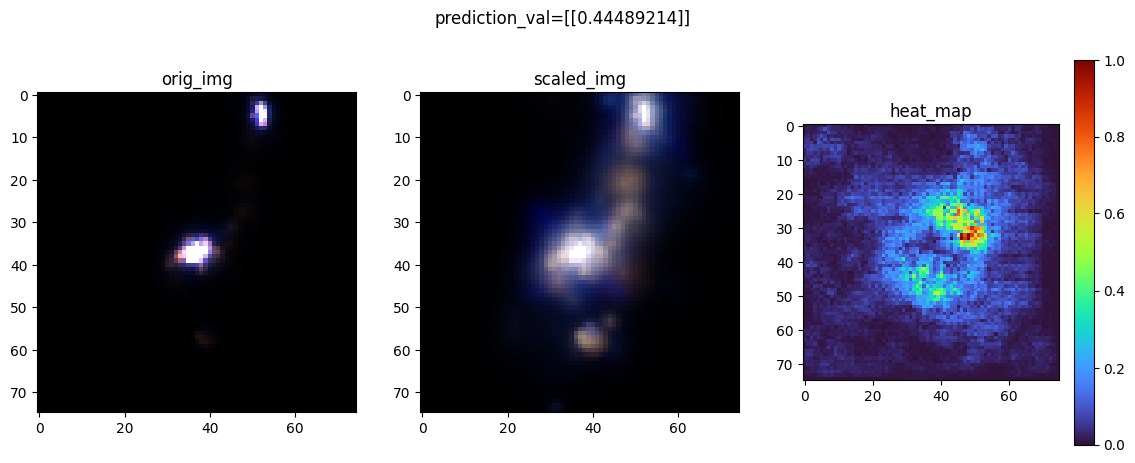

In [11]:
y_pred = cnn.predict(img)

dgrad_abs = tf.math.abs(grads)
dgrad_max_ = np.max(dgrad_abs, axis=3)[0]

# normalize to range between 0 and 1
arr_min, arr_max = np.min(dgrad_max_), np.max(dgrad_max_)
grad_eval = (dgrad_max_ - arr_min) / (arr_max - arr_min + 1e-18)

# Plot the results next to the original image
fig, axes = plt.subplots(1, 3, figsize=(14, 5))

axes[0].imshow(orig_img)
axes[0].set_title("orig_img")
axes[1].imshow(scaled_img)
axes[1].set_title("scaled_img")
i = axes[2].imshow(grad_eval, cmap="turbo")
fig.colorbar(i)
axes[2].set_title("heat_map")
fig.suptitle("prediction_val=" + str(y_pred))

**Image caption**: The above image contains three panels in a horizontal row. The first panel shows the original image of a merging galaxy candidate, the second panel shows a logarithmically-scaled version of the original image, and the third panel shows a heat map of the saliency map.

### Create a stack of saliency images

To understand the overall behavior of our algorithm, we can stack some or all of the saliency maps in the test set to generate an overarching estimate of important pixels. For the sake of simplicity, we will stack the saliency maps for the first 100 images in the test set. Our results once again indicate that the region around a galaxy is particularly important to the model.

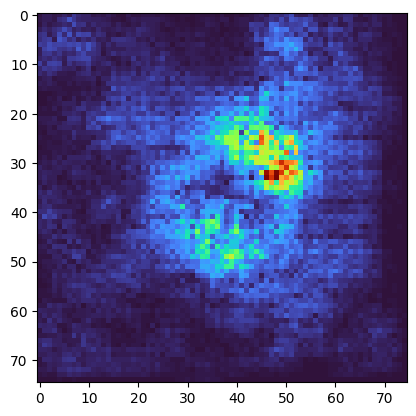

In [12]:
sum_map = np.zeros((75, 75))
# Summing the first 100 saliencies. We can change
# the range to sum more or less saliencies or pick 
# specific ones
for i in range(100):
    img = X_test[img_idx]
    img = img.reshape((1, *img.shape))
    images = tf.Variable(img, dtype=float)

    # Make a prediction and track gradients
    with tf.GradientTape() as tape:
        pred = cnn(images, training=False)
        class_idxs_sorted = np.argsort(pred.numpy().flatten())[::-1]    
        loss = pred[class_idxs_sorted[0]]

    grads = tape.gradient(loss, images)

    y_pred = cnn.predict(images, verbose=0)

    dgrad_abs = tf.math.abs(grads)
    dgrad_max_ = np.max(dgrad_abs, axis=3)[0]

    # normalize to range between 0 and 1
    arr_min, arr_max = np.min(dgrad_max_), np.max(dgrad_max_)
    grad_eval = (dgrad_max_ - arr_min) / (arr_max - arr_min)
    sum_map += grad_eval
plt.imshow(sum_map, cmap='turbo')

**Image caption**: The above image contains a single panel, and shows a stacked version of the saliency maps from 100 images.

## 2. Grad-CAM
While gradient backpropagation has historically been the most popular type of saliency map, the highly connected nature of backtracking has been shown to produce high variance under small changes to inputs. As such, gradient backpropagation is extremely sensitive to data manipulation (preprocessing, sensitivity analysis, GANs), raising questions about its reliability and validity. Gradient Class Activation Mapping (Grad-CAM) is an alternative method for generating saliency models that only examines the gradient of the final convolutional layer when producing the map. As a consequence, Grad-CAM maps have lower (coarser) resolution than backpropagation but are far more resilient to small changes and therefore more reliable when tuning a model. A full description of the technique can be found in <a href='https://arxiv.org/abs/1610.02391'>Selveraju et al. 2016</a>.

The code for Grad-CAM comes from a useful tutorial on the subject by Daniel Reiff. For more information, please visit the  <a href='https://towardsdatascience.com/understand-your-algorithm-with-grad-cam-d3b62fce353'>full tutorial</a>.

### Dependencies

`Open_CV` and `astropy.simple_norm` are used to do manipulate the image for display. Alternatively, we could allow Python to automatically clip the image when the heatmap is out of range.

In [13]:
# Choose the image to analyze
img_idx = 1

# We can change the index to any number in range of the test set
orig_img = X_test[img_idx]
img = orig_img
img = img.reshape((1, *img.shape))
norm = simple_norm(orig_img, 'log', max_percent=99.75)
scaled_img = norm(orig_img)

In [14]:
# Note: recompiling the model will change the layer
# name. In that case, you can either restart the 
# kernel or change the layer_name.
# We can also change the layer selected here to pull out any layer of our model
gradModel = Model(inputs=[cnn.inputs], outputs=[cnn.get_layer("conv2d_2").output, cnn.output])

with tf.GradientTape() as tape:
    # get the loss with associated with the prediction
    inputs = tf.cast(X_test, tf.float32)
    (convOutputs, predictions) = gradModel(inputs)
    loss = predictions[:, 0]
    
# use automatic differentiation to compute the gradients
grads = tape.gradient(loss, convOutputs)

# compute the guided gradients by removing all nonpositive
# gradients
castConvOutputs = tf.cast(convOutputs > 0, "float32")
castGrads = tf.cast(grads > 0, "float32")
guidedGrads = castConvOutputs * castGrads * grads

# pick out the convolution and gradient of the chosen image
convOutputs = convOutputs[img_idx]
guidedGrads = guidedGrads[img_idx]

# compute the average of the gradient values, and using them
# as weights, compute the importance of the pieces
weights = tf.reduce_mean(guidedGrads, axis=(0, 1))
cam = tf.reduce_sum(tf.multiply(weights, convOutputs), axis=-1)

# grab the spatial dimensions of the input image and resize
# the output class activation map to match the input image
# dimensions
(w, h) = (X_test.shape[2], X_test.shape[1])
heatmap = cv2.resize(cam.numpy(), (w, h))

# normalize the heatmap such that all values lie in the range
# [0, 1], scale the resulting values to the range [0, 255],
# and then convert to an unsigned 8-bit integer

2025-07-30 19:36:40.177829: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 554940000 exceeds 10% of free system memory.


2025-07-30 19:36:41.011558: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 554940000 exceeds 10% of free system memory.
2025-07-30 19:36:41.082109: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 554940000 exceeds 10% of free system memory.
2025-07-30 19:36:41.122587: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 554940000 exceeds 10% of free system memory.


2025-07-30 19:36:42.586969: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 554940000 exceeds 10% of free system memory.


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [1.822696e-08..8.880155].


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.2109969226408994].


Text(0.5, 0.98, 'prediction_val=[[0.44489214]]')

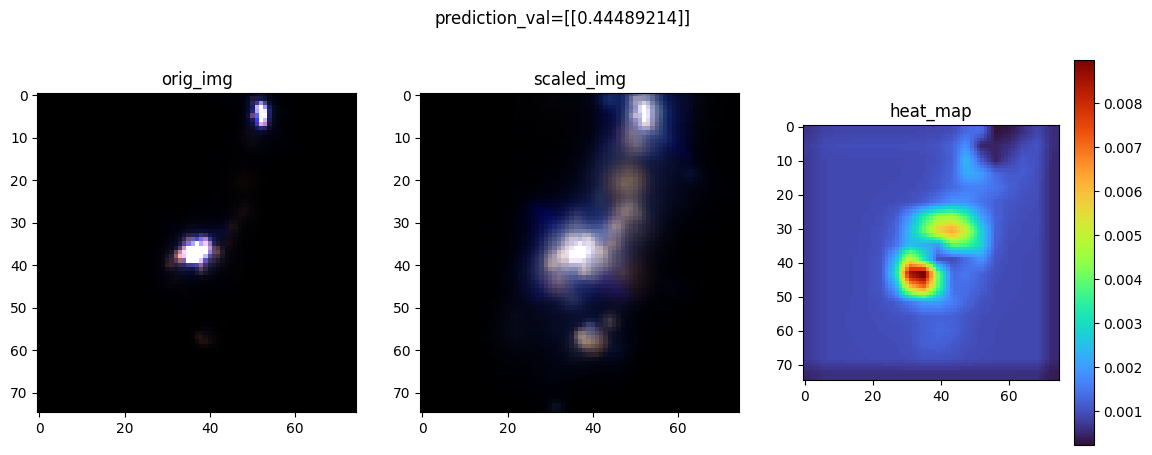

In [15]:
y_pred = cnn.predict(img)

# Plot the results next to the original image
fig, axes = plt.subplots(1, 3, figsize=(14, 5))
axes[0].imshow(orig_img)
axes[0].set_title("orig_img")
axes[1].imshow(scaled_img)
axes[1].set_title("scaled_img")
i = axes[2].imshow(heatmap, cmap="turbo")
fig.colorbar(i)
axes[2].set_title("heat_map")
fig.suptitle("prediction_val=" + str(y_pred))

**Image caption**: The above image contains three panels in a horizontal row. The first panel shows the original image of a merging galaxy candidate, the second panel shows a logarithmically-scaled version of the original image, and the third panel shows a heat map of the grad-cam map.

**The result is very similar** to our saliency map from backpropagation, although the image is coarser and also shows both the top and bottom of the galaxy. We can also play around with the selected layer to calculate the output at different steps in the model and see how activation changes throughout the model.

## 3. RISE Algorithm
The RISE (Randomized Input Sampling for Explanation) Algorithm is another interpretation technique for calculating saliency maps. Instead of calculating gradients from within the model, the RISE implementation works by covering up pieces of the input image, running it through the model, and calculating the average activation in order to determine what parts of the image are most important. As such, this method does not require any access to the inner workings of the model. The algorithm first generates a random sequence of binary grids (called masks), which are placed onto the image. Everything not covered by the mask is removed by multiplying the images together, and the resultant activations are averaged to get our final heatmap. A full description of the algorithm and its variations is provided by <a href='https://arxiv.org/abs/1806.07421'>Petsiuk et al. 2018</a>. 



In [16]:
# Choose the image to analyze
img_idx = 6

# We can change the index to any number in range of the test set
image = X_test[img_idx]

N = 1000  # Number of masks
s = 8     # Size of the grid
p1 = 0.5  # Probability of the cell being set to 1

cell_size = np.ceil(np.array(input_shape[:2]) / s).astype(int)
up_size = (s * cell_size).astype(int)

grid = np.random.rand(N, s, s) < p1
masks = np.empty((N, *input_shape[:2]))

for i in range(N):
    # Randomly place the grid on the image
    x = np.random.randint(0, input_shape[0]-s)
    y = np.random.randint(0, input_shape[1]-s)
    mask = np.pad(grid[i], ((x, input_shape[0]-x-s), (y, input_shape[0]-y-s)), 'constant', constant_values=(0, 0))
    mask = mask[:input_shape[0], :input_shape[1]]
    masks[i] = mask

masks = masks.reshape(-1, *input_shape[:2], 1)

N = len(masks)
pred_masks = cnn.predict(image * masks)
pred_masks = np.expand_dims(pred_masks, axis=-1)
pred_masks = np.expand_dims(pred_masks, axis=-1) # Reshape pred_masks for broadcasting
heatmap = (pred_masks * masks).sum(axis=0)
heatmap = heatmap / N / p1

 1/32 [..............................] - ETA: 0s

 5/32 [===>..........................] - ETA: 0s

 9/32 [=======>......................] - ETA: 0s

13/32 [===========>..................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

21/32 [==================>...........] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

29/32 [==========================>...] - ETA: 0s

32/32 [==============================] - 1s 15ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.00022207294..674.50696].


Text(0.5, 1.0, 'heat_map')

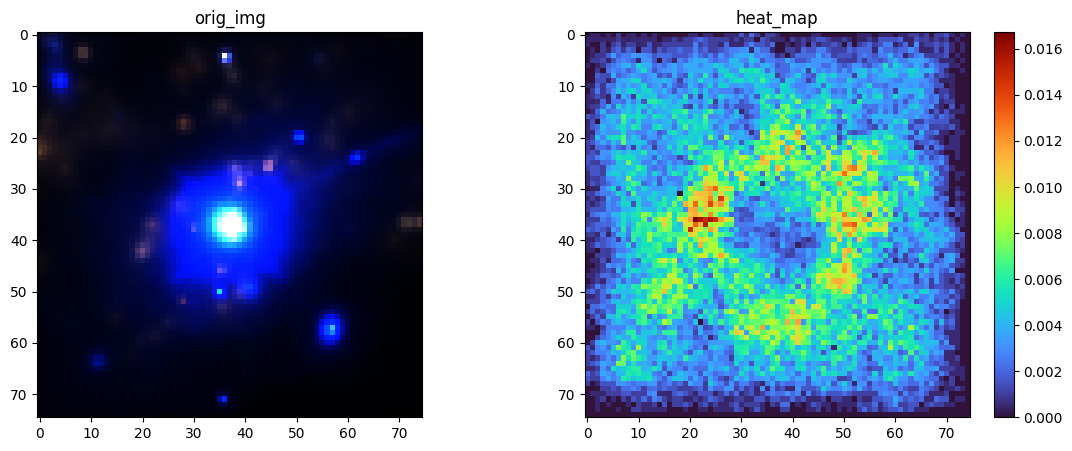

In [17]:
# Plot the results next to the original image
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
axes[0].imshow(image)
axes[0].set_title("orig_img")
i = axes[1].imshow(heatmap, cmap="turbo")
fig.colorbar(i)
axes[1].set_title("heat_map")

**Image caption**: The above image contains two panels in a horizontal row. The first panel shows the original image of a merginig galaxy candidate, and the second panel shows a heat map of the RISE map.

**When examining the selected image**, we see a ring around the galactic center. Note that this is not the case for all astronomical images, or even all images in this dataset. Try playing around with the selected image to generate different saliency maps. For images where the central feature is relatively small, RISE's occlusion-based methodology can be unreliable.

## 4. Ablation Analysis
Saliency maps provide an intuitive visual understanding of our model's focus and can be useful for understanding the physical relevance of our classification scheme. In order to understand the efficacy of our model's architecture, we can instead use ablation analysis to determine the most important layers of our model. Ablation analysis works by rebuilding our model without a specified layer of interest and testing and comparing the performance of a partial model. Since we are focusing on our model's internal architecture rather than the features of the dataset we are looking at, we want to use this technique when trying to improve the training metrics of our model by editing its layers. This method allows us to determine which layers of the model are most important, or if some layers are hindering the learning capabilities of our mode

In the exercise below, we will build and train four mini-models on the same data set as before. As this is an educational notebook, we will limit the training time of each model to five epochs. Results with these models may vary considerably due to these training constraints, but we highly encourage you to try modifying this section of the notebook for different results (see [Exercises](#Exercises/Extensions))

Note that performing an ablation analysis will require training multiple models with the same architecture. This can be quite compute intensive on personal computers, so if you are running this notebook locally it is recommended that your device be plugged in before running the analysis.

### Dependencies

`Tensorflow` is used build our model and train it.

In [18]:
def create_model(ablate=None):
    x_in = Input(shape=input_shape)
    
    if ablate != 'c0':
        c0 = Convolution2D(8, (5, 5), activation='relu', strides=(1, 1), padding='same')(x_in)
    else:
        c0 = x_in
    b0 = BatchNormalization()(c0)
    d0 = MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid')(b0)
    e0 = Dropout(0.5)(d0)

    if ablate != 'c1':
        c1 = Convolution2D(16, (3, 3), activation='relu', strides=(1, 1), padding='same')(e0)
    else:
        c1 = e0
    b1 = BatchNormalization()(c1)
    d1 = MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid')(b1)
    e1 = Dropout(0.5)(d1)

    if ablate != 'c2':
        c2 = Convolution2D(32, (3, 3), activation='relu', strides=(1, 1), padding='same')(e1)
    else:
        c2 = e1
    b2 = BatchNormalization()(c2)
    d2 = MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid')(b2)
    e2 = Dropout(0.5)(d2)

    f = Flatten()(e2)
    z0 = Dense(64, activation='softmax', kernel_regularizer=l2(0.0001))(f)
    z1 = Dense(32, activation='softmax', kernel_regularizer=l2(0.0001))(z0)
    y_out = Dense(1, activation='sigmoid')(z1)

    cnn = Model(inputs=x_in, outputs=y_out)
    return cnn

**Since ablation analysis requires training multiple models**, it can often be more resource intensive than other methods. However, it can also provide useful information on the way features are organized during training. The following cell can be edited to change how much we want to train our mini-models.

In [19]:
# You can change how much to train each model
# 5 epochs is chosen due to time and computation constraints
num_epochs = 5

# Train the original model
model = create_model()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.fit(X_train, y_train, epochs=num_epochs, batch_size=32, validation_data=(X_test, y_test))

# Get baseline performance
baseline_score = model.evaluate(X_test, y_test)

# Ablate each layer and compare performance
layers_to_ablate = ['c0', 'c1', 'c2']
for layer in layers_to_ablate:
    model_ablated = create_model(ablate=layer)
    model_ablated.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    model_ablated.fit(X_train, y_train, epochs=num_epochs, batch_size=32, validation_data=(X_test, y_test))
    ablated_score = model_ablated.evaluate(X_test, y_test)
    
    print(f"Performance drop after ablating {layer}: {baseline_score[1] - ablated_score[1]}")

Epoch 1/5


  1/338 [..............................] - ETA: 6:12 - loss: 0.7082 - accuracy: 0.5625

  2/338 [..............................] - ETA: 19s - loss: 0.7099 - accuracy: 0.4844 

  3/338 [..............................] - ETA: 19s - loss: 0.7098 - accuracy: 0.4792

  4/338 [..............................] - ETA: 19s - loss: 0.7097 - accuracy: 0.4766

  5/338 [..............................] - ETA: 18s - loss: 0.7092 - accuracy: 0.4875

  6/338 [..............................] - ETA: 18s - loss: 0.7086 - accuracy: 0.5052

  7/338 [..............................] - ETA: 18s - loss: 0.7084 - accuracy: 0.5000

  8/338 [..............................] - ETA: 18s - loss: 0.7083 - accuracy: 0.4922

  9/338 [..............................] - ETA: 18s - loss: 0.7075 - accuracy: 0.5139

 10/338 [..............................] - ETA: 18s - loss: 0.7075 - accuracy: 0.5031

 11/338 [..............................] - ETA: 18s - loss: 0.7068 - accuracy: 0.5199

 12/338 [>.............................] - ETA: 18s - loss: 0.7065 - accuracy: 0.5234

 13/338 [>.............................] - ETA: 18s - loss: 0.7065 - accuracy: 0.5168

 14/338 [>.............................] - ETA: 18s - loss: 0.7065 - accuracy: 0.5089

 15/338 [>.............................] - ETA: 18s - loss: 0.7063 - accuracy: 0.5083

 16/338 [>.............................] - ETA: 18s - loss: 0.7059 - accuracy: 0.5117

 17/338 [>.............................] - ETA: 18s - loss: 0.7057 - accuracy: 0.5110

 18/338 [>.............................] - ETA: 18s - loss: 0.7056 - accuracy: 0.5069

 19/338 [>.............................] - ETA: 17s - loss: 0.7055 - accuracy: 0.5033

 20/338 [>.............................] - ETA: 17s - loss: 0.7051 - accuracy: 0.5094

 21/338 [>.............................] - ETA: 17s - loss: 0.7047 - accuracy: 0.5179

 22/338 [>.............................] - ETA: 17s - loss: 0.7046 - accuracy: 0.5142

 23/338 [=>............................] - ETA: 17s - loss: 0.7044 - accuracy: 0.5149

 24/338 [=>............................] - ETA: 17s - loss: 0.7041 - accuracy: 0.5195

 25/338 [=>............................] - ETA: 17s - loss: 0.7039 - accuracy: 0.5175

 26/338 [=>............................] - ETA: 17s - loss: 0.7036 - accuracy: 0.5228

 27/338 [=>............................] - ETA: 17s - loss: 0.7035 - accuracy: 0.5220

 28/338 [=>............................] - ETA: 17s - loss: 0.7032 - accuracy: 0.5234

 29/338 [=>............................] - ETA: 17s - loss: 0.7029 - accuracy: 0.5259

 30/338 [=>............................] - ETA: 17s - loss: 0.7026 - accuracy: 0.5292

 31/338 [=>............................] - ETA: 17s - loss: 0.7025 - accuracy: 0.5282

 32/338 [=>............................] - ETA: 17s - loss: 0.7025 - accuracy: 0.5254

 33/338 [=>............................] - ETA: 17s - loss: 0.7023 - accuracy: 0.5265

 34/338 [==>...........................] - ETA: 17s - loss: 0.7022 - accuracy: 0.5267

 35/338 [==>...........................] - ETA: 16s - loss: 0.7021 - accuracy: 0.5250

 36/338 [==>...........................] - ETA: 16s - loss: 0.7022 - accuracy: 0.5191

 37/338 [==>...........................] - ETA: 16s - loss: 0.7020 - accuracy: 0.5211

 38/338 [==>...........................] - ETA: 16s - loss: 0.7019 - accuracy: 0.5197

 39/338 [==>...........................] - ETA: 16s - loss: 0.7019 - accuracy: 0.5168

 40/338 [==>...........................] - ETA: 16s - loss: 0.7017 - accuracy: 0.5188

 41/338 [==>...........................] - ETA: 16s - loss: 0.7016 - accuracy: 0.5175

 42/338 [==>...........................] - ETA: 16s - loss: 0.7017 - accuracy: 0.5134

 43/338 [==>...........................] - ETA: 16s - loss: 0.7016 - accuracy: 0.5116

 44/338 [==>...........................] - ETA: 16s - loss: 0.7016 - accuracy: 0.5099

 45/338 [==>...........................] - ETA: 16s - loss: 0.7016 - accuracy: 0.5090

 46/338 [===>..........................] - ETA: 16s - loss: 0.7014 - accuracy: 0.5102

 47/338 [===>..........................] - ETA: 16s - loss: 0.7014 - accuracy: 0.5086

 48/338 [===>..........................] - ETA: 16s - loss: 0.7011 - accuracy: 0.5117

 49/338 [===>..........................] - ETA: 16s - loss: 0.7010 - accuracy: 0.5121

 50/338 [===>..........................] - ETA: 16s - loss: 0.7010 - accuracy: 0.5119

 51/338 [===>..........................] - ETA: 16s - loss: 0.7010 - accuracy: 0.5086

 52/338 [===>..........................] - ETA: 15s - loss: 0.7008 - accuracy: 0.5096

 53/338 [===>..........................] - ETA: 15s - loss: 0.7006 - accuracy: 0.5124

 54/338 [===>..........................] - ETA: 15s - loss: 0.7005 - accuracy: 0.5133

 55/338 [===>..........................] - ETA: 15s - loss: 0.7003 - accuracy: 0.5159

 56/338 [===>..........................] - ETA: 15s - loss: 0.7002 - accuracy: 0.5173

 57/338 [====>.........................] - ETA: 15s - loss: 0.7002 - accuracy: 0.5159

 58/338 [====>.........................] - ETA: 15s - loss: 0.7000 - accuracy: 0.5178

 59/338 [====>.........................] - ETA: 15s - loss: 0.7001 - accuracy: 0.5143

 60/338 [====>.........................] - ETA: 15s - loss: 0.6999 - accuracy: 0.5161

 61/338 [====>.........................] - ETA: 15s - loss: 0.6998 - accuracy: 0.5179

 62/338 [====>.........................] - ETA: 15s - loss: 0.6997 - accuracy: 0.5197

 63/338 [====>.........................] - ETA: 15s - loss: 0.6996 - accuracy: 0.5198

 64/338 [====>.........................] - ETA: 15s - loss: 0.6995 - accuracy: 0.5186

 65/338 [====>.........................] - ETA: 15s - loss: 0.6994 - accuracy: 0.5202

 66/338 [====>.........................] - ETA: 15s - loss: 0.6993 - accuracy: 0.5204

 67/338 [====>.........................] - ETA: 15s - loss: 0.6992 - accuracy: 0.5215

 68/338 [=====>........................] - ETA: 15s - loss: 0.6992 - accuracy: 0.5193

 69/338 [=====>........................] - ETA: 14s - loss: 0.6990 - accuracy: 0.5222

 70/338 [=====>........................] - ETA: 14s - loss: 0.6991 - accuracy: 0.5205

 71/338 [=====>........................] - ETA: 14s - loss: 0.6990 - accuracy: 0.5194

 72/338 [=====>........................] - ETA: 14s - loss: 0.6989 - accuracy: 0.5213

 73/338 [=====>........................] - ETA: 14s - loss: 0.6988 - accuracy: 0.5218

 74/338 [=====>........................] - ETA: 14s - loss: 0.6988 - accuracy: 0.5207

 75/338 [=====>........................] - ETA: 14s - loss: 0.6987 - accuracy: 0.5217

 76/338 [=====>........................] - ETA: 14s - loss: 0.6987 - accuracy: 0.5201

 77/338 [=====>........................] - ETA: 14s - loss: 0.6987 - accuracy: 0.5199

 78/338 [=====>........................] - ETA: 14s - loss: 0.6988 - accuracy: 0.5168

 79/338 [======>.......................] - ETA: 14s - loss: 0.6988 - accuracy: 0.5166

 80/338 [======>.......................] - ETA: 14s - loss: 0.6988 - accuracy: 0.5152

 81/338 [======>.......................] - ETA: 14s - loss: 0.6987 - accuracy: 0.5166

 82/338 [======>.......................] - ETA: 14s - loss: 0.6988 - accuracy: 0.5141

 83/338 [======>.......................] - ETA: 14s - loss: 0.6986 - accuracy: 0.5166

 84/338 [======>.......................] - ETA: 14s - loss: 0.6985 - accuracy: 0.5171

 85/338 [======>.......................] - ETA: 14s - loss: 0.6985 - accuracy: 0.5154

 86/338 [======>.......................] - ETA: 14s - loss: 0.6985 - accuracy: 0.5145

 87/338 [======>.......................] - ETA: 13s - loss: 0.6985 - accuracy: 0.5147

 88/338 [======>.......................] - ETA: 13s - loss: 0.6985 - accuracy: 0.5131

 89/338 [======>.......................] - ETA: 13s - loss: 0.6984 - accuracy: 0.5137

 90/338 [======>.......................] - ETA: 13s - loss: 0.6984 - accuracy: 0.5146

 91/338 [=======>......................] - ETA: 13s - loss: 0.6983 - accuracy: 0.5158

 92/338 [=======>......................] - ETA: 13s - loss: 0.6982 - accuracy: 0.5156

 93/338 [=======>......................] - ETA: 13s - loss: 0.6982 - accuracy: 0.5144

 94/338 [=======>......................] - ETA: 13s - loss: 0.6982 - accuracy: 0.5140

 95/338 [=======>......................] - ETA: 13s - loss: 0.6981 - accuracy: 0.5158

 96/338 [=======>......................] - ETA: 13s - loss: 0.6981 - accuracy: 0.5156

 97/338 [=======>......................] - ETA: 13s - loss: 0.6980 - accuracy: 0.5158

 98/338 [=======>......................] - ETA: 13s - loss: 0.6980 - accuracy: 0.5159

 99/338 [=======>......................] - ETA: 13s - loss: 0.6980 - accuracy: 0.5152

100/338 [=======>......................] - ETA: 13s - loss: 0.6979 - accuracy: 0.5159

101/338 [=======>......................] - ETA: 13s - loss: 0.6979 - accuracy: 0.5164

102/338 [========>.....................] - ETA: 13s - loss: 0.6977 - accuracy: 0.5187

103/338 [========>.....................] - ETA: 13s - loss: 0.6977 - accuracy: 0.5176

104/338 [========>.....................] - ETA: 13s - loss: 0.6977 - accuracy: 0.5174

105/338 [========>.....................] - ETA: 12s - loss: 0.6977 - accuracy: 0.5173

106/338 [========>.....................] - ETA: 12s - loss: 0.6976 - accuracy: 0.5174

107/338 [========>.....................] - ETA: 12s - loss: 0.6977 - accuracy: 0.5161

108/338 [========>.....................] - ETA: 12s - loss: 0.6976 - accuracy: 0.5162

109/338 [========>.....................] - ETA: 12s - loss: 0.6975 - accuracy: 0.5175

110/338 [========>.....................] - ETA: 12s - loss: 0.6975 - accuracy: 0.5176

111/338 [========>.....................] - ETA: 12s - loss: 0.6974 - accuracy: 0.5175

112/338 [========>.....................] - ETA: 12s - loss: 0.6974 - accuracy: 0.5179

113/338 [=========>....................] - ETA: 12s - loss: 0.6973 - accuracy: 0.5191

114/338 [=========>....................] - ETA: 12s - loss: 0.6972 - accuracy: 0.5197

115/338 [=========>....................] - ETA: 12s - loss: 0.6972 - accuracy: 0.5201

116/338 [=========>....................] - ETA: 12s - loss: 0.6971 - accuracy: 0.5202

117/338 [=========>....................] - ETA: 12s - loss: 0.6972 - accuracy: 0.5198

118/338 [=========>....................] - ETA: 12s - loss: 0.6971 - accuracy: 0.5204

119/338 [=========>....................] - ETA: 12s - loss: 0.6971 - accuracy: 0.5200

120/338 [=========>....................] - ETA: 12s - loss: 0.6971 - accuracy: 0.5195

121/338 [=========>....................] - ETA: 12s - loss: 0.6971 - accuracy: 0.5194

122/338 [=========>....................] - ETA: 12s - loss: 0.6970 - accuracy: 0.5200

123/338 [=========>....................] - ETA: 11s - loss: 0.6969 - accuracy: 0.5201

124/338 [==========>...................] - ETA: 11s - loss: 0.6970 - accuracy: 0.5197

125/338 [==========>...................] - ETA: 11s - loss: 0.6969 - accuracy: 0.5195

126/338 [==========>...................] - ETA: 11s - loss: 0.6969 - accuracy: 0.5193

127/338 [==========>...................] - ETA: 11s - loss: 0.6969 - accuracy: 0.5197

128/338 [==========>...................] - ETA: 11s - loss: 0.6969 - accuracy: 0.5193

129/338 [==========>...................] - ETA: 11s - loss: 0.6968 - accuracy: 0.5201

130/338 [==========>...................] - ETA: 11s - loss: 0.6968 - accuracy: 0.5190

131/338 [==========>...................] - ETA: 11s - loss: 0.6968 - accuracy: 0.5193

132/338 [==========>...................] - ETA: 11s - loss: 0.6967 - accuracy: 0.5196

133/338 [==========>...................] - ETA: 11s - loss: 0.6967 - accuracy: 0.5195

134/338 [==========>...................] - ETA: 11s - loss: 0.6967 - accuracy: 0.5201

135/338 [==========>...................] - ETA: 11s - loss: 0.6966 - accuracy: 0.5199

136/338 [===========>..................] - ETA: 11s - loss: 0.6966 - accuracy: 0.5207

137/338 [===========>..................] - ETA: 11s - loss: 0.6965 - accuracy: 0.5210

138/338 [===========>..................] - ETA: 11s - loss: 0.6965 - accuracy: 0.5215

139/338 [===========>..................] - ETA: 11s - loss: 0.6965 - accuracy: 0.5202

140/338 [===========>..................] - ETA: 11s - loss: 0.6965 - accuracy: 0.5201

141/338 [===========>..................] - ETA: 10s - loss: 0.6965 - accuracy: 0.5199

142/338 [===========>..................] - ETA: 10s - loss: 0.6965 - accuracy: 0.5198

143/338 [===========>..................] - ETA: 10s - loss: 0.6965 - accuracy: 0.5197

144/338 [===========>..................] - ETA: 10s - loss: 0.6964 - accuracy: 0.5204

145/338 [===========>..................] - ETA: 10s - loss: 0.6963 - accuracy: 0.5213

146/338 [===========>..................] - ETA: 10s - loss: 0.6963 - accuracy: 0.5216

147/338 [============>.................] - ETA: 10s - loss: 0.6962 - accuracy: 0.5219

148/338 [============>.................] - ETA: 10s - loss: 0.6962 - accuracy: 0.5222

149/338 [============>.................] - ETA: 10s - loss: 0.6963 - accuracy: 0.5208

150/338 [============>.................] - ETA: 10s - loss: 0.6962 - accuracy: 0.5215

151/338 [============>.................] - ETA: 10s - loss: 0.6961 - accuracy: 0.5219

152/338 [============>.................] - ETA: 10s - loss: 0.6961 - accuracy: 0.5214

153/338 [============>.................] - ETA: 10s - loss: 0.6961 - accuracy: 0.5217

154/338 [============>.................] - ETA: 10s - loss: 0.6961 - accuracy: 0.5213

155/338 [============>.................] - ETA: 10s - loss: 0.6961 - accuracy: 0.5212

156/338 [============>.................] - ETA: 10s - loss: 0.6960 - accuracy: 0.5214

157/338 [============>.................] - ETA: 10s - loss: 0.6960 - accuracy: 0.5221

158/338 [=============>................] - ETA: 10s - loss: 0.6959 - accuracy: 0.5222

159/338 [=============>................] - ETA: 9s - loss: 0.6959 - accuracy: 0.5228 

160/338 [=============>................] - ETA: 9s - loss: 0.6959 - accuracy: 0.5225

161/338 [=============>................] - ETA: 9s - loss: 0.6959 - accuracy: 0.5223

162/338 [=============>................] - ETA: 9s - loss: 0.6958 - accuracy: 0.5224

163/338 [=============>................] - ETA: 9s - loss: 0.6958 - accuracy: 0.5224

164/338 [=============>................] - ETA: 9s - loss: 0.6958 - accuracy: 0.5223

165/338 [=============>................] - ETA: 9s - loss: 0.6957 - accuracy: 0.5227

166/338 [=============>................] - ETA: 9s - loss: 0.6957 - accuracy: 0.5233

167/338 [=============>................] - ETA: 9s - loss: 0.6956 - accuracy: 0.5240

168/338 [=============>................] - ETA: 9s - loss: 0.6956 - accuracy: 0.5240

169/338 [==============>...............] - ETA: 9s - loss: 0.6956 - accuracy: 0.5239

170/338 [==============>...............] - ETA: 9s - loss: 0.6956 - accuracy: 0.5239

171/338 [==============>...............] - ETA: 9s - loss: 0.6955 - accuracy: 0.5239

172/338 [==============>...............] - ETA: 9s - loss: 0.6955 - accuracy: 0.5247

173/338 [==============>...............] - ETA: 9s - loss: 0.6955 - accuracy: 0.5244

174/338 [==============>...............] - ETA: 9s - loss: 0.6954 - accuracy: 0.5244

175/338 [==============>...............] - ETA: 9s - loss: 0.6955 - accuracy: 0.5239

176/338 [==============>...............] - ETA: 9s - loss: 0.6955 - accuracy: 0.5240

177/338 [==============>...............] - ETA: 8s - loss: 0.6954 - accuracy: 0.5240

178/338 [==============>...............] - ETA: 8s - loss: 0.6953 - accuracy: 0.5249

179/338 [==============>...............] - ETA: 8s - loss: 0.6953 - accuracy: 0.5248

180/338 [==============>...............] - ETA: 8s - loss: 0.6953 - accuracy: 0.5245

181/338 [===============>..............] - ETA: 8s - loss: 0.6952 - accuracy: 0.5252

182/338 [===============>..............] - ETA: 8s - loss: 0.6952 - accuracy: 0.5254

183/338 [===============>..............] - ETA: 8s - loss: 0.6952 - accuracy: 0.5251

184/338 [===============>..............] - ETA: 8s - loss: 0.6952 - accuracy: 0.5255

185/338 [===============>..............] - ETA: 8s - loss: 0.6952 - accuracy: 0.5245

186/338 [===============>..............] - ETA: 8s - loss: 0.6952 - accuracy: 0.5244

187/338 [===============>..............] - ETA: 8s - loss: 0.6952 - accuracy: 0.5249

188/338 [===============>..............] - ETA: 8s - loss: 0.6953 - accuracy: 0.5238

189/338 [===============>..............] - ETA: 8s - loss: 0.6952 - accuracy: 0.5238

190/338 [===============>..............] - ETA: 8s - loss: 0.6952 - accuracy: 0.5240

191/338 [===============>..............] - ETA: 8s - loss: 0.6952 - accuracy: 0.5244

192/338 [================>.............] - ETA: 8s - loss: 0.6951 - accuracy: 0.5244

193/338 [================>.............] - ETA: 8s - loss: 0.6951 - accuracy: 0.5248

194/338 [================>.............] - ETA: 8s - loss: 0.6951 - accuracy: 0.5248

195/338 [================>.............] - ETA: 7s - loss: 0.6951 - accuracy: 0.5242

196/338 [================>.............] - ETA: 7s - loss: 0.6952 - accuracy: 0.5230

197/338 [================>.............] - ETA: 7s - loss: 0.6953 - accuracy: 0.5225

198/338 [================>.............] - ETA: 7s - loss: 0.6952 - accuracy: 0.5226

199/338 [================>.............] - ETA: 7s - loss: 0.6952 - accuracy: 0.5228

200/338 [================>.............] - ETA: 7s - loss: 0.6952 - accuracy: 0.5227

201/338 [================>.............] - ETA: 7s - loss: 0.6952 - accuracy: 0.5225

202/338 [================>.............] - ETA: 7s - loss: 0.6951 - accuracy: 0.5227

203/338 [=================>............] - ETA: 7s - loss: 0.6951 - accuracy: 0.5229

204/338 [=================>............] - ETA: 7s - loss: 0.6951 - accuracy: 0.5230

205/338 [=================>............] - ETA: 7s - loss: 0.6951 - accuracy: 0.5226

206/338 [=================>............] - ETA: 7s - loss: 0.6950 - accuracy: 0.5234

207/338 [=================>............] - ETA: 7s - loss: 0.6950 - accuracy: 0.5242

208/338 [=================>............] - ETA: 7s - loss: 0.6950 - accuracy: 0.5239

209/338 [=================>............] - ETA: 7s - loss: 0.6949 - accuracy: 0.5244

210/338 [=================>............] - ETA: 7s - loss: 0.6949 - accuracy: 0.5246

211/338 [=================>............] - ETA: 7s - loss: 0.6948 - accuracy: 0.5255

212/338 [=================>............] - ETA: 7s - loss: 0.6947 - accuracy: 0.5264

213/338 [=================>............] - ETA: 6s - loss: 0.6946 - accuracy: 0.5266

214/338 [=================>............] - ETA: 6s - loss: 0.6946 - accuracy: 0.5267

215/338 [==================>...........] - ETA: 6s - loss: 0.6946 - accuracy: 0.5263

216/338 [==================>...........] - ETA: 6s - loss: 0.6946 - accuracy: 0.5268

217/338 [==================>...........] - ETA: 6s - loss: 0.6945 - accuracy: 0.5269

218/338 [==================>...........] - ETA: 6s - loss: 0.6945 - accuracy: 0.5268

219/338 [==================>...........] - ETA: 6s - loss: 0.6945 - accuracy: 0.5274

220/338 [==================>...........] - ETA: 6s - loss: 0.6945 - accuracy: 0.5273

221/338 [==================>...........] - ETA: 6s - loss: 0.6944 - accuracy: 0.5273

222/338 [==================>...........] - ETA: 6s - loss: 0.6944 - accuracy: 0.5272

223/338 [==================>...........] - ETA: 6s - loss: 0.6944 - accuracy: 0.5269

224/338 [==================>...........] - ETA: 6s - loss: 0.6944 - accuracy: 0.5269

225/338 [==================>...........] - ETA: 6s - loss: 0.6944 - accuracy: 0.5272

226/338 [===================>..........] - ETA: 6s - loss: 0.6944 - accuracy: 0.5270

227/338 [===================>..........] - ETA: 6s - loss: 0.6943 - accuracy: 0.5275

228/338 [===================>..........] - ETA: 6s - loss: 0.6943 - accuracy: 0.5278

229/338 [===================>..........] - ETA: 6s - loss: 0.6943 - accuracy: 0.5278

230/338 [===================>..........] - ETA: 6s - loss: 0.6942 - accuracy: 0.5283

231/338 [===================>..........] - ETA: 5s - loss: 0.6942 - accuracy: 0.5284

232/338 [===================>..........] - ETA: 5s - loss: 0.6943 - accuracy: 0.5276

233/338 [===================>..........] - ETA: 5s - loss: 0.6942 - accuracy: 0.5276

234/338 [===================>..........] - ETA: 5s - loss: 0.6942 - accuracy: 0.5275

235/338 [===================>..........] - ETA: 5s - loss: 0.6941 - accuracy: 0.5281

236/338 [===================>..........] - ETA: 5s - loss: 0.6941 - accuracy: 0.5279

237/338 [====================>.........] - ETA: 5s - loss: 0.6941 - accuracy: 0.5278

238/338 [====================>.........] - ETA: 5s - loss: 0.6941 - accuracy: 0.5281

239/338 [====================>.........] - ETA: 5s - loss: 0.6942 - accuracy: 0.5273

240/338 [====================>.........] - ETA: 5s - loss: 0.6942 - accuracy: 0.5273

241/338 [====================>.........] - ETA: 5s - loss: 0.6941 - accuracy: 0.5277

242/338 [====================>.........] - ETA: 5s - loss: 0.6940 - accuracy: 0.5284

243/338 [====================>.........] - ETA: 5s - loss: 0.6940 - accuracy: 0.5287

244/338 [====================>.........] - ETA: 5s - loss: 0.6939 - accuracy: 0.5291

245/338 [====================>.........] - ETA: 5s - loss: 0.6939 - accuracy: 0.5295

246/338 [====================>.........] - ETA: 5s - loss: 0.6938 - accuracy: 0.5299

247/338 [====================>.........] - ETA: 5s - loss: 0.6938 - accuracy: 0.5304

248/338 [=====================>........] - ETA: 5s - loss: 0.6937 - accuracy: 0.5305

249/338 [=====================>........] - ETA: 4s - loss: 0.6937 - accuracy: 0.5306

250/338 [=====================>........] - ETA: 4s - loss: 0.6937 - accuracy: 0.5305

251/338 [=====================>........] - ETA: 4s - loss: 0.6937 - accuracy: 0.5303

252/338 [=====================>........] - ETA: 4s - loss: 0.6937 - accuracy: 0.5301

253/338 [=====================>........] - ETA: 4s - loss: 0.6937 - accuracy: 0.5303

254/338 [=====================>........] - ETA: 4s - loss: 0.6937 - accuracy: 0.5300

255/338 [=====================>........] - ETA: 4s - loss: 0.6937 - accuracy: 0.5301

256/338 [=====================>........] - ETA: 4s - loss: 0.6937 - accuracy: 0.5297

257/338 [=====================>........] - ETA: 4s - loss: 0.6937 - accuracy: 0.5293

258/338 [=====================>........] - ETA: 4s - loss: 0.6937 - accuracy: 0.5296

259/338 [=====================>........] - ETA: 4s - loss: 0.6937 - accuracy: 0.5294

260/338 [======================>.......] - ETA: 4s - loss: 0.6937 - accuracy: 0.5290

261/338 [======================>.......] - ETA: 4s - loss: 0.6937 - accuracy: 0.5295

262/338 [======================>.......] - ETA: 4s - loss: 0.6936 - accuracy: 0.5299

263/338 [======================>.......] - ETA: 4s - loss: 0.6936 - accuracy: 0.5298

264/338 [======================>.......] - ETA: 4s - loss: 0.6935 - accuracy: 0.5303

265/338 [======================>.......] - ETA: 4s - loss: 0.6935 - accuracy: 0.5303

266/338 [======================>.......] - ETA: 4s - loss: 0.6936 - accuracy: 0.5300

267/338 [======================>.......] - ETA: 3s - loss: 0.6936 - accuracy: 0.5295

268/338 [======================>.......] - ETA: 3s - loss: 0.6936 - accuracy: 0.5296

269/338 [======================>.......] - ETA: 3s - loss: 0.6936 - accuracy: 0.5292

270/338 [======================>.......] - ETA: 3s - loss: 0.6936 - accuracy: 0.5289

271/338 [=======================>......] - ETA: 3s - loss: 0.6936 - accuracy: 0.5288

272/338 [=======================>......] - ETA: 3s - loss: 0.6936 - accuracy: 0.5290

273/338 [=======================>......] - ETA: 3s - loss: 0.6936 - accuracy: 0.5292

274/338 [=======================>......] - ETA: 3s - loss: 0.6936 - accuracy: 0.5290

275/338 [=======================>......] - ETA: 3s - loss: 0.6936 - accuracy: 0.5289

276/338 [=======================>......] - ETA: 3s - loss: 0.6936 - accuracy: 0.5289

277/338 [=======================>......] - ETA: 3s - loss: 0.6936 - accuracy: 0.5290

278/338 [=======================>......] - ETA: 3s - loss: 0.6936 - accuracy: 0.5286

279/338 [=======================>......] - ETA: 3s - loss: 0.6936 - accuracy: 0.5287

280/338 [=======================>......] - ETA: 3s - loss: 0.6935 - accuracy: 0.5295

281/338 [=======================>......] - ETA: 3s - loss: 0.6934 - accuracy: 0.5298

282/338 [========================>.....] - ETA: 3s - loss: 0.6934 - accuracy: 0.5299

283/338 [========================>.....] - ETA: 3s - loss: 0.6934 - accuracy: 0.5299

284/338 [========================>.....] - ETA: 3s - loss: 0.6933 - accuracy: 0.5304

285/338 [========================>.....] - ETA: 2s - loss: 0.6933 - accuracy: 0.5303

286/338 [========================>.....] - ETA: 2s - loss: 0.6933 - accuracy: 0.5304

287/338 [========================>.....] - ETA: 2s - loss: 0.6932 - accuracy: 0.5310

288/338 [========================>.....] - ETA: 2s - loss: 0.6933 - accuracy: 0.5306

289/338 [========================>.....] - ETA: 2s - loss: 0.6932 - accuracy: 0.5308

290/338 [========================>.....] - ETA: 2s - loss: 0.6932 - accuracy: 0.5309

291/338 [========================>.....] - ETA: 2s - loss: 0.6932 - accuracy: 0.5305

292/338 [========================>.....] - ETA: 2s - loss: 0.6932 - accuracy: 0.5303

293/338 [=========================>....] - ETA: 2s - loss: 0.6932 - accuracy: 0.5307

294/338 [=========================>....] - ETA: 2s - loss: 0.6932 - accuracy: 0.5303

295/338 [=========================>....] - ETA: 2s - loss: 0.6932 - accuracy: 0.5305

296/338 [=========================>....] - ETA: 2s - loss: 0.6932 - accuracy: 0.5306

297/338 [=========================>....] - ETA: 2s - loss: 0.6932 - accuracy: 0.5306

298/338 [=========================>....] - ETA: 2s - loss: 0.6932 - accuracy: 0.5305

299/338 [=========================>....] - ETA: 2s - loss: 0.6931 - accuracy: 0.5306

300/338 [=========================>....] - ETA: 2s - loss: 0.6931 - accuracy: 0.5305

301/338 [=========================>....] - ETA: 2s - loss: 0.6931 - accuracy: 0.5307

302/338 [=========================>....] - ETA: 2s - loss: 0.6931 - accuracy: 0.5307

303/338 [=========================>....] - ETA: 1s - loss: 0.6932 - accuracy: 0.5302

304/338 [=========================>....] - ETA: 1s - loss: 0.6931 - accuracy: 0.5308

305/338 [==========================>...] - ETA: 1s - loss: 0.6931 - accuracy: 0.5303

306/338 [==========================>...] - ETA: 1s - loss: 0.6931 - accuracy: 0.5303

307/338 [==========================>...] - ETA: 1s - loss: 0.6931 - accuracy: 0.5304

308/338 [==========================>...] - ETA: 1s - loss: 0.6932 - accuracy: 0.5295

309/338 [==========================>...] - ETA: 1s - loss: 0.6933 - accuracy: 0.5293

310/338 [==========================>...] - ETA: 1s - loss: 0.6932 - accuracy: 0.5294

311/338 [==========================>...] - ETA: 1s - loss: 0.6933 - accuracy: 0.5291

312/338 [==========================>...] - ETA: 1s - loss: 0.6933 - accuracy: 0.5289

313/338 [==========================>...] - ETA: 1s - loss: 0.6933 - accuracy: 0.5288

314/338 [==========================>...] - ETA: 1s - loss: 0.6934 - accuracy: 0.5281

315/338 [==========================>...] - ETA: 1s - loss: 0.6934 - accuracy: 0.5283

316/338 [===========================>..] - ETA: 1s - loss: 0.6934 - accuracy: 0.5284

317/338 [===========================>..] - ETA: 1s - loss: 0.6934 - accuracy: 0.5283

318/338 [===========================>..] - ETA: 1s - loss: 0.6934 - accuracy: 0.5280

319/338 [===========================>..] - ETA: 1s - loss: 0.6934 - accuracy: 0.5280

320/338 [===========================>..] - ETA: 1s - loss: 0.6934 - accuracy: 0.5279

321/338 [===========================>..] - ETA: 0s - loss: 0.6934 - accuracy: 0.5276

322/338 [===========================>..] - ETA: 0s - loss: 0.6934 - accuracy: 0.5276

323/338 [===========================>..] - ETA: 0s - loss: 0.6934 - accuracy: 0.5275

324/338 [===========================>..] - ETA: 0s - loss: 0.6934 - accuracy: 0.5276

325/338 [===========================>..] - ETA: 0s - loss: 0.6934 - accuracy: 0.5277

326/338 [===========================>..] - ETA: 0s - loss: 0.6934 - accuracy: 0.5276

327/338 [============================>.] - ETA: 0s - loss: 0.6933 - accuracy: 0.5278

328/338 [============================>.] - ETA: 0s - loss: 0.6933 - accuracy: 0.5276

329/338 [============================>.] - ETA: 0s - loss: 0.6933 - accuracy: 0.5278

330/338 [============================>.] - ETA: 0s - loss: 0.6933 - accuracy: 0.5275

331/338 [============================>.] - ETA: 0s - loss: 0.6933 - accuracy: 0.5277

332/338 [============================>.] - ETA: 0s - loss: 0.6933 - accuracy: 0.5277

333/338 [============================>.] - ETA: 0s - loss: 0.6933 - accuracy: 0.5278

334/338 [============================>.] - ETA: 0s - loss: 0.6933 - accuracy: 0.5275

335/338 [============================>.] - ETA: 0s - loss: 0.6934 - accuracy: 0.5268

336/338 [============================>.] - ETA: 0s - loss: 0.6933 - accuracy: 0.5269

337/338 [============================>.] - ETA: 0s - loss: 0.6933 - accuracy: 0.5268

338/338 [==============================] - 22s 61ms/step - loss: 0.6933 - accuracy: 0.5271 - val_loss: 0.6913 - val_accuracy: 0.5235


Epoch 2/5


  1/338 [..............................] - ETA: 18s - loss: 0.6894 - accuracy: 0.5312

  2/338 [..............................] - ETA: 18s - loss: 0.6809 - accuracy: 0.6250

  3/338 [..............................] - ETA: 18s - loss: 0.6824 - accuracy: 0.6146

  4/338 [..............................] - ETA: 18s - loss: 0.6854 - accuracy: 0.5703

  5/338 [..............................] - ETA: 18s - loss: 0.6850 - accuracy: 0.5750

  6/338 [..............................] - ETA: 18s - loss: 0.6834 - accuracy: 0.5885

  7/338 [..............................] - ETA: 18s - loss: 0.6868 - accuracy: 0.5625

  8/338 [..............................] - ETA: 18s - loss: 0.6851 - accuracy: 0.5781

  9/338 [..............................] - ETA: 18s - loss: 0.6849 - accuracy: 0.5799

 10/338 [..............................] - ETA: 18s - loss: 0.6853 - accuracy: 0.5750

 11/338 [..............................] - ETA: 18s - loss: 0.6851 - accuracy: 0.5767

 12/338 [>.............................] - ETA: 18s - loss: 0.6863 - accuracy: 0.5651

 13/338 [>.............................] - ETA: 18s - loss: 0.6856 - accuracy: 0.5697

 14/338 [>.............................] - ETA: 17s - loss: 0.6863 - accuracy: 0.5625

 15/338 [>.............................] - ETA: 17s - loss: 0.6869 - accuracy: 0.5562

 16/338 [>.............................] - ETA: 17s - loss: 0.6864 - accuracy: 0.5605

 17/338 [>.............................] - ETA: 17s - loss: 0.6866 - accuracy: 0.5570

 18/338 [>.............................] - ETA: 17s - loss: 0.6868 - accuracy: 0.5538

 19/338 [>.............................] - ETA: 17s - loss: 0.6860 - accuracy: 0.5592

 20/338 [>.............................] - ETA: 17s - loss: 0.6857 - accuracy: 0.5609

 21/338 [>.............................] - ETA: 17s - loss: 0.6860 - accuracy: 0.5595

 22/338 [>.............................] - ETA: 17s - loss: 0.6857 - accuracy: 0.5611

 23/338 [=>............................] - ETA: 17s - loss: 0.6852 - accuracy: 0.5639

 24/338 [=>............................] - ETA: 17s - loss: 0.6859 - accuracy: 0.5586

 25/338 [=>............................] - ETA: 17s - loss: 0.6870 - accuracy: 0.5512

 26/338 [=>............................] - ETA: 17s - loss: 0.6865 - accuracy: 0.5541

 27/338 [=>............................] - ETA: 17s - loss: 0.6863 - accuracy: 0.5567

 28/338 [=>............................] - ETA: 17s - loss: 0.6870 - accuracy: 0.5525

 29/338 [=>............................] - ETA: 17s - loss: 0.6871 - accuracy: 0.5517

 30/338 [=>............................] - ETA: 17s - loss: 0.6874 - accuracy: 0.5490

 31/338 [=>............................] - ETA: 17s - loss: 0.6873 - accuracy: 0.5494

 32/338 [=>............................] - ETA: 17s - loss: 0.6877 - accuracy: 0.5469

 33/338 [=>............................] - ETA: 16s - loss: 0.6874 - accuracy: 0.5502

 34/338 [==>...........................] - ETA: 16s - loss: 0.6873 - accuracy: 0.5496

 35/338 [==>...........................] - ETA: 16s - loss: 0.6876 - accuracy: 0.5473

 36/338 [==>...........................] - ETA: 16s - loss: 0.6875 - accuracy: 0.5477

 37/338 [==>...........................] - ETA: 16s - loss: 0.6873 - accuracy: 0.5481

 38/338 [==>...........................] - ETA: 16s - loss: 0.6872 - accuracy: 0.5493

 39/338 [==>...........................] - ETA: 16s - loss: 0.6875 - accuracy: 0.5465

 40/338 [==>...........................] - ETA: 16s - loss: 0.6873 - accuracy: 0.5469

 41/338 [==>...........................] - ETA: 16s - loss: 0.6871 - accuracy: 0.5480

 42/338 [==>...........................] - ETA: 16s - loss: 0.6872 - accuracy: 0.5469

 43/338 [==>...........................] - ETA: 16s - loss: 0.6873 - accuracy: 0.5451

 44/338 [==>...........................] - ETA: 16s - loss: 0.6872 - accuracy: 0.5462

 45/338 [==>...........................] - ETA: 16s - loss: 0.6871 - accuracy: 0.5465

 46/338 [===>..........................] - ETA: 16s - loss: 0.6870 - accuracy: 0.5476

 47/338 [===>..........................] - ETA: 16s - loss: 0.6870 - accuracy: 0.5472

 48/338 [===>..........................] - ETA: 16s - loss: 0.6870 - accuracy: 0.5462

 49/338 [===>..........................] - ETA: 16s - loss: 0.6872 - accuracy: 0.5434

 50/338 [===>..........................] - ETA: 16s - loss: 0.6869 - accuracy: 0.5450

 51/338 [===>..........................] - ETA: 15s - loss: 0.6870 - accuracy: 0.5447

 52/338 [===>..........................] - ETA: 15s - loss: 0.6869 - accuracy: 0.5457

 53/338 [===>..........................] - ETA: 15s - loss: 0.6875 - accuracy: 0.5395

 54/338 [===>..........................] - ETA: 15s - loss: 0.6878 - accuracy: 0.5376

 55/338 [===>..........................] - ETA: 15s - loss: 0.6881 - accuracy: 0.5358

 56/338 [===>..........................] - ETA: 15s - loss: 0.6880 - accuracy: 0.5352

 57/338 [====>.........................] - ETA: 15s - loss: 0.6880 - accuracy: 0.5351

 58/338 [====>.........................] - ETA: 15s - loss: 0.6879 - accuracy: 0.5356

 59/338 [====>.........................] - ETA: 15s - loss: 0.6879 - accuracy: 0.5360

 60/338 [====>.........................] - ETA: 15s - loss: 0.6879 - accuracy: 0.5344

 61/338 [====>.........................] - ETA: 15s - loss: 0.6879 - accuracy: 0.5348

 62/338 [====>.........................] - ETA: 15s - loss: 0.6878 - accuracy: 0.5358

 63/338 [====>.........................] - ETA: 15s - loss: 0.6876 - accuracy: 0.5382

 64/338 [====>.........................] - ETA: 15s - loss: 0.6879 - accuracy: 0.5356

 65/338 [====>.........................] - ETA: 15s - loss: 0.6880 - accuracy: 0.5346

 66/338 [====>.........................] - ETA: 15s - loss: 0.6879 - accuracy: 0.5350

 67/338 [====>.........................] - ETA: 15s - loss: 0.6878 - accuracy: 0.5350

 68/338 [=====>........................] - ETA: 15s - loss: 0.6878 - accuracy: 0.5345

 69/338 [=====>........................] - ETA: 14s - loss: 0.6877 - accuracy: 0.5344

 70/338 [=====>........................] - ETA: 14s - loss: 0.6876 - accuracy: 0.5344

 71/338 [=====>........................] - ETA: 14s - loss: 0.6877 - accuracy: 0.5339

 72/338 [=====>........................] - ETA: 14s - loss: 0.6876 - accuracy: 0.5343

 73/338 [=====>........................] - ETA: 14s - loss: 0.6875 - accuracy: 0.5347

 74/338 [=====>........................] - ETA: 14s - loss: 0.6876 - accuracy: 0.5338

 75/338 [=====>........................] - ETA: 14s - loss: 0.6876 - accuracy: 0.5325

 76/338 [=====>........................] - ETA: 14s - loss: 0.6875 - accuracy: 0.5333

 77/338 [=====>........................] - ETA: 14s - loss: 0.6872 - accuracy: 0.5357

 78/338 [=====>........................] - ETA: 14s - loss: 0.6872 - accuracy: 0.5357

 79/338 [======>.......................] - ETA: 14s - loss: 0.6871 - accuracy: 0.5356

 80/338 [======>.......................] - ETA: 14s - loss: 0.6873 - accuracy: 0.5340

 81/338 [======>.......................] - ETA: 14s - loss: 0.6874 - accuracy: 0.5324

 82/338 [======>.......................] - ETA: 14s - loss: 0.6874 - accuracy: 0.5320

 83/338 [======>.......................] - ETA: 14s - loss: 0.6874 - accuracy: 0.5324

 84/338 [======>.......................] - ETA: 14s - loss: 0.6874 - accuracy: 0.5327

 85/338 [======>.......................] - ETA: 14s - loss: 0.6874 - accuracy: 0.5316

 86/338 [======>.......................] - ETA: 13s - loss: 0.6874 - accuracy: 0.5316

 87/338 [======>.......................] - ETA: 13s - loss: 0.6874 - accuracy: 0.5312

 88/338 [======>.......................] - ETA: 13s - loss: 0.6873 - accuracy: 0.5327

 89/338 [======>.......................] - ETA: 13s - loss: 0.6873 - accuracy: 0.5327

 90/338 [======>.......................] - ETA: 13s - loss: 0.6870 - accuracy: 0.5347

 91/338 [=======>......................] - ETA: 13s - loss: 0.6871 - accuracy: 0.5343

 92/338 [=======>......................] - ETA: 13s - loss: 0.6873 - accuracy: 0.5323

 93/338 [=======>......................] - ETA: 13s - loss: 0.6873 - accuracy: 0.5323

 94/338 [=======>......................] - ETA: 13s - loss: 0.6875 - accuracy: 0.5309

 95/338 [=======>......................] - ETA: 13s - loss: 0.6876 - accuracy: 0.5299

 96/338 [=======>......................] - ETA: 13s - loss: 0.6876 - accuracy: 0.5293

 97/338 [=======>......................] - ETA: 13s - loss: 0.6878 - accuracy: 0.5280

 98/338 [=======>......................] - ETA: 13s - loss: 0.6876 - accuracy: 0.5287

 99/338 [=======>......................] - ETA: 13s - loss: 0.6874 - accuracy: 0.5303

100/338 [=======>......................] - ETA: 13s - loss: 0.6874 - accuracy: 0.5300

101/338 [=======>......................] - ETA: 13s - loss: 0.6875 - accuracy: 0.5291

102/338 [========>.....................] - ETA: 13s - loss: 0.6874 - accuracy: 0.5300

103/338 [========>.....................] - ETA: 13s - loss: 0.6874 - accuracy: 0.5300

104/338 [========>.....................] - ETA: 12s - loss: 0.6873 - accuracy: 0.5309

105/338 [========>.....................] - ETA: 12s - loss: 0.6873 - accuracy: 0.5301

106/338 [========>.....................] - ETA: 12s - loss: 0.6873 - accuracy: 0.5301

107/338 [========>.....................] - ETA: 12s - loss: 0.6872 - accuracy: 0.5307

108/338 [========>.....................] - ETA: 12s - loss: 0.6870 - accuracy: 0.5318

109/338 [========>.....................] - ETA: 12s - loss: 0.6870 - accuracy: 0.5321

110/338 [========>.....................] - ETA: 12s - loss: 0.6870 - accuracy: 0.5324

111/338 [========>.....................] - ETA: 12s - loss: 0.6870 - accuracy: 0.5321

112/338 [========>.....................] - ETA: 12s - loss: 0.6870 - accuracy: 0.5324

113/338 [=========>....................] - ETA: 12s - loss: 0.6868 - accuracy: 0.5337

114/338 [=========>....................] - ETA: 12s - loss: 0.6868 - accuracy: 0.5340

115/338 [=========>....................] - ETA: 12s - loss: 0.6866 - accuracy: 0.5348

116/338 [=========>....................] - ETA: 12s - loss: 0.6865 - accuracy: 0.5350

117/338 [=========>....................] - ETA: 12s - loss: 0.6865 - accuracy: 0.5342

118/338 [=========>....................] - ETA: 12s - loss: 0.6864 - accuracy: 0.5347

119/338 [=========>....................] - ETA: 12s - loss: 0.6865 - accuracy: 0.5334

120/338 [=========>....................] - ETA: 12s - loss: 0.6866 - accuracy: 0.5320

121/338 [=========>....................] - ETA: 12s - loss: 0.6866 - accuracy: 0.5315

122/338 [=========>....................] - ETA: 11s - loss: 0.6864 - accuracy: 0.5320

123/338 [=========>....................] - ETA: 11s - loss: 0.6864 - accuracy: 0.5323

124/338 [==========>...................] - ETA: 11s - loss: 0.6865 - accuracy: 0.5312

125/338 [==========>...................] - ETA: 11s - loss: 0.6865 - accuracy: 0.5305

126/338 [==========>...................] - ETA: 11s - loss: 0.6864 - accuracy: 0.5310

127/338 [==========>...................] - ETA: 11s - loss: 0.6864 - accuracy: 0.5315

128/338 [==========>...................] - ETA: 11s - loss: 0.6865 - accuracy: 0.5317

129/338 [==========>...................] - ETA: 11s - loss: 0.6865 - accuracy: 0.5322

130/338 [==========>...................] - ETA: 11s - loss: 0.6863 - accuracy: 0.5325

131/338 [==========>...................] - ETA: 11s - loss: 0.6863 - accuracy: 0.5329

132/338 [==========>...................] - ETA: 11s - loss: 0.6863 - accuracy: 0.5334

133/338 [==========>...................] - ETA: 11s - loss: 0.6862 - accuracy: 0.5329

134/338 [==========>...................] - ETA: 11s - loss: 0.6861 - accuracy: 0.5345

135/338 [==========>...................] - ETA: 11s - loss: 0.6861 - accuracy: 0.5340

136/338 [===========>..................] - ETA: 11s - loss: 0.6862 - accuracy: 0.5333

137/338 [===========>..................] - ETA: 11s - loss: 0.6862 - accuracy: 0.5333

138/338 [===========>..................] - ETA: 11s - loss: 0.6862 - accuracy: 0.5333

139/338 [===========>..................] - ETA: 11s - loss: 0.6862 - accuracy: 0.5333

140/338 [===========>..................] - ETA: 10s - loss: 0.6861 - accuracy: 0.5330

141/338 [===========>..................] - ETA: 10s - loss: 0.6859 - accuracy: 0.5344

142/338 [===========>..................] - ETA: 10s - loss: 0.6859 - accuracy: 0.5343

143/338 [===========>..................] - ETA: 10s - loss: 0.6858 - accuracy: 0.5350

144/338 [===========>..................] - ETA: 10s - loss: 0.6858 - accuracy: 0.5349

145/338 [===========>..................] - ETA: 10s - loss: 0.6858 - accuracy: 0.5347

146/338 [===========>..................] - ETA: 10s - loss: 0.6857 - accuracy: 0.5357

147/338 [============>.................] - ETA: 10s - loss: 0.6855 - accuracy: 0.5361

148/338 [============>.................] - ETA: 10s - loss: 0.6856 - accuracy: 0.5359

149/338 [============>.................] - ETA: 10s - loss: 0.6856 - accuracy: 0.5357

150/338 [============>.................] - ETA: 10s - loss: 0.6857 - accuracy: 0.5350

151/338 [============>.................] - ETA: 10s - loss: 0.6858 - accuracy: 0.5346

152/338 [============>.................] - ETA: 10s - loss: 0.6858 - accuracy: 0.5341

153/338 [============>.................] - ETA: 10s - loss: 0.6858 - accuracy: 0.5339

154/338 [============>.................] - ETA: 10s - loss: 0.6859 - accuracy: 0.5331

155/338 [============>.................] - ETA: 10s - loss: 0.6859 - accuracy: 0.5331

156/338 [============>.................] - ETA: 10s - loss: 0.6858 - accuracy: 0.5331

157/338 [============>.................] - ETA: 10s - loss: 0.6858 - accuracy: 0.5326

158/338 [=============>................] - ETA: 9s - loss: 0.6858 - accuracy: 0.5324 

159/338 [=============>................] - ETA: 9s - loss: 0.6859 - accuracy: 0.5314

160/338 [=============>................] - ETA: 9s - loss: 0.6859 - accuracy: 0.5314

161/338 [=============>................] - ETA: 9s - loss: 0.6858 - accuracy: 0.5322

162/338 [=============>................] - ETA: 9s - loss: 0.6859 - accuracy: 0.5316

163/338 [=============>................] - ETA: 9s - loss: 0.6858 - accuracy: 0.5314

164/338 [=============>................] - ETA: 9s - loss: 0.6858 - accuracy: 0.5320

165/338 [=============>................] - ETA: 9s - loss: 0.6858 - accuracy: 0.5318

166/338 [=============>................] - ETA: 9s - loss: 0.6858 - accuracy: 0.5318

167/338 [=============>................] - ETA: 9s - loss: 0.6858 - accuracy: 0.5307

168/338 [=============>................] - ETA: 9s - loss: 0.6858 - accuracy: 0.5307

169/338 [==============>...............] - ETA: 9s - loss: 0.6858 - accuracy: 0.5311

170/338 [==============>...............] - ETA: 9s - loss: 0.6858 - accuracy: 0.5316

171/338 [==============>...............] - ETA: 9s - loss: 0.6858 - accuracy: 0.5320

172/338 [==============>...............] - ETA: 9s - loss: 0.6858 - accuracy: 0.5323

173/338 [==============>...............] - ETA: 9s - loss: 0.6859 - accuracy: 0.5318

174/338 [==============>...............] - ETA: 9s - loss: 0.6859 - accuracy: 0.5312

175/338 [==============>...............] - ETA: 9s - loss: 0.6860 - accuracy: 0.5311

176/338 [==============>...............] - ETA: 8s - loss: 0.6859 - accuracy: 0.5307

177/338 [==============>...............] - ETA: 8s - loss: 0.6859 - accuracy: 0.5307

178/338 [==============>...............] - ETA: 8s - loss: 0.6858 - accuracy: 0.5312

179/338 [==============>...............] - ETA: 8s - loss: 0.6857 - accuracy: 0.5316

180/338 [==============>...............] - ETA: 8s - loss: 0.6857 - accuracy: 0.5316

181/338 [===============>..............] - ETA: 8s - loss: 0.6857 - accuracy: 0.5314

182/338 [===============>..............] - ETA: 8s - loss: 0.6857 - accuracy: 0.5309

183/338 [===============>..............] - ETA: 8s - loss: 0.6856 - accuracy: 0.5311

184/338 [===============>..............] - ETA: 8s - loss: 0.6856 - accuracy: 0.5309

185/338 [===============>..............] - ETA: 8s - loss: 0.6857 - accuracy: 0.5299

186/338 [===============>..............] - ETA: 8s - loss: 0.6857 - accuracy: 0.5301

187/338 [===============>..............] - ETA: 8s - loss: 0.6856 - accuracy: 0.5302

188/338 [===============>..............] - ETA: 8s - loss: 0.6856 - accuracy: 0.5303

189/338 [===============>..............] - ETA: 8s - loss: 0.6856 - accuracy: 0.5299

190/338 [===============>..............] - ETA: 8s - loss: 0.6856 - accuracy: 0.5296

191/338 [===============>..............] - ETA: 8s - loss: 0.6856 - accuracy: 0.5295

192/338 [================>.............] - ETA: 8s - loss: 0.6856 - accuracy: 0.5295

193/338 [================>.............] - ETA: 8s - loss: 0.6857 - accuracy: 0.5296

194/338 [================>.............] - ETA: 7s - loss: 0.6857 - accuracy: 0.5300

195/338 [================>.............] - ETA: 7s - loss: 0.6857 - accuracy: 0.5303

196/338 [================>.............] - ETA: 7s - loss: 0.6857 - accuracy: 0.5303

197/338 [================>.............] - ETA: 7s - loss: 0.6858 - accuracy: 0.5306

198/338 [================>.............] - ETA: 7s - loss: 0.6857 - accuracy: 0.5308

199/338 [================>.............] - ETA: 7s - loss: 0.6858 - accuracy: 0.5303

200/338 [================>.............] - ETA: 7s - loss: 0.6856 - accuracy: 0.5312

201/338 [================>.............] - ETA: 7s - loss: 0.6857 - accuracy: 0.5314

202/338 [================>.............] - ETA: 7s - loss: 0.6857 - accuracy: 0.5326

203/338 [=================>............] - ETA: 7s - loss: 0.6856 - accuracy: 0.5337

204/338 [=================>............] - ETA: 7s - loss: 0.6855 - accuracy: 0.5345

205/338 [=================>............] - ETA: 7s - loss: 0.6855 - accuracy: 0.5343

206/338 [=================>............] - ETA: 7s - loss: 0.6855 - accuracy: 0.5347

207/338 [=================>............] - ETA: 7s - loss: 0.6854 - accuracy: 0.5358

208/338 [=================>............] - ETA: 7s - loss: 0.6853 - accuracy: 0.5364

209/338 [=================>............] - ETA: 7s - loss: 0.6853 - accuracy: 0.5371

210/338 [=================>............] - ETA: 7s - loss: 0.6854 - accuracy: 0.5369

211/338 [=================>............] - ETA: 7s - loss: 0.6854 - accuracy: 0.5372

212/338 [=================>............] - ETA: 6s - loss: 0.6855 - accuracy: 0.5376

213/338 [=================>............] - ETA: 6s - loss: 0.6855 - accuracy: 0.5373

214/338 [=================>............] - ETA: 6s - loss: 0.6854 - accuracy: 0.5384

215/338 [==================>...........] - ETA: 6s - loss: 0.6855 - accuracy: 0.5385

216/338 [==================>...........] - ETA: 6s - loss: 0.6855 - accuracy: 0.5389

217/338 [==================>...........] - ETA: 6s - loss: 0.6854 - accuracy: 0.5396

218/338 [==================>...........] - ETA: 6s - loss: 0.6854 - accuracy: 0.5399

219/338 [==================>...........] - ETA: 6s - loss: 0.6854 - accuracy: 0.5402

220/338 [==================>...........] - ETA: 6s - loss: 0.6855 - accuracy: 0.5399

221/338 [==================>...........] - ETA: 6s - loss: 0.6854 - accuracy: 0.5406

222/338 [==================>...........] - ETA: 6s - loss: 0.6854 - accuracy: 0.5408

223/338 [==================>...........] - ETA: 6s - loss: 0.6853 - accuracy: 0.5418

224/338 [==================>...........] - ETA: 6s - loss: 0.6854 - accuracy: 0.5417

225/338 [==================>...........] - ETA: 6s - loss: 0.6852 - accuracy: 0.5424

226/338 [===================>..........] - ETA: 6s - loss: 0.6852 - accuracy: 0.5429

227/338 [===================>..........] - ETA: 6s - loss: 0.6851 - accuracy: 0.5435

228/338 [===================>..........] - ETA: 6s - loss: 0.6852 - accuracy: 0.5436

229/338 [===================>..........] - ETA: 6s - loss: 0.6852 - accuracy: 0.5439

230/338 [===================>..........] - ETA: 5s - loss: 0.6852 - accuracy: 0.5446

231/338 [===================>..........] - ETA: 5s - loss: 0.6852 - accuracy: 0.5445

232/338 [===================>..........] - ETA: 5s - loss: 0.6853 - accuracy: 0.5445

233/338 [===================>..........] - ETA: 5s - loss: 0.6853 - accuracy: 0.5449

234/338 [===================>..........] - ETA: 5s - loss: 0.6852 - accuracy: 0.5455

235/338 [===================>..........] - ETA: 5s - loss: 0.6853 - accuracy: 0.5451

236/338 [===================>..........] - ETA: 5s - loss: 0.6851 - accuracy: 0.5458

237/338 [====================>.........] - ETA: 5s - loss: 0.6852 - accuracy: 0.5460

238/338 [====================>.........] - ETA: 5s - loss: 0.6853 - accuracy: 0.5457

239/338 [====================>.........] - ETA: 5s - loss: 0.6852 - accuracy: 0.5460

240/338 [====================>.........] - ETA: 5s - loss: 0.6853 - accuracy: 0.5464

241/338 [====================>.........] - ETA: 5s - loss: 0.6853 - accuracy: 0.5467

242/338 [====================>.........] - ETA: 5s - loss: 0.6853 - accuracy: 0.5467

243/338 [====================>.........] - ETA: 5s - loss: 0.6853 - accuracy: 0.5467

244/338 [====================>.........] - ETA: 5s - loss: 0.6852 - accuracy: 0.5476

245/338 [====================>.........] - ETA: 5s - loss: 0.6852 - accuracy: 0.5478

246/338 [====================>.........] - ETA: 5s - loss: 0.6853 - accuracy: 0.5471

247/338 [====================>.........] - ETA: 5s - loss: 0.6853 - accuracy: 0.5469

248/338 [=====================>........] - ETA: 4s - loss: 0.6853 - accuracy: 0.5476

249/338 [=====================>........] - ETA: 4s - loss: 0.6853 - accuracy: 0.5477

250/338 [=====================>........] - ETA: 4s - loss: 0.6852 - accuracy: 0.5484

251/338 [=====================>........] - ETA: 4s - loss: 0.6852 - accuracy: 0.5486

252/338 [=====================>........] - ETA: 4s - loss: 0.6851 - accuracy: 0.5496

253/338 [=====================>........] - ETA: 4s - loss: 0.6851 - accuracy: 0.5499

254/338 [=====================>........] - ETA: 4s - loss: 0.6851 - accuracy: 0.5498

255/338 [=====================>........] - ETA: 4s - loss: 0.6851 - accuracy: 0.5504

256/338 [=====================>........] - ETA: 4s - loss: 0.6850 - accuracy: 0.5511

257/338 [=====================>........] - ETA: 4s - loss: 0.6850 - accuracy: 0.5517

258/338 [=====================>........] - ETA: 4s - loss: 0.6850 - accuracy: 0.5520

259/338 [=====================>........] - ETA: 4s - loss: 0.6849 - accuracy: 0.5526

260/338 [======================>.......] - ETA: 4s - loss: 0.6850 - accuracy: 0.5523

261/338 [======================>.......] - ETA: 4s - loss: 0.6849 - accuracy: 0.5528

262/338 [======================>.......] - ETA: 4s - loss: 0.6849 - accuracy: 0.5532

263/338 [======================>.......] - ETA: 4s - loss: 0.6848 - accuracy: 0.5542

264/338 [======================>.......] - ETA: 4s - loss: 0.6849 - accuracy: 0.5541

265/338 [======================>.......] - ETA: 4s - loss: 0.6849 - accuracy: 0.5545

266/338 [======================>.......] - ETA: 3s - loss: 0.6848 - accuracy: 0.5547

267/338 [======================>.......] - ETA: 3s - loss: 0.6849 - accuracy: 0.5543

268/338 [======================>.......] - ETA: 3s - loss: 0.6849 - accuracy: 0.5549

269/338 [======================>.......] - ETA: 3s - loss: 0.6849 - accuracy: 0.5552

270/338 [======================>.......] - ETA: 3s - loss: 0.6849 - accuracy: 0.5553

271/338 [=======================>......] - ETA: 3s - loss: 0.6848 - accuracy: 0.5558

272/338 [=======================>......] - ETA: 3s - loss: 0.6848 - accuracy: 0.5558

273/338 [=======================>......] - ETA: 3s - loss: 0.6849 - accuracy: 0.5559

274/338 [=======================>......] - ETA: 3s - loss: 0.6848 - accuracy: 0.5563

275/338 [=======================>......] - ETA: 3s - loss: 0.6848 - accuracy: 0.5565

276/338 [=======================>......] - ETA: 3s - loss: 0.6848 - accuracy: 0.5565

277/338 [=======================>......] - ETA: 3s - loss: 0.6846 - accuracy: 0.5573

278/338 [=======================>......] - ETA: 3s - loss: 0.6846 - accuracy: 0.5576

279/338 [=======================>......] - ETA: 3s - loss: 0.6846 - accuracy: 0.5580

280/338 [=======================>......] - ETA: 3s - loss: 0.6846 - accuracy: 0.5578

281/338 [=======================>......] - ETA: 3s - loss: 0.6845 - accuracy: 0.5583

282/338 [========================>.....] - ETA: 3s - loss: 0.6845 - accuracy: 0.5586

283/338 [========================>.....] - ETA: 3s - loss: 0.6845 - accuracy: 0.5587

284/338 [========================>.....] - ETA: 2s - loss: 0.6845 - accuracy: 0.5591

285/338 [========================>.....] - ETA: 2s - loss: 0.6845 - accuracy: 0.5589

286/338 [========================>.....] - ETA: 2s - loss: 0.6845 - accuracy: 0.5585

287/338 [========================>.....] - ETA: 2s - loss: 0.6846 - accuracy: 0.5586

288/338 [========================>.....] - ETA: 2s - loss: 0.6845 - accuracy: 0.5590

289/338 [========================>.....] - ETA: 2s - loss: 0.6845 - accuracy: 0.5589

290/338 [========================>.....] - ETA: 2s - loss: 0.6845 - accuracy: 0.5591

291/338 [========================>.....] - ETA: 2s - loss: 0.6844 - accuracy: 0.5596

292/338 [========================>.....] - ETA: 2s - loss: 0.6844 - accuracy: 0.5600

293/338 [=========================>....] - ETA: 2s - loss: 0.6844 - accuracy: 0.5603

294/338 [=========================>....] - ETA: 2s - loss: 0.6844 - accuracy: 0.5604

295/338 [=========================>....] - ETA: 2s - loss: 0.6844 - accuracy: 0.5604

296/338 [=========================>....] - ETA: 2s - loss: 0.6844 - accuracy: 0.5602

297/338 [=========================>....] - ETA: 2s - loss: 0.6845 - accuracy: 0.5601

298/338 [=========================>....] - ETA: 2s - loss: 0.6845 - accuracy: 0.5598

299/338 [=========================>....] - ETA: 2s - loss: 0.6844 - accuracy: 0.5607

300/338 [=========================>....] - ETA: 2s - loss: 0.6844 - accuracy: 0.5611

301/338 [=========================>....] - ETA: 2s - loss: 0.6845 - accuracy: 0.5609

302/338 [=========================>....] - ETA: 1s - loss: 0.6845 - accuracy: 0.5607

303/338 [=========================>....] - ETA: 1s - loss: 0.6845 - accuracy: 0.5612

304/338 [=========================>....] - ETA: 1s - loss: 0.6845 - accuracy: 0.5611

305/338 [==========================>...] - ETA: 1s - loss: 0.6844 - accuracy: 0.5618

306/338 [==========================>...] - ETA: 1s - loss: 0.6843 - accuracy: 0.5621

307/338 [==========================>...] - ETA: 1s - loss: 0.6844 - accuracy: 0.5616

308/338 [==========================>...] - ETA: 1s - loss: 0.6844 - accuracy: 0.5620

309/338 [==========================>...] - ETA: 1s - loss: 0.6843 - accuracy: 0.5621

310/338 [==========================>...] - ETA: 1s - loss: 0.6843 - accuracy: 0.5625

311/338 [==========================>...] - ETA: 1s - loss: 0.6844 - accuracy: 0.5625

312/338 [==========================>...] - ETA: 1s - loss: 0.6843 - accuracy: 0.5625

313/338 [==========================>...] - ETA: 1s - loss: 0.6843 - accuracy: 0.5625

314/338 [==========================>...] - ETA: 1s - loss: 0.6843 - accuracy: 0.5628

315/338 [==========================>...] - ETA: 1s - loss: 0.6843 - accuracy: 0.5628

316/338 [===========================>..] - ETA: 1s - loss: 0.6843 - accuracy: 0.5628

317/338 [===========================>..] - ETA: 1s - loss: 0.6842 - accuracy: 0.5632

318/338 [===========================>..] - ETA: 1s - loss: 0.6842 - accuracy: 0.5635

319/338 [===========================>..] - ETA: 1s - loss: 0.6842 - accuracy: 0.5638

320/338 [===========================>..] - ETA: 0s - loss: 0.6842 - accuracy: 0.5642

321/338 [===========================>..] - ETA: 0s - loss: 0.6842 - accuracy: 0.5642

322/338 [===========================>..] - ETA: 0s - loss: 0.6841 - accuracy: 0.5647

323/338 [===========================>..] - ETA: 0s - loss: 0.6841 - accuracy: 0.5650

324/338 [===========================>..] - ETA: 0s - loss: 0.6841 - accuracy: 0.5652

325/338 [===========================>..] - ETA: 0s - loss: 0.6841 - accuracy: 0.5654

326/338 [===========================>..] - ETA: 0s - loss: 0.6840 - accuracy: 0.5657

327/338 [============================>.] - ETA: 0s - loss: 0.6841 - accuracy: 0.5655

328/338 [============================>.] - ETA: 0s - loss: 0.6840 - accuracy: 0.5663

329/338 [============================>.] - ETA: 0s - loss: 0.6839 - accuracy: 0.5665

330/338 [============================>.] - ETA: 0s - loss: 0.6840 - accuracy: 0.5663

331/338 [============================>.] - ETA: 0s - loss: 0.6840 - accuracy: 0.5663

332/338 [============================>.] - ETA: 0s - loss: 0.6840 - accuracy: 0.5663

333/338 [============================>.] - ETA: 0s - loss: 0.6840 - accuracy: 0.5663

334/338 [============================>.] - ETA: 0s - loss: 0.6840 - accuracy: 0.5663

335/338 [============================>.] - ETA: 0s - loss: 0.6840 - accuracy: 0.5664

336/338 [============================>.] - ETA: 0s - loss: 0.6840 - accuracy: 0.5666

337/338 [============================>.] - ETA: 0s - loss: 0.6840 - accuracy: 0.5665

338/338 [==============================] - 20s 60ms/step - loss: 0.6840 - accuracy: 0.5665 - val_loss: 0.6795 - val_accuracy: 0.6202


Epoch 3/5


  1/338 [..............................] - ETA: 18s - loss: 0.6845 - accuracy: 0.6250

  2/338 [..............................] - ETA: 18s - loss: 0.6782 - accuracy: 0.6562

  3/338 [..............................] - ETA: 18s - loss: 0.6771 - accuracy: 0.6562

  4/338 [..............................] - ETA: 18s - loss: 0.6834 - accuracy: 0.6250

  5/338 [..............................] - ETA: 18s - loss: 0.6829 - accuracy: 0.6187

  6/338 [..............................] - ETA: 18s - loss: 0.6803 - accuracy: 0.6406

  7/338 [..............................] - ETA: 18s - loss: 0.6812 - accuracy: 0.6384

  8/338 [..............................] - ETA: 18s - loss: 0.6804 - accuracy: 0.6445

  9/338 [..............................] - ETA: 18s - loss: 0.6797 - accuracy: 0.6458

 10/338 [..............................] - ETA: 17s - loss: 0.6810 - accuracy: 0.6375

 11/338 [..............................] - ETA: 17s - loss: 0.6813 - accuracy: 0.6250

 12/338 [>.............................] - ETA: 17s - loss: 0.6786 - accuracy: 0.6354

 13/338 [>.............................] - ETA: 17s - loss: 0.6779 - accuracy: 0.6370

 14/338 [>.............................] - ETA: 17s - loss: 0.6774 - accuracy: 0.6362

 15/338 [>.............................] - ETA: 17s - loss: 0.6775 - accuracy: 0.6313

 16/338 [>.............................] - ETA: 17s - loss: 0.6764 - accuracy: 0.6348

 17/338 [>.............................] - ETA: 17s - loss: 0.6769 - accuracy: 0.6324

 18/338 [>.............................] - ETA: 17s - loss: 0.6777 - accuracy: 0.6302

 19/338 [>.............................] - ETA: 17s - loss: 0.6773 - accuracy: 0.6332

 20/338 [>.............................] - ETA: 17s - loss: 0.6760 - accuracy: 0.6406

 21/338 [>.............................] - ETA: 17s - loss: 0.6755 - accuracy: 0.6443

 22/338 [>.............................] - ETA: 17s - loss: 0.6741 - accuracy: 0.6506

 23/338 [=>............................] - ETA: 17s - loss: 0.6746 - accuracy: 0.6481

 24/338 [=>............................] - ETA: 17s - loss: 0.6756 - accuracy: 0.6406

 25/338 [=>............................] - ETA: 17s - loss: 0.6763 - accuracy: 0.6388

 26/338 [=>............................] - ETA: 17s - loss: 0.6752 - accuracy: 0.6430

 27/338 [=>............................] - ETA: 17s - loss: 0.6752 - accuracy: 0.6435

 28/338 [=>............................] - ETA: 17s - loss: 0.6753 - accuracy: 0.6417

 29/338 [=>............................] - ETA: 16s - loss: 0.6747 - accuracy: 0.6455

 30/338 [=>............................] - ETA: 16s - loss: 0.6748 - accuracy: 0.6448

 31/338 [=>............................] - ETA: 16s - loss: 0.6741 - accuracy: 0.6492

 32/338 [=>............................] - ETA: 16s - loss: 0.6741 - accuracy: 0.6484

 33/338 [=>............................] - ETA: 16s - loss: 0.6752 - accuracy: 0.6430

 34/338 [==>...........................] - ETA: 16s - loss: 0.6750 - accuracy: 0.6443

 35/338 [==>...........................] - ETA: 16s - loss: 0.6756 - accuracy: 0.6402

 36/338 [==>...........................] - ETA: 16s - loss: 0.6747 - accuracy: 0.6450

 37/338 [==>...........................] - ETA: 16s - loss: 0.6754 - accuracy: 0.6419

 38/338 [==>...........................] - ETA: 16s - loss: 0.6753 - accuracy: 0.6414

 39/338 [==>...........................] - ETA: 16s - loss: 0.6743 - accuracy: 0.6458

 40/338 [==>...........................] - ETA: 16s - loss: 0.6742 - accuracy: 0.6461

 41/338 [==>...........................] - ETA: 16s - loss: 0.6738 - accuracy: 0.6479

 42/338 [==>...........................] - ETA: 16s - loss: 0.6743 - accuracy: 0.6466

 43/338 [==>...........................] - ETA: 16s - loss: 0.6745 - accuracy: 0.6461

 44/338 [==>...........................] - ETA: 16s - loss: 0.6743 - accuracy: 0.6463

 45/338 [==>...........................] - ETA: 16s - loss: 0.6748 - accuracy: 0.6444

 46/338 [===>..........................] - ETA: 16s - loss: 0.6751 - accuracy: 0.6433

 47/338 [===>..........................] - ETA: 16s - loss: 0.6748 - accuracy: 0.6443

 48/338 [===>..........................] - ETA: 15s - loss: 0.6748 - accuracy: 0.6445

 49/338 [===>..........................] - ETA: 15s - loss: 0.6747 - accuracy: 0.6441

 50/338 [===>..........................] - ETA: 15s - loss: 0.6742 - accuracy: 0.6469

 51/338 [===>..........................] - ETA: 15s - loss: 0.6740 - accuracy: 0.6471

 52/338 [===>..........................] - ETA: 15s - loss: 0.6738 - accuracy: 0.6484

 53/338 [===>..........................] - ETA: 15s - loss: 0.6736 - accuracy: 0.6504

 54/338 [===>..........................] - ETA: 15s - loss: 0.6729 - accuracy: 0.6539

 55/338 [===>..........................] - ETA: 15s - loss: 0.6726 - accuracy: 0.6562

 56/338 [===>..........................] - ETA: 15s - loss: 0.6727 - accuracy: 0.6562

 57/338 [====>.........................] - ETA: 15s - loss: 0.6727 - accuracy: 0.6562

 58/338 [====>.........................] - ETA: 15s - loss: 0.6727 - accuracy: 0.6562

 59/338 [====>.........................] - ETA: 15s - loss: 0.6726 - accuracy: 0.6562

 60/338 [====>.........................] - ETA: 15s - loss: 0.6729 - accuracy: 0.6542

 61/338 [====>.........................] - ETA: 15s - loss: 0.6729 - accuracy: 0.6537

 62/338 [====>.........................] - ETA: 15s - loss: 0.6725 - accuracy: 0.6547

 63/338 [====>.........................] - ETA: 15s - loss: 0.6725 - accuracy: 0.6548

 64/338 [====>.........................] - ETA: 15s - loss: 0.6722 - accuracy: 0.6562

 65/338 [====>.........................] - ETA: 15s - loss: 0.6721 - accuracy: 0.6572

 66/338 [====>.........................] - ETA: 15s - loss: 0.6723 - accuracy: 0.6567

 67/338 [====>.........................] - ETA: 14s - loss: 0.6724 - accuracy: 0.6553

 68/338 [=====>........................] - ETA: 14s - loss: 0.6726 - accuracy: 0.6540

 69/338 [=====>........................] - ETA: 14s - loss: 0.6727 - accuracy: 0.6526

 70/338 [=====>........................] - ETA: 14s - loss: 0.6729 - accuracy: 0.6522

 71/338 [=====>........................] - ETA: 14s - loss: 0.6730 - accuracy: 0.6514

 72/338 [=====>........................] - ETA: 14s - loss: 0.6725 - accuracy: 0.6532

 73/338 [=====>........................] - ETA: 14s - loss: 0.6729 - accuracy: 0.6494

 74/338 [=====>........................] - ETA: 14s - loss: 0.6728 - accuracy: 0.6508

 75/338 [=====>........................] - ETA: 14s - loss: 0.6729 - accuracy: 0.6504

 76/338 [=====>........................] - ETA: 14s - loss: 0.6726 - accuracy: 0.6517

 77/338 [=====>........................] - ETA: 14s - loss: 0.6724 - accuracy: 0.6534

 78/338 [=====>........................] - ETA: 14s - loss: 0.6730 - accuracy: 0.6502

 79/338 [======>.......................] - ETA: 14s - loss: 0.6726 - accuracy: 0.6519

 80/338 [======>.......................] - ETA: 14s - loss: 0.6727 - accuracy: 0.6520

 81/338 [======>.......................] - ETA: 14s - loss: 0.6726 - accuracy: 0.6520

 82/338 [======>.......................] - ETA: 14s - loss: 0.6730 - accuracy: 0.6502

 83/338 [======>.......................] - ETA: 14s - loss: 0.6732 - accuracy: 0.6491

 84/338 [======>.......................] - ETA: 14s - loss: 0.6729 - accuracy: 0.6499

 85/338 [======>.......................] - ETA: 13s - loss: 0.6729 - accuracy: 0.6500

 86/338 [======>.......................] - ETA: 13s - loss: 0.6728 - accuracy: 0.6504

 87/338 [======>.......................] - ETA: 13s - loss: 0.6729 - accuracy: 0.6501

 88/338 [======>.......................] - ETA: 13s - loss: 0.6730 - accuracy: 0.6495

 89/338 [======>.......................] - ETA: 13s - loss: 0.6727 - accuracy: 0.6506

 90/338 [======>.......................] - ETA: 13s - loss: 0.6728 - accuracy: 0.6500

 91/338 [=======>......................] - ETA: 13s - loss: 0.6727 - accuracy: 0.6504

 92/338 [=======>......................] - ETA: 13s - loss: 0.6726 - accuracy: 0.6508

 93/338 [=======>......................] - ETA: 13s - loss: 0.6727 - accuracy: 0.6499

 94/338 [=======>......................] - ETA: 13s - loss: 0.6725 - accuracy: 0.6503

 95/338 [=======>......................] - ETA: 13s - loss: 0.6724 - accuracy: 0.6503

 96/338 [=======>......................] - ETA: 13s - loss: 0.6721 - accuracy: 0.6510

 97/338 [=======>......................] - ETA: 13s - loss: 0.6720 - accuracy: 0.6511

 98/338 [=======>......................] - ETA: 13s - loss: 0.6720 - accuracy: 0.6508

 99/338 [=======>......................] - ETA: 13s - loss: 0.6720 - accuracy: 0.6503

100/338 [=======>......................] - ETA: 13s - loss: 0.6718 - accuracy: 0.6513

101/338 [=======>......................] - ETA: 13s - loss: 0.6716 - accuracy: 0.6522

102/338 [========>.....................] - ETA: 13s - loss: 0.6715 - accuracy: 0.6526

103/338 [========>.....................] - ETA: 12s - loss: 0.6718 - accuracy: 0.6514

104/338 [========>.....................] - ETA: 12s - loss: 0.6720 - accuracy: 0.6505

105/338 [========>.....................] - ETA: 12s - loss: 0.6718 - accuracy: 0.6512

106/338 [========>.....................] - ETA: 12s - loss: 0.6717 - accuracy: 0.6518

107/338 [========>.....................] - ETA: 12s - loss: 0.6719 - accuracy: 0.6513

108/338 [========>.....................] - ETA: 12s - loss: 0.6720 - accuracy: 0.6508

109/338 [========>.....................] - ETA: 12s - loss: 0.6720 - accuracy: 0.6508

110/338 [========>.....................] - ETA: 12s - loss: 0.6720 - accuracy: 0.6509

111/338 [========>.....................] - ETA: 12s - loss: 0.6721 - accuracy: 0.6501

112/338 [========>.....................] - ETA: 12s - loss: 0.6721 - accuracy: 0.6504

113/338 [=========>....................] - ETA: 12s - loss: 0.6723 - accuracy: 0.6493

114/338 [=========>....................] - ETA: 12s - loss: 0.6726 - accuracy: 0.6478

115/338 [=========>....................] - ETA: 12s - loss: 0.6727 - accuracy: 0.6473

116/338 [=========>....................] - ETA: 12s - loss: 0.6728 - accuracy: 0.6466

117/338 [=========>....................] - ETA: 12s - loss: 0.6726 - accuracy: 0.6477

118/338 [=========>....................] - ETA: 12s - loss: 0.6729 - accuracy: 0.6465

119/338 [=========>....................] - ETA: 12s - loss: 0.6729 - accuracy: 0.6457

120/338 [=========>....................] - ETA: 12s - loss: 0.6728 - accuracy: 0.6458

121/338 [=========>....................] - ETA: 11s - loss: 0.6730 - accuracy: 0.6449

122/338 [=========>....................] - ETA: 11s - loss: 0.6730 - accuracy: 0.6447

123/338 [=========>....................] - ETA: 11s - loss: 0.6731 - accuracy: 0.6441

124/338 [==========>...................] - ETA: 11s - loss: 0.6734 - accuracy: 0.6426

125/338 [==========>...................] - ETA: 11s - loss: 0.6735 - accuracy: 0.6420

126/338 [==========>...................] - ETA: 11s - loss: 0.6736 - accuracy: 0.6421

127/338 [==========>...................] - ETA: 11s - loss: 0.6734 - accuracy: 0.6430

128/338 [==========>...................] - ETA: 11s - loss: 0.6737 - accuracy: 0.6409

129/338 [==========>...................] - ETA: 11s - loss: 0.6738 - accuracy: 0.6403

130/338 [==========>...................] - ETA: 11s - loss: 0.6740 - accuracy: 0.6387

131/338 [==========>...................] - ETA: 11s - loss: 0.6738 - accuracy: 0.6393

132/338 [==========>...................] - ETA: 11s - loss: 0.6740 - accuracy: 0.6385

133/338 [==========>...................] - ETA: 11s - loss: 0.6741 - accuracy: 0.6379

134/338 [==========>...................] - ETA: 11s - loss: 0.6744 - accuracy: 0.6364

135/338 [==========>...................] - ETA: 11s - loss: 0.6744 - accuracy: 0.6366

136/338 [===========>..................] - ETA: 11s - loss: 0.6743 - accuracy: 0.6369

137/338 [===========>..................] - ETA: 11s - loss: 0.6744 - accuracy: 0.6366

138/338 [===========>..................] - ETA: 11s - loss: 0.6743 - accuracy: 0.6368

139/338 [===========>..................] - ETA: 10s - loss: 0.6739 - accuracy: 0.6385

140/338 [===========>..................] - ETA: 10s - loss: 0.6738 - accuracy: 0.6384

141/338 [===========>..................] - ETA: 10s - loss: 0.6739 - accuracy: 0.6381

142/338 [===========>..................] - ETA: 10s - loss: 0.6739 - accuracy: 0.6380

143/338 [===========>..................] - ETA: 10s - loss: 0.6737 - accuracy: 0.6388

144/338 [===========>..................] - ETA: 10s - loss: 0.6736 - accuracy: 0.6389

145/338 [===========>..................] - ETA: 10s - loss: 0.6736 - accuracy: 0.6388

146/338 [===========>..................] - ETA: 10s - loss: 0.6735 - accuracy: 0.6391

147/338 [============>.................] - ETA: 10s - loss: 0.6734 - accuracy: 0.6392

148/338 [============>.................] - ETA: 10s - loss: 0.6733 - accuracy: 0.6396

149/338 [============>.................] - ETA: 10s - loss: 0.6733 - accuracy: 0.6393

150/338 [============>.................] - ETA: 10s - loss: 0.6734 - accuracy: 0.6392

151/338 [============>.................] - ETA: 10s - loss: 0.6732 - accuracy: 0.6397

152/338 [============>.................] - ETA: 10s - loss: 0.6731 - accuracy: 0.6404

153/338 [============>.................] - ETA: 10s - loss: 0.6730 - accuracy: 0.6407

154/338 [============>.................] - ETA: 10s - loss: 0.6730 - accuracy: 0.6406

155/338 [============>.................] - ETA: 10s - loss: 0.6730 - accuracy: 0.6407

156/338 [============>.................] - ETA: 10s - loss: 0.6731 - accuracy: 0.6402

157/338 [============>.................] - ETA: 9s - loss: 0.6731 - accuracy: 0.6401 

158/338 [=============>................] - ETA: 9s - loss: 0.6729 - accuracy: 0.6408

159/338 [=============>................] - ETA: 9s - loss: 0.6731 - accuracy: 0.6401

160/338 [=============>................] - ETA: 9s - loss: 0.6733 - accuracy: 0.6391

161/338 [=============>................] - ETA: 9s - loss: 0.6733 - accuracy: 0.6392

162/338 [=============>................] - ETA: 9s - loss: 0.6735 - accuracy: 0.6381

163/338 [=============>................] - ETA: 9s - loss: 0.6737 - accuracy: 0.6375

164/338 [=============>................] - ETA: 9s - loss: 0.6738 - accuracy: 0.6366

165/338 [=============>................] - ETA: 9s - loss: 0.6737 - accuracy: 0.6371

166/338 [=============>................] - ETA: 9s - loss: 0.6739 - accuracy: 0.6365

167/338 [=============>................] - ETA: 9s - loss: 0.6739 - accuracy: 0.6359

168/338 [=============>................] - ETA: 9s - loss: 0.6741 - accuracy: 0.6350

169/338 [==============>...............] - ETA: 9s - loss: 0.6740 - accuracy: 0.6352

170/338 [==============>...............] - ETA: 9s - loss: 0.6739 - accuracy: 0.6355

171/338 [==============>...............] - ETA: 9s - loss: 0.6738 - accuracy: 0.6360

172/338 [==============>...............] - ETA: 9s - loss: 0.6737 - accuracy: 0.6363

173/338 [==============>...............] - ETA: 9s - loss: 0.6736 - accuracy: 0.6369

174/338 [==============>...............] - ETA: 9s - loss: 0.6736 - accuracy: 0.6363

175/338 [==============>...............] - ETA: 8s - loss: 0.6737 - accuracy: 0.6359

176/338 [==============>...............] - ETA: 8s - loss: 0.6735 - accuracy: 0.6364

177/338 [==============>...............] - ETA: 8s - loss: 0.6736 - accuracy: 0.6361

178/338 [==============>...............] - ETA: 8s - loss: 0.6735 - accuracy: 0.6361

179/338 [==============>...............] - ETA: 8s - loss: 0.6737 - accuracy: 0.6356

180/338 [==============>...............] - ETA: 8s - loss: 0.6738 - accuracy: 0.6347

181/338 [===============>..............] - ETA: 8s - loss: 0.6739 - accuracy: 0.6342

182/338 [===============>..............] - ETA: 8s - loss: 0.6739 - accuracy: 0.6341

183/338 [===============>..............] - ETA: 8s - loss: 0.6740 - accuracy: 0.6337

184/338 [===============>..............] - ETA: 8s - loss: 0.6738 - accuracy: 0.6342

185/338 [===============>..............] - ETA: 8s - loss: 0.6740 - accuracy: 0.6334

186/338 [===============>..............] - ETA: 8s - loss: 0.6740 - accuracy: 0.6334

187/338 [===============>..............] - ETA: 8s - loss: 0.6739 - accuracy: 0.6337

188/338 [===============>..............] - ETA: 8s - loss: 0.6737 - accuracy: 0.6341

189/338 [===============>..............] - ETA: 8s - loss: 0.6736 - accuracy: 0.6346

190/338 [===============>..............] - ETA: 8s - loss: 0.6735 - accuracy: 0.6349

191/338 [===============>..............] - ETA: 8s - loss: 0.6737 - accuracy: 0.6337

192/338 [================>.............] - ETA: 8s - loss: 0.6737 - accuracy: 0.6338

193/338 [================>.............] - ETA: 7s - loss: 0.6736 - accuracy: 0.6339

194/338 [================>.............] - ETA: 7s - loss: 0.6734 - accuracy: 0.6343

195/338 [================>.............] - ETA: 7s - loss: 0.6733 - accuracy: 0.6346

196/338 [================>.............] - ETA: 7s - loss: 0.6733 - accuracy: 0.6344

197/338 [================>.............] - ETA: 7s - loss: 0.6734 - accuracy: 0.6337

198/338 [================>.............] - ETA: 7s - loss: 0.6733 - accuracy: 0.6337

199/338 [================>.............] - ETA: 7s - loss: 0.6731 - accuracy: 0.6347

200/338 [================>.............] - ETA: 7s - loss: 0.6732 - accuracy: 0.6341

201/338 [================>.............] - ETA: 7s - loss: 0.6731 - accuracy: 0.6342

202/338 [================>.............] - ETA: 7s - loss: 0.6734 - accuracy: 0.6332

203/338 [=================>............] - ETA: 7s - loss: 0.6733 - accuracy: 0.6336

204/338 [=================>............] - ETA: 7s - loss: 0.6734 - accuracy: 0.6336

205/338 [=================>............] - ETA: 7s - loss: 0.6733 - accuracy: 0.6337

206/338 [=================>............] - ETA: 7s - loss: 0.6733 - accuracy: 0.6333

207/338 [=================>............] - ETA: 7s - loss: 0.6735 - accuracy: 0.6327

208/338 [=================>............] - ETA: 7s - loss: 0.6735 - accuracy: 0.6325

209/338 [=================>............] - ETA: 7s - loss: 0.6735 - accuracy: 0.6328

210/338 [=================>............] - ETA: 7s - loss: 0.6736 - accuracy: 0.6315

211/338 [=================>............] - ETA: 7s - loss: 0.6736 - accuracy: 0.6314

212/338 [=================>............] - ETA: 6s - loss: 0.6737 - accuracy: 0.6312

213/338 [=================>............] - ETA: 6s - loss: 0.6736 - accuracy: 0.6315

214/338 [=================>............] - ETA: 6s - loss: 0.6734 - accuracy: 0.6322

215/338 [==================>...........] - ETA: 6s - loss: 0.6734 - accuracy: 0.6317

216/338 [==================>...........] - ETA: 6s - loss: 0.6735 - accuracy: 0.6315

217/338 [==================>...........] - ETA: 6s - loss: 0.6734 - accuracy: 0.6319

218/338 [==================>...........] - ETA: 6s - loss: 0.6734 - accuracy: 0.6316

219/338 [==================>...........] - ETA: 6s - loss: 0.6734 - accuracy: 0.6317

220/338 [==================>...........] - ETA: 6s - loss: 0.6734 - accuracy: 0.6318

221/338 [==================>...........] - ETA: 6s - loss: 0.6733 - accuracy: 0.6321

222/338 [==================>...........] - ETA: 6s - loss: 0.6733 - accuracy: 0.6322

223/338 [==================>...........] - ETA: 6s - loss: 0.6732 - accuracy: 0.6324

224/338 [==================>...........] - ETA: 6s - loss: 0.6732 - accuracy: 0.6324

225/338 [==================>...........] - ETA: 6s - loss: 0.6733 - accuracy: 0.6322

226/338 [===================>..........] - ETA: 6s - loss: 0.6731 - accuracy: 0.6330

227/338 [===================>..........] - ETA: 6s - loss: 0.6731 - accuracy: 0.6330

228/338 [===================>..........] - ETA: 6s - loss: 0.6731 - accuracy: 0.6331

229/338 [===================>..........] - ETA: 6s - loss: 0.6730 - accuracy: 0.6333

230/338 [===================>..........] - ETA: 5s - loss: 0.6731 - accuracy: 0.6330

231/338 [===================>..........] - ETA: 5s - loss: 0.6732 - accuracy: 0.6330

232/338 [===================>..........] - ETA: 5s - loss: 0.6731 - accuracy: 0.6331

233/338 [===================>..........] - ETA: 5s - loss: 0.6732 - accuracy: 0.6330

234/338 [===================>..........] - ETA: 5s - loss: 0.6731 - accuracy: 0.6331

235/338 [===================>..........] - ETA: 5s - loss: 0.6731 - accuracy: 0.6332

236/338 [===================>..........] - ETA: 5s - loss: 0.6731 - accuracy: 0.6333

237/338 [====================>.........] - ETA: 5s - loss: 0.6732 - accuracy: 0.6328

238/338 [====================>.........] - ETA: 5s - loss: 0.6732 - accuracy: 0.6329

239/338 [====================>.........] - ETA: 5s - loss: 0.6732 - accuracy: 0.6327

240/338 [====================>.........] - ETA: 5s - loss: 0.6732 - accuracy: 0.6327

241/338 [====================>.........] - ETA: 5s - loss: 0.6732 - accuracy: 0.6328

242/338 [====================>.........] - ETA: 5s - loss: 0.6732 - accuracy: 0.6326

243/338 [====================>.........] - ETA: 5s - loss: 0.6732 - accuracy: 0.6323

244/338 [====================>.........] - ETA: 5s - loss: 0.6732 - accuracy: 0.6324

245/338 [====================>.........] - ETA: 5s - loss: 0.6731 - accuracy: 0.6327

246/338 [====================>.........] - ETA: 5s - loss: 0.6730 - accuracy: 0.6333

247/338 [====================>.........] - ETA: 5s - loss: 0.6729 - accuracy: 0.6336

248/338 [=====================>........] - ETA: 4s - loss: 0.6729 - accuracy: 0.6334

249/338 [=====================>........] - ETA: 4s - loss: 0.6728 - accuracy: 0.6338

250/338 [=====================>........] - ETA: 4s - loss: 0.6725 - accuracy: 0.6348

251/338 [=====================>........] - ETA: 4s - loss: 0.6726 - accuracy: 0.6345

252/338 [=====================>........] - ETA: 4s - loss: 0.6726 - accuracy: 0.6345

253/338 [=====================>........] - ETA: 4s - loss: 0.6726 - accuracy: 0.6344

254/338 [=====================>........] - ETA: 4s - loss: 0.6726 - accuracy: 0.6342

255/338 [=====================>........] - ETA: 4s - loss: 0.6726 - accuracy: 0.6343

256/338 [=====================>........] - ETA: 4s - loss: 0.6727 - accuracy: 0.6342

257/338 [=====================>........] - ETA: 4s - loss: 0.6728 - accuracy: 0.6340

258/338 [=====================>........] - ETA: 4s - loss: 0.6727 - accuracy: 0.6341

259/338 [=====================>........] - ETA: 4s - loss: 0.6726 - accuracy: 0.6344

260/338 [======================>.......] - ETA: 4s - loss: 0.6726 - accuracy: 0.6345

261/338 [======================>.......] - ETA: 4s - loss: 0.6724 - accuracy: 0.6349

262/338 [======================>.......] - ETA: 4s - loss: 0.6724 - accuracy: 0.6351

263/338 [======================>.......] - ETA: 4s - loss: 0.6724 - accuracy: 0.6349

264/338 [======================>.......] - ETA: 4s - loss: 0.6725 - accuracy: 0.6345

265/338 [======================>.......] - ETA: 4s - loss: 0.6725 - accuracy: 0.6344

266/338 [======================>.......] - ETA: 3s - loss: 0.6726 - accuracy: 0.6343

267/338 [======================>.......] - ETA: 3s - loss: 0.6725 - accuracy: 0.6346

268/338 [======================>.......] - ETA: 3s - loss: 0.6725 - accuracy: 0.6346

269/338 [======================>.......] - ETA: 3s - loss: 0.6726 - accuracy: 0.6343

270/338 [======================>.......] - ETA: 3s - loss: 0.6724 - accuracy: 0.6346

271/338 [=======================>......] - ETA: 3s - loss: 0.6725 - accuracy: 0.6345

272/338 [=======================>......] - ETA: 3s - loss: 0.6724 - accuracy: 0.6347

273/338 [=======================>......] - ETA: 3s - loss: 0.6722 - accuracy: 0.6353

274/338 [=======================>......] - ETA: 3s - loss: 0.6723 - accuracy: 0.6350

275/338 [=======================>......] - ETA: 3s - loss: 0.6722 - accuracy: 0.6352

276/338 [=======================>......] - ETA: 3s - loss: 0.6722 - accuracy: 0.6353

277/338 [=======================>......] - ETA: 3s - loss: 0.6722 - accuracy: 0.6354

278/338 [=======================>......] - ETA: 3s - loss: 0.6720 - accuracy: 0.6361

279/338 [=======================>......] - ETA: 3s - loss: 0.6720 - accuracy: 0.6362

280/338 [=======================>......] - ETA: 3s - loss: 0.6720 - accuracy: 0.6363

281/338 [=======================>......] - ETA: 3s - loss: 0.6720 - accuracy: 0.6362

282/338 [========================>.....] - ETA: 3s - loss: 0.6718 - accuracy: 0.6369

283/338 [========================>.....] - ETA: 3s - loss: 0.6718 - accuracy: 0.6367

284/338 [========================>.....] - ETA: 2s - loss: 0.6718 - accuracy: 0.6368

285/338 [========================>.....] - ETA: 2s - loss: 0.6718 - accuracy: 0.6367

286/338 [========================>.....] - ETA: 2s - loss: 0.6718 - accuracy: 0.6367

287/338 [========================>.....] - ETA: 2s - loss: 0.6719 - accuracy: 0.6364

288/338 [========================>.....] - ETA: 2s - loss: 0.6720 - accuracy: 0.6362

289/338 [========================>.....] - ETA: 2s - loss: 0.6718 - accuracy: 0.6367

290/338 [========================>.....] - ETA: 2s - loss: 0.6717 - accuracy: 0.6369

291/338 [========================>.....] - ETA: 2s - loss: 0.6717 - accuracy: 0.6369

292/338 [========================>.....] - ETA: 2s - loss: 0.6716 - accuracy: 0.6371

293/338 [=========================>....] - ETA: 2s - loss: 0.6716 - accuracy: 0.6373

294/338 [=========================>....] - ETA: 2s - loss: 0.6716 - accuracy: 0.6373

295/338 [=========================>....] - ETA: 2s - loss: 0.6714 - accuracy: 0.6379

296/338 [=========================>....] - ETA: 2s - loss: 0.6714 - accuracy: 0.6381

297/338 [=========================>....] - ETA: 2s - loss: 0.6713 - accuracy: 0.6384

298/338 [=========================>....] - ETA: 2s - loss: 0.6712 - accuracy: 0.6385

299/338 [=========================>....] - ETA: 2s - loss: 0.6711 - accuracy: 0.6386

300/338 [=========================>....] - ETA: 2s - loss: 0.6710 - accuracy: 0.6389

301/338 [=========================>....] - ETA: 2s - loss: 0.6711 - accuracy: 0.6386

302/338 [=========================>....] - ETA: 1s - loss: 0.6711 - accuracy: 0.6383

303/338 [=========================>....] - ETA: 1s - loss: 0.6712 - accuracy: 0.6382

304/338 [=========================>....] - ETA: 1s - loss: 0.6711 - accuracy: 0.6384

305/338 [==========================>...] - ETA: 1s - loss: 0.6710 - accuracy: 0.6385

306/338 [==========================>...] - ETA: 1s - loss: 0.6710 - accuracy: 0.6386

307/338 [==========================>...] - ETA: 1s - loss: 0.6710 - accuracy: 0.6386

308/338 [==========================>...] - ETA: 1s - loss: 0.6710 - accuracy: 0.6384

309/338 [==========================>...] - ETA: 1s - loss: 0.6712 - accuracy: 0.6377

310/338 [==========================>...] - ETA: 1s - loss: 0.6712 - accuracy: 0.6378

311/338 [==========================>...] - ETA: 1s - loss: 0.6711 - accuracy: 0.6379

312/338 [==========================>...] - ETA: 1s - loss: 0.6711 - accuracy: 0.6380

313/338 [==========================>...] - ETA: 1s - loss: 0.6710 - accuracy: 0.6381

314/338 [==========================>...] - ETA: 1s - loss: 0.6709 - accuracy: 0.6384

315/338 [==========================>...] - ETA: 1s - loss: 0.6708 - accuracy: 0.6387

316/338 [===========================>..] - ETA: 1s - loss: 0.6708 - accuracy: 0.6384

317/338 [===========================>..] - ETA: 1s - loss: 0.6709 - accuracy: 0.6382

318/338 [===========================>..] - ETA: 1s - loss: 0.6709 - accuracy: 0.6382

319/338 [===========================>..] - ETA: 1s - loss: 0.6709 - accuracy: 0.6382

320/338 [===========================>..] - ETA: 0s - loss: 0.6709 - accuracy: 0.6381

321/338 [===========================>..] - ETA: 0s - loss: 0.6709 - accuracy: 0.6380

322/338 [===========================>..] - ETA: 0s - loss: 0.6709 - accuracy: 0.6381

323/338 [===========================>..] - ETA: 0s - loss: 0.6710 - accuracy: 0.6378

324/338 [===========================>..] - ETA: 0s - loss: 0.6710 - accuracy: 0.6378

325/338 [===========================>..] - ETA: 0s - loss: 0.6708 - accuracy: 0.6383

326/338 [===========================>..] - ETA: 0s - loss: 0.6709 - accuracy: 0.6381

327/338 [============================>.] - ETA: 0s - loss: 0.6708 - accuracy: 0.6382

328/338 [============================>.] - ETA: 0s - loss: 0.6707 - accuracy: 0.6386

329/338 [============================>.] - ETA: 0s - loss: 0.6707 - accuracy: 0.6384

330/338 [============================>.] - ETA: 0s - loss: 0.6706 - accuracy: 0.6385

331/338 [============================>.] - ETA: 0s - loss: 0.6706 - accuracy: 0.6385

332/338 [============================>.] - ETA: 0s - loss: 0.6707 - accuracy: 0.6382

333/338 [============================>.] - ETA: 0s - loss: 0.6706 - accuracy: 0.6385

334/338 [============================>.] - ETA: 0s - loss: 0.6707 - accuracy: 0.6381

335/338 [============================>.] - ETA: 0s - loss: 0.6706 - accuracy: 0.6383

336/338 [============================>.] - ETA: 0s - loss: 0.6706 - accuracy: 0.6386

337/338 [============================>.] - ETA: 0s - loss: 0.6705 - accuracy: 0.6386

338/338 [==============================] - 20s 59ms/step - loss: 0.6705 - accuracy: 0.6386 - val_loss: 0.7022 - val_accuracy: 0.5290


Epoch 4/5


  1/338 [..............................] - ETA: 18s - loss: 0.6167 - accuracy: 0.7812

  2/338 [..............................] - ETA: 18s - loss: 0.6305 - accuracy: 0.7500

  3/338 [..............................] - ETA: 18s - loss: 0.6346 - accuracy: 0.7396

  4/338 [..............................] - ETA: 18s - loss: 0.6410 - accuracy: 0.7188

  5/338 [..............................] - ETA: 18s - loss: 0.6537 - accuracy: 0.6750

  6/338 [..............................] - ETA: 18s - loss: 0.6566 - accuracy: 0.6615

  7/338 [..............................] - ETA: 18s - loss: 0.6691 - accuracy: 0.6205

  8/338 [..............................] - ETA: 18s - loss: 0.6637 - accuracy: 0.6367

  9/338 [..............................] - ETA: 18s - loss: 0.6660 - accuracy: 0.6285

 10/338 [..............................] - ETA: 17s - loss: 0.6647 - accuracy: 0.6344

 11/338 [..............................] - ETA: 17s - loss: 0.6615 - accuracy: 0.6449

 12/338 [>.............................] - ETA: 17s - loss: 0.6602 - accuracy: 0.6484

 13/338 [>.............................] - ETA: 17s - loss: 0.6598 - accuracy: 0.6490

 14/338 [>.............................] - ETA: 17s - loss: 0.6638 - accuracy: 0.6384

 15/338 [>.............................] - ETA: 17s - loss: 0.6605 - accuracy: 0.6500

 16/338 [>.............................] - ETA: 17s - loss: 0.6590 - accuracy: 0.6562

 17/338 [>.............................] - ETA: 17s - loss: 0.6570 - accuracy: 0.6618

 18/338 [>.............................] - ETA: 17s - loss: 0.6581 - accuracy: 0.6580

 19/338 [>.............................] - ETA: 17s - loss: 0.6593 - accuracy: 0.6546

 20/338 [>.............................] - ETA: 17s - loss: 0.6595 - accuracy: 0.6531

 21/338 [>.............................] - ETA: 17s - loss: 0.6584 - accuracy: 0.6562

 22/338 [>.............................] - ETA: 17s - loss: 0.6592 - accuracy: 0.6534

 23/338 [=>............................] - ETA: 17s - loss: 0.6594 - accuracy: 0.6549

 24/338 [=>............................] - ETA: 17s - loss: 0.6603 - accuracy: 0.6510

 25/338 [=>............................] - ETA: 17s - loss: 0.6610 - accuracy: 0.6475

 26/338 [=>............................] - ETA: 17s - loss: 0.6603 - accuracy: 0.6490

 27/338 [=>............................] - ETA: 17s - loss: 0.6608 - accuracy: 0.6481

 28/338 [=>............................] - ETA: 17s - loss: 0.6607 - accuracy: 0.6496

 29/338 [=>............................] - ETA: 16s - loss: 0.6600 - accuracy: 0.6509

 30/338 [=>............................] - ETA: 16s - loss: 0.6603 - accuracy: 0.6500

 31/338 [=>............................] - ETA: 16s - loss: 0.6600 - accuracy: 0.6522

 32/338 [=>............................] - ETA: 16s - loss: 0.6598 - accuracy: 0.6533

 33/338 [=>............................] - ETA: 16s - loss: 0.6620 - accuracy: 0.6468

 34/338 [==>...........................] - ETA: 16s - loss: 0.6623 - accuracy: 0.6461

 35/338 [==>...........................] - ETA: 16s - loss: 0.6624 - accuracy: 0.6455

 36/338 [==>...........................] - ETA: 16s - loss: 0.6632 - accuracy: 0.6432

 37/338 [==>...........................] - ETA: 16s - loss: 0.6633 - accuracy: 0.6436

 38/338 [==>...........................] - ETA: 16s - loss: 0.6633 - accuracy: 0.6439

 39/338 [==>...........................] - ETA: 16s - loss: 0.6627 - accuracy: 0.6458

 40/338 [==>...........................] - ETA: 16s - loss: 0.6636 - accuracy: 0.6422

 41/338 [==>...........................] - ETA: 16s - loss: 0.6648 - accuracy: 0.6387

 42/338 [==>...........................] - ETA: 16s - loss: 0.6650 - accuracy: 0.6384

 43/338 [==>...........................] - ETA: 16s - loss: 0.6648 - accuracy: 0.6395

 44/338 [==>...........................] - ETA: 16s - loss: 0.6642 - accuracy: 0.6413

 45/338 [==>...........................] - ETA: 16s - loss: 0.6650 - accuracy: 0.6389

 46/338 [===>..........................] - ETA: 16s - loss: 0.6647 - accuracy: 0.6406

 47/338 [===>..........................] - ETA: 16s - loss: 0.6655 - accuracy: 0.6390

 48/338 [===>..........................] - ETA: 15s - loss: 0.6654 - accuracy: 0.6387

 49/338 [===>..........................] - ETA: 15s - loss: 0.6653 - accuracy: 0.6390

 50/338 [===>..........................] - ETA: 15s - loss: 0.6657 - accuracy: 0.6375

 51/338 [===>..........................] - ETA: 15s - loss: 0.6666 - accuracy: 0.6342

 52/338 [===>..........................] - ETA: 15s - loss: 0.6661 - accuracy: 0.6358

 53/338 [===>..........................] - ETA: 15s - loss: 0.6664 - accuracy: 0.6350

 54/338 [===>..........................] - ETA: 15s - loss: 0.6661 - accuracy: 0.6360

 55/338 [===>..........................] - ETA: 15s - loss: 0.6661 - accuracy: 0.6358

 56/338 [===>..........................] - ETA: 15s - loss: 0.6662 - accuracy: 0.6356

 57/338 [====>.........................] - ETA: 15s - loss: 0.6669 - accuracy: 0.6338

 58/338 [====>.........................] - ETA: 15s - loss: 0.6672 - accuracy: 0.6325

 59/338 [====>.........................] - ETA: 15s - loss: 0.6673 - accuracy: 0.6324

 60/338 [====>.........................] - ETA: 15s - loss: 0.6671 - accuracy: 0.6333

 61/338 [====>.........................] - ETA: 15s - loss: 0.6676 - accuracy: 0.6322

 62/338 [====>.........................] - ETA: 15s - loss: 0.6679 - accuracy: 0.6310

 63/338 [====>.........................] - ETA: 15s - loss: 0.6682 - accuracy: 0.6305

 64/338 [====>.........................] - ETA: 15s - loss: 0.6686 - accuracy: 0.6289

 65/338 [====>.........................] - ETA: 15s - loss: 0.6674 - accuracy: 0.6322

 66/338 [====>.........................] - ETA: 14s - loss: 0.6673 - accuracy: 0.6326

 67/338 [====>.........................] - ETA: 14s - loss: 0.6669 - accuracy: 0.6334

 68/338 [=====>........................] - ETA: 14s - loss: 0.6679 - accuracy: 0.6301

 69/338 [=====>........................] - ETA: 14s - loss: 0.6675 - accuracy: 0.6313

 70/338 [=====>........................] - ETA: 14s - loss: 0.6678 - accuracy: 0.6304

 71/338 [=====>........................] - ETA: 14s - loss: 0.6679 - accuracy: 0.6298

 72/338 [=====>........................] - ETA: 14s - loss: 0.6678 - accuracy: 0.6302

 73/338 [=====>........................] - ETA: 14s - loss: 0.6675 - accuracy: 0.6310

 74/338 [=====>........................] - ETA: 14s - loss: 0.6675 - accuracy: 0.6309

 75/338 [=====>........................] - ETA: 14s - loss: 0.6667 - accuracy: 0.6333

 76/338 [=====>........................] - ETA: 14s - loss: 0.6663 - accuracy: 0.6345

 77/338 [=====>........................] - ETA: 14s - loss: 0.6666 - accuracy: 0.6339

 78/338 [=====>........................] - ETA: 14s - loss: 0.6664 - accuracy: 0.6342

 79/338 [======>.......................] - ETA: 14s - loss: 0.6667 - accuracy: 0.6333

 80/338 [======>.......................] - ETA: 14s - loss: 0.6667 - accuracy: 0.6332

 81/338 [======>.......................] - ETA: 14s - loss: 0.6666 - accuracy: 0.6335

 82/338 [======>.......................] - ETA: 14s - loss: 0.6669 - accuracy: 0.6326

 83/338 [======>.......................] - ETA: 14s - loss: 0.6667 - accuracy: 0.6333

 84/338 [======>.......................] - ETA: 13s - loss: 0.6666 - accuracy: 0.6339

 85/338 [======>.......................] - ETA: 13s - loss: 0.6662 - accuracy: 0.6349

 86/338 [======>.......................] - ETA: 13s - loss: 0.6660 - accuracy: 0.6355

 87/338 [======>.......................] - ETA: 13s - loss: 0.6659 - accuracy: 0.6358

 88/338 [======>.......................] - ETA: 13s - loss: 0.6654 - accuracy: 0.6374

 89/338 [======>.......................] - ETA: 13s - loss: 0.6659 - accuracy: 0.6355

 90/338 [======>.......................] - ETA: 13s - loss: 0.6659 - accuracy: 0.6351

 91/338 [=======>......................] - ETA: 13s - loss: 0.6664 - accuracy: 0.6336

 92/338 [=======>......................] - ETA: 13s - loss: 0.6661 - accuracy: 0.6342

 93/338 [=======>......................] - ETA: 13s - loss: 0.6665 - accuracy: 0.6327

 94/338 [=======>......................] - ETA: 13s - loss: 0.6666 - accuracy: 0.6323

 95/338 [=======>......................] - ETA: 13s - loss: 0.6664 - accuracy: 0.6329

 96/338 [=======>......................] - ETA: 13s - loss: 0.6665 - accuracy: 0.6325

 97/338 [=======>......................] - ETA: 13s - loss: 0.6663 - accuracy: 0.6331

 98/338 [=======>......................] - ETA: 13s - loss: 0.6664 - accuracy: 0.6327

 99/338 [=======>......................] - ETA: 13s - loss: 0.6662 - accuracy: 0.6329

100/338 [=======>......................] - ETA: 13s - loss: 0.6660 - accuracy: 0.6334

101/338 [=======>......................] - ETA: 13s - loss: 0.6655 - accuracy: 0.6346

102/338 [========>.....................] - ETA: 13s - loss: 0.6656 - accuracy: 0.6345

103/338 [========>.....................] - ETA: 12s - loss: 0.6652 - accuracy: 0.6356

104/338 [========>.....................] - ETA: 12s - loss: 0.6655 - accuracy: 0.6349

105/338 [========>.....................] - ETA: 12s - loss: 0.6658 - accuracy: 0.6342

106/338 [========>.....................] - ETA: 12s - loss: 0.6659 - accuracy: 0.6344

107/338 [========>.....................] - ETA: 12s - loss: 0.6658 - accuracy: 0.6343

108/338 [========>.....................] - ETA: 12s - loss: 0.6657 - accuracy: 0.6348

109/338 [========>.....................] - ETA: 12s - loss: 0.6656 - accuracy: 0.6353

110/338 [========>.....................] - ETA: 12s - loss: 0.6654 - accuracy: 0.6358

111/338 [========>.....................] - ETA: 12s - loss: 0.6653 - accuracy: 0.6363

112/338 [========>.....................] - ETA: 12s - loss: 0.6656 - accuracy: 0.6353

113/338 [=========>....................] - ETA: 12s - loss: 0.6652 - accuracy: 0.6363

114/338 [=========>....................] - ETA: 12s - loss: 0.6655 - accuracy: 0.6357

115/338 [=========>....................] - ETA: 12s - loss: 0.6654 - accuracy: 0.6359

116/338 [=========>....................] - ETA: 12s - loss: 0.6655 - accuracy: 0.6352

117/338 [=========>....................] - ETA: 12s - loss: 0.6656 - accuracy: 0.6354

118/338 [=========>....................] - ETA: 12s - loss: 0.6656 - accuracy: 0.6353

119/338 [=========>....................] - ETA: 12s - loss: 0.6653 - accuracy: 0.6363

120/338 [=========>....................] - ETA: 11s - loss: 0.6652 - accuracy: 0.6367

121/338 [=========>....................] - ETA: 11s - loss: 0.6651 - accuracy: 0.6369

122/338 [=========>....................] - ETA: 11s - loss: 0.6652 - accuracy: 0.6365

123/338 [=========>....................] - ETA: 11s - loss: 0.6650 - accuracy: 0.6369

124/338 [==========>...................] - ETA: 11s - loss: 0.6650 - accuracy: 0.6371

125/338 [==========>...................] - ETA: 11s - loss: 0.6652 - accuracy: 0.6367

126/338 [==========>...................] - ETA: 11s - loss: 0.6656 - accuracy: 0.6357

127/338 [==========>...................] - ETA: 11s - loss: 0.6656 - accuracy: 0.6358

128/338 [==========>...................] - ETA: 11s - loss: 0.6655 - accuracy: 0.6362

129/338 [==========>...................] - ETA: 11s - loss: 0.6653 - accuracy: 0.6366

130/338 [==========>...................] - ETA: 11s - loss: 0.6651 - accuracy: 0.6373

131/338 [==========>...................] - ETA: 11s - loss: 0.6653 - accuracy: 0.6367

132/338 [==========>...................] - ETA: 11s - loss: 0.6655 - accuracy: 0.6364

133/338 [==========>...................] - ETA: 11s - loss: 0.6655 - accuracy: 0.6363

134/338 [==========>...................] - ETA: 11s - loss: 0.6653 - accuracy: 0.6369

135/338 [==========>...................] - ETA: 11s - loss: 0.6654 - accuracy: 0.6368

136/338 [===========>..................] - ETA: 11s - loss: 0.6654 - accuracy: 0.6367

137/338 [===========>..................] - ETA: 11s - loss: 0.6653 - accuracy: 0.6369

138/338 [===========>..................] - ETA: 10s - loss: 0.6653 - accuracy: 0.6370

139/338 [===========>..................] - ETA: 10s - loss: 0.6654 - accuracy: 0.6367

140/338 [===========>..................] - ETA: 10s - loss: 0.6652 - accuracy: 0.6373

141/338 [===========>..................] - ETA: 10s - loss: 0.6650 - accuracy: 0.6379

142/338 [===========>..................] - ETA: 10s - loss: 0.6649 - accuracy: 0.6380

143/338 [===========>..................] - ETA: 10s - loss: 0.6647 - accuracy: 0.6383

144/338 [===========>..................] - ETA: 10s - loss: 0.6649 - accuracy: 0.6378

145/338 [===========>..................] - ETA: 10s - loss: 0.6645 - accuracy: 0.6388

146/338 [===========>..................] - ETA: 10s - loss: 0.6640 - accuracy: 0.6402

147/338 [============>.................] - ETA: 10s - loss: 0.6638 - accuracy: 0.6405

148/338 [============>.................] - ETA: 10s - loss: 0.6640 - accuracy: 0.6402

149/338 [============>.................] - ETA: 10s - loss: 0.6640 - accuracy: 0.6401

150/338 [============>.................] - ETA: 10s - loss: 0.6638 - accuracy: 0.6404

151/338 [============>.................] - ETA: 10s - loss: 0.6638 - accuracy: 0.6405

152/338 [============>.................] - ETA: 10s - loss: 0.6637 - accuracy: 0.6410

153/338 [============>.................] - ETA: 10s - loss: 0.6637 - accuracy: 0.6407

154/338 [============>.................] - ETA: 10s - loss: 0.6637 - accuracy: 0.6408

155/338 [============>.................] - ETA: 10s - loss: 0.6636 - accuracy: 0.6407

156/338 [============>.................] - ETA: 10s - loss: 0.6634 - accuracy: 0.6414

157/338 [============>.................] - ETA: 9s - loss: 0.6629 - accuracy: 0.6425 

158/338 [=============>................] - ETA: 9s - loss: 0.6626 - accuracy: 0.6434

159/338 [=============>................] - ETA: 9s - loss: 0.6626 - accuracy: 0.6437

160/338 [=============>................] - ETA: 9s - loss: 0.6619 - accuracy: 0.6453

161/338 [=============>................] - ETA: 9s - loss: 0.6617 - accuracy: 0.6460

162/338 [=============>................] - ETA: 9s - loss: 0.6619 - accuracy: 0.6454

163/338 [=============>................] - ETA: 9s - loss: 0.6617 - accuracy: 0.6455

164/338 [=============>................] - ETA: 9s - loss: 0.6616 - accuracy: 0.6456

165/338 [=============>................] - ETA: 9s - loss: 0.6616 - accuracy: 0.6456

166/338 [=============>................] - ETA: 9s - loss: 0.6616 - accuracy: 0.6455

167/338 [=============>................] - ETA: 9s - loss: 0.6617 - accuracy: 0.6456

168/338 [=============>................] - ETA: 9s - loss: 0.6619 - accuracy: 0.6451

169/338 [==============>...............] - ETA: 9s - loss: 0.6624 - accuracy: 0.6440

170/338 [==============>...............] - ETA: 9s - loss: 0.6624 - accuracy: 0.6438

171/338 [==============>...............] - ETA: 9s - loss: 0.6630 - accuracy: 0.6424

172/338 [==============>...............] - ETA: 9s - loss: 0.6627 - accuracy: 0.6430

173/338 [==============>...............] - ETA: 9s - loss: 0.6625 - accuracy: 0.6436

174/338 [==============>...............] - ETA: 9s - loss: 0.6623 - accuracy: 0.6440

175/338 [==============>...............] - ETA: 8s - loss: 0.6628 - accuracy: 0.6429

176/338 [==============>...............] - ETA: 8s - loss: 0.6630 - accuracy: 0.6422

177/338 [==============>...............] - ETA: 8s - loss: 0.6630 - accuracy: 0.6423

178/338 [==============>...............] - ETA: 8s - loss: 0.6633 - accuracy: 0.6415

179/338 [==============>...............] - ETA: 8s - loss: 0.6633 - accuracy: 0.6414

180/338 [==============>...............] - ETA: 8s - loss: 0.6632 - accuracy: 0.6418

181/338 [===============>..............] - ETA: 8s - loss: 0.6632 - accuracy: 0.6416

182/338 [===============>..............] - ETA: 8s - loss: 0.6635 - accuracy: 0.6408

183/338 [===============>..............] - ETA: 8s - loss: 0.6636 - accuracy: 0.6407

184/338 [===============>..............] - ETA: 8s - loss: 0.6636 - accuracy: 0.6405

185/338 [===============>..............] - ETA: 8s - loss: 0.6635 - accuracy: 0.6407

186/338 [===============>..............] - ETA: 8s - loss: 0.6640 - accuracy: 0.6396

187/338 [===============>..............] - ETA: 8s - loss: 0.6637 - accuracy: 0.6402

188/338 [===============>..............] - ETA: 8s - loss: 0.6636 - accuracy: 0.6405

189/338 [===============>..............] - ETA: 8s - loss: 0.6636 - accuracy: 0.6407

190/338 [===============>..............] - ETA: 8s - loss: 0.6636 - accuracy: 0.6406

191/338 [===============>..............] - ETA: 8s - loss: 0.6637 - accuracy: 0.6404

192/338 [================>.............] - ETA: 8s - loss: 0.6633 - accuracy: 0.6414

193/338 [================>.............] - ETA: 7s - loss: 0.6635 - accuracy: 0.6410

194/338 [================>.............] - ETA: 7s - loss: 0.6635 - accuracy: 0.6409

195/338 [================>.............] - ETA: 7s - loss: 0.6632 - accuracy: 0.6418

196/338 [================>.............] - ETA: 7s - loss: 0.6633 - accuracy: 0.6416

197/338 [================>.............] - ETA: 7s - loss: 0.6631 - accuracy: 0.6421

198/338 [================>.............] - ETA: 7s - loss: 0.6632 - accuracy: 0.6419

199/338 [================>.............] - ETA: 7s - loss: 0.6631 - accuracy: 0.6423

200/338 [================>.............] - ETA: 7s - loss: 0.6630 - accuracy: 0.6425

201/338 [================>.............] - ETA: 7s - loss: 0.6630 - accuracy: 0.6424

202/338 [================>.............] - ETA: 7s - loss: 0.6632 - accuracy: 0.6420

203/338 [=================>............] - ETA: 7s - loss: 0.6631 - accuracy: 0.6421

204/338 [=================>............] - ETA: 7s - loss: 0.6631 - accuracy: 0.6420

205/338 [=================>............] - ETA: 7s - loss: 0.6631 - accuracy: 0.6421

206/338 [=================>............] - ETA: 7s - loss: 0.6632 - accuracy: 0.6418

207/338 [=================>............] - ETA: 7s - loss: 0.6631 - accuracy: 0.6419

208/338 [=================>............] - ETA: 7s - loss: 0.6633 - accuracy: 0.6414

209/338 [=================>............] - ETA: 7s - loss: 0.6634 - accuracy: 0.6410

210/338 [=================>............] - ETA: 7s - loss: 0.6633 - accuracy: 0.6412

211/338 [=================>............] - ETA: 6s - loss: 0.6635 - accuracy: 0.6406

212/338 [=================>............] - ETA: 6s - loss: 0.6633 - accuracy: 0.6411

213/338 [=================>............] - ETA: 6s - loss: 0.6633 - accuracy: 0.6410

214/338 [=================>............] - ETA: 6s - loss: 0.6632 - accuracy: 0.6414

215/338 [==================>...........] - ETA: 6s - loss: 0.6634 - accuracy: 0.6410

216/338 [==================>...........] - ETA: 6s - loss: 0.6629 - accuracy: 0.6421

217/338 [==================>...........] - ETA: 6s - loss: 0.6631 - accuracy: 0.6416

218/338 [==================>...........] - ETA: 6s - loss: 0.6632 - accuracy: 0.6415

219/338 [==================>...........] - ETA: 6s - loss: 0.6633 - accuracy: 0.6411

220/338 [==================>...........] - ETA: 6s - loss: 0.6634 - accuracy: 0.6408

221/338 [==================>...........] - ETA: 6s - loss: 0.6634 - accuracy: 0.6407

222/338 [==================>...........] - ETA: 6s - loss: 0.6633 - accuracy: 0.6410

223/338 [==================>...........] - ETA: 6s - loss: 0.6631 - accuracy: 0.6414

224/338 [==================>...........] - ETA: 6s - loss: 0.6631 - accuracy: 0.6412

225/338 [==================>...........] - ETA: 6s - loss: 0.6630 - accuracy: 0.6417

226/338 [===================>..........] - ETA: 6s - loss: 0.6631 - accuracy: 0.6415

227/338 [===================>..........] - ETA: 6s - loss: 0.6634 - accuracy: 0.6406

228/338 [===================>..........] - ETA: 6s - loss: 0.6633 - accuracy: 0.6408

229/338 [===================>..........] - ETA: 5s - loss: 0.6633 - accuracy: 0.6408

230/338 [===================>..........] - ETA: 5s - loss: 0.6633 - accuracy: 0.6408

231/338 [===================>..........] - ETA: 5s - loss: 0.6634 - accuracy: 0.6406

232/338 [===================>..........] - ETA: 5s - loss: 0.6636 - accuracy: 0.6402

233/338 [===================>..........] - ETA: 5s - loss: 0.6636 - accuracy: 0.6400

234/338 [===================>..........] - ETA: 5s - loss: 0.6635 - accuracy: 0.6404

235/338 [===================>..........] - ETA: 5s - loss: 0.6636 - accuracy: 0.6400

236/338 [===================>..........] - ETA: 5s - loss: 0.6635 - accuracy: 0.6401

237/338 [====================>.........] - ETA: 5s - loss: 0.6633 - accuracy: 0.6407

238/338 [====================>.........] - ETA: 5s - loss: 0.6633 - accuracy: 0.6408

239/338 [====================>.........] - ETA: 5s - loss: 0.6633 - accuracy: 0.6407

240/338 [====================>.........] - ETA: 5s - loss: 0.6632 - accuracy: 0.6410

241/338 [====================>.........] - ETA: 5s - loss: 0.6629 - accuracy: 0.6417

242/338 [====================>.........] - ETA: 5s - loss: 0.6626 - accuracy: 0.6426

243/338 [====================>.........] - ETA: 5s - loss: 0.6626 - accuracy: 0.6425

244/338 [====================>.........] - ETA: 5s - loss: 0.6625 - accuracy: 0.6424

245/338 [====================>.........] - ETA: 5s - loss: 0.6625 - accuracy: 0.6427

246/338 [====================>.........] - ETA: 5s - loss: 0.6628 - accuracy: 0.6420

247/338 [====================>.........] - ETA: 5s - loss: 0.6627 - accuracy: 0.6420

248/338 [=====================>........] - ETA: 4s - loss: 0.6627 - accuracy: 0.6421

249/338 [=====================>........] - ETA: 4s - loss: 0.6626 - accuracy: 0.6422

250/338 [=====================>........] - ETA: 4s - loss: 0.6626 - accuracy: 0.6424

251/338 [=====================>........] - ETA: 4s - loss: 0.6625 - accuracy: 0.6426

252/338 [=====================>........] - ETA: 4s - loss: 0.6625 - accuracy: 0.6424

253/338 [=====================>........] - ETA: 4s - loss: 0.6625 - accuracy: 0.6424

254/338 [=====================>........] - ETA: 4s - loss: 0.6623 - accuracy: 0.6428

255/338 [=====================>........] - ETA: 4s - loss: 0.6621 - accuracy: 0.6434

256/338 [=====================>........] - ETA: 4s - loss: 0.6618 - accuracy: 0.6440

257/338 [=====================>........] - ETA: 4s - loss: 0.6616 - accuracy: 0.6445

258/338 [=====================>........] - ETA: 4s - loss: 0.6618 - accuracy: 0.6441

259/338 [=====================>........] - ETA: 4s - loss: 0.6617 - accuracy: 0.6444

260/338 [======================>.......] - ETA: 4s - loss: 0.6615 - accuracy: 0.6450

261/338 [======================>.......] - ETA: 4s - loss: 0.6615 - accuracy: 0.6448

262/338 [======================>.......] - ETA: 4s - loss: 0.6614 - accuracy: 0.6452

263/338 [======================>.......] - ETA: 4s - loss: 0.6615 - accuracy: 0.6448

264/338 [======================>.......] - ETA: 4s - loss: 0.6615 - accuracy: 0.6448

265/338 [======================>.......] - ETA: 4s - loss: 0.6612 - accuracy: 0.6454

266/338 [======================>.......] - ETA: 3s - loss: 0.6608 - accuracy: 0.6461

267/338 [======================>.......] - ETA: 3s - loss: 0.6607 - accuracy: 0.6464

268/338 [======================>.......] - ETA: 3s - loss: 0.6606 - accuracy: 0.6468

269/338 [======================>.......] - ETA: 3s - loss: 0.6604 - accuracy: 0.6471

270/338 [======================>.......] - ETA: 3s - loss: 0.6605 - accuracy: 0.6466

271/338 [=======================>......] - ETA: 3s - loss: 0.6606 - accuracy: 0.6466

272/338 [=======================>......] - ETA: 3s - loss: 0.6605 - accuracy: 0.6465

273/338 [=======================>......] - ETA: 3s - loss: 0.6604 - accuracy: 0.6466

274/338 [=======================>......] - ETA: 3s - loss: 0.6604 - accuracy: 0.6467

275/338 [=======================>......] - ETA: 3s - loss: 0.6603 - accuracy: 0.6469

276/338 [=======================>......] - ETA: 3s - loss: 0.6601 - accuracy: 0.6473

277/338 [=======================>......] - ETA: 3s - loss: 0.6601 - accuracy: 0.6470

278/338 [=======================>......] - ETA: 3s - loss: 0.6598 - accuracy: 0.6477

279/338 [=======================>......] - ETA: 3s - loss: 0.6599 - accuracy: 0.6474

280/338 [=======================>......] - ETA: 3s - loss: 0.6601 - accuracy: 0.6468

281/338 [=======================>......] - ETA: 3s - loss: 0.6601 - accuracy: 0.6468

282/338 [========================>.....] - ETA: 3s - loss: 0.6601 - accuracy: 0.6468

283/338 [========================>.....] - ETA: 3s - loss: 0.6601 - accuracy: 0.6470

284/338 [========================>.....] - ETA: 2s - loss: 0.6600 - accuracy: 0.6469

285/338 [========================>.....] - ETA: 2s - loss: 0.6599 - accuracy: 0.6473

286/338 [========================>.....] - ETA: 2s - loss: 0.6597 - accuracy: 0.6476

287/338 [========================>.....] - ETA: 2s - loss: 0.6596 - accuracy: 0.6480

288/338 [========================>.....] - ETA: 2s - loss: 0.6596 - accuracy: 0.6479

289/338 [========================>.....] - ETA: 2s - loss: 0.6595 - accuracy: 0.6479

290/338 [========================>.....] - ETA: 2s - loss: 0.6593 - accuracy: 0.6484

291/338 [========================>.....] - ETA: 2s - loss: 0.6591 - accuracy: 0.6487

292/338 [========================>.....] - ETA: 2s - loss: 0.6590 - accuracy: 0.6490

293/338 [=========================>....] - ETA: 2s - loss: 0.6590 - accuracy: 0.6490

294/338 [=========================>....] - ETA: 2s - loss: 0.6590 - accuracy: 0.6489

295/338 [=========================>....] - ETA: 2s - loss: 0.6588 - accuracy: 0.6494

296/338 [=========================>....] - ETA: 2s - loss: 0.6590 - accuracy: 0.6490

297/338 [=========================>....] - ETA: 2s - loss: 0.6589 - accuracy: 0.6490

298/338 [=========================>....] - ETA: 2s - loss: 0.6589 - accuracy: 0.6492

299/338 [=========================>....] - ETA: 2s - loss: 0.6587 - accuracy: 0.6496

300/338 [=========================>....] - ETA: 2s - loss: 0.6586 - accuracy: 0.6498

301/338 [=========================>....] - ETA: 2s - loss: 0.6586 - accuracy: 0.6496

302/338 [=========================>....] - ETA: 1s - loss: 0.6585 - accuracy: 0.6497

303/338 [=========================>....] - ETA: 1s - loss: 0.6583 - accuracy: 0.6502

304/338 [=========================>....] - ETA: 1s - loss: 0.6584 - accuracy: 0.6500

305/338 [==========================>...] - ETA: 1s - loss: 0.6583 - accuracy: 0.6501

306/338 [==========================>...] - ETA: 1s - loss: 0.6583 - accuracy: 0.6501

307/338 [==========================>...] - ETA: 1s - loss: 0.6582 - accuracy: 0.6503

308/338 [==========================>...] - ETA: 1s - loss: 0.6579 - accuracy: 0.6512

309/338 [==========================>...] - ETA: 1s - loss: 0.6580 - accuracy: 0.6509

310/338 [==========================>...] - ETA: 1s - loss: 0.6579 - accuracy: 0.6512

311/338 [==========================>...] - ETA: 1s - loss: 0.6580 - accuracy: 0.6508

312/338 [==========================>...] - ETA: 1s - loss: 0.6580 - accuracy: 0.6508

313/338 [==========================>...] - ETA: 1s - loss: 0.6578 - accuracy: 0.6512

314/338 [==========================>...] - ETA: 1s - loss: 0.6578 - accuracy: 0.6511

315/338 [==========================>...] - ETA: 1s - loss: 0.6579 - accuracy: 0.6511

316/338 [===========================>..] - ETA: 1s - loss: 0.6582 - accuracy: 0.6503

317/338 [===========================>..] - ETA: 1s - loss: 0.6583 - accuracy: 0.6499

318/338 [===========================>..] - ETA: 1s - loss: 0.6584 - accuracy: 0.6497

319/338 [===========================>..] - ETA: 1s - loss: 0.6582 - accuracy: 0.6499

320/338 [===========================>..] - ETA: 0s - loss: 0.6582 - accuracy: 0.6500

321/338 [===========================>..] - ETA: 0s - loss: 0.6582 - accuracy: 0.6499

322/338 [===========================>..] - ETA: 0s - loss: 0.6584 - accuracy: 0.6497

323/338 [===========================>..] - ETA: 0s - loss: 0.6584 - accuracy: 0.6496

324/338 [===========================>..] - ETA: 0s - loss: 0.6584 - accuracy: 0.6495

325/338 [===========================>..] - ETA: 0s - loss: 0.6584 - accuracy: 0.6496

326/338 [===========================>..] - ETA: 0s - loss: 0.6583 - accuracy: 0.6497

327/338 [============================>.] - ETA: 0s - loss: 0.6583 - accuracy: 0.6498

328/338 [============================>.] - ETA: 0s - loss: 0.6583 - accuracy: 0.6499

329/338 [============================>.] - ETA: 0s - loss: 0.6583 - accuracy: 0.6499

330/338 [============================>.] - ETA: 0s - loss: 0.6585 - accuracy: 0.6493

331/338 [============================>.] - ETA: 0s - loss: 0.6586 - accuracy: 0.6491

332/338 [============================>.] - ETA: 0s - loss: 0.6586 - accuracy: 0.6490

333/338 [============================>.] - ETA: 0s - loss: 0.6586 - accuracy: 0.6489

334/338 [============================>.] - ETA: 0s - loss: 0.6587 - accuracy: 0.6487

335/338 [============================>.] - ETA: 0s - loss: 0.6586 - accuracy: 0.6489

336/338 [============================>.] - ETA: 0s - loss: 0.6587 - accuracy: 0.6487

337/338 [============================>.] - ETA: 0s - loss: 0.6587 - accuracy: 0.6486

338/338 [==============================] - 20s 59ms/step - loss: 0.6587 - accuracy: 0.6486 - val_loss: 0.6593 - val_accuracy: 0.6429


Epoch 5/5


  1/338 [..............................] - ETA: 18s - loss: 0.6137 - accuracy: 0.7500

  2/338 [..............................] - ETA: 18s - loss: 0.6358 - accuracy: 0.6875

  3/338 [..............................] - ETA: 18s - loss: 0.6511 - accuracy: 0.6562

  4/338 [..............................] - ETA: 18s - loss: 0.6611 - accuracy: 0.6328

  5/338 [..............................] - ETA: 18s - loss: 0.6546 - accuracy: 0.6438

  6/338 [..............................] - ETA: 18s - loss: 0.6549 - accuracy: 0.6458

  7/338 [..............................] - ETA: 18s - loss: 0.6525 - accuracy: 0.6518

  8/338 [..............................] - ETA: 18s - loss: 0.6514 - accuracy: 0.6562

  9/338 [..............................] - ETA: 18s - loss: 0.6485 - accuracy: 0.6632

 10/338 [..............................] - ETA: 18s - loss: 0.6479 - accuracy: 0.6656

 11/338 [..............................] - ETA: 17s - loss: 0.6507 - accuracy: 0.6591

 12/338 [>.............................] - ETA: 17s - loss: 0.6500 - accuracy: 0.6589

 13/338 [>.............................] - ETA: 17s - loss: 0.6450 - accuracy: 0.6707

 14/338 [>.............................] - ETA: 17s - loss: 0.6495 - accuracy: 0.6607

 15/338 [>.............................] - ETA: 17s - loss: 0.6484 - accuracy: 0.6625

 16/338 [>.............................] - ETA: 17s - loss: 0.6460 - accuracy: 0.6680

 17/338 [>.............................] - ETA: 17s - loss: 0.6485 - accuracy: 0.6618

 18/338 [>.............................] - ETA: 17s - loss: 0.6490 - accuracy: 0.6615

 19/338 [>.............................] - ETA: 17s - loss: 0.6520 - accuracy: 0.6546

 20/338 [>.............................] - ETA: 17s - loss: 0.6485 - accuracy: 0.6625

 21/338 [>.............................] - ETA: 17s - loss: 0.6481 - accuracy: 0.6622

 22/338 [>.............................] - ETA: 17s - loss: 0.6493 - accuracy: 0.6605

 23/338 [=>............................] - ETA: 17s - loss: 0.6512 - accuracy: 0.6562

 24/338 [=>............................] - ETA: 17s - loss: 0.6517 - accuracy: 0.6562

 25/338 [=>............................] - ETA: 17s - loss: 0.6542 - accuracy: 0.6513

 26/338 [=>............................] - ETA: 17s - loss: 0.6556 - accuracy: 0.6490

 27/338 [=>............................] - ETA: 17s - loss: 0.6535 - accuracy: 0.6539

 28/338 [=>............................] - ETA: 17s - loss: 0.6538 - accuracy: 0.6529

 29/338 [=>............................] - ETA: 17s - loss: 0.6547 - accuracy: 0.6498

 30/338 [=>............................] - ETA: 16s - loss: 0.6548 - accuracy: 0.6490

 31/338 [=>............................] - ETA: 16s - loss: 0.6545 - accuracy: 0.6492

 32/338 [=>............................] - ETA: 16s - loss: 0.6541 - accuracy: 0.6504

 33/338 [=>............................] - ETA: 16s - loss: 0.6537 - accuracy: 0.6506

 34/338 [==>...........................] - ETA: 16s - loss: 0.6506 - accuracy: 0.6572

 35/338 [==>...........................] - ETA: 16s - loss: 0.6497 - accuracy: 0.6598

 36/338 [==>...........................] - ETA: 16s - loss: 0.6493 - accuracy: 0.6606

 37/338 [==>...........................] - ETA: 16s - loss: 0.6481 - accuracy: 0.6630

 38/338 [==>...........................] - ETA: 16s - loss: 0.6479 - accuracy: 0.6637

 39/338 [==>...........................] - ETA: 16s - loss: 0.6470 - accuracy: 0.6659

 40/338 [==>...........................] - ETA: 16s - loss: 0.6461 - accuracy: 0.6680

 41/338 [==>...........................] - ETA: 16s - loss: 0.6456 - accuracy: 0.6692

 42/338 [==>...........................] - ETA: 16s - loss: 0.6462 - accuracy: 0.6667

 43/338 [==>...........................] - ETA: 16s - loss: 0.6477 - accuracy: 0.6635

 44/338 [==>...........................] - ETA: 16s - loss: 0.6485 - accuracy: 0.6619

 45/338 [==>...........................] - ETA: 16s - loss: 0.6490 - accuracy: 0.6604

 46/338 [===>..........................] - ETA: 16s - loss: 0.6501 - accuracy: 0.6576

 47/338 [===>..........................] - ETA: 16s - loss: 0.6487 - accuracy: 0.6602

 48/338 [===>..........................] - ETA: 16s - loss: 0.6482 - accuracy: 0.6615

 49/338 [===>..........................] - ETA: 15s - loss: 0.6481 - accuracy: 0.6620

 50/338 [===>..........................] - ETA: 15s - loss: 0.6472 - accuracy: 0.6637

 51/338 [===>..........................] - ETA: 15s - loss: 0.6467 - accuracy: 0.6648

 52/338 [===>..........................] - ETA: 15s - loss: 0.6472 - accuracy: 0.6635

 53/338 [===>..........................] - ETA: 15s - loss: 0.6473 - accuracy: 0.6639

 54/338 [===>..........................] - ETA: 15s - loss: 0.6459 - accuracy: 0.6667

 55/338 [===>..........................] - ETA: 15s - loss: 0.6451 - accuracy: 0.6682

 56/338 [===>..........................] - ETA: 15s - loss: 0.6453 - accuracy: 0.6680

 57/338 [====>.........................] - ETA: 15s - loss: 0.6453 - accuracy: 0.6672

 58/338 [====>.........................] - ETA: 15s - loss: 0.6444 - accuracy: 0.6692

 59/338 [====>.........................] - ETA: 15s - loss: 0.6457 - accuracy: 0.6663

 60/338 [====>.........................] - ETA: 15s - loss: 0.6453 - accuracy: 0.6672

 61/338 [====>.........................] - ETA: 15s - loss: 0.6453 - accuracy: 0.6670

 62/338 [====>.........................] - ETA: 15s - loss: 0.6456 - accuracy: 0.6668

 63/338 [====>.........................] - ETA: 15s - loss: 0.6457 - accuracy: 0.6672

 64/338 [====>.........................] - ETA: 15s - loss: 0.6444 - accuracy: 0.6699

 65/338 [====>.........................] - ETA: 15s - loss: 0.6452 - accuracy: 0.6683

 66/338 [====>.........................] - ETA: 15s - loss: 0.6455 - accuracy: 0.6676

 67/338 [====>.........................] - ETA: 14s - loss: 0.6466 - accuracy: 0.6651

 68/338 [=====>........................] - ETA: 14s - loss: 0.6474 - accuracy: 0.6636

 69/338 [=====>........................] - ETA: 14s - loss: 0.6486 - accuracy: 0.6608

 70/338 [=====>........................] - ETA: 14s - loss: 0.6485 - accuracy: 0.6612

 71/338 [=====>........................] - ETA: 14s - loss: 0.6476 - accuracy: 0.6629

 72/338 [=====>........................] - ETA: 14s - loss: 0.6466 - accuracy: 0.6649

 73/338 [=====>........................] - ETA: 14s - loss: 0.6466 - accuracy: 0.6652

 74/338 [=====>........................] - ETA: 14s - loss: 0.6466 - accuracy: 0.6655

 75/338 [=====>........................] - ETA: 14s - loss: 0.6468 - accuracy: 0.6654

 76/338 [=====>........................] - ETA: 14s - loss: 0.6475 - accuracy: 0.6641

 77/338 [=====>........................] - ETA: 14s - loss: 0.6487 - accuracy: 0.6619

 78/338 [=====>........................] - ETA: 14s - loss: 0.6501 - accuracy: 0.6591

 79/338 [======>.......................] - ETA: 14s - loss: 0.6498 - accuracy: 0.6598

 80/338 [======>.......................] - ETA: 14s - loss: 0.6503 - accuracy: 0.6590

 81/338 [======>.......................] - ETA: 14s - loss: 0.6503 - accuracy: 0.6590

 82/338 [======>.......................] - ETA: 14s - loss: 0.6506 - accuracy: 0.6585

 83/338 [======>.......................] - ETA: 14s - loss: 0.6506 - accuracy: 0.6585

 84/338 [======>.......................] - ETA: 14s - loss: 0.6507 - accuracy: 0.6581

 85/338 [======>.......................] - ETA: 13s - loss: 0.6505 - accuracy: 0.6585

 86/338 [======>.......................] - ETA: 13s - loss: 0.6508 - accuracy: 0.6581

 87/338 [======>.......................] - ETA: 13s - loss: 0.6520 - accuracy: 0.6552

 88/338 [======>.......................] - ETA: 13s - loss: 0.6523 - accuracy: 0.6545

 89/338 [======>.......................] - ETA: 13s - loss: 0.6524 - accuracy: 0.6545

 90/338 [======>.......................] - ETA: 13s - loss: 0.6516 - accuracy: 0.6562

 91/338 [=======>......................] - ETA: 13s - loss: 0.6510 - accuracy: 0.6576

 92/338 [=======>......................] - ETA: 13s - loss: 0.6503 - accuracy: 0.6590

 93/338 [=======>......................] - ETA: 13s - loss: 0.6503 - accuracy: 0.6589

 94/338 [=======>......................] - ETA: 13s - loss: 0.6500 - accuracy: 0.6592

 95/338 [=======>......................] - ETA: 13s - loss: 0.6512 - accuracy: 0.6569

 96/338 [=======>......................] - ETA: 13s - loss: 0.6509 - accuracy: 0.6576

 97/338 [=======>......................] - ETA: 13s - loss: 0.6501 - accuracy: 0.6588

 98/338 [=======>......................] - ETA: 13s - loss: 0.6498 - accuracy: 0.6594

 99/338 [=======>......................] - ETA: 13s - loss: 0.6503 - accuracy: 0.6585

100/338 [=======>......................] - ETA: 13s - loss: 0.6504 - accuracy: 0.6581

101/338 [=======>......................] - ETA: 13s - loss: 0.6497 - accuracy: 0.6593

102/338 [========>.....................] - ETA: 13s - loss: 0.6495 - accuracy: 0.6602

103/338 [========>.....................] - ETA: 12s - loss: 0.6499 - accuracy: 0.6593

104/338 [========>.....................] - ETA: 12s - loss: 0.6502 - accuracy: 0.6590

105/338 [========>.....................] - ETA: 12s - loss: 0.6503 - accuracy: 0.6586

106/338 [========>.....................] - ETA: 12s - loss: 0.6502 - accuracy: 0.6586

107/338 [========>.....................] - ETA: 12s - loss: 0.6501 - accuracy: 0.6586

108/338 [========>.....................] - ETA: 12s - loss: 0.6505 - accuracy: 0.6577

109/338 [========>.....................] - ETA: 12s - loss: 0.6507 - accuracy: 0.6574

110/338 [========>.....................] - ETA: 12s - loss: 0.6507 - accuracy: 0.6574

111/338 [========>.....................] - ETA: 12s - loss: 0.6507 - accuracy: 0.6571

112/338 [========>.....................] - ETA: 12s - loss: 0.6508 - accuracy: 0.6571

113/338 [=========>....................] - ETA: 12s - loss: 0.6505 - accuracy: 0.6576

114/338 [=========>....................] - ETA: 12s - loss: 0.6504 - accuracy: 0.6579

115/338 [=========>....................] - ETA: 12s - loss: 0.6508 - accuracy: 0.6573

116/338 [=========>....................] - ETA: 12s - loss: 0.6511 - accuracy: 0.6565

117/338 [=========>....................] - ETA: 12s - loss: 0.6509 - accuracy: 0.6571

118/338 [=========>....................] - ETA: 12s - loss: 0.6509 - accuracy: 0.6570

119/338 [=========>....................] - ETA: 12s - loss: 0.6504 - accuracy: 0.6578

120/338 [=========>....................] - ETA: 12s - loss: 0.6506 - accuracy: 0.6573

121/338 [=========>....................] - ETA: 11s - loss: 0.6510 - accuracy: 0.6565

122/338 [=========>....................] - ETA: 11s - loss: 0.6504 - accuracy: 0.6578

123/338 [=========>....................] - ETA: 11s - loss: 0.6505 - accuracy: 0.6575

124/338 [==========>...................] - ETA: 11s - loss: 0.6507 - accuracy: 0.6573

125/338 [==========>...................] - ETA: 11s - loss: 0.6506 - accuracy: 0.6572

126/338 [==========>...................] - ETA: 11s - loss: 0.6506 - accuracy: 0.6570

127/338 [==========>...................] - ETA: 11s - loss: 0.6512 - accuracy: 0.6555

128/338 [==========>...................] - ETA: 11s - loss: 0.6510 - accuracy: 0.6553

129/338 [==========>...................] - ETA: 11s - loss: 0.6507 - accuracy: 0.6560

130/338 [==========>...................] - ETA: 11s - loss: 0.6507 - accuracy: 0.6555

131/338 [==========>...................] - ETA: 11s - loss: 0.6505 - accuracy: 0.6558

132/338 [==========>...................] - ETA: 11s - loss: 0.6507 - accuracy: 0.6553

133/338 [==========>...................] - ETA: 11s - loss: 0.6499 - accuracy: 0.6567

134/338 [==========>...................] - ETA: 11s - loss: 0.6493 - accuracy: 0.6576

135/338 [==========>...................] - ETA: 11s - loss: 0.6494 - accuracy: 0.6574

136/338 [===========>..................] - ETA: 11s - loss: 0.6496 - accuracy: 0.6569

137/338 [===========>..................] - ETA: 11s - loss: 0.6496 - accuracy: 0.6569

138/338 [===========>..................] - ETA: 11s - loss: 0.6497 - accuracy: 0.6567

139/338 [===========>..................] - ETA: 10s - loss: 0.6497 - accuracy: 0.6567

140/338 [===========>..................] - ETA: 10s - loss: 0.6500 - accuracy: 0.6560

141/338 [===========>..................] - ETA: 10s - loss: 0.6500 - accuracy: 0.6558

142/338 [===========>..................] - ETA: 10s - loss: 0.6499 - accuracy: 0.6560

143/338 [===========>..................] - ETA: 10s - loss: 0.6503 - accuracy: 0.6554

144/338 [===========>..................] - ETA: 10s - loss: 0.6505 - accuracy: 0.6552

145/338 [===========>..................] - ETA: 10s - loss: 0.6501 - accuracy: 0.6558

146/338 [===========>..................] - ETA: 10s - loss: 0.6501 - accuracy: 0.6556

147/338 [============>.................] - ETA: 10s - loss: 0.6504 - accuracy: 0.6550

148/338 [============>.................] - ETA: 10s - loss: 0.6510 - accuracy: 0.6539

149/338 [============>.................] - ETA: 10s - loss: 0.6510 - accuracy: 0.6539

150/338 [============>.................] - ETA: 10s - loss: 0.6511 - accuracy: 0.6535

151/338 [============>.................] - ETA: 10s - loss: 0.6510 - accuracy: 0.6534

152/338 [============>.................] - ETA: 10s - loss: 0.6511 - accuracy: 0.6532

153/338 [============>.................] - ETA: 10s - loss: 0.6507 - accuracy: 0.6536

154/338 [============>.................] - ETA: 10s - loss: 0.6505 - accuracy: 0.6540

155/338 [============>.................] - ETA: 10s - loss: 0.6502 - accuracy: 0.6546

156/338 [============>.................] - ETA: 10s - loss: 0.6497 - accuracy: 0.6556

157/338 [============>.................] - ETA: 9s - loss: 0.6493 - accuracy: 0.6562 

158/338 [=============>................] - ETA: 9s - loss: 0.6494 - accuracy: 0.6561

159/338 [=============>................] - ETA: 9s - loss: 0.6493 - accuracy: 0.6564

160/338 [=============>................] - ETA: 9s - loss: 0.6495 - accuracy: 0.6561

161/338 [=============>................] - ETA: 9s - loss: 0.6494 - accuracy: 0.6562

162/338 [=============>................] - ETA: 9s - loss: 0.6496 - accuracy: 0.6561

163/338 [=============>................] - ETA: 9s - loss: 0.6498 - accuracy: 0.6555

164/338 [=============>................] - ETA: 9s - loss: 0.6497 - accuracy: 0.6555

165/338 [=============>................] - ETA: 9s - loss: 0.6499 - accuracy: 0.6551

166/338 [=============>................] - ETA: 9s - loss: 0.6503 - accuracy: 0.6542

167/338 [=============>................] - ETA: 9s - loss: 0.6508 - accuracy: 0.6531

168/338 [=============>................] - ETA: 9s - loss: 0.6509 - accuracy: 0.6529

169/338 [==============>...............] - ETA: 9s - loss: 0.6505 - accuracy: 0.6535

170/338 [==============>...............] - ETA: 9s - loss: 0.6506 - accuracy: 0.6533

171/338 [==============>...............] - ETA: 9s - loss: 0.6506 - accuracy: 0.6535

172/338 [==============>...............] - ETA: 9s - loss: 0.6507 - accuracy: 0.6535

173/338 [==============>...............] - ETA: 9s - loss: 0.6507 - accuracy: 0.6537

174/338 [==============>...............] - ETA: 9s - loss: 0.6505 - accuracy: 0.6541

175/338 [==============>...............] - ETA: 8s - loss: 0.6503 - accuracy: 0.6546

176/338 [==============>...............] - ETA: 8s - loss: 0.6501 - accuracy: 0.6552

177/338 [==============>...............] - ETA: 8s - loss: 0.6503 - accuracy: 0.6547

178/338 [==============>...............] - ETA: 8s - loss: 0.6502 - accuracy: 0.6548

179/338 [==============>...............] - ETA: 8s - loss: 0.6501 - accuracy: 0.6552

180/338 [==============>...............] - ETA: 8s - loss: 0.6500 - accuracy: 0.6554

181/338 [===============>..............] - ETA: 8s - loss: 0.6503 - accuracy: 0.6547

182/338 [===============>..............] - ETA: 8s - loss: 0.6503 - accuracy: 0.6547

183/338 [===============>..............] - ETA: 8s - loss: 0.6502 - accuracy: 0.6549

184/338 [===============>..............] - ETA: 8s - loss: 0.6502 - accuracy: 0.6551

185/338 [===============>..............] - ETA: 8s - loss: 0.6497 - accuracy: 0.6561

186/338 [===============>..............] - ETA: 8s - loss: 0.6497 - accuracy: 0.6562

187/338 [===============>..............] - ETA: 8s - loss: 0.6498 - accuracy: 0.6561

188/338 [===============>..............] - ETA: 8s - loss: 0.6498 - accuracy: 0.6561

189/338 [===============>..............] - ETA: 8s - loss: 0.6496 - accuracy: 0.6564

190/338 [===============>..............] - ETA: 8s - loss: 0.6500 - accuracy: 0.6558

191/338 [===============>..............] - ETA: 8s - loss: 0.6502 - accuracy: 0.6554

192/338 [================>.............] - ETA: 8s - loss: 0.6499 - accuracy: 0.6561

193/338 [================>.............] - ETA: 7s - loss: 0.6501 - accuracy: 0.6558

194/338 [================>.............] - ETA: 7s - loss: 0.6501 - accuracy: 0.6558

195/338 [================>.............] - ETA: 7s - loss: 0.6501 - accuracy: 0.6558

196/338 [================>.............] - ETA: 7s - loss: 0.6501 - accuracy: 0.6558

197/338 [================>.............] - ETA: 7s - loss: 0.6502 - accuracy: 0.6555

198/338 [================>.............] - ETA: 7s - loss: 0.6502 - accuracy: 0.6556

199/338 [================>.............] - ETA: 7s - loss: 0.6507 - accuracy: 0.6547

200/338 [================>.............] - ETA: 7s - loss: 0.6505 - accuracy: 0.6548

201/338 [================>.............] - ETA: 7s - loss: 0.6503 - accuracy: 0.6553

202/338 [================>.............] - ETA: 7s - loss: 0.6505 - accuracy: 0.6549

203/338 [=================>............] - ETA: 7s - loss: 0.6506 - accuracy: 0.6547

204/338 [=================>............] - ETA: 7s - loss: 0.6509 - accuracy: 0.6543

205/338 [=================>............] - ETA: 7s - loss: 0.6510 - accuracy: 0.6541

206/338 [=================>............] - ETA: 7s - loss: 0.6509 - accuracy: 0.6543

207/338 [=================>............] - ETA: 7s - loss: 0.6508 - accuracy: 0.6544

208/338 [=================>............] - ETA: 7s - loss: 0.6510 - accuracy: 0.6543

209/338 [=================>............] - ETA: 7s - loss: 0.6506 - accuracy: 0.6549

210/338 [=================>............] - ETA: 7s - loss: 0.6504 - accuracy: 0.6554

211/338 [=================>............] - ETA: 7s - loss: 0.6503 - accuracy: 0.6557

212/338 [=================>............] - ETA: 6s - loss: 0.6505 - accuracy: 0.6555

213/338 [=================>............] - ETA: 6s - loss: 0.6502 - accuracy: 0.6560

214/338 [=================>............] - ETA: 6s - loss: 0.6501 - accuracy: 0.6561

215/338 [==================>...........] - ETA: 6s - loss: 0.6501 - accuracy: 0.6562

216/338 [==================>...........] - ETA: 6s - loss: 0.6501 - accuracy: 0.6562

217/338 [==================>...........] - ETA: 6s - loss: 0.6501 - accuracy: 0.6561

218/338 [==================>...........] - ETA: 6s - loss: 0.6500 - accuracy: 0.6562

219/338 [==================>...........] - ETA: 6s - loss: 0.6499 - accuracy: 0.6562

220/338 [==================>...........] - ETA: 6s - loss: 0.6498 - accuracy: 0.6567

221/338 [==================>...........] - ETA: 6s - loss: 0.6498 - accuracy: 0.6567

222/338 [==================>...........] - ETA: 6s - loss: 0.6495 - accuracy: 0.6572

223/338 [==================>...........] - ETA: 6s - loss: 0.6496 - accuracy: 0.6571

224/338 [==================>...........] - ETA: 6s - loss: 0.6494 - accuracy: 0.6575

225/338 [==================>...........] - ETA: 6s - loss: 0.6495 - accuracy: 0.6572

226/338 [===================>..........] - ETA: 6s - loss: 0.6494 - accuracy: 0.6574

227/338 [===================>..........] - ETA: 6s - loss: 0.6496 - accuracy: 0.6571

228/338 [===================>..........] - ETA: 6s - loss: 0.6497 - accuracy: 0.6568

229/338 [===================>..........] - ETA: 6s - loss: 0.6494 - accuracy: 0.6572

230/338 [===================>..........] - ETA: 5s - loss: 0.6492 - accuracy: 0.6577

231/338 [===================>..........] - ETA: 5s - loss: 0.6490 - accuracy: 0.6581

232/338 [===================>..........] - ETA: 5s - loss: 0.6490 - accuracy: 0.6583

233/338 [===================>..........] - ETA: 5s - loss: 0.6493 - accuracy: 0.6575

234/338 [===================>..........] - ETA: 5s - loss: 0.6491 - accuracy: 0.6577

235/338 [===================>..........] - ETA: 5s - loss: 0.6489 - accuracy: 0.6581

236/338 [===================>..........] - ETA: 5s - loss: 0.6490 - accuracy: 0.6580

237/338 [====================>.........] - ETA: 5s - loss: 0.6488 - accuracy: 0.6582

238/338 [====================>.........] - ETA: 5s - loss: 0.6487 - accuracy: 0.6585

239/338 [====================>.........] - ETA: 5s - loss: 0.6487 - accuracy: 0.6585

240/338 [====================>.........] - ETA: 5s - loss: 0.6486 - accuracy: 0.6587

241/338 [====================>.........] - ETA: 5s - loss: 0.6487 - accuracy: 0.6586

242/338 [====================>.........] - ETA: 5s - loss: 0.6483 - accuracy: 0.6591

243/338 [====================>.........] - ETA: 5s - loss: 0.6483 - accuracy: 0.6592

244/338 [====================>.........] - ETA: 5s - loss: 0.6482 - accuracy: 0.6592

245/338 [====================>.........] - ETA: 5s - loss: 0.6482 - accuracy: 0.6592

246/338 [====================>.........] - ETA: 5s - loss: 0.6480 - accuracy: 0.6597

247/338 [====================>.........] - ETA: 5s - loss: 0.6479 - accuracy: 0.6598

248/338 [=====================>........] - ETA: 4s - loss: 0.6479 - accuracy: 0.6598

249/338 [=====================>........] - ETA: 4s - loss: 0.6480 - accuracy: 0.6595

250/338 [=====================>........] - ETA: 4s - loss: 0.6478 - accuracy: 0.6599

251/338 [=====================>........] - ETA: 4s - loss: 0.6481 - accuracy: 0.6592

252/338 [=====================>........] - ETA: 4s - loss: 0.6483 - accuracy: 0.6587

253/338 [=====================>........] - ETA: 4s - loss: 0.6484 - accuracy: 0.6585

254/338 [=====================>........] - ETA: 4s - loss: 0.6484 - accuracy: 0.6583

255/338 [=====================>........] - ETA: 4s - loss: 0.6487 - accuracy: 0.6577

256/338 [=====================>........] - ETA: 4s - loss: 0.6486 - accuracy: 0.6578

257/338 [=====================>........] - ETA: 4s - loss: 0.6488 - accuracy: 0.6575

258/338 [=====================>........] - ETA: 4s - loss: 0.6487 - accuracy: 0.6577

259/338 [=====================>........] - ETA: 4s - loss: 0.6489 - accuracy: 0.6573

260/338 [======================>.......] - ETA: 4s - loss: 0.6488 - accuracy: 0.6573

261/338 [======================>.......] - ETA: 4s - loss: 0.6490 - accuracy: 0.6571

262/338 [======================>.......] - ETA: 4s - loss: 0.6492 - accuracy: 0.6566

263/338 [======================>.......] - ETA: 4s - loss: 0.6495 - accuracy: 0.6561

264/338 [======================>.......] - ETA: 4s - loss: 0.6495 - accuracy: 0.6561

265/338 [======================>.......] - ETA: 4s - loss: 0.6491 - accuracy: 0.6568

266/338 [======================>.......] - ETA: 3s - loss: 0.6495 - accuracy: 0.6559

267/338 [======================>.......] - ETA: 3s - loss: 0.6498 - accuracy: 0.6554

268/338 [======================>.......] - ETA: 3s - loss: 0.6497 - accuracy: 0.6556

269/338 [======================>.......] - ETA: 3s - loss: 0.6496 - accuracy: 0.6558

270/338 [======================>.......] - ETA: 3s - loss: 0.6501 - accuracy: 0.6547

271/338 [=======================>......] - ETA: 3s - loss: 0.6503 - accuracy: 0.6545

272/338 [=======================>......] - ETA: 3s - loss: 0.6502 - accuracy: 0.6548

273/338 [=======================>......] - ETA: 3s - loss: 0.6501 - accuracy: 0.6550

274/338 [=======================>......] - ETA: 3s - loss: 0.6502 - accuracy: 0.6549

275/338 [=======================>......] - ETA: 3s - loss: 0.6503 - accuracy: 0.6545

276/338 [=======================>......] - ETA: 3s - loss: 0.6501 - accuracy: 0.6551

277/338 [=======================>......] - ETA: 3s - loss: 0.6501 - accuracy: 0.6550

278/338 [=======================>......] - ETA: 3s - loss: 0.6499 - accuracy: 0.6556

279/338 [=======================>......] - ETA: 3s - loss: 0.6499 - accuracy: 0.6555

280/338 [=======================>......] - ETA: 3s - loss: 0.6499 - accuracy: 0.6556

281/338 [=======================>......] - ETA: 3s - loss: 0.6498 - accuracy: 0.6558

282/338 [========================>.....] - ETA: 3s - loss: 0.6498 - accuracy: 0.6557

283/338 [========================>.....] - ETA: 3s - loss: 0.6497 - accuracy: 0.6559

284/338 [========================>.....] - ETA: 2s - loss: 0.6499 - accuracy: 0.6555

285/338 [========================>.....] - ETA: 2s - loss: 0.6498 - accuracy: 0.6558

286/338 [========================>.....] - ETA: 2s - loss: 0.6497 - accuracy: 0.6559

287/338 [========================>.....] - ETA: 2s - loss: 0.6499 - accuracy: 0.6554

288/338 [========================>.....] - ETA: 2s - loss: 0.6497 - accuracy: 0.6559

289/338 [========================>.....] - ETA: 2s - loss: 0.6498 - accuracy: 0.6558

290/338 [========================>.....] - ETA: 2s - loss: 0.6500 - accuracy: 0.6556

291/338 [========================>.....] - ETA: 2s - loss: 0.6498 - accuracy: 0.6559

292/338 [========================>.....] - ETA: 2s - loss: 0.6497 - accuracy: 0.6560

293/338 [=========================>....] - ETA: 2s - loss: 0.6496 - accuracy: 0.6564

294/338 [=========================>....] - ETA: 2s - loss: 0.6496 - accuracy: 0.6562

295/338 [=========================>....] - ETA: 2s - loss: 0.6498 - accuracy: 0.6558

296/338 [=========================>....] - ETA: 2s - loss: 0.6498 - accuracy: 0.6558

297/338 [=========================>....] - ETA: 2s - loss: 0.6498 - accuracy: 0.6558

298/338 [=========================>....] - ETA: 2s - loss: 0.6497 - accuracy: 0.6561

299/338 [=========================>....] - ETA: 2s - loss: 0.6494 - accuracy: 0.6567

300/338 [=========================>....] - ETA: 2s - loss: 0.6494 - accuracy: 0.6567

301/338 [=========================>....] - ETA: 2s - loss: 0.6493 - accuracy: 0.6570

302/338 [=========================>....] - ETA: 1s - loss: 0.6491 - accuracy: 0.6573

303/338 [=========================>....] - ETA: 1s - loss: 0.6493 - accuracy: 0.6572

304/338 [=========================>....] - ETA: 1s - loss: 0.6494 - accuracy: 0.6570

305/338 [==========================>...] - ETA: 1s - loss: 0.6494 - accuracy: 0.6571

306/338 [==========================>...] - ETA: 1s - loss: 0.6494 - accuracy: 0.6570

307/338 [==========================>...] - ETA: 1s - loss: 0.6493 - accuracy: 0.6572

308/338 [==========================>...] - ETA: 1s - loss: 0.6493 - accuracy: 0.6572

309/338 [==========================>...] - ETA: 1s - loss: 0.6492 - accuracy: 0.6574

310/338 [==========================>...] - ETA: 1s - loss: 0.6491 - accuracy: 0.6577

311/338 [==========================>...] - ETA: 1s - loss: 0.6493 - accuracy: 0.6574

312/338 [==========================>...] - ETA: 1s - loss: 0.6494 - accuracy: 0.6572

313/338 [==========================>...] - ETA: 1s - loss: 0.6492 - accuracy: 0.6573

314/338 [==========================>...] - ETA: 1s - loss: 0.6491 - accuracy: 0.6574

315/338 [==========================>...] - ETA: 1s - loss: 0.6493 - accuracy: 0.6570

316/338 [===========================>..] - ETA: 1s - loss: 0.6492 - accuracy: 0.6572

317/338 [===========================>..] - ETA: 1s - loss: 0.6493 - accuracy: 0.6570

318/338 [===========================>..] - ETA: 1s - loss: 0.6494 - accuracy: 0.6569

319/338 [===========================>..] - ETA: 1s - loss: 0.6495 - accuracy: 0.6569

320/338 [===========================>..] - ETA: 0s - loss: 0.6495 - accuracy: 0.6568

321/338 [===========================>..] - ETA: 0s - loss: 0.6492 - accuracy: 0.6573

322/338 [===========================>..] - ETA: 0s - loss: 0.6495 - accuracy: 0.6568

323/338 [===========================>..] - ETA: 0s - loss: 0.6497 - accuracy: 0.6564

324/338 [===========================>..] - ETA: 0s - loss: 0.6496 - accuracy: 0.6566

325/338 [===========================>..] - ETA: 0s - loss: 0.6496 - accuracy: 0.6567

326/338 [===========================>..] - ETA: 0s - loss: 0.6496 - accuracy: 0.6567

327/338 [============================>.] - ETA: 0s - loss: 0.6496 - accuracy: 0.6565

328/338 [============================>.] - ETA: 0s - loss: 0.6495 - accuracy: 0.6566

329/338 [============================>.] - ETA: 0s - loss: 0.6499 - accuracy: 0.6560

330/338 [============================>.] - ETA: 0s - loss: 0.6499 - accuracy: 0.6558

331/338 [============================>.] - ETA: 0s - loss: 0.6499 - accuracy: 0.6560

332/338 [============================>.] - ETA: 0s - loss: 0.6499 - accuracy: 0.6559

333/338 [============================>.] - ETA: 0s - loss: 0.6499 - accuracy: 0.6558

334/338 [============================>.] - ETA: 0s - loss: 0.6498 - accuracy: 0.6561

335/338 [============================>.] - ETA: 0s - loss: 0.6497 - accuracy: 0.6562

336/338 [============================>.] - ETA: 0s - loss: 0.6496 - accuracy: 0.6563

337/338 [============================>.] - ETA: 0s - loss: 0.6497 - accuracy: 0.6562

338/338 [==============================] - 20s 59ms/step - loss: 0.6496 - accuracy: 0.6564 - val_loss: 0.6558 - val_accuracy: 0.6406


 1/97 [..............................] - ETA: 2s - loss: 0.6494 - accuracy: 0.6562

 5/97 [>.............................] - ETA: 1s - loss: 0.6750 - accuracy: 0.6000

 9/97 [=>............................] - ETA: 1s - loss: 0.6653 - accuracy: 0.6181

13/97 [===>..........................] - ETA: 1s - loss: 0.6526 - accuracy: 0.6442

17/97 [====>.........................] - ETA: 1s - loss: 0.6558 - accuracy: 0.6397

21/97 [=====>........................] - ETA: 1s - loss: 0.6518 - accuracy: 0.6473

25/97 [======>.......................] - ETA: 1s - loss: 0.6496 - accuracy: 0.6525

29/97 [=======>......................] - ETA: 1s - loss: 0.6543 - accuracy: 0.6412

33/97 [=========>....................] - ETA: 0s - loss: 0.6546 - accuracy: 0.6411

37/97 [==========>...................] - ETA: 0s - loss: 0.6580 - accuracy: 0.6351

41/97 [===========>..................] - ETA: 0s - loss: 0.6595 - accuracy: 0.6326

45/97 [============>.................] - ETA: 0s - loss: 0.6600 - accuracy: 0.6319

49/97 [==============>...............] - ETA: 0s - loss: 0.6553 - accuracy: 0.6416

53/97 [===============>..............] - ETA: 0s - loss: 0.6558 - accuracy: 0.6403

57/97 [================>.............] - ETA: 0s - loss: 0.6563 - accuracy: 0.6398

61/97 [=================>............] - ETA: 0s - loss: 0.6552 - accuracy: 0.6419

65/97 [===================>..........] - ETA: 0s - loss: 0.6550 - accuracy: 0.6428

69/97 [====================>.........] - ETA: 0s - loss: 0.6545 - accuracy: 0.6431

73/97 [=====================>........] - ETA: 0s - loss: 0.6549 - accuracy: 0.6421

77/97 [======================>.......] - ETA: 0s - loss: 0.6553 - accuracy: 0.6412

81/97 [========================>.....] - ETA: 0s - loss: 0.6550 - accuracy: 0.6416

85/97 [=========================>....] - ETA: 0s - loss: 0.6549 - accuracy: 0.6419

89/97 [==========================>...] - ETA: 0s - loss: 0.6555 - accuracy: 0.6412

93/97 [===========================>..] - ETA: 0s - loss: 0.6553 - accuracy: 0.6415

97/97 [==============================] - ETA: 0s - loss: 0.6558 - accuracy: 0.6406

97/97 [==============================] - 2s 15ms/step - loss: 0.6558 - accuracy: 0.6406


Epoch 1/5


  1/338 [..............................] - ETA: 5:22 - loss: 0.7072 - accuracy: 0.5625

  3/338 [..............................] - ETA: 11s - loss: 0.7098 - accuracy: 0.5000 

  5/338 [..............................] - ETA: 11s - loss: 0.7091 - accuracy: 0.5063

  7/338 [..............................] - ETA: 11s - loss: 0.7088 - accuracy: 0.5000

  9/338 [..............................] - ETA: 11s - loss: 0.7075 - accuracy: 0.5174

 11/338 [..............................] - ETA: 11s - loss: 0.7060 - accuracy: 0.5369

 13/338 [>.............................] - ETA: 10s - loss: 0.7067 - accuracy: 0.5144

 15/338 [>.............................] - ETA: 10s - loss: 0.7062 - accuracy: 0.5146

 17/338 [>.............................] - ETA: 10s - loss: 0.7054 - accuracy: 0.5202

 19/338 [>.............................] - ETA: 10s - loss: 0.7044 - accuracy: 0.5312

 21/338 [>.............................] - ETA: 10s - loss: 0.7040 - accuracy: 0.5312

 23/338 [=>............................] - ETA: 10s - loss: 0.7031 - accuracy: 0.5394

 25/338 [=>............................] - ETA: 10s - loss: 0.7031 - accuracy: 0.5325

 27/338 [=>............................] - ETA: 10s - loss: 0.7029 - accuracy: 0.5301

 29/338 [=>............................] - ETA: 10s - loss: 0.7025 - accuracy: 0.5302

 31/338 [=>............................] - ETA: 10s - loss: 0.7022 - accuracy: 0.5292

 33/338 [=>............................] - ETA: 10s - loss: 0.7019 - accuracy: 0.5294

 35/338 [==>...........................] - ETA: 10s - loss: 0.7014 - accuracy: 0.5321

 37/338 [==>...........................] - ETA: 10s - loss: 0.7012 - accuracy: 0.5321

 39/338 [==>...........................] - ETA: 10s - loss: 0.7010 - accuracy: 0.5304

 41/338 [==>...........................] - ETA: 9s - loss: 0.7011 - accuracy: 0.5259 

 43/338 [==>...........................] - ETA: 9s - loss: 0.7007 - accuracy: 0.5283

 45/338 [==>...........................] - ETA: 9s - loss: 0.7006 - accuracy: 0.5257

 47/338 [===>..........................] - ETA: 9s - loss: 0.7002 - accuracy: 0.5299

 49/338 [===>..........................] - ETA: 9s - loss: 0.7000 - accuracy: 0.5287

 51/338 [===>..........................] - ETA: 9s - loss: 0.7003 - accuracy: 0.5214

 53/338 [===>..........................] - ETA: 9s - loss: 0.7000 - accuracy: 0.5230

 55/338 [===>..........................] - ETA: 9s - loss: 0.6999 - accuracy: 0.5222

 57/338 [====>.........................] - ETA: 9s - loss: 0.6997 - accuracy: 0.5225

 59/338 [====>.........................] - ETA: 9s - loss: 0.6997 - accuracy: 0.5212

 61/338 [====>.........................] - ETA: 9s - loss: 0.6995 - accuracy: 0.5215

 63/338 [====>.........................] - ETA: 9s - loss: 0.6993 - accuracy: 0.5218

 65/338 [====>.........................] - ETA: 9s - loss: 0.6993 - accuracy: 0.5207

 67/338 [====>.........................] - ETA: 9s - loss: 0.6994 - accuracy: 0.5163

 69/338 [=====>........................] - ETA: 9s - loss: 0.6993 - accuracy: 0.5172

 71/338 [=====>........................] - ETA: 9s - loss: 0.6991 - accuracy: 0.5185

 73/338 [=====>........................] - ETA: 8s - loss: 0.6991 - accuracy: 0.5163

 75/338 [=====>........................] - ETA: 8s - loss: 0.6989 - accuracy: 0.5171

 77/338 [=====>........................] - ETA: 8s - loss: 0.6988 - accuracy: 0.5179

 79/338 [======>.......................] - ETA: 8s - loss: 0.6986 - accuracy: 0.5190

 81/338 [======>.......................] - ETA: 8s - loss: 0.6984 - accuracy: 0.5201

 83/338 [======>.......................] - ETA: 8s - loss: 0.6983 - accuracy: 0.5200

 85/338 [======>.......................] - ETA: 8s - loss: 0.6982 - accuracy: 0.5210

 87/338 [======>.......................] - ETA: 8s - loss: 0.6980 - accuracy: 0.5223

 89/338 [======>.......................] - ETA: 8s - loss: 0.6979 - accuracy: 0.5221

 91/338 [=======>......................] - ETA: 8s - loss: 0.6977 - accuracy: 0.5244

 93/338 [=======>......................] - ETA: 8s - loss: 0.6976 - accuracy: 0.5249

 95/338 [=======>......................] - ETA: 8s - loss: 0.6975 - accuracy: 0.5247

 97/338 [=======>......................] - ETA: 8s - loss: 0.6975 - accuracy: 0.5245

 99/338 [=======>......................] - ETA: 8s - loss: 0.6974 - accuracy: 0.5237

101/338 [=======>......................] - ETA: 7s - loss: 0.6974 - accuracy: 0.5238

103/338 [========>.....................] - ETA: 7s - loss: 0.6973 - accuracy: 0.5234

105/338 [========>.....................] - ETA: 7s - loss: 0.6972 - accuracy: 0.5238

107/338 [========>.....................] - ETA: 7s - loss: 0.6971 - accuracy: 0.5248

109/338 [========>.....................] - ETA: 7s - loss: 0.6971 - accuracy: 0.5241

111/338 [========>.....................] - ETA: 7s - loss: 0.6970 - accuracy: 0.5239

113/338 [=========>....................] - ETA: 7s - loss: 0.6969 - accuracy: 0.5238

115/338 [=========>....................] - ETA: 7s - loss: 0.6970 - accuracy: 0.5228

117/338 [=========>....................] - ETA: 7s - loss: 0.6969 - accuracy: 0.5230

119/338 [=========>....................] - ETA: 7s - loss: 0.6969 - accuracy: 0.5226

121/338 [=========>....................] - ETA: 7s - loss: 0.6968 - accuracy: 0.5230

123/338 [=========>....................] - ETA: 7s - loss: 0.6968 - accuracy: 0.5224

125/338 [==========>...................] - ETA: 7s - loss: 0.6968 - accuracy: 0.5213

127/338 [==========>...................] - ETA: 7s - loss: 0.6966 - accuracy: 0.5231

129/338 [==========>...................] - ETA: 7s - loss: 0.6966 - accuracy: 0.5228

131/338 [==========>...................] - ETA: 6s - loss: 0.6965 - accuracy: 0.5236

133/338 [==========>...................] - ETA: 6s - loss: 0.6964 - accuracy: 0.5237

135/338 [==========>...................] - ETA: 6s - loss: 0.6963 - accuracy: 0.5245

137/338 [===========>..................] - ETA: 6s - loss: 0.6962 - accuracy: 0.5253

139/338 [===========>..................] - ETA: 6s - loss: 0.6962 - accuracy: 0.5250

141/338 [===========>..................] - ETA: 6s - loss: 0.6961 - accuracy: 0.5248

143/338 [===========>..................] - ETA: 6s - loss: 0.6961 - accuracy: 0.5251

145/338 [===========>..................] - ETA: 6s - loss: 0.6960 - accuracy: 0.5261

147/338 [============>.................] - ETA: 6s - loss: 0.6959 - accuracy: 0.5264

149/338 [============>.................] - ETA: 6s - loss: 0.6959 - accuracy: 0.5258

151/338 [============>.................] - ETA: 6s - loss: 0.6957 - accuracy: 0.5271

153/338 [============>.................] - ETA: 6s - loss: 0.6959 - accuracy: 0.5253

155/338 [============>.................] - ETA: 6s - loss: 0.6957 - accuracy: 0.5262

157/338 [============>.................] - ETA: 6s - loss: 0.6957 - accuracy: 0.5259

159/338 [=============>................] - ETA: 6s - loss: 0.6957 - accuracy: 0.5259

161/338 [=============>................] - ETA: 5s - loss: 0.6956 - accuracy: 0.5262

163/338 [=============>................] - ETA: 5s - loss: 0.6956 - accuracy: 0.5261

165/338 [=============>................] - ETA: 5s - loss: 0.6956 - accuracy: 0.5250

167/338 [=============>................] - ETA: 5s - loss: 0.6955 - accuracy: 0.5256

169/338 [==============>...............] - ETA: 5s - loss: 0.6955 - accuracy: 0.5257

171/338 [==============>...............] - ETA: 5s - loss: 0.6954 - accuracy: 0.5263

173/338 [==============>...............] - ETA: 5s - loss: 0.6954 - accuracy: 0.5257

175/338 [==============>...............] - ETA: 5s - loss: 0.6953 - accuracy: 0.5261

177/338 [==============>...............] - ETA: 5s - loss: 0.6953 - accuracy: 0.5265

179/338 [==============>...............] - ETA: 5s - loss: 0.6952 - accuracy: 0.5269

181/338 [===============>..............] - ETA: 5s - loss: 0.6952 - accuracy: 0.5261

183/338 [===============>..............] - ETA: 5s - loss: 0.6952 - accuracy: 0.5260

185/338 [===============>..............] - ETA: 5s - loss: 0.6950 - accuracy: 0.5270

187/338 [===============>..............] - ETA: 5s - loss: 0.6950 - accuracy: 0.5267

189/338 [===============>..............] - ETA: 5s - loss: 0.6951 - accuracy: 0.5260

191/338 [===============>..............] - ETA: 4s - loss: 0.6950 - accuracy: 0.5265

193/338 [================>.............] - ETA: 4s - loss: 0.6949 - accuracy: 0.5270

195/338 [================>.............] - ETA: 4s - loss: 0.6949 - accuracy: 0.5266

197/338 [================>.............] - ETA: 4s - loss: 0.6949 - accuracy: 0.5262

199/338 [================>.............] - ETA: 4s - loss: 0.6948 - accuracy: 0.5272

201/338 [================>.............] - ETA: 4s - loss: 0.6947 - accuracy: 0.5275

203/338 [=================>............] - ETA: 4s - loss: 0.6946 - accuracy: 0.5283

205/338 [=================>............] - ETA: 4s - loss: 0.6945 - accuracy: 0.5288

207/338 [=================>............] - ETA: 4s - loss: 0.6945 - accuracy: 0.5290

209/338 [=================>............] - ETA: 4s - loss: 0.6945 - accuracy: 0.5284

211/338 [=================>............] - ETA: 4s - loss: 0.6945 - accuracy: 0.5283

213/338 [=================>............] - ETA: 4s - loss: 0.6946 - accuracy: 0.5276

215/338 [==================>...........] - ETA: 4s - loss: 0.6945 - accuracy: 0.5282

217/338 [==================>...........] - ETA: 4s - loss: 0.6943 - accuracy: 0.5295

219/338 [==================>...........] - ETA: 4s - loss: 0.6943 - accuracy: 0.5290

221/338 [==================>...........] - ETA: 3s - loss: 0.6943 - accuracy: 0.5291

223/338 [==================>...........] - ETA: 3s - loss: 0.6943 - accuracy: 0.5287

225/338 [==================>...........] - ETA: 3s - loss: 0.6943 - accuracy: 0.5285

227/338 [===================>..........] - ETA: 3s - loss: 0.6943 - accuracy: 0.5286

229/338 [===================>..........] - ETA: 3s - loss: 0.6942 - accuracy: 0.5292

231/338 [===================>..........] - ETA: 3s - loss: 0.6942 - accuracy: 0.5285

233/338 [===================>..........] - ETA: 3s - loss: 0.6942 - accuracy: 0.5284

235/338 [===================>..........] - ETA: 3s - loss: 0.6941 - accuracy: 0.5290

237/338 [====================>.........] - ETA: 3s - loss: 0.6941 - accuracy: 0.5290

239/338 [====================>.........] - ETA: 3s - loss: 0.6941 - accuracy: 0.5289

241/338 [====================>.........] - ETA: 3s - loss: 0.6940 - accuracy: 0.5294

243/338 [====================>.........] - ETA: 3s - loss: 0.6939 - accuracy: 0.5300

245/338 [====================>.........] - ETA: 3s - loss: 0.6937 - accuracy: 0.5310

247/338 [====================>.........] - ETA: 3s - loss: 0.6937 - accuracy: 0.5309

249/338 [=====================>........] - ETA: 2s - loss: 0.6937 - accuracy: 0.5311

251/338 [=====================>........] - ETA: 2s - loss: 0.6938 - accuracy: 0.5298

253/338 [=====================>........] - ETA: 2s - loss: 0.6939 - accuracy: 0.5288

255/338 [=====================>........] - ETA: 2s - loss: 0.6938 - accuracy: 0.5293

257/338 [=====================>........] - ETA: 2s - loss: 0.6938 - accuracy: 0.5294

259/338 [=====================>........] - ETA: 2s - loss: 0.6937 - accuracy: 0.5297

261/338 [======================>.......] - ETA: 2s - loss: 0.6937 - accuracy: 0.5297

263/338 [======================>.......] - ETA: 2s - loss: 0.6937 - accuracy: 0.5295

265/338 [======================>.......] - ETA: 2s - loss: 0.6937 - accuracy: 0.5290

267/338 [======================>.......] - ETA: 2s - loss: 0.6937 - accuracy: 0.5293

269/338 [======================>.......] - ETA: 2s - loss: 0.6936 - accuracy: 0.5292

271/338 [=======================>......] - ETA: 2s - loss: 0.6937 - accuracy: 0.5284

273/338 [=======================>......] - ETA: 2s - loss: 0.6936 - accuracy: 0.5290

275/338 [=======================>......] - ETA: 2s - loss: 0.6935 - accuracy: 0.5293

277/338 [=======================>......] - ETA: 2s - loss: 0.6936 - accuracy: 0.5289

279/338 [=======================>......] - ETA: 1s - loss: 0.6936 - accuracy: 0.5287

281/338 [=======================>......] - ETA: 1s - loss: 0.6935 - accuracy: 0.5291

283/338 [========================>.....] - ETA: 1s - loss: 0.6935 - accuracy: 0.5290

285/338 [========================>.....] - ETA: 1s - loss: 0.6935 - accuracy: 0.5285

287/338 [========================>.....] - ETA: 1s - loss: 0.6935 - accuracy: 0.5291

289/338 [========================>.....] - ETA: 1s - loss: 0.6935 - accuracy: 0.5288

291/338 [========================>.....] - ETA: 1s - loss: 0.6935 - accuracy: 0.5289

293/338 [=========================>....] - ETA: 1s - loss: 0.6934 - accuracy: 0.5297

295/338 [=========================>....] - ETA: 1s - loss: 0.6934 - accuracy: 0.5296

297/338 [=========================>....] - ETA: 1s - loss: 0.6933 - accuracy: 0.5302

299/338 [=========================>....] - ETA: 1s - loss: 0.6932 - accuracy: 0.5305

301/338 [=========================>....] - ETA: 1s - loss: 0.6932 - accuracy: 0.5302

303/338 [=========================>....] - ETA: 1s - loss: 0.6932 - accuracy: 0.5303

305/338 [==========================>...] - ETA: 1s - loss: 0.6932 - accuracy: 0.5301

307/338 [==========================>...] - ETA: 1s - loss: 0.6932 - accuracy: 0.5299

309/338 [==========================>...] - ETA: 0s - loss: 0.6932 - accuracy: 0.5297

311/338 [==========================>...] - ETA: 0s - loss: 0.6932 - accuracy: 0.5295

313/338 [==========================>...] - ETA: 0s - loss: 0.6932 - accuracy: 0.5294

315/338 [==========================>...] - ETA: 0s - loss: 0.6933 - accuracy: 0.5286

317/338 [===========================>..] - ETA: 0s - loss: 0.6932 - accuracy: 0.5287

319/338 [===========================>..] - ETA: 0s - loss: 0.6932 - accuracy: 0.5285

321/338 [===========================>..] - ETA: 0s - loss: 0.6933 - accuracy: 0.5281

323/338 [===========================>..] - ETA: 0s - loss: 0.6933 - accuracy: 0.5280

325/338 [===========================>..] - ETA: 0s - loss: 0.6932 - accuracy: 0.5281

327/338 [============================>.] - ETA: 0s - loss: 0.6932 - accuracy: 0.5276

329/338 [============================>.] - ETA: 0s - loss: 0.6932 - accuracy: 0.5275

331/338 [============================>.] - ETA: 0s - loss: 0.6932 - accuracy: 0.5275

333/338 [============================>.] - ETA: 0s - loss: 0.6932 - accuracy: 0.5272

335/338 [============================>.] - ETA: 0s - loss: 0.6931 - accuracy: 0.5272

337/338 [============================>.] - ETA: 0s - loss: 0.6931 - accuracy: 0.5272

338/338 [==============================] - 13s 36ms/step - loss: 0.6931 - accuracy: 0.5271 - val_loss: 0.6913 - val_accuracy: 0.5235


Epoch 2/5


  1/338 [..............................] - ETA: 11s - loss: 0.6947 - accuracy: 0.5000

  3/338 [..............................] - ETA: 11s - loss: 0.6914 - accuracy: 0.5208

  5/338 [..............................] - ETA: 11s - loss: 0.6913 - accuracy: 0.5375

  7/338 [..............................] - ETA: 11s - loss: 0.6900 - accuracy: 0.5446

  9/338 [..............................] - ETA: 11s - loss: 0.6901 - accuracy: 0.5417

 11/338 [..............................] - ETA: 11s - loss: 0.6920 - accuracy: 0.5114

 13/338 [>.............................] - ETA: 11s - loss: 0.6929 - accuracy: 0.5000

 15/338 [>.............................] - ETA: 10s - loss: 0.6929 - accuracy: 0.4979

 17/338 [>.............................] - ETA: 10s - loss: 0.6932 - accuracy: 0.4945

 19/338 [>.............................] - ETA: 10s - loss: 0.6930 - accuracy: 0.4984

 21/338 [>.............................] - ETA: 10s - loss: 0.6932 - accuracy: 0.4940

 23/338 [=>............................] - ETA: 10s - loss: 0.6929 - accuracy: 0.4986

 25/338 [=>............................] - ETA: 10s - loss: 0.6930 - accuracy: 0.4963

 27/338 [=>............................] - ETA: 10s - loss: 0.6923 - accuracy: 0.5058

 29/338 [=>............................] - ETA: 10s - loss: 0.6921 - accuracy: 0.5097

 31/338 [=>............................] - ETA: 10s - loss: 0.6919 - accuracy: 0.5101

 33/338 [=>............................] - ETA: 10s - loss: 0.6915 - accuracy: 0.5152

 35/338 [==>...........................] - ETA: 10s - loss: 0.6917 - accuracy: 0.5143

 37/338 [==>...........................] - ETA: 10s - loss: 0.6915 - accuracy: 0.5127

 39/338 [==>...........................] - ETA: 10s - loss: 0.6914 - accuracy: 0.5160

 41/338 [==>...........................] - ETA: 9s - loss: 0.6914 - accuracy: 0.5137 

 43/338 [==>...........................] - ETA: 9s - loss: 0.6914 - accuracy: 0.5131

 45/338 [==>...........................] - ETA: 9s - loss: 0.6914 - accuracy: 0.5146

 47/338 [===>..........................] - ETA: 9s - loss: 0.6915 - accuracy: 0.5153

 49/338 [===>..........................] - ETA: 9s - loss: 0.6915 - accuracy: 0.5159

 51/338 [===>..........................] - ETA: 9s - loss: 0.6913 - accuracy: 0.5172

 53/338 [===>..........................] - ETA: 9s - loss: 0.6913 - accuracy: 0.5177

 55/338 [===>..........................] - ETA: 9s - loss: 0.6913 - accuracy: 0.5142

 57/338 [====>.........................] - ETA: 9s - loss: 0.6914 - accuracy: 0.5143

 59/338 [====>.........................] - ETA: 9s - loss: 0.6918 - accuracy: 0.5117

 61/338 [====>.........................] - ETA: 9s - loss: 0.6915 - accuracy: 0.5133

 63/338 [====>.........................] - ETA: 9s - loss: 0.6915 - accuracy: 0.5139

 65/338 [====>.........................] - ETA: 9s - loss: 0.6912 - accuracy: 0.5183

 67/338 [====>.........................] - ETA: 9s - loss: 0.6908 - accuracy: 0.5229

 69/338 [=====>........................] - ETA: 9s - loss: 0.6905 - accuracy: 0.5258

 71/338 [=====>........................] - ETA: 8s - loss: 0.6905 - accuracy: 0.5264

 73/338 [=====>........................] - ETA: 8s - loss: 0.6904 - accuracy: 0.5261

 75/338 [=====>........................] - ETA: 8s - loss: 0.6905 - accuracy: 0.5254

 77/338 [=====>........................] - ETA: 8s - loss: 0.6906 - accuracy: 0.5248

 79/338 [======>.......................] - ETA: 8s - loss: 0.6904 - accuracy: 0.5257

 81/338 [======>.......................] - ETA: 8s - loss: 0.6905 - accuracy: 0.5235

 83/338 [======>.......................] - ETA: 8s - loss: 0.6902 - accuracy: 0.5256

 85/338 [======>.......................] - ETA: 8s - loss: 0.6900 - accuracy: 0.5276

 87/338 [======>.......................] - ETA: 8s - loss: 0.6900 - accuracy: 0.5269

 89/338 [======>.......................] - ETA: 8s - loss: 0.6899 - accuracy: 0.5274

 91/338 [=======>......................] - ETA: 8s - loss: 0.6896 - accuracy: 0.5278

 93/338 [=======>......................] - ETA: 8s - loss: 0.6898 - accuracy: 0.5269

 95/338 [=======>......................] - ETA: 8s - loss: 0.6902 - accuracy: 0.5234

 97/338 [=======>......................] - ETA: 8s - loss: 0.6901 - accuracy: 0.5235

 99/338 [=======>......................] - ETA: 8s - loss: 0.6899 - accuracy: 0.5256

101/338 [=======>......................] - ETA: 7s - loss: 0.6899 - accuracy: 0.5254

103/338 [========>.....................] - ETA: 7s - loss: 0.6899 - accuracy: 0.5261

105/338 [========>.....................] - ETA: 7s - loss: 0.6897 - accuracy: 0.5262

107/338 [========>.....................] - ETA: 7s - loss: 0.6895 - accuracy: 0.5275

109/338 [========>.....................] - ETA: 7s - loss: 0.6894 - accuracy: 0.5278

111/338 [========>.....................] - ETA: 7s - loss: 0.6895 - accuracy: 0.5267

113/338 [=========>....................] - ETA: 7s - loss: 0.6893 - accuracy: 0.5288

115/338 [=========>....................] - ETA: 7s - loss: 0.6893 - accuracy: 0.5283

117/338 [=========>....................] - ETA: 7s - loss: 0.6890 - accuracy: 0.5304

119/338 [=========>....................] - ETA: 7s - loss: 0.6890 - accuracy: 0.5310

121/338 [=========>....................] - ETA: 7s - loss: 0.6893 - accuracy: 0.5289

123/338 [=========>....................] - ETA: 7s - loss: 0.6893 - accuracy: 0.5282

125/338 [==========>...................] - ETA: 7s - loss: 0.6892 - accuracy: 0.5295

127/338 [==========>...................] - ETA: 7s - loss: 0.6893 - accuracy: 0.5288

129/338 [==========>...................] - ETA: 7s - loss: 0.6890 - accuracy: 0.5305

131/338 [==========>...................] - ETA: 6s - loss: 0.6890 - accuracy: 0.5298

133/338 [==========>...................] - ETA: 6s - loss: 0.6888 - accuracy: 0.5310

135/338 [==========>...................] - ETA: 6s - loss: 0.6888 - accuracy: 0.5310

137/338 [===========>..................] - ETA: 6s - loss: 0.6886 - accuracy: 0.5317

139/338 [===========>..................] - ETA: 6s - loss: 0.6887 - accuracy: 0.5308

141/338 [===========>..................] - ETA: 6s - loss: 0.6887 - accuracy: 0.5308

143/338 [===========>..................] - ETA: 6s - loss: 0.6887 - accuracy: 0.5308

145/338 [===========>..................] - ETA: 6s - loss: 0.6886 - accuracy: 0.5308

147/338 [============>.................] - ETA: 6s - loss: 0.6887 - accuracy: 0.5300

149/338 [============>.................] - ETA: 6s - loss: 0.6887 - accuracy: 0.5296

151/338 [============>.................] - ETA: 6s - loss: 0.6888 - accuracy: 0.5288

153/338 [============>.................] - ETA: 6s - loss: 0.6887 - accuracy: 0.5296

155/338 [============>.................] - ETA: 6s - loss: 0.6886 - accuracy: 0.5302

157/338 [============>.................] - ETA: 6s - loss: 0.6887 - accuracy: 0.5305

159/338 [=============>................] - ETA: 6s - loss: 0.6884 - accuracy: 0.5318

161/338 [=============>................] - ETA: 5s - loss: 0.6884 - accuracy: 0.5314

163/338 [=============>................] - ETA: 5s - loss: 0.6885 - accuracy: 0.5307

165/338 [=============>................] - ETA: 5s - loss: 0.6886 - accuracy: 0.5307

167/338 [=============>................] - ETA: 5s - loss: 0.6886 - accuracy: 0.5307

169/338 [==============>...............] - ETA: 5s - loss: 0.6887 - accuracy: 0.5298

171/338 [==============>...............] - ETA: 5s - loss: 0.6888 - accuracy: 0.5298

173/338 [==============>...............] - ETA: 5s - loss: 0.6887 - accuracy: 0.5300

175/338 [==============>...............] - ETA: 5s - loss: 0.6887 - accuracy: 0.5300

177/338 [==============>...............] - ETA: 5s - loss: 0.6887 - accuracy: 0.5302

179/338 [==============>...............] - ETA: 5s - loss: 0.6889 - accuracy: 0.5292

181/338 [===============>..............] - ETA: 5s - loss: 0.6889 - accuracy: 0.5294

183/338 [===============>..............] - ETA: 5s - loss: 0.6888 - accuracy: 0.5297

185/338 [===============>..............] - ETA: 5s - loss: 0.6887 - accuracy: 0.5302

187/338 [===============>..............] - ETA: 5s - loss: 0.6887 - accuracy: 0.5304

189/338 [===============>..............] - ETA: 5s - loss: 0.6887 - accuracy: 0.5296

191/338 [===============>..............] - ETA: 4s - loss: 0.6889 - accuracy: 0.5285

193/338 [================>.............] - ETA: 4s - loss: 0.6889 - accuracy: 0.5291

195/338 [================>.............] - ETA: 4s - loss: 0.6890 - accuracy: 0.5285

197/338 [================>.............] - ETA: 4s - loss: 0.6891 - accuracy: 0.5281

199/338 [================>.............] - ETA: 4s - loss: 0.6890 - accuracy: 0.5287

201/338 [================>.............] - ETA: 4s - loss: 0.6890 - accuracy: 0.5281

203/338 [=================>............] - ETA: 4s - loss: 0.6891 - accuracy: 0.5276

205/338 [=================>............] - ETA: 4s - loss: 0.6889 - accuracy: 0.5287

207/338 [=================>............] - ETA: 4s - loss: 0.6888 - accuracy: 0.5297

209/338 [=================>............] - ETA: 4s - loss: 0.6886 - accuracy: 0.5308

211/338 [=================>............] - ETA: 4s - loss: 0.6886 - accuracy: 0.5304

213/338 [=================>............] - ETA: 4s - loss: 0.6887 - accuracy: 0.5301

215/338 [==================>...........] - ETA: 4s - loss: 0.6888 - accuracy: 0.5295

217/338 [==================>...........] - ETA: 4s - loss: 0.6888 - accuracy: 0.5297

219/338 [==================>...........] - ETA: 4s - loss: 0.6888 - accuracy: 0.5293

221/338 [==================>...........] - ETA: 3s - loss: 0.6888 - accuracy: 0.5291

223/338 [==================>...........] - ETA: 3s - loss: 0.6889 - accuracy: 0.5290

225/338 [==================>...........] - ETA: 3s - loss: 0.6888 - accuracy: 0.5297

227/338 [===================>..........] - ETA: 3s - loss: 0.6888 - accuracy: 0.5299

229/338 [===================>..........] - ETA: 3s - loss: 0.6889 - accuracy: 0.5288

231/338 [===================>..........] - ETA: 3s - loss: 0.6889 - accuracy: 0.5285

233/338 [===================>..........] - ETA: 3s - loss: 0.6888 - accuracy: 0.5292

235/338 [===================>..........] - ETA: 3s - loss: 0.6888 - accuracy: 0.5295

237/338 [====================>.........] - ETA: 3s - loss: 0.6888 - accuracy: 0.5290

239/338 [====================>.........] - ETA: 3s - loss: 0.6888 - accuracy: 0.5296

241/338 [====================>.........] - ETA: 3s - loss: 0.6888 - accuracy: 0.5296

243/338 [====================>.........] - ETA: 3s - loss: 0.6889 - accuracy: 0.5288

245/338 [====================>.........] - ETA: 3s - loss: 0.6888 - accuracy: 0.5298

247/338 [====================>.........] - ETA: 3s - loss: 0.6887 - accuracy: 0.5302

249/338 [=====================>........] - ETA: 3s - loss: 0.6886 - accuracy: 0.5309

251/338 [=====================>........] - ETA: 2s - loss: 0.6886 - accuracy: 0.5311

253/338 [=====================>........] - ETA: 2s - loss: 0.6886 - accuracy: 0.5310

255/338 [=====================>........] - ETA: 2s - loss: 0.6886 - accuracy: 0.5308

257/338 [=====================>........] - ETA: 2s - loss: 0.6885 - accuracy: 0.5311

259/338 [=====================>........] - ETA: 2s - loss: 0.6883 - accuracy: 0.5320

261/338 [======================>.......] - ETA: 2s - loss: 0.6882 - accuracy: 0.5328

263/338 [======================>.......] - ETA: 2s - loss: 0.6882 - accuracy: 0.5330

265/338 [======================>.......] - ETA: 2s - loss: 0.6882 - accuracy: 0.5330

267/338 [======================>.......] - ETA: 2s - loss: 0.6882 - accuracy: 0.5329

269/338 [======================>.......] - ETA: 2s - loss: 0.6881 - accuracy: 0.5332

271/338 [=======================>......] - ETA: 2s - loss: 0.6880 - accuracy: 0.5336

273/338 [=======================>......] - ETA: 2s - loss: 0.6881 - accuracy: 0.5332

275/338 [=======================>......] - ETA: 2s - loss: 0.6881 - accuracy: 0.5334

277/338 [=======================>......] - ETA: 2s - loss: 0.6880 - accuracy: 0.5334

279/338 [=======================>......] - ETA: 1s - loss: 0.6881 - accuracy: 0.5328

281/338 [=======================>......] - ETA: 1s - loss: 0.6879 - accuracy: 0.5334

283/338 [========================>.....] - ETA: 1s - loss: 0.6880 - accuracy: 0.5327

285/338 [========================>.....] - ETA: 1s - loss: 0.6881 - accuracy: 0.5322

287/338 [========================>.....] - ETA: 1s - loss: 0.6880 - accuracy: 0.5320

289/338 [========================>.....] - ETA: 1s - loss: 0.6881 - accuracy: 0.5316

291/338 [========================>.....] - ETA: 1s - loss: 0.6880 - accuracy: 0.5316

293/338 [=========================>....] - ETA: 1s - loss: 0.6880 - accuracy: 0.5316

295/338 [=========================>....] - ETA: 1s - loss: 0.6881 - accuracy: 0.5303

297/338 [=========================>....] - ETA: 1s - loss: 0.6880 - accuracy: 0.5309

299/338 [=========================>....] - ETA: 1s - loss: 0.6880 - accuracy: 0.5304

301/338 [=========================>....] - ETA: 1s - loss: 0.6879 - accuracy: 0.5310

303/338 [=========================>....] - ETA: 1s - loss: 0.6879 - accuracy: 0.5307

305/338 [==========================>...] - ETA: 1s - loss: 0.6879 - accuracy: 0.5307

307/338 [==========================>...] - ETA: 1s - loss: 0.6878 - accuracy: 0.5308

309/338 [==========================>...] - ETA: 0s - loss: 0.6878 - accuracy: 0.5308

311/338 [==========================>...] - ETA: 0s - loss: 0.6879 - accuracy: 0.5302

313/338 [==========================>...] - ETA: 0s - loss: 0.6879 - accuracy: 0.5301

315/338 [==========================>...] - ETA: 0s - loss: 0.6879 - accuracy: 0.5302

317/338 [===========================>..] - ETA: 0s - loss: 0.6879 - accuracy: 0.5299

319/338 [===========================>..] - ETA: 0s - loss: 0.6879 - accuracy: 0.5299

321/338 [===========================>..] - ETA: 0s - loss: 0.6879 - accuracy: 0.5300

323/338 [===========================>..] - ETA: 0s - loss: 0.6879 - accuracy: 0.5298

325/338 [===========================>..] - ETA: 0s - loss: 0.6880 - accuracy: 0.5291

327/338 [============================>.] - ETA: 0s - loss: 0.6880 - accuracy: 0.5282

329/338 [============================>.] - ETA: 0s - loss: 0.6880 - accuracy: 0.5281

331/338 [============================>.] - ETA: 0s - loss: 0.6880 - accuracy: 0.5279

333/338 [============================>.] - ETA: 0s - loss: 0.6880 - accuracy: 0.5276

335/338 [============================>.] - ETA: 0s - loss: 0.6880 - accuracy: 0.5276

337/338 [============================>.] - ETA: 0s - loss: 0.6879 - accuracy: 0.5273

338/338 [==============================] - 12s 36ms/step - loss: 0.6880 - accuracy: 0.5271 - val_loss: 0.6885 - val_accuracy: 0.5235


Epoch 3/5


  1/338 [..............................] - ETA: 11s - loss: 0.6867 - accuracy: 0.4062

  3/338 [..............................] - ETA: 11s - loss: 0.6878 - accuracy: 0.5208

  5/338 [..............................] - ETA: 11s - loss: 0.6881 - accuracy: 0.5312

  7/338 [..............................] - ETA: 11s - loss: 0.6837 - accuracy: 0.5670

  9/338 [..............................] - ETA: 11s - loss: 0.6811 - accuracy: 0.5938

 11/338 [..............................] - ETA: 11s - loss: 0.6825 - accuracy: 0.5909

 13/338 [>.............................] - ETA: 10s - loss: 0.6797 - accuracy: 0.6082

 15/338 [>.............................] - ETA: 10s - loss: 0.6806 - accuracy: 0.6083

 17/338 [>.............................] - ETA: 10s - loss: 0.6793 - accuracy: 0.6213

 19/338 [>.............................] - ETA: 10s - loss: 0.6793 - accuracy: 0.6201

 21/338 [>.............................] - ETA: 10s - loss: 0.6796 - accuracy: 0.6146

 23/338 [=>............................] - ETA: 10s - loss: 0.6787 - accuracy: 0.6236

 25/338 [=>............................] - ETA: 10s - loss: 0.6791 - accuracy: 0.6212

 27/338 [=>............................] - ETA: 10s - loss: 0.6806 - accuracy: 0.6146

 29/338 [=>............................] - ETA: 10s - loss: 0.6810 - accuracy: 0.6099

 31/338 [=>............................] - ETA: 10s - loss: 0.6813 - accuracy: 0.6028

 33/338 [=>............................] - ETA: 10s - loss: 0.6825 - accuracy: 0.5938

 35/338 [==>...........................] - ETA: 10s - loss: 0.6829 - accuracy: 0.5920

 37/338 [==>...........................] - ETA: 10s - loss: 0.6829 - accuracy: 0.5895

 39/338 [==>...........................] - ETA: 10s - loss: 0.6838 - accuracy: 0.5849

 41/338 [==>...........................] - ETA: 10s - loss: 0.6845 - accuracy: 0.5816

 43/338 [==>...........................] - ETA: 9s - loss: 0.6844 - accuracy: 0.5828 

 45/338 [==>...........................] - ETA: 9s - loss: 0.6847 - accuracy: 0.5826

 47/338 [===>..........................] - ETA: 9s - loss: 0.6847 - accuracy: 0.5858

 49/338 [===>..........................] - ETA: 9s - loss: 0.6848 - accuracy: 0.5842

 51/338 [===>..........................] - ETA: 9s - loss: 0.6850 - accuracy: 0.5846

 53/338 [===>..........................] - ETA: 9s - loss: 0.6851 - accuracy: 0.5831

 55/338 [===>..........................] - ETA: 9s - loss: 0.6850 - accuracy: 0.5869

 57/338 [====>.........................] - ETA: 9s - loss: 0.6851 - accuracy: 0.5866

 59/338 [====>.........................] - ETA: 9s - loss: 0.6851 - accuracy: 0.5869

 61/338 [====>.........................] - ETA: 9s - loss: 0.6852 - accuracy: 0.5850

 63/338 [====>.........................] - ETA: 9s - loss: 0.6855 - accuracy: 0.5843

 65/338 [====>.........................] - ETA: 9s - loss: 0.6854 - accuracy: 0.5841

 67/338 [====>.........................] - ETA: 9s - loss: 0.6854 - accuracy: 0.5858

 69/338 [=====>........................] - ETA: 9s - loss: 0.6856 - accuracy: 0.5861

 71/338 [=====>........................] - ETA: 8s - loss: 0.6857 - accuracy: 0.5885

 73/338 [=====>........................] - ETA: 8s - loss: 0.6852 - accuracy: 0.5920

 75/338 [=====>........................] - ETA: 8s - loss: 0.6851 - accuracy: 0.5921

 77/338 [=====>........................] - ETA: 8s - loss: 0.6850 - accuracy: 0.5925

 79/338 [======>.......................] - ETA: 8s - loss: 0.6849 - accuracy: 0.5930

 81/338 [======>.......................] - ETA: 8s - loss: 0.6850 - accuracy: 0.5926

 83/338 [======>.......................] - ETA: 8s - loss: 0.6849 - accuracy: 0.5919

 85/338 [======>.......................] - ETA: 8s - loss: 0.6847 - accuracy: 0.5915

 87/338 [======>.......................] - ETA: 8s - loss: 0.6847 - accuracy: 0.5927

 89/338 [======>.......................] - ETA: 8s - loss: 0.6847 - accuracy: 0.5913

 91/338 [=======>......................] - ETA: 8s - loss: 0.6846 - accuracy: 0.5934

 93/338 [=======>......................] - ETA: 8s - loss: 0.6846 - accuracy: 0.5934

 95/338 [=======>......................] - ETA: 8s - loss: 0.6845 - accuracy: 0.5941

 97/338 [=======>......................] - ETA: 8s - loss: 0.6847 - accuracy: 0.5931

 99/338 [=======>......................] - ETA: 8s - loss: 0.6847 - accuracy: 0.5934

101/338 [=======>......................] - ETA: 8s - loss: 0.6847 - accuracy: 0.5941

103/338 [========>.....................] - ETA: 7s - loss: 0.6848 - accuracy: 0.5931

105/338 [========>.....................] - ETA: 7s - loss: 0.6850 - accuracy: 0.5923

107/338 [========>.....................] - ETA: 7s - loss: 0.6850 - accuracy: 0.5923

109/338 [========>.....................] - ETA: 7s - loss: 0.6850 - accuracy: 0.5915

111/338 [========>.....................] - ETA: 7s - loss: 0.6851 - accuracy: 0.5901

113/338 [=========>....................] - ETA: 7s - loss: 0.6850 - accuracy: 0.5902

115/338 [=========>....................] - ETA: 7s - loss: 0.6852 - accuracy: 0.5880

117/338 [=========>....................] - ETA: 7s - loss: 0.6853 - accuracy: 0.5876

119/338 [=========>....................] - ETA: 7s - loss: 0.6851 - accuracy: 0.5874

121/338 [=========>....................] - ETA: 7s - loss: 0.6850 - accuracy: 0.5888

123/338 [=========>....................] - ETA: 7s - loss: 0.6850 - accuracy: 0.5892

125/338 [==========>...................] - ETA: 7s - loss: 0.6850 - accuracy: 0.5897

127/338 [==========>...................] - ETA: 7s - loss: 0.6848 - accuracy: 0.5910

129/338 [==========>...................] - ETA: 7s - loss: 0.6848 - accuracy: 0.5918

131/338 [==========>...................] - ETA: 7s - loss: 0.6848 - accuracy: 0.5909

133/338 [==========>...................] - ETA: 6s - loss: 0.6848 - accuracy: 0.5914

135/338 [==========>...................] - ETA: 6s - loss: 0.6850 - accuracy: 0.5903

137/338 [===========>..................] - ETA: 6s - loss: 0.6851 - accuracy: 0.5887

139/338 [===========>..................] - ETA: 6s - loss: 0.6850 - accuracy: 0.5886

141/338 [===========>..................] - ETA: 6s - loss: 0.6848 - accuracy: 0.5893

143/338 [===========>..................] - ETA: 6s - loss: 0.6847 - accuracy: 0.5896

145/338 [===========>..................] - ETA: 6s - loss: 0.6849 - accuracy: 0.5881

147/338 [============>.................] - ETA: 6s - loss: 0.6848 - accuracy: 0.5889

149/338 [============>.................] - ETA: 6s - loss: 0.6847 - accuracy: 0.5885

151/338 [============>.................] - ETA: 6s - loss: 0.6846 - accuracy: 0.5894

153/338 [============>.................] - ETA: 6s - loss: 0.6845 - accuracy: 0.5891

155/338 [============>.................] - ETA: 6s - loss: 0.6845 - accuracy: 0.5881

157/338 [============>.................] - ETA: 6s - loss: 0.6850 - accuracy: 0.5858

159/338 [=============>................] - ETA: 6s - loss: 0.6851 - accuracy: 0.5853

161/338 [=============>................] - ETA: 5s - loss: 0.6853 - accuracy: 0.5846

163/338 [=============>................] - ETA: 5s - loss: 0.6853 - accuracy: 0.5851

165/338 [=============>................] - ETA: 5s - loss: 0.6850 - accuracy: 0.5858

167/338 [=============>................] - ETA: 5s - loss: 0.6850 - accuracy: 0.5859

169/338 [==============>...............] - ETA: 5s - loss: 0.6849 - accuracy: 0.5856

171/338 [==============>...............] - ETA: 5s - loss: 0.6849 - accuracy: 0.5861

173/338 [==============>...............] - ETA: 5s - loss: 0.6849 - accuracy: 0.5862

175/338 [==============>...............] - ETA: 5s - loss: 0.6848 - accuracy: 0.5863

177/338 [==============>...............] - ETA: 5s - loss: 0.6847 - accuracy: 0.5870

179/338 [==============>...............] - ETA: 5s - loss: 0.6847 - accuracy: 0.5868

181/338 [===============>..............] - ETA: 5s - loss: 0.6847 - accuracy: 0.5875

183/338 [===============>..............] - ETA: 5s - loss: 0.6847 - accuracy: 0.5879

185/338 [===============>..............] - ETA: 5s - loss: 0.6846 - accuracy: 0.5885

187/338 [===============>..............] - ETA: 5s - loss: 0.6848 - accuracy: 0.5876

189/338 [===============>..............] - ETA: 5s - loss: 0.6847 - accuracy: 0.5881

191/338 [===============>..............] - ETA: 4s - loss: 0.6846 - accuracy: 0.5884

193/338 [================>.............] - ETA: 4s - loss: 0.6846 - accuracy: 0.5887

195/338 [================>.............] - ETA: 4s - loss: 0.6846 - accuracy: 0.5886

197/338 [================>.............] - ETA: 4s - loss: 0.6843 - accuracy: 0.5903

199/338 [================>.............] - ETA: 4s - loss: 0.6843 - accuracy: 0.5901

201/338 [================>.............] - ETA: 4s - loss: 0.6842 - accuracy: 0.5905

203/338 [=================>............] - ETA: 4s - loss: 0.6842 - accuracy: 0.5905

205/338 [=================>............] - ETA: 4s - loss: 0.6842 - accuracy: 0.5909

207/338 [=================>............] - ETA: 4s - loss: 0.6842 - accuracy: 0.5898

209/338 [=================>............] - ETA: 4s - loss: 0.6844 - accuracy: 0.5891

211/338 [=================>............] - ETA: 4s - loss: 0.6845 - accuracy: 0.5883

213/338 [=================>............] - ETA: 4s - loss: 0.6844 - accuracy: 0.5886

215/338 [==================>...........] - ETA: 4s - loss: 0.6846 - accuracy: 0.5878

217/338 [==================>...........] - ETA: 4s - loss: 0.6845 - accuracy: 0.5876

219/338 [==================>...........] - ETA: 4s - loss: 0.6844 - accuracy: 0.5880

221/338 [==================>...........] - ETA: 3s - loss: 0.6844 - accuracy: 0.5878

223/338 [==================>...........] - ETA: 3s - loss: 0.6842 - accuracy: 0.5886

225/338 [==================>...........] - ETA: 3s - loss: 0.6843 - accuracy: 0.5886

227/338 [===================>..........] - ETA: 3s - loss: 0.6842 - accuracy: 0.5896

229/338 [===================>..........] - ETA: 3s - loss: 0.6840 - accuracy: 0.5906

231/338 [===================>..........] - ETA: 3s - loss: 0.6838 - accuracy: 0.5915

233/338 [===================>..........] - ETA: 3s - loss: 0.6837 - accuracy: 0.5924

235/338 [===================>..........] - ETA: 3s - loss: 0.6834 - accuracy: 0.5938

237/338 [====================>.........] - ETA: 3s - loss: 0.6835 - accuracy: 0.5938

239/338 [====================>.........] - ETA: 3s - loss: 0.6836 - accuracy: 0.5932

241/338 [====================>.........] - ETA: 3s - loss: 0.6836 - accuracy: 0.5930

243/338 [====================>.........] - ETA: 3s - loss: 0.6834 - accuracy: 0.5936

245/338 [====================>.........] - ETA: 3s - loss: 0.6833 - accuracy: 0.5940

247/338 [====================>.........] - ETA: 3s - loss: 0.6834 - accuracy: 0.5941

249/338 [=====================>........] - ETA: 3s - loss: 0.6832 - accuracy: 0.5950

251/338 [=====================>........] - ETA: 2s - loss: 0.6830 - accuracy: 0.5960

253/338 [=====================>........] - ETA: 2s - loss: 0.6830 - accuracy: 0.5963

255/338 [=====================>........] - ETA: 2s - loss: 0.6829 - accuracy: 0.5968

257/338 [=====================>........] - ETA: 2s - loss: 0.6830 - accuracy: 0.5967

259/338 [=====================>........] - ETA: 2s - loss: 0.6829 - accuracy: 0.5970

261/338 [======================>.......] - ETA: 2s - loss: 0.6828 - accuracy: 0.5977

263/338 [======================>.......] - ETA: 2s - loss: 0.6828 - accuracy: 0.5978

265/338 [======================>.......] - ETA: 2s - loss: 0.6828 - accuracy: 0.5978

267/338 [======================>.......] - ETA: 2s - loss: 0.6828 - accuracy: 0.5976

269/338 [======================>.......] - ETA: 2s - loss: 0.6829 - accuracy: 0.5969

271/338 [=======================>......] - ETA: 2s - loss: 0.6830 - accuracy: 0.5966

273/338 [=======================>......] - ETA: 2s - loss: 0.6829 - accuracy: 0.5968

275/338 [=======================>......] - ETA: 2s - loss: 0.6829 - accuracy: 0.5974

277/338 [=======================>......] - ETA: 2s - loss: 0.6828 - accuracy: 0.5972

279/338 [=======================>......] - ETA: 1s - loss: 0.6827 - accuracy: 0.5980

281/338 [=======================>......] - ETA: 1s - loss: 0.6828 - accuracy: 0.5974

283/338 [========================>.....] - ETA: 1s - loss: 0.6827 - accuracy: 0.5975

285/338 [========================>.....] - ETA: 1s - loss: 0.6828 - accuracy: 0.5970

287/338 [========================>.....] - ETA: 1s - loss: 0.6828 - accuracy: 0.5973

289/338 [========================>.....] - ETA: 1s - loss: 0.6828 - accuracy: 0.5968

291/338 [========================>.....] - ETA: 1s - loss: 0.6827 - accuracy: 0.5971

293/338 [=========================>....] - ETA: 1s - loss: 0.6827 - accuracy: 0.5974

295/338 [=========================>....] - ETA: 1s - loss: 0.6826 - accuracy: 0.5979

297/338 [=========================>....] - ETA: 1s - loss: 0.6826 - accuracy: 0.5984

299/338 [=========================>....] - ETA: 1s - loss: 0.6824 - accuracy: 0.5990

301/338 [=========================>....] - ETA: 1s - loss: 0.6823 - accuracy: 0.5995

303/338 [=========================>....] - ETA: 1s - loss: 0.6822 - accuracy: 0.5999

305/338 [==========================>...] - ETA: 1s - loss: 0.6822 - accuracy: 0.6001

307/338 [==========================>...] - ETA: 1s - loss: 0.6821 - accuracy: 0.6004

309/338 [==========================>...] - ETA: 0s - loss: 0.6822 - accuracy: 0.6001

311/338 [==========================>...] - ETA: 0s - loss: 0.6823 - accuracy: 0.5999

313/338 [==========================>...] - ETA: 0s - loss: 0.6822 - accuracy: 0.6003

315/338 [==========================>...] - ETA: 0s - loss: 0.6820 - accuracy: 0.6012

317/338 [===========================>..] - ETA: 0s - loss: 0.6821 - accuracy: 0.6010

319/338 [===========================>..] - ETA: 0s - loss: 0.6819 - accuracy: 0.6020

321/338 [===========================>..] - ETA: 0s - loss: 0.6820 - accuracy: 0.6015

323/338 [===========================>..] - ETA: 0s - loss: 0.6819 - accuracy: 0.6017

325/338 [===========================>..] - ETA: 0s - loss: 0.6818 - accuracy: 0.6026

327/338 [============================>.] - ETA: 0s - loss: 0.6816 - accuracy: 0.6033

329/338 [============================>.] - ETA: 0s - loss: 0.6815 - accuracy: 0.6035

331/338 [============================>.] - ETA: 0s - loss: 0.6812 - accuracy: 0.6051

333/338 [============================>.] - ETA: 0s - loss: 0.6810 - accuracy: 0.6056

335/338 [============================>.] - ETA: 0s - loss: 0.6809 - accuracy: 0.6058

337/338 [============================>.] - ETA: 0s - loss: 0.6810 - accuracy: 0.6054

338/338 [==============================] - 12s 36ms/step - loss: 0.6810 - accuracy: 0.6056 - val_loss: 0.6945 - val_accuracy: 0.5242


Epoch 4/5


  1/338 [..............................] - ETA: 11s - loss: 0.6735 - accuracy: 0.5938

  3/338 [..............................] - ETA: 11s - loss: 0.6712 - accuracy: 0.6146

  5/338 [..............................] - ETA: 11s - loss: 0.6748 - accuracy: 0.6000

  7/338 [..............................] - ETA: 11s - loss: 0.6750 - accuracy: 0.6116

  9/338 [..............................] - ETA: 11s - loss: 0.6738 - accuracy: 0.6181

 11/338 [..............................] - ETA: 10s - loss: 0.6787 - accuracy: 0.5994

 13/338 [>.............................] - ETA: 10s - loss: 0.6787 - accuracy: 0.6058

 15/338 [>.............................] - ETA: 10s - loss: 0.6820 - accuracy: 0.5958

 17/338 [>.............................] - ETA: 10s - loss: 0.6806 - accuracy: 0.6011

 19/338 [>.............................] - ETA: 10s - loss: 0.6779 - accuracy: 0.6118

 21/338 [>.............................] - ETA: 10s - loss: 0.6776 - accuracy: 0.6146

 23/338 [=>............................] - ETA: 10s - loss: 0.6764 - accuracy: 0.6196

 25/338 [=>............................] - ETA: 10s - loss: 0.6784 - accuracy: 0.6125

 27/338 [=>............................] - ETA: 10s - loss: 0.6760 - accuracy: 0.6227

 29/338 [=>............................] - ETA: 10s - loss: 0.6759 - accuracy: 0.6228

 31/338 [=>............................] - ETA: 10s - loss: 0.6754 - accuracy: 0.6240

 33/338 [=>............................] - ETA: 10s - loss: 0.6756 - accuracy: 0.6231

 35/338 [==>...........................] - ETA: 10s - loss: 0.6760 - accuracy: 0.6223

 37/338 [==>...........................] - ETA: 10s - loss: 0.6748 - accuracy: 0.6258

 39/338 [==>...........................] - ETA: 10s - loss: 0.6743 - accuracy: 0.6274

 41/338 [==>...........................] - ETA: 10s - loss: 0.6735 - accuracy: 0.6296

 43/338 [==>...........................] - ETA: 9s - loss: 0.6733 - accuracy: 0.6301 

 45/338 [==>...........................] - ETA: 9s - loss: 0.6725 - accuracy: 0.6319

 47/338 [===>..........................] - ETA: 9s - loss: 0.6728 - accuracy: 0.6323

 49/338 [===>..........................] - ETA: 9s - loss: 0.6739 - accuracy: 0.6282

 51/338 [===>..........................] - ETA: 9s - loss: 0.6745 - accuracy: 0.6244

 53/338 [===>..........................] - ETA: 9s - loss: 0.6737 - accuracy: 0.6262

 55/338 [===>..........................] - ETA: 9s - loss: 0.6730 - accuracy: 0.6284

 57/338 [====>.........................] - ETA: 9s - loss: 0.6731 - accuracy: 0.6288

 59/338 [====>.........................] - ETA: 9s - loss: 0.6729 - accuracy: 0.6292

 61/338 [====>.........................] - ETA: 9s - loss: 0.6723 - accuracy: 0.6317

 63/338 [====>.........................] - ETA: 9s - loss: 0.6719 - accuracy: 0.6334

 65/338 [====>.........................] - ETA: 9s - loss: 0.6717 - accuracy: 0.6341

 67/338 [====>.........................] - ETA: 9s - loss: 0.6723 - accuracy: 0.6315

 69/338 [=====>........................] - ETA: 9s - loss: 0.6725 - accuracy: 0.6313

 71/338 [=====>........................] - ETA: 8s - loss: 0.6726 - accuracy: 0.6312

 73/338 [=====>........................] - ETA: 8s - loss: 0.6737 - accuracy: 0.6280

 75/338 [=====>........................] - ETA: 8s - loss: 0.6742 - accuracy: 0.6263

 77/338 [=====>........................] - ETA: 8s - loss: 0.6738 - accuracy: 0.6274

 79/338 [======>.......................] - ETA: 8s - loss: 0.6734 - accuracy: 0.6286

 81/338 [======>.......................] - ETA: 8s - loss: 0.6730 - accuracy: 0.6296

 83/338 [======>.......................] - ETA: 8s - loss: 0.6734 - accuracy: 0.6280

 85/338 [======>.......................] - ETA: 8s - loss: 0.6730 - accuracy: 0.6283

 87/338 [======>.......................] - ETA: 8s - loss: 0.6731 - accuracy: 0.6282

 89/338 [======>.......................] - ETA: 8s - loss: 0.6732 - accuracy: 0.6278

 91/338 [=======>......................] - ETA: 8s - loss: 0.6732 - accuracy: 0.6277

 93/338 [=======>......................] - ETA: 8s - loss: 0.6728 - accuracy: 0.6294

 95/338 [=======>......................] - ETA: 8s - loss: 0.6730 - accuracy: 0.6286

 97/338 [=======>......................] - ETA: 8s - loss: 0.6734 - accuracy: 0.6276

 99/338 [=======>......................] - ETA: 8s - loss: 0.6738 - accuracy: 0.6250

101/338 [=======>......................] - ETA: 7s - loss: 0.6739 - accuracy: 0.6244

103/338 [========>.....................] - ETA: 7s - loss: 0.6742 - accuracy: 0.6229

105/338 [========>.....................] - ETA: 7s - loss: 0.6740 - accuracy: 0.6238

107/338 [========>.....................] - ETA: 7s - loss: 0.6741 - accuracy: 0.6235

109/338 [========>.....................] - ETA: 7s - loss: 0.6742 - accuracy: 0.6233

111/338 [========>.....................] - ETA: 7s - loss: 0.6741 - accuracy: 0.6233

113/338 [=========>....................] - ETA: 7s - loss: 0.6742 - accuracy: 0.6233

115/338 [=========>....................] - ETA: 7s - loss: 0.6742 - accuracy: 0.6228

117/338 [=========>....................] - ETA: 7s - loss: 0.6745 - accuracy: 0.6205

119/338 [=========>....................] - ETA: 7s - loss: 0.6748 - accuracy: 0.6192

121/338 [=========>....................] - ETA: 7s - loss: 0.6745 - accuracy: 0.6204

123/338 [=========>....................] - ETA: 7s - loss: 0.6746 - accuracy: 0.6204

125/338 [==========>...................] - ETA: 7s - loss: 0.6746 - accuracy: 0.6200

127/338 [==========>...................] - ETA: 7s - loss: 0.6748 - accuracy: 0.6193

129/338 [==========>...................] - ETA: 7s - loss: 0.6748 - accuracy: 0.6192

131/338 [==========>...................] - ETA: 6s - loss: 0.6747 - accuracy: 0.6198

133/338 [==========>...................] - ETA: 6s - loss: 0.6746 - accuracy: 0.6201

135/338 [==========>...................] - ETA: 6s - loss: 0.6744 - accuracy: 0.6208

137/338 [===========>..................] - ETA: 6s - loss: 0.6746 - accuracy: 0.6202

139/338 [===========>..................] - ETA: 6s - loss: 0.6742 - accuracy: 0.6219

141/338 [===========>..................] - ETA: 6s - loss: 0.6738 - accuracy: 0.6234

143/338 [===========>..................] - ETA: 6s - loss: 0.6735 - accuracy: 0.6243

145/338 [===========>..................] - ETA: 6s - loss: 0.6730 - accuracy: 0.6259

147/338 [============>.................] - ETA: 6s - loss: 0.6730 - accuracy: 0.6261

149/338 [============>.................] - ETA: 6s - loss: 0.6729 - accuracy: 0.6260

151/338 [============>.................] - ETA: 6s - loss: 0.6723 - accuracy: 0.6279

153/338 [============>.................] - ETA: 6s - loss: 0.6718 - accuracy: 0.6297

155/338 [============>.................] - ETA: 6s - loss: 0.6712 - accuracy: 0.6317

157/338 [============>.................] - ETA: 6s - loss: 0.6716 - accuracy: 0.6304

159/338 [=============>................] - ETA: 6s - loss: 0.6712 - accuracy: 0.6317

161/338 [=============>................] - ETA: 5s - loss: 0.6715 - accuracy: 0.6302

163/338 [=============>................] - ETA: 5s - loss: 0.6712 - accuracy: 0.6309

165/338 [=============>................] - ETA: 5s - loss: 0.6712 - accuracy: 0.6311

167/338 [=============>................] - ETA: 5s - loss: 0.6711 - accuracy: 0.6314

169/338 [==============>...............] - ETA: 5s - loss: 0.6713 - accuracy: 0.6309

171/338 [==============>...............] - ETA: 5s - loss: 0.6710 - accuracy: 0.6316

173/338 [==============>...............] - ETA: 5s - loss: 0.6707 - accuracy: 0.6326

175/338 [==============>...............] - ETA: 5s - loss: 0.6706 - accuracy: 0.6329

177/338 [==============>...............] - ETA: 5s - loss: 0.6708 - accuracy: 0.6321

179/338 [==============>...............] - ETA: 5s - loss: 0.6709 - accuracy: 0.6316

181/338 [===============>..............] - ETA: 5s - loss: 0.6711 - accuracy: 0.6309

183/338 [===============>..............] - ETA: 5s - loss: 0.6712 - accuracy: 0.6305

185/338 [===============>..............] - ETA: 5s - loss: 0.6712 - accuracy: 0.6301

187/338 [===============>..............] - ETA: 5s - loss: 0.6712 - accuracy: 0.6300

189/338 [===============>..............] - ETA: 5s - loss: 0.6714 - accuracy: 0.6291

191/338 [===============>..............] - ETA: 4s - loss: 0.6713 - accuracy: 0.6294

193/338 [================>.............] - ETA: 4s - loss: 0.6715 - accuracy: 0.6284

195/338 [================>.............] - ETA: 4s - loss: 0.6715 - accuracy: 0.6284

197/338 [================>.............] - ETA: 4s - loss: 0.6719 - accuracy: 0.6271

199/338 [================>.............] - ETA: 4s - loss: 0.6716 - accuracy: 0.6272

201/338 [================>.............] - ETA: 4s - loss: 0.6717 - accuracy: 0.6270

203/338 [=================>............] - ETA: 4s - loss: 0.6715 - accuracy: 0.6276

205/338 [=================>............] - ETA: 4s - loss: 0.6717 - accuracy: 0.6268

207/338 [=================>............] - ETA: 4s - loss: 0.6718 - accuracy: 0.6264

209/338 [=================>............] - ETA: 4s - loss: 0.6720 - accuracy: 0.6257

211/338 [=================>............] - ETA: 4s - loss: 0.6717 - accuracy: 0.6266

213/338 [=================>............] - ETA: 4s - loss: 0.6713 - accuracy: 0.6279

215/338 [==================>...........] - ETA: 4s - loss: 0.6716 - accuracy: 0.6270

217/338 [==================>...........] - ETA: 4s - loss: 0.6714 - accuracy: 0.6273

219/338 [==================>...........] - ETA: 4s - loss: 0.6713 - accuracy: 0.6274

221/338 [==================>...........] - ETA: 3s - loss: 0.6713 - accuracy: 0.6274

223/338 [==================>...........] - ETA: 3s - loss: 0.6712 - accuracy: 0.6275

225/338 [==================>...........] - ETA: 3s - loss: 0.6714 - accuracy: 0.6271

227/338 [===================>..........] - ETA: 3s - loss: 0.6712 - accuracy: 0.6278

229/338 [===================>..........] - ETA: 3s - loss: 0.6712 - accuracy: 0.6276

231/338 [===================>..........] - ETA: 3s - loss: 0.6710 - accuracy: 0.6281

233/338 [===================>..........] - ETA: 3s - loss: 0.6709 - accuracy: 0.6284

235/338 [===================>..........] - ETA: 3s - loss: 0.6706 - accuracy: 0.6289

237/338 [====================>.........] - ETA: 3s - loss: 0.6708 - accuracy: 0.6283

239/338 [====================>.........] - ETA: 3s - loss: 0.6708 - accuracy: 0.6281

241/338 [====================>.........] - ETA: 3s - loss: 0.6709 - accuracy: 0.6279

243/338 [====================>.........] - ETA: 3s - loss: 0.6710 - accuracy: 0.6274

245/338 [====================>.........] - ETA: 3s - loss: 0.6711 - accuracy: 0.6272

247/338 [====================>.........] - ETA: 3s - loss: 0.6711 - accuracy: 0.6270

249/338 [=====================>........] - ETA: 3s - loss: 0.6710 - accuracy: 0.6274

251/338 [=====================>........] - ETA: 2s - loss: 0.6709 - accuracy: 0.6274

253/338 [=====================>........] - ETA: 2s - loss: 0.6707 - accuracy: 0.6278

255/338 [=====================>........] - ETA: 2s - loss: 0.6706 - accuracy: 0.6281

257/338 [=====================>........] - ETA: 2s - loss: 0.6706 - accuracy: 0.6280

259/338 [=====================>........] - ETA: 2s - loss: 0.6707 - accuracy: 0.6275

261/338 [======================>.......] - ETA: 2s - loss: 0.6709 - accuracy: 0.6269

263/338 [======================>.......] - ETA: 2s - loss: 0.6707 - accuracy: 0.6271

265/338 [======================>.......] - ETA: 2s - loss: 0.6706 - accuracy: 0.6277

267/338 [======================>.......] - ETA: 2s - loss: 0.6705 - accuracy: 0.6277

269/338 [======================>.......] - ETA: 2s - loss: 0.6706 - accuracy: 0.6277

271/338 [=======================>......] - ETA: 2s - loss: 0.6707 - accuracy: 0.6272

273/338 [=======================>......] - ETA: 2s - loss: 0.6707 - accuracy: 0.6273

275/338 [=======================>......] - ETA: 2s - loss: 0.6706 - accuracy: 0.6274

277/338 [=======================>......] - ETA: 2s - loss: 0.6703 - accuracy: 0.6283

279/338 [=======================>......] - ETA: 1s - loss: 0.6706 - accuracy: 0.6274

281/338 [=======================>......] - ETA: 1s - loss: 0.6705 - accuracy: 0.6276

283/338 [========================>.....] - ETA: 1s - loss: 0.6706 - accuracy: 0.6270

285/338 [========================>.....] - ETA: 1s - loss: 0.6708 - accuracy: 0.6264

287/338 [========================>.....] - ETA: 1s - loss: 0.6706 - accuracy: 0.6270

289/338 [========================>.....] - ETA: 1s - loss: 0.6707 - accuracy: 0.6267

291/338 [========================>.....] - ETA: 1s - loss: 0.6705 - accuracy: 0.6276

293/338 [=========================>....] - ETA: 1s - loss: 0.6703 - accuracy: 0.6279

295/338 [=========================>....] - ETA: 1s - loss: 0.6702 - accuracy: 0.6284

297/338 [=========================>....] - ETA: 1s - loss: 0.6702 - accuracy: 0.6284

299/338 [=========================>....] - ETA: 1s - loss: 0.6701 - accuracy: 0.6287

301/338 [=========================>....] - ETA: 1s - loss: 0.6699 - accuracy: 0.6292

303/338 [=========================>....] - ETA: 1s - loss: 0.6700 - accuracy: 0.6287

305/338 [==========================>...] - ETA: 1s - loss: 0.6699 - accuracy: 0.6291

307/338 [==========================>...] - ETA: 1s - loss: 0.6698 - accuracy: 0.6293

309/338 [==========================>...] - ETA: 0s - loss: 0.6699 - accuracy: 0.6290

311/338 [==========================>...] - ETA: 0s - loss: 0.6696 - accuracy: 0.6298

313/338 [==========================>...] - ETA: 0s - loss: 0.6696 - accuracy: 0.6299

315/338 [==========================>...] - ETA: 0s - loss: 0.6696 - accuracy: 0.6298

317/338 [===========================>..] - ETA: 0s - loss: 0.6697 - accuracy: 0.6294

319/338 [===========================>..] - ETA: 0s - loss: 0.6696 - accuracy: 0.6297

321/338 [===========================>..] - ETA: 0s - loss: 0.6695 - accuracy: 0.6300

323/338 [===========================>..] - ETA: 0s - loss: 0.6695 - accuracy: 0.6300

325/338 [===========================>..] - ETA: 0s - loss: 0.6692 - accuracy: 0.6307

327/338 [============================>.] - ETA: 0s - loss: 0.6691 - accuracy: 0.6308

329/338 [============================>.] - ETA: 0s - loss: 0.6691 - accuracy: 0.6305

331/338 [============================>.] - ETA: 0s - loss: 0.6694 - accuracy: 0.6298

333/338 [============================>.] - ETA: 0s - loss: 0.6692 - accuracy: 0.6302

335/338 [============================>.] - ETA: 0s - loss: 0.6692 - accuracy: 0.6302

337/338 [============================>.] - ETA: 0s - loss: 0.6692 - accuracy: 0.6303

338/338 [==============================] - 12s 36ms/step - loss: 0.6692 - accuracy: 0.6303 - val_loss: 0.6604 - val_accuracy: 0.6455


Epoch 5/5


  1/338 [..............................] - ETA: 11s - loss: 0.6551 - accuracy: 0.6562

  3/338 [..............................] - ETA: 11s - loss: 0.6619 - accuracy: 0.6354

  5/338 [..............................] - ETA: 11s - loss: 0.6667 - accuracy: 0.6250

  7/338 [..............................] - ETA: 11s - loss: 0.6616 - accuracy: 0.6429

  9/338 [..............................] - ETA: 11s - loss: 0.6563 - accuracy: 0.6597

 11/338 [..............................] - ETA: 10s - loss: 0.6607 - accuracy: 0.6477

 13/338 [>.............................] - ETA: 10s - loss: 0.6636 - accuracy: 0.6394

 15/338 [>.............................] - ETA: 10s - loss: 0.6629 - accuracy: 0.6396

 17/338 [>.............................] - ETA: 10s - loss: 0.6642 - accuracy: 0.6342

 19/338 [>.............................] - ETA: 10s - loss: 0.6668 - accuracy: 0.6250

 21/338 [>.............................] - ETA: 10s - loss: 0.6676 - accuracy: 0.6235

 23/338 [=>............................] - ETA: 10s - loss: 0.6646 - accuracy: 0.6318

 25/338 [=>............................] - ETA: 10s - loss: 0.6644 - accuracy: 0.6350

 27/338 [=>............................] - ETA: 10s - loss: 0.6660 - accuracy: 0.6285

 29/338 [=>............................] - ETA: 10s - loss: 0.6676 - accuracy: 0.6239

 31/338 [=>............................] - ETA: 10s - loss: 0.6676 - accuracy: 0.6240

 33/338 [=>............................] - ETA: 10s - loss: 0.6676 - accuracy: 0.6250

 35/338 [==>...........................] - ETA: 10s - loss: 0.6681 - accuracy: 0.6241

 37/338 [==>...........................] - ETA: 10s - loss: 0.6686 - accuracy: 0.6225

 39/338 [==>...........................] - ETA: 10s - loss: 0.6687 - accuracy: 0.6210

 41/338 [==>...........................] - ETA: 9s - loss: 0.6687 - accuracy: 0.6197 

 43/338 [==>...........................] - ETA: 9s - loss: 0.6676 - accuracy: 0.6228

 45/338 [==>...........................] - ETA: 9s - loss: 0.6660 - accuracy: 0.6271

 47/338 [===>..........................] - ETA: 9s - loss: 0.6651 - accuracy: 0.6290

 49/338 [===>..........................] - ETA: 9s - loss: 0.6647 - accuracy: 0.6301

 51/338 [===>..........................] - ETA: 9s - loss: 0.6661 - accuracy: 0.6262

 53/338 [===>..........................] - ETA: 9s - loss: 0.6645 - accuracy: 0.6303

 55/338 [===>..........................] - ETA: 9s - loss: 0.6651 - accuracy: 0.6295

 57/338 [====>.........................] - ETA: 9s - loss: 0.6655 - accuracy: 0.6283

 59/338 [====>.........................] - ETA: 9s - loss: 0.6652 - accuracy: 0.6292

 61/338 [====>.........................] - ETA: 9s - loss: 0.6666 - accuracy: 0.6255

 63/338 [====>.........................] - ETA: 9s - loss: 0.6666 - accuracy: 0.6260

 65/338 [====>.........................] - ETA: 9s - loss: 0.6660 - accuracy: 0.6279

 67/338 [====>.........................] - ETA: 9s - loss: 0.6662 - accuracy: 0.6273

 69/338 [=====>........................] - ETA: 9s - loss: 0.6656 - accuracy: 0.6291

 71/338 [=====>........................] - ETA: 8s - loss: 0.6660 - accuracy: 0.6276

 73/338 [=====>........................] - ETA: 8s - loss: 0.6661 - accuracy: 0.6276

 75/338 [=====>........................] - ETA: 8s - loss: 0.6660 - accuracy: 0.6279

 77/338 [=====>........................] - ETA: 8s - loss: 0.6659 - accuracy: 0.6278

 79/338 [======>.......................] - ETA: 8s - loss: 0.6666 - accuracy: 0.6258

 81/338 [======>.......................] - ETA: 8s - loss: 0.6657 - accuracy: 0.6285

 83/338 [======>.......................] - ETA: 8s - loss: 0.6657 - accuracy: 0.6284

 85/338 [======>.......................] - ETA: 8s - loss: 0.6653 - accuracy: 0.6294

 87/338 [======>.......................] - ETA: 8s - loss: 0.6663 - accuracy: 0.6264

 89/338 [======>.......................] - ETA: 8s - loss: 0.6654 - accuracy: 0.6289

 91/338 [=======>......................] - ETA: 8s - loss: 0.6656 - accuracy: 0.6284

 93/338 [=======>......................] - ETA: 8s - loss: 0.6647 - accuracy: 0.6304

 95/338 [=======>......................] - ETA: 8s - loss: 0.6649 - accuracy: 0.6299

 97/338 [=======>......................] - ETA: 8s - loss: 0.6649 - accuracy: 0.6302

 99/338 [=======>......................] - ETA: 8s - loss: 0.6653 - accuracy: 0.6294

101/338 [=======>......................] - ETA: 7s - loss: 0.6661 - accuracy: 0.6275

103/338 [========>.....................] - ETA: 7s - loss: 0.6660 - accuracy: 0.6277

105/338 [========>.....................] - ETA: 7s - loss: 0.6664 - accuracy: 0.6268

107/338 [========>.....................] - ETA: 7s - loss: 0.6667 - accuracy: 0.6262

109/338 [========>.....................] - ETA: 7s - loss: 0.6666 - accuracy: 0.6264

111/338 [========>.....................] - ETA: 7s - loss: 0.6671 - accuracy: 0.6253

113/338 [=========>....................] - ETA: 7s - loss: 0.6672 - accuracy: 0.6253

115/338 [=========>....................] - ETA: 7s - loss: 0.6677 - accuracy: 0.6242

117/338 [=========>....................] - ETA: 7s - loss: 0.6680 - accuracy: 0.6234

119/338 [=========>....................] - ETA: 7s - loss: 0.6679 - accuracy: 0.6239

121/338 [=========>....................] - ETA: 7s - loss: 0.6676 - accuracy: 0.6247

123/338 [=========>....................] - ETA: 7s - loss: 0.6670 - accuracy: 0.6263

125/338 [==========>...................] - ETA: 7s - loss: 0.6670 - accuracy: 0.6263

127/338 [==========>...................] - ETA: 7s - loss: 0.6663 - accuracy: 0.6284

129/338 [==========>...................] - ETA: 7s - loss: 0.6661 - accuracy: 0.6286

131/338 [==========>...................] - ETA: 6s - loss: 0.6666 - accuracy: 0.6271

133/338 [==========>...................] - ETA: 6s - loss: 0.6663 - accuracy: 0.6281

135/338 [==========>...................] - ETA: 6s - loss: 0.6661 - accuracy: 0.6285

137/338 [===========>..................] - ETA: 6s - loss: 0.6658 - accuracy: 0.6293

139/338 [===========>..................] - ETA: 6s - loss: 0.6659 - accuracy: 0.6288

141/338 [===========>..................] - ETA: 6s - loss: 0.6656 - accuracy: 0.6297

143/338 [===========>..................] - ETA: 6s - loss: 0.6658 - accuracy: 0.6289

145/338 [===========>..................] - ETA: 6s - loss: 0.6665 - accuracy: 0.6269

147/338 [============>.................] - ETA: 6s - loss: 0.6662 - accuracy: 0.6278

149/338 [============>.................] - ETA: 6s - loss: 0.6658 - accuracy: 0.6288

151/338 [============>.................] - ETA: 6s - loss: 0.6654 - accuracy: 0.6298

153/338 [============>.................] - ETA: 6s - loss: 0.6658 - accuracy: 0.6285

155/338 [============>.................] - ETA: 6s - loss: 0.6658 - accuracy: 0.6284

157/338 [============>.................] - ETA: 6s - loss: 0.6655 - accuracy: 0.6292

159/338 [=============>................] - ETA: 5s - loss: 0.6651 - accuracy: 0.6303

161/338 [=============>................] - ETA: 5s - loss: 0.6649 - accuracy: 0.6306

163/338 [=============>................] - ETA: 5s - loss: 0.6643 - accuracy: 0.6321

165/338 [=============>................] - ETA: 5s - loss: 0.6650 - accuracy: 0.6305

167/338 [=============>................] - ETA: 5s - loss: 0.6649 - accuracy: 0.6308

169/338 [==============>...............] - ETA: 5s - loss: 0.6645 - accuracy: 0.6318

171/338 [==============>...............] - ETA: 5s - loss: 0.6643 - accuracy: 0.6325

173/338 [==============>...............] - ETA: 5s - loss: 0.6642 - accuracy: 0.6322

175/338 [==============>...............] - ETA: 5s - loss: 0.6640 - accuracy: 0.6329

177/338 [==============>...............] - ETA: 5s - loss: 0.6641 - accuracy: 0.6326

179/338 [==============>...............] - ETA: 5s - loss: 0.6645 - accuracy: 0.6318

181/338 [===============>..............] - ETA: 5s - loss: 0.6646 - accuracy: 0.6314

183/338 [===============>..............] - ETA: 5s - loss: 0.6646 - accuracy: 0.6311

185/338 [===============>..............] - ETA: 5s - loss: 0.6649 - accuracy: 0.6304

187/338 [===============>..............] - ETA: 5s - loss: 0.6646 - accuracy: 0.6312

189/338 [===============>..............] - ETA: 4s - loss: 0.6645 - accuracy: 0.6314

191/338 [===============>..............] - ETA: 4s - loss: 0.6643 - accuracy: 0.6319

193/338 [================>.............] - ETA: 4s - loss: 0.6641 - accuracy: 0.6324

195/338 [================>.............] - ETA: 4s - loss: 0.6636 - accuracy: 0.6335

197/338 [================>.............] - ETA: 4s - loss: 0.6635 - accuracy: 0.6339

199/338 [================>.............] - ETA: 4s - loss: 0.6634 - accuracy: 0.6341

201/338 [================>.............] - ETA: 4s - loss: 0.6636 - accuracy: 0.6336

203/338 [=================>............] - ETA: 4s - loss: 0.6639 - accuracy: 0.6327

205/338 [=================>............] - ETA: 4s - loss: 0.6636 - accuracy: 0.6335

207/338 [=================>............] - ETA: 4s - loss: 0.6636 - accuracy: 0.6336

209/338 [=================>............] - ETA: 4s - loss: 0.6637 - accuracy: 0.6335

211/338 [=================>............] - ETA: 4s - loss: 0.6639 - accuracy: 0.6331

213/338 [=================>............] - ETA: 4s - loss: 0.6637 - accuracy: 0.6337

215/338 [==================>...........] - ETA: 4s - loss: 0.6635 - accuracy: 0.6342

217/338 [==================>...........] - ETA: 4s - loss: 0.6635 - accuracy: 0.6341

219/338 [==================>...........] - ETA: 3s - loss: 0.6637 - accuracy: 0.6337

221/338 [==================>...........] - ETA: 3s - loss: 0.6635 - accuracy: 0.6342

223/338 [==================>...........] - ETA: 3s - loss: 0.6634 - accuracy: 0.6345

225/338 [==================>...........] - ETA: 3s - loss: 0.6635 - accuracy: 0.6343

227/338 [===================>..........] - ETA: 3s - loss: 0.6635 - accuracy: 0.6342

229/338 [===================>..........] - ETA: 3s - loss: 0.6631 - accuracy: 0.6351

231/338 [===================>..........] - ETA: 3s - loss: 0.6632 - accuracy: 0.6350

233/338 [===================>..........] - ETA: 3s - loss: 0.6630 - accuracy: 0.6351

235/338 [===================>..........] - ETA: 3s - loss: 0.6627 - accuracy: 0.6358

237/338 [====================>.........] - ETA: 3s - loss: 0.6628 - accuracy: 0.6357

239/338 [====================>.........] - ETA: 3s - loss: 0.6626 - accuracy: 0.6361

241/338 [====================>.........] - ETA: 3s - loss: 0.6627 - accuracy: 0.6358

243/338 [====================>.........] - ETA: 3s - loss: 0.6626 - accuracy: 0.6359

245/338 [====================>.........] - ETA: 3s - loss: 0.6626 - accuracy: 0.6360

247/338 [====================>.........] - ETA: 3s - loss: 0.6626 - accuracy: 0.6360

249/338 [=====================>........] - ETA: 2s - loss: 0.6624 - accuracy: 0.6365

251/338 [=====================>........] - ETA: 2s - loss: 0.6626 - accuracy: 0.6360

253/338 [=====================>........] - ETA: 2s - loss: 0.6627 - accuracy: 0.6359

255/338 [=====================>........] - ETA: 2s - loss: 0.6627 - accuracy: 0.6358

257/338 [=====================>........] - ETA: 2s - loss: 0.6631 - accuracy: 0.6350

259/338 [=====================>........] - ETA: 2s - loss: 0.6632 - accuracy: 0.6349

261/338 [======================>.......] - ETA: 2s - loss: 0.6632 - accuracy: 0.6348

263/338 [======================>.......] - ETA: 2s - loss: 0.6631 - accuracy: 0.6350

265/338 [======================>.......] - ETA: 2s - loss: 0.6627 - accuracy: 0.6361

267/338 [======================>.......] - ETA: 2s - loss: 0.6627 - accuracy: 0.6360

269/338 [======================>.......] - ETA: 2s - loss: 0.6626 - accuracy: 0.6364

271/338 [=======================>......] - ETA: 2s - loss: 0.6623 - accuracy: 0.6370

273/338 [=======================>......] - ETA: 2s - loss: 0.6624 - accuracy: 0.6369

275/338 [=======================>......] - ETA: 2s - loss: 0.6624 - accuracy: 0.6369

277/338 [=======================>......] - ETA: 2s - loss: 0.6624 - accuracy: 0.6370

279/338 [=======================>......] - ETA: 1s - loss: 0.6624 - accuracy: 0.6366

281/338 [=======================>......] - ETA: 1s - loss: 0.6626 - accuracy: 0.6362

283/338 [========================>.....] - ETA: 1s - loss: 0.6627 - accuracy: 0.6359

285/338 [========================>.....] - ETA: 1s - loss: 0.6625 - accuracy: 0.6363

287/338 [========================>.....] - ETA: 1s - loss: 0.6630 - accuracy: 0.6352

289/338 [========================>.....] - ETA: 1s - loss: 0.6631 - accuracy: 0.6351

291/338 [========================>.....] - ETA: 1s - loss: 0.6630 - accuracy: 0.6351

293/338 [=========================>....] - ETA: 1s - loss: 0.6630 - accuracy: 0.6351

295/338 [=========================>....] - ETA: 1s - loss: 0.6627 - accuracy: 0.6358

297/338 [=========================>....] - ETA: 1s - loss: 0.6628 - accuracy: 0.6353

299/338 [=========================>....] - ETA: 1s - loss: 0.6631 - accuracy: 0.6346

301/338 [=========================>....] - ETA: 1s - loss: 0.6633 - accuracy: 0.6341

303/338 [=========================>....] - ETA: 1s - loss: 0.6632 - accuracy: 0.6344

305/338 [==========================>...] - ETA: 1s - loss: 0.6635 - accuracy: 0.6337

307/338 [==========================>...] - ETA: 1s - loss: 0.6633 - accuracy: 0.6339

309/338 [==========================>...] - ETA: 0s - loss: 0.6633 - accuracy: 0.6340

311/338 [==========================>...] - ETA: 0s - loss: 0.6635 - accuracy: 0.6333

313/338 [==========================>...] - ETA: 0s - loss: 0.6633 - accuracy: 0.6337

315/338 [==========================>...] - ETA: 0s - loss: 0.6634 - accuracy: 0.6335

317/338 [===========================>..] - ETA: 0s - loss: 0.6634 - accuracy: 0.6335

319/338 [===========================>..] - ETA: 0s - loss: 0.6633 - accuracy: 0.6338

321/338 [===========================>..] - ETA: 0s - loss: 0.6630 - accuracy: 0.6343

323/338 [===========================>..] - ETA: 0s - loss: 0.6632 - accuracy: 0.6338

325/338 [===========================>..] - ETA: 0s - loss: 0.6630 - accuracy: 0.6342

327/338 [============================>.] - ETA: 0s - loss: 0.6630 - accuracy: 0.6342

329/338 [============================>.] - ETA: 0s - loss: 0.6630 - accuracy: 0.6342

331/338 [============================>.] - ETA: 0s - loss: 0.6630 - accuracy: 0.6342

333/338 [============================>.] - ETA: 0s - loss: 0.6630 - accuracy: 0.6341

335/338 [============================>.] - ETA: 0s - loss: 0.6629 - accuracy: 0.6346

337/338 [============================>.] - ETA: 0s - loss: 0.6629 - accuracy: 0.6346

338/338 [==============================] - 12s 35ms/step - loss: 0.6629 - accuracy: 0.6347 - val_loss: 0.6774 - val_accuracy: 0.6043


 1/97 [..............................] - ETA: 1s - loss: 0.7338 - accuracy: 0.4688

 9/97 [=>............................] - ETA: 0s - loss: 0.6832 - accuracy: 0.5868

17/97 [====>.........................] - ETA: 0s - loss: 0.6788 - accuracy: 0.6011

25/97 [======>.......................] - ETA: 0s - loss: 0.6701 - accuracy: 0.6187

33/97 [=========>....................] - ETA: 0s - loss: 0.6759 - accuracy: 0.6070

41/97 [===========>..................] - ETA: 0s - loss: 0.6796 - accuracy: 0.5983

49/97 [==============>...............] - ETA: 0s - loss: 0.6752 - accuracy: 0.6084

57/97 [================>.............] - ETA: 0s - loss: 0.6785 - accuracy: 0.6009

65/97 [===================>..........] - ETA: 0s - loss: 0.6766 - accuracy: 0.6053

73/97 [=====================>........] - ETA: 0s - loss: 0.6764 - accuracy: 0.6066

81/97 [========================>.....] - ETA: 0s - loss: 0.6769 - accuracy: 0.6049

89/97 [==========================>...] - ETA: 0s - loss: 0.6769 - accuracy: 0.6053

97/97 [==============================] - ETA: 0s - loss: 0.6774 - accuracy: 0.6043

97/97 [==============================] - 1s 7ms/step - loss: 0.6774 - accuracy: 0.6043


Performance drop after ablating c0: 0.036328256130218506


Epoch 1/5


  1/338 [..............................] - ETA: 5:27 - loss: 0.7110 - accuracy: 0.4688

  3/338 [..............................] - ETA: 16s - loss: 0.7094 - accuracy: 0.5104 

  5/338 [..............................] - ETA: 15s - loss: 0.7094 - accuracy: 0.4875

  7/338 [..............................] - ETA: 15s - loss: 0.7094 - accuracy: 0.4688

  9/338 [..............................] - ETA: 15s - loss: 0.7085 - accuracy: 0.4826

 11/338 [..............................] - ETA: 15s - loss: 0.7078 - accuracy: 0.4886

 13/338 [>.............................] - ETA: 15s - loss: 0.7074 - accuracy: 0.4784

 15/338 [>.............................] - ETA: 15s - loss: 0.7069 - accuracy: 0.4792

 17/338 [>.............................] - ETA: 15s - loss: 0.7063 - accuracy: 0.4890

 19/338 [>.............................] - ETA: 15s - loss: 0.7059 - accuracy: 0.4868

 21/338 [>.............................] - ETA: 15s - loss: 0.7056 - accuracy: 0.4777

 23/338 [=>............................] - ETA: 15s - loss: 0.7051 - accuracy: 0.4837

 25/338 [=>............................] - ETA: 15s - loss: 0.7047 - accuracy: 0.4837

 27/338 [=>............................] - ETA: 15s - loss: 0.7043 - accuracy: 0.4873

 29/338 [=>............................] - ETA: 14s - loss: 0.7038 - accuracy: 0.4957

 31/338 [=>............................] - ETA: 14s - loss: 0.7035 - accuracy: 0.4980

 33/338 [=>............................] - ETA: 14s - loss: 0.7031 - accuracy: 0.4981

 35/338 [==>...........................] - ETA: 14s - loss: 0.7029 - accuracy: 0.4920

 37/338 [==>...........................] - ETA: 14s - loss: 0.7026 - accuracy: 0.4916

 39/338 [==>...........................] - ETA: 14s - loss: 0.7024 - accuracy: 0.4920

 41/338 [==>...........................] - ETA: 14s - loss: 0.7021 - accuracy: 0.4924

 43/338 [==>...........................] - ETA: 14s - loss: 0.7019 - accuracy: 0.4935

 45/338 [==>...........................] - ETA: 14s - loss: 0.7016 - accuracy: 0.4958

 47/338 [===>..........................] - ETA: 14s - loss: 0.7014 - accuracy: 0.4953

 49/338 [===>..........................] - ETA: 13s - loss: 0.7012 - accuracy: 0.4943

 51/338 [===>..........................] - ETA: 13s - loss: 0.7010 - accuracy: 0.4951

 53/338 [===>..........................] - ETA: 13s - loss: 0.7009 - accuracy: 0.4929

 55/338 [===>..........................] - ETA: 13s - loss: 0.7007 - accuracy: 0.4943

 57/338 [====>.........................] - ETA: 13s - loss: 0.7005 - accuracy: 0.4973

 59/338 [====>.........................] - ETA: 13s - loss: 0.7004 - accuracy: 0.4984

 61/338 [====>.........................] - ETA: 13s - loss: 0.7002 - accuracy: 0.5051

 62/338 [====>.........................] - ETA: 13s - loss: 0.7001 - accuracy: 0.5055

 64/338 [====>.........................] - ETA: 13s - loss: 0.7000 - accuracy: 0.5063

 66/338 [====>.........................] - ETA: 13s - loss: 0.6999 - accuracy: 0.5066

 68/338 [=====>........................] - ETA: 13s - loss: 0.6997 - accuracy: 0.5074

 70/338 [=====>........................] - ETA: 12s - loss: 0.6996 - accuracy: 0.5063

 72/338 [=====>........................] - ETA: 12s - loss: 0.6995 - accuracy: 0.5078

 74/338 [=====>........................] - ETA: 12s - loss: 0.6994 - accuracy: 0.5093

 76/338 [=====>........................] - ETA: 12s - loss: 0.6993 - accuracy: 0.5090

 78/338 [=====>........................] - ETA: 12s - loss: 0.6992 - accuracy: 0.5092

 79/338 [======>.......................] - ETA: 12s - loss: 0.6991 - accuracy: 0.5075

 80/338 [======>.......................] - ETA: 12s - loss: 0.6991 - accuracy: 0.5066

 82/338 [======>.......................] - ETA: 12s - loss: 0.6990 - accuracy: 0.5072

 84/338 [======>.......................] - ETA: 12s - loss: 0.6989 - accuracy: 0.5078

 86/338 [======>.......................] - ETA: 12s - loss: 0.6988 - accuracy: 0.5058

 88/338 [======>.......................] - ETA: 12s - loss: 0.6987 - accuracy: 0.5082

 89/338 [======>.......................] - ETA: 12s - loss: 0.6986 - accuracy: 0.5088

 91/338 [=======>......................] - ETA: 11s - loss: 0.6985 - accuracy: 0.5120

 93/338 [=======>......................] - ETA: 11s - loss: 0.6984 - accuracy: 0.5128

 95/338 [=======>......................] - ETA: 11s - loss: 0.6983 - accuracy: 0.5158

 96/338 [=======>......................] - ETA: 11s - loss: 0.6982 - accuracy: 0.5166

 98/338 [=======>......................] - ETA: 11s - loss: 0.6981 - accuracy: 0.5169

 99/338 [=======>......................] - ETA: 11s - loss: 0.6981 - accuracy: 0.5183

100/338 [=======>......................] - ETA: 11s - loss: 0.6980 - accuracy: 0.5194

102/338 [========>.....................] - ETA: 11s - loss: 0.6978 - accuracy: 0.5211

104/338 [========>.....................] - ETA: 11s - loss: 0.6978 - accuracy: 0.5213

105/338 [========>.....................] - ETA: 11s - loss: 0.6978 - accuracy: 0.5202

107/338 [========>.....................] - ETA: 11s - loss: 0.6977 - accuracy: 0.5204

108/338 [========>.....................] - ETA: 11s - loss: 0.6976 - accuracy: 0.5205

110/338 [========>.....................] - ETA: 11s - loss: 0.6975 - accuracy: 0.5224

111/338 [========>.....................] - ETA: 11s - loss: 0.6975 - accuracy: 0.5222

113/338 [=========>....................] - ETA: 10s - loss: 0.6973 - accuracy: 0.5238

114/338 [=========>....................] - ETA: 10s - loss: 0.6973 - accuracy: 0.5238

116/338 [=========>....................] - ETA: 10s - loss: 0.6972 - accuracy: 0.5234

118/338 [=========>....................] - ETA: 10s - loss: 0.6972 - accuracy: 0.5228

120/338 [=========>....................] - ETA: 10s - loss: 0.6970 - accuracy: 0.5242

122/338 [=========>....................] - ETA: 10s - loss: 0.6969 - accuracy: 0.5248

124/338 [==========>...................] - ETA: 10s - loss: 0.6970 - accuracy: 0.5229

125/338 [==========>...................] - ETA: 10s - loss: 0.6969 - accuracy: 0.5228

126/338 [==========>...................] - ETA: 10s - loss: 0.6969 - accuracy: 0.5233

127/338 [==========>...................] - ETA: 10s - loss: 0.6969 - accuracy: 0.5224

129/338 [==========>...................] - ETA: 10s - loss: 0.6966 - accuracy: 0.5252

131/338 [==========>...................] - ETA: 10s - loss: 0.6965 - accuracy: 0.5262

133/338 [==========>...................] - ETA: 9s - loss: 0.6965 - accuracy: 0.5249 

134/338 [==========>...................] - ETA: 9s - loss: 0.6965 - accuracy: 0.5238

135/338 [==========>...................] - ETA: 9s - loss: 0.6965 - accuracy: 0.5238

137/338 [===========>..................] - ETA: 9s - loss: 0.6963 - accuracy: 0.5253

138/338 [===========>..................] - ETA: 9s - loss: 0.6963 - accuracy: 0.5245

140/338 [===========>..................] - ETA: 9s - loss: 0.6962 - accuracy: 0.5259

141/338 [===========>..................] - ETA: 9s - loss: 0.6961 - accuracy: 0.5266

143/338 [===========>..................] - ETA: 9s - loss: 0.6962 - accuracy: 0.5243

144/338 [===========>..................] - ETA: 9s - loss: 0.6961 - accuracy: 0.5245

146/338 [===========>..................] - ETA: 9s - loss: 0.6961 - accuracy: 0.5240

147/338 [============>.................] - ETA: 9s - loss: 0.6960 - accuracy: 0.5255

149/338 [============>.................] - ETA: 9s - loss: 0.6959 - accuracy: 0.5254

150/338 [============>.................] - ETA: 9s - loss: 0.6959 - accuracy: 0.5256

151/338 [============>.................] - ETA: 9s - loss: 0.6958 - accuracy: 0.5261

153/338 [============>.................] - ETA: 9s - loss: 0.6957 - accuracy: 0.5270

155/338 [============>.................] - ETA: 8s - loss: 0.6956 - accuracy: 0.5274

157/338 [============>.................] - ETA: 8s - loss: 0.6955 - accuracy: 0.5285

158/338 [=============>................] - ETA: 8s - loss: 0.6955 - accuracy: 0.5279

159/338 [=============>................] - ETA: 8s - loss: 0.6955 - accuracy: 0.5279

160/338 [=============>................] - ETA: 8s - loss: 0.6955 - accuracy: 0.5275

162/338 [=============>................] - ETA: 8s - loss: 0.6953 - accuracy: 0.5285

164/338 [=============>................] - ETA: 8s - loss: 0.6952 - accuracy: 0.5292

165/338 [=============>................] - ETA: 8s - loss: 0.6952 - accuracy: 0.5292

166/338 [=============>................] - ETA: 8s - loss: 0.6952 - accuracy: 0.5292

168/338 [=============>................] - ETA: 8s - loss: 0.6950 - accuracy: 0.5299

170/338 [==============>...............] - ETA: 8s - loss: 0.6951 - accuracy: 0.5287

171/338 [==============>...............] - ETA: 8s - loss: 0.6951 - accuracy: 0.5281

172/338 [==============>...............] - ETA: 8s - loss: 0.6951 - accuracy: 0.5280

173/338 [==============>...............] - ETA: 8s - loss: 0.6950 - accuracy: 0.5282

174/338 [==============>...............] - ETA: 8s - loss: 0.6948 - accuracy: 0.5300

176/338 [==============>...............] - ETA: 7s - loss: 0.6947 - accuracy: 0.5309

178/338 [==============>...............] - ETA: 7s - loss: 0.6947 - accuracy: 0.5311

180/338 [==============>...............] - ETA: 7s - loss: 0.6947 - accuracy: 0.5309

182/338 [===============>..............] - ETA: 7s - loss: 0.6947 - accuracy: 0.5300

184/338 [===============>..............] - ETA: 7s - loss: 0.6947 - accuracy: 0.5290

186/338 [===============>..............] - ETA: 7s - loss: 0.6947 - accuracy: 0.5286

188/338 [===============>..............] - ETA: 7s - loss: 0.6947 - accuracy: 0.5283

190/338 [===============>..............] - ETA: 7s - loss: 0.6947 - accuracy: 0.5276

191/338 [===============>..............] - ETA: 7s - loss: 0.6946 - accuracy: 0.5283

192/338 [================>.............] - ETA: 7s - loss: 0.6946 - accuracy: 0.5288

193/338 [================>.............] - ETA: 7s - loss: 0.6946 - accuracy: 0.5282

194/338 [================>.............] - ETA: 7s - loss: 0.6945 - accuracy: 0.5285

196/338 [================>.............] - ETA: 6s - loss: 0.6944 - accuracy: 0.5298

198/338 [================>.............] - ETA: 6s - loss: 0.6943 - accuracy: 0.5301

199/338 [================>.............] - ETA: 6s - loss: 0.6943 - accuracy: 0.5302

201/338 [================>.............] - ETA: 6s - loss: 0.6942 - accuracy: 0.5306

203/338 [=================>............] - ETA: 6s - loss: 0.6942 - accuracy: 0.5306

205/338 [=================>............] - ETA: 6s - loss: 0.6941 - accuracy: 0.5305

207/338 [=================>............] - ETA: 6s - loss: 0.6941 - accuracy: 0.5299

209/338 [=================>............] - ETA: 6s - loss: 0.6940 - accuracy: 0.5302

211/338 [=================>............] - ETA: 6s - loss: 0.6940 - accuracy: 0.5301

213/338 [=================>............] - ETA: 6s - loss: 0.6939 - accuracy: 0.5302

214/338 [=================>............] - ETA: 6s - loss: 0.6938 - accuracy: 0.5310

216/338 [==================>...........] - ETA: 5s - loss: 0.6938 - accuracy: 0.5307

218/338 [==================>...........] - ETA: 5s - loss: 0.6938 - accuracy: 0.5311

220/338 [==================>...........] - ETA: 5s - loss: 0.6938 - accuracy: 0.5304

221/338 [==================>...........] - ETA: 5s - loss: 0.6937 - accuracy: 0.5310

222/338 [==================>...........] - ETA: 5s - loss: 0.6937 - accuracy: 0.5307

224/338 [==================>...........] - ETA: 5s - loss: 0.6937 - accuracy: 0.5307

225/338 [==================>...........] - ETA: 5s - loss: 0.6937 - accuracy: 0.5301

227/338 [===================>..........] - ETA: 5s - loss: 0.6937 - accuracy: 0.5300

229/338 [===================>..........] - ETA: 5s - loss: 0.6937 - accuracy: 0.5291

231/338 [===================>..........] - ETA: 5s - loss: 0.6937 - accuracy: 0.5292

233/338 [===================>..........] - ETA: 5s - loss: 0.6936 - accuracy: 0.5295

235/338 [===================>..........] - ETA: 5s - loss: 0.6935 - accuracy: 0.5299

237/338 [====================>.........] - ETA: 4s - loss: 0.6935 - accuracy: 0.5299

239/338 [====================>.........] - ETA: 4s - loss: 0.6934 - accuracy: 0.5305

241/338 [====================>.........] - ETA: 4s - loss: 0.6934 - accuracy: 0.5297

243/338 [====================>.........] - ETA: 4s - loss: 0.6933 - accuracy: 0.5300

245/338 [====================>.........] - ETA: 4s - loss: 0.6934 - accuracy: 0.5287

247/338 [====================>.........] - ETA: 4s - loss: 0.6934 - accuracy: 0.5294

249/338 [=====================>........] - ETA: 4s - loss: 0.6934 - accuracy: 0.5284

251/338 [=====================>........] - ETA: 4s - loss: 0.6934 - accuracy: 0.5284

253/338 [=====================>........] - ETA: 4s - loss: 0.6933 - accuracy: 0.5287

255/338 [=====================>........] - ETA: 4s - loss: 0.6933 - accuracy: 0.5286

257/338 [=====================>........] - ETA: 3s - loss: 0.6933 - accuracy: 0.5281

259/338 [=====================>........] - ETA: 3s - loss: 0.6933 - accuracy: 0.5278

261/338 [======================>.......] - ETA: 3s - loss: 0.6932 - accuracy: 0.5278

263/338 [======================>.......] - ETA: 3s - loss: 0.6932 - accuracy: 0.5276

264/338 [======================>.......] - ETA: 3s - loss: 0.6932 - accuracy: 0.5285

266/338 [======================>.......] - ETA: 3s - loss: 0.6931 - accuracy: 0.5287

268/338 [======================>.......] - ETA: 3s - loss: 0.6931 - accuracy: 0.5288

269/338 [======================>.......] - ETA: 3s - loss: 0.6931 - accuracy: 0.5286

271/338 [=======================>......] - ETA: 3s - loss: 0.6931 - accuracy: 0.5286

273/338 [=======================>......] - ETA: 3s - loss: 0.6930 - accuracy: 0.5287

275/338 [=======================>......] - ETA: 3s - loss: 0.6930 - accuracy: 0.5283

276/338 [=======================>......] - ETA: 3s - loss: 0.6930 - accuracy: 0.5288

278/338 [=======================>......] - ETA: 2s - loss: 0.6929 - accuracy: 0.5288

280/338 [=======================>......] - ETA: 2s - loss: 0.6929 - accuracy: 0.5286

281/338 [=======================>......] - ETA: 2s - loss: 0.6929 - accuracy: 0.5284

283/338 [========================>.....] - ETA: 2s - loss: 0.6929 - accuracy: 0.5285

285/338 [========================>.....] - ETA: 2s - loss: 0.6929 - accuracy: 0.5283

287/338 [========================>.....] - ETA: 2s - loss: 0.6929 - accuracy: 0.5272

289/338 [========================>.....] - ETA: 2s - loss: 0.6929 - accuracy: 0.5276

291/338 [========================>.....] - ETA: 2s - loss: 0.6929 - accuracy: 0.5268

293/338 [=========================>....] - ETA: 2s - loss: 0.6929 - accuracy: 0.5271

294/338 [=========================>....] - ETA: 2s - loss: 0.6929 - accuracy: 0.5272

296/338 [=========================>....] - ETA: 2s - loss: 0.6929 - accuracy: 0.5269

298/338 [=========================>....] - ETA: 1s - loss: 0.6929 - accuracy: 0.5266

300/338 [=========================>....] - ETA: 1s - loss: 0.6928 - accuracy: 0.5275

302/338 [=========================>....] - ETA: 1s - loss: 0.6928 - accuracy: 0.5268

304/338 [=========================>....] - ETA: 1s - loss: 0.6928 - accuracy: 0.5274

306/338 [==========================>...] - ETA: 1s - loss: 0.6927 - accuracy: 0.5271

308/338 [==========================>...] - ETA: 1s - loss: 0.6927 - accuracy: 0.5273

310/338 [==========================>...] - ETA: 1s - loss: 0.6927 - accuracy: 0.5275

312/338 [==========================>...] - ETA: 1s - loss: 0.6927 - accuracy: 0.5267

313/338 [==========================>...] - ETA: 1s - loss: 0.6927 - accuracy: 0.5265

315/338 [==========================>...] - ETA: 1s - loss: 0.6927 - accuracy: 0.5264

316/338 [===========================>..] - ETA: 1s - loss: 0.6927 - accuracy: 0.5262

318/338 [===========================>..] - ETA: 0s - loss: 0.6927 - accuracy: 0.5258

320/338 [===========================>..] - ETA: 0s - loss: 0.6927 - accuracy: 0.5259

322/338 [===========================>..] - ETA: 0s - loss: 0.6926 - accuracy: 0.5262

324/338 [===========================>..] - ETA: 0s - loss: 0.6926 - accuracy: 0.5260

326/338 [===========================>..] - ETA: 0s - loss: 0.6926 - accuracy: 0.5260

327/338 [============================>.] - ETA: 0s - loss: 0.6926 - accuracy: 0.5260

329/338 [============================>.] - ETA: 0s - loss: 0.6926 - accuracy: 0.5256

330/338 [============================>.] - ETA: 0s - loss: 0.6926 - accuracy: 0.5255

332/338 [============================>.] - ETA: 0s - loss: 0.6925 - accuracy: 0.5264

334/338 [============================>.] - ETA: 0s - loss: 0.6924 - accuracy: 0.5265

336/338 [============================>.] - ETA: 0s - loss: 0.6924 - accuracy: 0.5269

338/338 [==============================] - ETA: 0s - loss: 0.6924 - accuracy: 0.5265

338/338 [==============================] - 20s 57ms/step - loss: 0.6924 - accuracy: 0.5265 - val_loss: 0.6887 - val_accuracy: 0.5235


Epoch 2/5


  1/338 [..............................] - ETA: 16s - loss: 0.6907 - accuracy: 0.5625

  3/338 [..............................] - ETA: 16s - loss: 0.6857 - accuracy: 0.5312

  5/338 [..............................] - ETA: 16s - loss: 0.6877 - accuracy: 0.5188

  7/338 [..............................] - ETA: 16s - loss: 0.6874 - accuracy: 0.5223

  9/338 [..............................] - ETA: 15s - loss: 0.6865 - accuracy: 0.5278

 11/338 [..............................] - ETA: 15s - loss: 0.6881 - accuracy: 0.5085

 13/338 [>.............................] - ETA: 15s - loss: 0.6886 - accuracy: 0.5072

 15/338 [>.............................] - ETA: 15s - loss: 0.6886 - accuracy: 0.5125

 17/338 [>.............................] - ETA: 15s - loss: 0.6882 - accuracy: 0.5129

 19/338 [>.............................] - ETA: 15s - loss: 0.6876 - accuracy: 0.5214

 21/338 [>.............................] - ETA: 15s - loss: 0.6867 - accuracy: 0.5327

 23/338 [=>............................] - ETA: 15s - loss: 0.6870 - accuracy: 0.5312

 24/338 [=>............................] - ETA: 15s - loss: 0.6874 - accuracy: 0.5260

 25/338 [=>............................] - ETA: 15s - loss: 0.6874 - accuracy: 0.5263

 26/338 [=>............................] - ETA: 15s - loss: 0.6877 - accuracy: 0.5240

 28/338 [=>............................] - ETA: 15s - loss: 0.6877 - accuracy: 0.5223

 30/338 [=>............................] - ETA: 14s - loss: 0.6880 - accuracy: 0.5188

 32/338 [=>............................] - ETA: 14s - loss: 0.6885 - accuracy: 0.5137

 34/338 [==>...........................] - ETA: 14s - loss: 0.6886 - accuracy: 0.5129

 36/338 [==>...........................] - ETA: 14s - loss: 0.6887 - accuracy: 0.5095

 37/338 [==>...........................] - ETA: 14s - loss: 0.6887 - accuracy: 0.5093

 39/338 [==>...........................] - ETA: 14s - loss: 0.6884 - accuracy: 0.5104

 41/338 [==>...........................] - ETA: 14s - loss: 0.6890 - accuracy: 0.5076

 42/338 [==>...........................] - ETA: 14s - loss: 0.6886 - accuracy: 0.5119

 44/338 [==>...........................] - ETA: 14s - loss: 0.6885 - accuracy: 0.5114

 46/338 [===>..........................] - ETA: 14s - loss: 0.6882 - accuracy: 0.5143

 48/338 [===>..........................] - ETA: 14s - loss: 0.6880 - accuracy: 0.5169

 50/338 [===>..........................] - ETA: 13s - loss: 0.6881 - accuracy: 0.5194

 52/338 [===>..........................] - ETA: 13s - loss: 0.6880 - accuracy: 0.5216

 53/338 [===>..........................] - ETA: 13s - loss: 0.6879 - accuracy: 0.5224

 55/338 [===>..........................] - ETA: 13s - loss: 0.6879 - accuracy: 0.5233

 56/338 [===>..........................] - ETA: 13s - loss: 0.6880 - accuracy: 0.5234

 58/338 [====>.........................] - ETA: 13s - loss: 0.6878 - accuracy: 0.5269

 60/338 [====>.........................] - ETA: 13s - loss: 0.6875 - accuracy: 0.5292

 62/338 [====>.........................] - ETA: 13s - loss: 0.6874 - accuracy: 0.5292

 64/338 [====>.........................] - ETA: 13s - loss: 0.6878 - accuracy: 0.5264

 66/338 [====>.........................] - ETA: 13s - loss: 0.6877 - accuracy: 0.5270

 68/338 [=====>........................] - ETA: 13s - loss: 0.6878 - accuracy: 0.5253

 70/338 [=====>........................] - ETA: 13s - loss: 0.6880 - accuracy: 0.5237

 72/338 [=====>........................] - ETA: 12s - loss: 0.6880 - accuracy: 0.5217

 74/338 [=====>........................] - ETA: 12s - loss: 0.6882 - accuracy: 0.5186

 75/338 [=====>........................] - ETA: 12s - loss: 0.6880 - accuracy: 0.5213

 76/338 [=====>........................] - ETA: 12s - loss: 0.6879 - accuracy: 0.5201

 77/338 [=====>........................] - ETA: 12s - loss: 0.6880 - accuracy: 0.5183

 79/338 [======>.......................] - ETA: 12s - loss: 0.6877 - accuracy: 0.5178

 81/338 [======>.......................] - ETA: 12s - loss: 0.6878 - accuracy: 0.5185

 83/338 [======>.......................] - ETA: 12s - loss: 0.6879 - accuracy: 0.5177

 84/338 [======>.......................] - ETA: 12s - loss: 0.6879 - accuracy: 0.5175

 86/338 [======>.......................] - ETA: 12s - loss: 0.6878 - accuracy: 0.5167

 88/338 [======>.......................] - ETA: 12s - loss: 0.6876 - accuracy: 0.5206

 90/338 [======>.......................] - ETA: 12s - loss: 0.6877 - accuracy: 0.5205

 92/338 [=======>......................] - ETA: 11s - loss: 0.6876 - accuracy: 0.5221

 93/338 [=======>......................] - ETA: 11s - loss: 0.6876 - accuracy: 0.5222

 95/338 [=======>......................] - ETA: 11s - loss: 0.6877 - accuracy: 0.5227

 96/338 [=======>......................] - ETA: 11s - loss: 0.6877 - accuracy: 0.5228

 98/338 [=======>......................] - ETA: 11s - loss: 0.6878 - accuracy: 0.5214

100/338 [=======>......................] - ETA: 11s - loss: 0.6878 - accuracy: 0.5213

102/338 [========>.....................] - ETA: 11s - loss: 0.6878 - accuracy: 0.5218

104/338 [========>.....................] - ETA: 11s - loss: 0.6878 - accuracy: 0.5216

106/338 [========>.....................] - ETA: 11s - loss: 0.6881 - accuracy: 0.5200

107/338 [========>.....................] - ETA: 11s - loss: 0.6880 - accuracy: 0.5210

109/338 [========>.....................] - ETA: 11s - loss: 0.6882 - accuracy: 0.5206

111/338 [========>.....................] - ETA: 11s - loss: 0.6882 - accuracy: 0.5206

113/338 [=========>....................] - ETA: 10s - loss: 0.6882 - accuracy: 0.5213

115/338 [=========>....................] - ETA: 10s - loss: 0.6882 - accuracy: 0.5231

117/338 [=========>....................] - ETA: 10s - loss: 0.6880 - accuracy: 0.5246

119/338 [=========>....................] - ETA: 10s - loss: 0.6880 - accuracy: 0.5255

120/338 [=========>....................] - ETA: 10s - loss: 0.6879 - accuracy: 0.5263

122/338 [=========>....................] - ETA: 10s - loss: 0.6879 - accuracy: 0.5264

123/338 [=========>....................] - ETA: 10s - loss: 0.6879 - accuracy: 0.5264

125/338 [==========>...................] - ETA: 10s - loss: 0.6877 - accuracy: 0.5282

127/338 [==========>...................] - ETA: 10s - loss: 0.6878 - accuracy: 0.5276

129/338 [==========>...................] - ETA: 10s - loss: 0.6877 - accuracy: 0.5296

131/338 [==========>...................] - ETA: 10s - loss: 0.6876 - accuracy: 0.5301

132/338 [==========>...................] - ETA: 10s - loss: 0.6876 - accuracy: 0.5303

134/338 [==========>...................] - ETA: 9s - loss: 0.6874 - accuracy: 0.5315 

136/338 [===========>..................] - ETA: 9s - loss: 0.6873 - accuracy: 0.5319

137/338 [===========>..................] - ETA: 9s - loss: 0.6875 - accuracy: 0.5308

139/338 [===========>..................] - ETA: 9s - loss: 0.6875 - accuracy: 0.5308

141/338 [===========>..................] - ETA: 9s - loss: 0.6879 - accuracy: 0.5286

142/338 [===========>..................] - ETA: 9s - loss: 0.6878 - accuracy: 0.5290

144/338 [===========>..................] - ETA: 9s - loss: 0.6879 - accuracy: 0.5282

146/338 [===========>..................] - ETA: 9s - loss: 0.6879 - accuracy: 0.5283

147/338 [============>.................] - ETA: 9s - loss: 0.6878 - accuracy: 0.5283

149/338 [============>.................] - ETA: 9s - loss: 0.6878 - accuracy: 0.5281

151/338 [============>.................] - ETA: 9s - loss: 0.6878 - accuracy: 0.5284

153/338 [============>.................] - ETA: 9s - loss: 0.6877 - accuracy: 0.5282

155/338 [============>.................] - ETA: 8s - loss: 0.6875 - accuracy: 0.5292

157/338 [============>.................] - ETA: 8s - loss: 0.6875 - accuracy: 0.5287

159/338 [=============>................] - ETA: 8s - loss: 0.6874 - accuracy: 0.5295

161/338 [=============>................] - ETA: 8s - loss: 0.6875 - accuracy: 0.5299

163/338 [=============>................] - ETA: 8s - loss: 0.6874 - accuracy: 0.5299

164/338 [=============>................] - ETA: 8s - loss: 0.6874 - accuracy: 0.5297

165/338 [=============>................] - ETA: 8s - loss: 0.6874 - accuracy: 0.5294

167/338 [=============>................] - ETA: 8s - loss: 0.6875 - accuracy: 0.5286

168/338 [=============>................] - ETA: 8s - loss: 0.6874 - accuracy: 0.5288

170/338 [==============>...............] - ETA: 8s - loss: 0.6873 - accuracy: 0.5296

172/338 [==============>...............] - ETA: 8s - loss: 0.6870 - accuracy: 0.5303

174/338 [==============>...............] - ETA: 8s - loss: 0.6872 - accuracy: 0.5298

175/338 [==============>...............] - ETA: 7s - loss: 0.6872 - accuracy: 0.5295

177/338 [==============>...............] - ETA: 7s - loss: 0.6873 - accuracy: 0.5286

179/338 [==============>...............] - ETA: 7s - loss: 0.6874 - accuracy: 0.5283

181/338 [===============>..............] - ETA: 7s - loss: 0.6874 - accuracy: 0.5281

183/338 [===============>..............] - ETA: 7s - loss: 0.6875 - accuracy: 0.5268

185/338 [===============>..............] - ETA: 7s - loss: 0.6877 - accuracy: 0.5255

187/338 [===============>..............] - ETA: 7s - loss: 0.6879 - accuracy: 0.5249

189/338 [===============>..............] - ETA: 7s - loss: 0.6877 - accuracy: 0.5251

191/338 [===============>..............] - ETA: 7s - loss: 0.6877 - accuracy: 0.5252

193/338 [================>.............] - ETA: 7s - loss: 0.6876 - accuracy: 0.5253

195/338 [================>.............] - ETA: 6s - loss: 0.6878 - accuracy: 0.5237

197/338 [================>.............] - ETA: 6s - loss: 0.6877 - accuracy: 0.5230

199/338 [================>.............] - ETA: 6s - loss: 0.6878 - accuracy: 0.5231

201/338 [================>.............] - ETA: 6s - loss: 0.6877 - accuracy: 0.5239

203/338 [=================>............] - ETA: 6s - loss: 0.6877 - accuracy: 0.5240

205/338 [=================>............] - ETA: 6s - loss: 0.6877 - accuracy: 0.5227

207/338 [=================>............] - ETA: 6s - loss: 0.6877 - accuracy: 0.5231

209/338 [=================>............] - ETA: 6s - loss: 0.6877 - accuracy: 0.5242

211/338 [=================>............] - ETA: 6s - loss: 0.6876 - accuracy: 0.5256

213/338 [=================>............] - ETA: 6s - loss: 0.6876 - accuracy: 0.5263

215/338 [==================>...........] - ETA: 5s - loss: 0.6875 - accuracy: 0.5278

217/338 [==================>...........] - ETA: 5s - loss: 0.6875 - accuracy: 0.5295

219/338 [==================>...........] - ETA: 5s - loss: 0.6872 - accuracy: 0.5315

221/338 [==================>...........] - ETA: 5s - loss: 0.6872 - accuracy: 0.5318

223/338 [==================>...........] - ETA: 5s - loss: 0.6872 - accuracy: 0.5324

225/338 [==================>...........] - ETA: 5s - loss: 0.6872 - accuracy: 0.5326

227/338 [===================>..........] - ETA: 5s - loss: 0.6872 - accuracy: 0.5333

229/338 [===================>..........] - ETA: 5s - loss: 0.6872 - accuracy: 0.5332

231/338 [===================>..........] - ETA: 5s - loss: 0.6872 - accuracy: 0.5340

232/338 [===================>..........] - ETA: 5s - loss: 0.6871 - accuracy: 0.5342

233/338 [===================>..........] - ETA: 5s - loss: 0.6871 - accuracy: 0.5346

235/338 [===================>..........] - ETA: 5s - loss: 0.6871 - accuracy: 0.5359

237/338 [====================>.........] - ETA: 4s - loss: 0.6871 - accuracy: 0.5361

238/338 [====================>.........] - ETA: 4s - loss: 0.6871 - accuracy: 0.5368

240/338 [====================>.........] - ETA: 4s - loss: 0.6870 - accuracy: 0.5370

242/338 [====================>.........] - ETA: 4s - loss: 0.6870 - accuracy: 0.5373

243/338 [====================>.........] - ETA: 4s - loss: 0.6869 - accuracy: 0.5385

245/338 [====================>.........] - ETA: 4s - loss: 0.6868 - accuracy: 0.5389

247/338 [====================>.........] - ETA: 4s - loss: 0.6868 - accuracy: 0.5392

249/338 [=====================>........] - ETA: 4s - loss: 0.6869 - accuracy: 0.5388

251/338 [=====================>........] - ETA: 4s - loss: 0.6869 - accuracy: 0.5386

253/338 [=====================>........] - ETA: 4s - loss: 0.6870 - accuracy: 0.5385

255/338 [=====================>........] - ETA: 4s - loss: 0.6870 - accuracy: 0.5390

257/338 [=====================>........] - ETA: 3s - loss: 0.6869 - accuracy: 0.5396

258/338 [=====================>........] - ETA: 3s - loss: 0.6869 - accuracy: 0.5400

260/338 [======================>.......] - ETA: 3s - loss: 0.6868 - accuracy: 0.5406

261/338 [======================>.......] - ETA: 3s - loss: 0.6868 - accuracy: 0.5405

263/338 [======================>.......] - ETA: 3s - loss: 0.6868 - accuracy: 0.5411

264/338 [======================>.......] - ETA: 3s - loss: 0.6867 - accuracy: 0.5417

266/338 [======================>.......] - ETA: 3s - loss: 0.6868 - accuracy: 0.5415

268/338 [======================>.......] - ETA: 3s - loss: 0.6868 - accuracy: 0.5410

270/338 [======================>.......] - ETA: 3s - loss: 0.6868 - accuracy: 0.5417

272/338 [=======================>......] - ETA: 3s - loss: 0.6867 - accuracy: 0.5426

274/338 [=======================>......] - ETA: 3s - loss: 0.6866 - accuracy: 0.5433

276/338 [=======================>......] - ETA: 3s - loss: 0.6865 - accuracy: 0.5439

278/338 [=======================>......] - ETA: 2s - loss: 0.6865 - accuracy: 0.5443

279/338 [=======================>......] - ETA: 2s - loss: 0.6864 - accuracy: 0.5441

281/338 [=======================>......] - ETA: 2s - loss: 0.6865 - accuracy: 0.5438

283/338 [========================>.....] - ETA: 2s - loss: 0.6863 - accuracy: 0.5447

285/338 [========================>.....] - ETA: 2s - loss: 0.6863 - accuracy: 0.5450

287/338 [========================>.....] - ETA: 2s - loss: 0.6863 - accuracy: 0.5454

289/338 [========================>.....] - ETA: 2s - loss: 0.6863 - accuracy: 0.5455

291/338 [========================>.....] - ETA: 2s - loss: 0.6863 - accuracy: 0.5453

293/338 [=========================>....] - ETA: 2s - loss: 0.6862 - accuracy: 0.5463

295/338 [=========================>....] - ETA: 2s - loss: 0.6861 - accuracy: 0.5475

297/338 [=========================>....] - ETA: 1s - loss: 0.6860 - accuracy: 0.5478

299/338 [=========================>....] - ETA: 1s - loss: 0.6861 - accuracy: 0.5474

301/338 [=========================>....] - ETA: 1s - loss: 0.6860 - accuracy: 0.5479

303/338 [=========================>....] - ETA: 1s - loss: 0.6859 - accuracy: 0.5488

305/338 [==========================>...] - ETA: 1s - loss: 0.6858 - accuracy: 0.5499

307/338 [==========================>...] - ETA: 1s - loss: 0.6857 - accuracy: 0.5505

309/338 [==========================>...] - ETA: 1s - loss: 0.6857 - accuracy: 0.5507

311/338 [==========================>...] - ETA: 1s - loss: 0.6857 - accuracy: 0.5506

313/338 [==========================>...] - ETA: 1s - loss: 0.6856 - accuracy: 0.5515

315/338 [==========================>...] - ETA: 1s - loss: 0.6855 - accuracy: 0.5523

317/338 [===========================>..] - ETA: 1s - loss: 0.6854 - accuracy: 0.5533

319/338 [===========================>..] - ETA: 0s - loss: 0.6853 - accuracy: 0.5536

321/338 [===========================>..] - ETA: 0s - loss: 0.6853 - accuracy: 0.5542

323/338 [===========================>..] - ETA: 0s - loss: 0.6853 - accuracy: 0.5549

325/338 [===========================>..] - ETA: 0s - loss: 0.6853 - accuracy: 0.5553

327/338 [============================>.] - ETA: 0s - loss: 0.6851 - accuracy: 0.5559

329/338 [============================>.] - ETA: 0s - loss: 0.6851 - accuracy: 0.5559

330/338 [============================>.] - ETA: 0s - loss: 0.6852 - accuracy: 0.5559

332/338 [============================>.] - ETA: 0s - loss: 0.6851 - accuracy: 0.5564

334/338 [============================>.] - ETA: 0s - loss: 0.6852 - accuracy: 0.5560

336/338 [============================>.] - ETA: 0s - loss: 0.6852 - accuracy: 0.5558

338/338 [==============================] - ETA: 0s - loss: 0.6852 - accuracy: 0.5561

338/338 [==============================] - 18s 53ms/step - loss: 0.6852 - accuracy: 0.5561 - val_loss: 0.6829 - val_accuracy: 0.5913


Epoch 3/5


  1/338 [..............................] - ETA: 16s - loss: 0.6781 - accuracy: 0.5625

  3/338 [..............................] - ETA: 15s - loss: 0.6952 - accuracy: 0.5208

  5/338 [..............................] - ETA: 15s - loss: 0.6885 - accuracy: 0.5688

  7/338 [..............................] - ETA: 15s - loss: 0.6875 - accuracy: 0.5714

  9/338 [..............................] - ETA: 15s - loss: 0.6870 - accuracy: 0.5694

 11/338 [..............................] - ETA: 15s - loss: 0.6881 - accuracy: 0.5824

 13/338 [>.............................] - ETA: 15s - loss: 0.6881 - accuracy: 0.5865

 15/338 [>.............................] - ETA: 15s - loss: 0.6859 - accuracy: 0.5854

 16/338 [>.............................] - ETA: 15s - loss: 0.6852 - accuracy: 0.5898

 18/338 [>.............................] - ETA: 15s - loss: 0.6854 - accuracy: 0.5920

 20/338 [>.............................] - ETA: 15s - loss: 0.6854 - accuracy: 0.5828

 21/338 [>.............................] - ETA: 15s - loss: 0.6853 - accuracy: 0.5818

 23/338 [=>............................] - ETA: 15s - loss: 0.6865 - accuracy: 0.5747

 24/338 [=>............................] - ETA: 15s - loss: 0.6861 - accuracy: 0.5768

 26/338 [=>............................] - ETA: 15s - loss: 0.6858 - accuracy: 0.5745

 28/338 [=>............................] - ETA: 14s - loss: 0.6844 - accuracy: 0.5804

 30/338 [=>............................] - ETA: 14s - loss: 0.6844 - accuracy: 0.5875

 31/338 [=>............................] - ETA: 14s - loss: 0.6839 - accuracy: 0.5877

 33/338 [=>............................] - ETA: 14s - loss: 0.6831 - accuracy: 0.5919

 34/338 [==>...........................] - ETA: 14s - loss: 0.6829 - accuracy: 0.5928

 36/338 [==>...........................] - ETA: 14s - loss: 0.6831 - accuracy: 0.5911

 38/338 [==>...........................] - ETA: 14s - loss: 0.6833 - accuracy: 0.5913

 40/338 [==>...........................] - ETA: 14s - loss: 0.6832 - accuracy: 0.5914

 42/338 [==>...........................] - ETA: 14s - loss: 0.6828 - accuracy: 0.5938

 44/338 [==>...........................] - ETA: 14s - loss: 0.6824 - accuracy: 0.5952

 46/338 [===>..........................] - ETA: 14s - loss: 0.6821 - accuracy: 0.5978

 48/338 [===>..........................] - ETA: 14s - loss: 0.6821 - accuracy: 0.6003

 50/338 [===>..........................] - ETA: 13s - loss: 0.6819 - accuracy: 0.6037

 52/338 [===>..........................] - ETA: 13s - loss: 0.6818 - accuracy: 0.6058

 54/338 [===>..........................] - ETA: 13s - loss: 0.6816 - accuracy: 0.6076

 56/338 [===>..........................] - ETA: 13s - loss: 0.6814 - accuracy: 0.6094

 58/338 [====>.........................] - ETA: 13s - loss: 0.6816 - accuracy: 0.6088

 60/338 [====>.........................] - ETA: 13s - loss: 0.6815 - accuracy: 0.6083

 62/338 [====>.........................] - ETA: 13s - loss: 0.6814 - accuracy: 0.6094

 64/338 [====>.........................] - ETA: 13s - loss: 0.6815 - accuracy: 0.6079

 66/338 [====>.........................] - ETA: 13s - loss: 0.6811 - accuracy: 0.6098

 68/338 [=====>........................] - ETA: 13s - loss: 0.6809 - accuracy: 0.6098

 70/338 [=====>........................] - ETA: 12s - loss: 0.6810 - accuracy: 0.6089

 72/338 [=====>........................] - ETA: 12s - loss: 0.6813 - accuracy: 0.6072

 74/338 [=====>........................] - ETA: 12s - loss: 0.6813 - accuracy: 0.6085

 76/338 [=====>........................] - ETA: 12s - loss: 0.6813 - accuracy: 0.6086

 77/338 [=====>........................] - ETA: 12s - loss: 0.6809 - accuracy: 0.6104

 78/338 [=====>........................] - ETA: 12s - loss: 0.6809 - accuracy: 0.6110

 79/338 [======>.......................] - ETA: 12s - loss: 0.6811 - accuracy: 0.6104

 81/338 [======>.......................] - ETA: 12s - loss: 0.6808 - accuracy: 0.6115

 82/338 [======>.......................] - ETA: 12s - loss: 0.6808 - accuracy: 0.6117

 83/338 [======>.......................] - ETA: 12s - loss: 0.6808 - accuracy: 0.6114

 84/338 [======>.......................] - ETA: 12s - loss: 0.6810 - accuracy: 0.6105

 86/338 [======>.......................] - ETA: 12s - loss: 0.6809 - accuracy: 0.6101

 88/338 [======>.......................] - ETA: 12s - loss: 0.6807 - accuracy: 0.6112

 90/338 [======>.......................] - ETA: 12s - loss: 0.6803 - accuracy: 0.6135

 92/338 [=======>......................] - ETA: 12s - loss: 0.6803 - accuracy: 0.6128

 94/338 [=======>......................] - ETA: 11s - loss: 0.6803 - accuracy: 0.6124

 95/338 [=======>......................] - ETA: 11s - loss: 0.6803 - accuracy: 0.6128

 97/338 [=======>......................] - ETA: 11s - loss: 0.6803 - accuracy: 0.6131

 99/338 [=======>......................] - ETA: 11s - loss: 0.6798 - accuracy: 0.6152

101/338 [=======>......................] - ETA: 11s - loss: 0.6796 - accuracy: 0.6166

103/338 [========>.....................] - ETA: 11s - loss: 0.6792 - accuracy: 0.6177

105/338 [========>.....................] - ETA: 11s - loss: 0.6793 - accuracy: 0.6164

107/338 [========>.....................] - ETA: 11s - loss: 0.6796 - accuracy: 0.6154

109/338 [========>.....................] - ETA: 11s - loss: 0.6796 - accuracy: 0.6150

111/338 [========>.....................] - ETA: 11s - loss: 0.6797 - accuracy: 0.6143

113/338 [=========>....................] - ETA: 11s - loss: 0.6798 - accuracy: 0.6134

115/338 [=========>....................] - ETA: 10s - loss: 0.6797 - accuracy: 0.6139

117/338 [=========>....................] - ETA: 10s - loss: 0.6797 - accuracy: 0.6127

119/338 [=========>....................] - ETA: 10s - loss: 0.6794 - accuracy: 0.6150

121/338 [=========>....................] - ETA: 10s - loss: 0.6791 - accuracy: 0.6160

122/338 [=========>....................] - ETA: 10s - loss: 0.6793 - accuracy: 0.6150

123/338 [=========>....................] - ETA: 10s - loss: 0.6793 - accuracy: 0.6146

125/338 [==========>...................] - ETA: 10s - loss: 0.6795 - accuracy: 0.6140

127/338 [==========>...................] - ETA: 10s - loss: 0.6798 - accuracy: 0.6120

129/338 [==========>...................] - ETA: 10s - loss: 0.6796 - accuracy: 0.6124

131/338 [==========>...................] - ETA: 10s - loss: 0.6795 - accuracy: 0.6124

133/338 [==========>...................] - ETA: 10s - loss: 0.6794 - accuracy: 0.6128

135/338 [==========>...................] - ETA: 9s - loss: 0.6800 - accuracy: 0.6100 

137/338 [===========>..................] - ETA: 9s - loss: 0.6797 - accuracy: 0.6109

139/338 [===========>..................] - ETA: 9s - loss: 0.6797 - accuracy: 0.6108

141/338 [===========>..................] - ETA: 9s - loss: 0.6795 - accuracy: 0.6117

143/338 [===========>..................] - ETA: 9s - loss: 0.6792 - accuracy: 0.6125

145/338 [===========>..................] - ETA: 9s - loss: 0.6794 - accuracy: 0.6116

147/338 [============>.................] - ETA: 9s - loss: 0.6797 - accuracy: 0.6103

149/338 [============>.................] - ETA: 9s - loss: 0.6797 - accuracy: 0.6101

151/338 [============>.................] - ETA: 9s - loss: 0.6798 - accuracy: 0.6095

153/338 [============>.................] - ETA: 9s - loss: 0.6795 - accuracy: 0.6099

155/338 [============>.................] - ETA: 8s - loss: 0.6793 - accuracy: 0.6107

157/338 [============>.................] - ETA: 8s - loss: 0.6791 - accuracy: 0.6111

159/338 [=============>................] - ETA: 8s - loss: 0.6791 - accuracy: 0.6116

161/338 [=============>................] - ETA: 8s - loss: 0.6790 - accuracy: 0.6124

163/338 [=============>................] - ETA: 8s - loss: 0.6786 - accuracy: 0.6133

165/338 [=============>................] - ETA: 8s - loss: 0.6786 - accuracy: 0.6136

167/338 [=============>................] - ETA: 8s - loss: 0.6784 - accuracy: 0.6147

169/338 [==============>...............] - ETA: 8s - loss: 0.6784 - accuracy: 0.6134

170/338 [==============>...............] - ETA: 8s - loss: 0.6784 - accuracy: 0.6136

171/338 [==============>...............] - ETA: 8s - loss: 0.6784 - accuracy: 0.6135

173/338 [==============>...............] - ETA: 8s - loss: 0.6784 - accuracy: 0.6138

175/338 [==============>...............] - ETA: 7s - loss: 0.6783 - accuracy: 0.6143

177/338 [==============>...............] - ETA: 7s - loss: 0.6784 - accuracy: 0.6142

179/338 [==============>...............] - ETA: 7s - loss: 0.6783 - accuracy: 0.6144

181/338 [===============>..............] - ETA: 7s - loss: 0.6782 - accuracy: 0.6146

183/338 [===============>..............] - ETA: 7s - loss: 0.6780 - accuracy: 0.6163

185/338 [===============>..............] - ETA: 7s - loss: 0.6778 - accuracy: 0.6169

187/338 [===============>..............] - ETA: 7s - loss: 0.6779 - accuracy: 0.6160

189/338 [===============>..............] - ETA: 7s - loss: 0.6778 - accuracy: 0.6164

191/338 [===============>..............] - ETA: 7s - loss: 0.6775 - accuracy: 0.6176

192/338 [================>.............] - ETA: 7s - loss: 0.6777 - accuracy: 0.6169

194/338 [================>.............] - ETA: 7s - loss: 0.6775 - accuracy: 0.6173

196/338 [================>.............] - ETA: 6s - loss: 0.6774 - accuracy: 0.6173

197/338 [================>.............] - ETA: 6s - loss: 0.6773 - accuracy: 0.6172

199/338 [================>.............] - ETA: 6s - loss: 0.6774 - accuracy: 0.6164

201/338 [================>.............] - ETA: 6s - loss: 0.6774 - accuracy: 0.6166

203/338 [=================>............] - ETA: 6s - loss: 0.6774 - accuracy: 0.6164

205/338 [=================>............] - ETA: 6s - loss: 0.6774 - accuracy: 0.6162

207/338 [=================>............] - ETA: 6s - loss: 0.6776 - accuracy: 0.6150

209/338 [=================>............] - ETA: 6s - loss: 0.6775 - accuracy: 0.6153

211/338 [=================>............] - ETA: 6s - loss: 0.6777 - accuracy: 0.6149

213/338 [=================>............] - ETA: 6s - loss: 0.6775 - accuracy: 0.6155

215/338 [==================>...........] - ETA: 5s - loss: 0.6774 - accuracy: 0.6161

217/338 [==================>...........] - ETA: 5s - loss: 0.6773 - accuracy: 0.6162

219/338 [==================>...........] - ETA: 5s - loss: 0.6772 - accuracy: 0.6167

221/338 [==================>...........] - ETA: 5s - loss: 0.6772 - accuracy: 0.6164

222/338 [==================>...........] - ETA: 5s - loss: 0.6772 - accuracy: 0.6164

224/338 [==================>...........] - ETA: 5s - loss: 0.6771 - accuracy: 0.6165

226/338 [===================>..........] - ETA: 5s - loss: 0.6773 - accuracy: 0.6156

228/338 [===================>..........] - ETA: 5s - loss: 0.6772 - accuracy: 0.6165

230/338 [===================>..........] - ETA: 5s - loss: 0.6774 - accuracy: 0.6162

232/338 [===================>..........] - ETA: 5s - loss: 0.6774 - accuracy: 0.6164

234/338 [===================>..........] - ETA: 5s - loss: 0.6775 - accuracy: 0.6161

235/338 [===================>..........] - ETA: 5s - loss: 0.6774 - accuracy: 0.6162

237/338 [====================>.........] - ETA: 4s - loss: 0.6774 - accuracy: 0.6166

239/338 [====================>.........] - ETA: 4s - loss: 0.6774 - accuracy: 0.6164

241/338 [====================>.........] - ETA: 4s - loss: 0.6775 - accuracy: 0.6157

243/338 [====================>.........] - ETA: 4s - loss: 0.6776 - accuracy: 0.6157

244/338 [====================>.........] - ETA: 4s - loss: 0.6776 - accuracy: 0.6157

246/338 [====================>.........] - ETA: 4s - loss: 0.6777 - accuracy: 0.6151

248/338 [=====================>........] - ETA: 4s - loss: 0.6776 - accuracy: 0.6157

250/338 [=====================>........] - ETA: 4s - loss: 0.6775 - accuracy: 0.6156

252/338 [=====================>........] - ETA: 4s - loss: 0.6774 - accuracy: 0.6161

254/338 [=====================>........] - ETA: 4s - loss: 0.6772 - accuracy: 0.6171

256/338 [=====================>........] - ETA: 3s - loss: 0.6771 - accuracy: 0.6176

258/338 [=====================>........] - ETA: 3s - loss: 0.6770 - accuracy: 0.6183

260/338 [======================>.......] - ETA: 3s - loss: 0.6769 - accuracy: 0.6191

262/338 [======================>.......] - ETA: 3s - loss: 0.6767 - accuracy: 0.6196

264/338 [======================>.......] - ETA: 3s - loss: 0.6769 - accuracy: 0.6186

266/338 [======================>.......] - ETA: 3s - loss: 0.6770 - accuracy: 0.6180

267/338 [======================>.......] - ETA: 3s - loss: 0.6769 - accuracy: 0.6183

269/338 [======================>.......] - ETA: 3s - loss: 0.6771 - accuracy: 0.6177

271/338 [=======================>......] - ETA: 3s - loss: 0.6771 - accuracy: 0.6177

272/338 [=======================>......] - ETA: 3s - loss: 0.6772 - accuracy: 0.6173

274/338 [=======================>......] - ETA: 3s - loss: 0.6772 - accuracy: 0.6169

276/338 [=======================>......] - ETA: 3s - loss: 0.6772 - accuracy: 0.6166

278/338 [=======================>......] - ETA: 2s - loss: 0.6771 - accuracy: 0.6170

279/338 [=======================>......] - ETA: 2s - loss: 0.6771 - accuracy: 0.6169

281/338 [=======================>......] - ETA: 2s - loss: 0.6772 - accuracy: 0.6167

283/338 [========================>.....] - ETA: 2s - loss: 0.6772 - accuracy: 0.6168

285/338 [========================>.....] - ETA: 2s - loss: 0.6771 - accuracy: 0.6169

286/338 [========================>.....] - ETA: 2s - loss: 0.6770 - accuracy: 0.6170

287/338 [========================>.....] - ETA: 2s - loss: 0.6771 - accuracy: 0.6167

289/338 [========================>.....] - ETA: 2s - loss: 0.6770 - accuracy: 0.6170

291/338 [========================>.....] - ETA: 2s - loss: 0.6771 - accuracy: 0.6164

293/338 [=========================>....] - ETA: 2s - loss: 0.6771 - accuracy: 0.6167

295/338 [=========================>....] - ETA: 2s - loss: 0.6770 - accuracy: 0.6169

297/338 [=========================>....] - ETA: 1s - loss: 0.6771 - accuracy: 0.6167

299/338 [=========================>....] - ETA: 1s - loss: 0.6770 - accuracy: 0.6166

301/338 [=========================>....] - ETA: 1s - loss: 0.6771 - accuracy: 0.6164

303/338 [=========================>....] - ETA: 1s - loss: 0.6771 - accuracy: 0.6161

305/338 [==========================>...] - ETA: 1s - loss: 0.6771 - accuracy: 0.6160

306/338 [==========================>...] - ETA: 1s - loss: 0.6771 - accuracy: 0.6160

308/338 [==========================>...] - ETA: 1s - loss: 0.6772 - accuracy: 0.6155

310/338 [==========================>...] - ETA: 1s - loss: 0.6771 - accuracy: 0.6152

312/338 [==========================>...] - ETA: 1s - loss: 0.6770 - accuracy: 0.6158

314/338 [==========================>...] - ETA: 1s - loss: 0.6770 - accuracy: 0.6157

316/338 [===========================>..] - ETA: 1s - loss: 0.6768 - accuracy: 0.6164

318/338 [===========================>..] - ETA: 0s - loss: 0.6768 - accuracy: 0.6161

320/338 [===========================>..] - ETA: 0s - loss: 0.6768 - accuracy: 0.6161

322/338 [===========================>..] - ETA: 0s - loss: 0.6767 - accuracy: 0.6163

324/338 [===========================>..] - ETA: 0s - loss: 0.6767 - accuracy: 0.6165

326/338 [===========================>..] - ETA: 0s - loss: 0.6768 - accuracy: 0.6163

327/338 [============================>.] - ETA: 0s - loss: 0.6767 - accuracy: 0.6165

329/338 [============================>.] - ETA: 0s - loss: 0.6767 - accuracy: 0.6164

330/338 [============================>.] - ETA: 0s - loss: 0.6767 - accuracy: 0.6163

332/338 [============================>.] - ETA: 0s - loss: 0.6765 - accuracy: 0.6167

334/338 [============================>.] - ETA: 0s - loss: 0.6765 - accuracy: 0.6167

336/338 [============================>.] - ETA: 0s - loss: 0.6763 - accuracy: 0.6177

338/338 [==============================] - ETA: 0s - loss: 0.6762 - accuracy: 0.6180

338/338 [==============================] - 18s 53ms/step - loss: 0.6762 - accuracy: 0.6180 - val_loss: 0.6725 - val_accuracy: 0.6130


Epoch 4/5


  1/338 [..............................] - ETA: 16s - loss: 0.7179 - accuracy: 0.5000

  3/338 [..............................] - ETA: 16s - loss: 0.6637 - accuracy: 0.6562

  5/338 [..............................] - ETA: 16s - loss: 0.6750 - accuracy: 0.6125

  7/338 [..............................] - ETA: 15s - loss: 0.6688 - accuracy: 0.6295

  9/338 [..............................] - ETA: 16s - loss: 0.6685 - accuracy: 0.6319

 11/338 [..............................] - ETA: 15s - loss: 0.6692 - accuracy: 0.6364

 13/338 [>.............................] - ETA: 15s - loss: 0.6656 - accuracy: 0.6538

 15/338 [>.............................] - ETA: 15s - loss: 0.6692 - accuracy: 0.6396

 17/338 [>.............................] - ETA: 15s - loss: 0.6705 - accuracy: 0.6342

 19/338 [>.............................] - ETA: 15s - loss: 0.6724 - accuracy: 0.6266

 21/338 [>.............................] - ETA: 15s - loss: 0.6741 - accuracy: 0.6220

 23/338 [=>............................] - ETA: 15s - loss: 0.6733 - accuracy: 0.6250

 25/338 [=>............................] - ETA: 15s - loss: 0.6725 - accuracy: 0.6288

 27/338 [=>............................] - ETA: 15s - loss: 0.6708 - accuracy: 0.6331

 29/338 [=>............................] - ETA: 14s - loss: 0.6708 - accuracy: 0.6315

 30/338 [=>............................] - ETA: 14s - loss: 0.6711 - accuracy: 0.6302

 32/338 [=>............................] - ETA: 14s - loss: 0.6713 - accuracy: 0.6270

 34/338 [==>...........................] - ETA: 14s - loss: 0.6700 - accuracy: 0.6314

 35/338 [==>...........................] - ETA: 14s - loss: 0.6696 - accuracy: 0.6330

 37/338 [==>...........................] - ETA: 14s - loss: 0.6678 - accuracy: 0.6394

 39/338 [==>...........................] - ETA: 14s - loss: 0.6678 - accuracy: 0.6386

 41/338 [==>...........................] - ETA: 14s - loss: 0.6683 - accuracy: 0.6357

 43/338 [==>...........................] - ETA: 14s - loss: 0.6675 - accuracy: 0.6395

 45/338 [==>...........................] - ETA: 14s - loss: 0.6677 - accuracy: 0.6396

 47/338 [===>..........................] - ETA: 14s - loss: 0.6677 - accuracy: 0.6390

 48/338 [===>..........................] - ETA: 14s - loss: 0.6671 - accuracy: 0.6400

 50/338 [===>..........................] - ETA: 13s - loss: 0.6679 - accuracy: 0.6375

 52/338 [===>..........................] - ETA: 13s - loss: 0.6679 - accuracy: 0.6370

 54/338 [===>..........................] - ETA: 13s - loss: 0.6671 - accuracy: 0.6400

 55/338 [===>..........................] - ETA: 13s - loss: 0.6665 - accuracy: 0.6409

 57/338 [====>.........................] - ETA: 13s - loss: 0.6665 - accuracy: 0.6409

 58/338 [====>.........................] - ETA: 13s - loss: 0.6668 - accuracy: 0.6406

 60/338 [====>.........................] - ETA: 13s - loss: 0.6666 - accuracy: 0.6411

 62/338 [====>.........................] - ETA: 13s - loss: 0.6664 - accuracy: 0.6411

 63/338 [====>.........................] - ETA: 13s - loss: 0.6666 - accuracy: 0.6409

 64/338 [====>.........................] - ETA: 13s - loss: 0.6673 - accuracy: 0.6387

 66/338 [====>.........................] - ETA: 13s - loss: 0.6678 - accuracy: 0.6373

 68/338 [=====>........................] - ETA: 13s - loss: 0.6674 - accuracy: 0.6388

 70/338 [=====>........................] - ETA: 13s - loss: 0.6666 - accuracy: 0.6411

 72/338 [=====>........................] - ETA: 12s - loss: 0.6661 - accuracy: 0.6432

 73/338 [=====>........................] - ETA: 12s - loss: 0.6664 - accuracy: 0.6426

 75/338 [=====>........................] - ETA: 12s - loss: 0.6666 - accuracy: 0.6413

 77/338 [=====>........................] - ETA: 12s - loss: 0.6664 - accuracy: 0.6408

 79/338 [======>.......................] - ETA: 12s - loss: 0.6658 - accuracy: 0.6420

 81/338 [======>.......................] - ETA: 12s - loss: 0.6654 - accuracy: 0.6431

 82/338 [======>.......................] - ETA: 12s - loss: 0.6651 - accuracy: 0.6433

 84/338 [======>.......................] - ETA: 12s - loss: 0.6651 - accuracy: 0.6432

 86/338 [======>.......................] - ETA: 12s - loss: 0.6653 - accuracy: 0.6428

 88/338 [======>.......................] - ETA: 12s - loss: 0.6653 - accuracy: 0.6428

 90/338 [======>.......................] - ETA: 12s - loss: 0.6652 - accuracy: 0.6427

 92/338 [=======>......................] - ETA: 11s - loss: 0.6661 - accuracy: 0.6393

 94/338 [=======>......................] - ETA: 11s - loss: 0.6661 - accuracy: 0.6396

 96/338 [=======>......................] - ETA: 11s - loss: 0.6667 - accuracy: 0.6380

 98/338 [=======>......................] - ETA: 11s - loss: 0.6670 - accuracy: 0.6368

100/338 [=======>......................] - ETA: 11s - loss: 0.6671 - accuracy: 0.6359

102/338 [========>.....................] - ETA: 11s - loss: 0.6677 - accuracy: 0.6336

104/338 [========>.....................] - ETA: 11s - loss: 0.6677 - accuracy: 0.6334

105/338 [========>.....................] - ETA: 11s - loss: 0.6678 - accuracy: 0.6327

107/338 [========>.....................] - ETA: 11s - loss: 0.6680 - accuracy: 0.6323

109/338 [========>.....................] - ETA: 11s - loss: 0.6685 - accuracy: 0.6310

111/338 [========>.....................] - ETA: 11s - loss: 0.6678 - accuracy: 0.6334

113/338 [=========>....................] - ETA: 10s - loss: 0.6684 - accuracy: 0.6308

115/338 [=========>....................] - ETA: 10s - loss: 0.6683 - accuracy: 0.6313

117/338 [=========>....................] - ETA: 10s - loss: 0.6683 - accuracy: 0.6322

118/338 [=========>....................] - ETA: 10s - loss: 0.6679 - accuracy: 0.6335

120/338 [=========>....................] - ETA: 10s - loss: 0.6680 - accuracy: 0.6328

122/338 [=========>....................] - ETA: 10s - loss: 0.6679 - accuracy: 0.6332

124/338 [==========>...................] - ETA: 10s - loss: 0.6687 - accuracy: 0.6298

126/338 [==========>...................] - ETA: 10s - loss: 0.6688 - accuracy: 0.6290

128/338 [==========>...................] - ETA: 10s - loss: 0.6689 - accuracy: 0.6284

129/338 [==========>...................] - ETA: 10s - loss: 0.6689 - accuracy: 0.6286

131/338 [==========>...................] - ETA: 10s - loss: 0.6691 - accuracy: 0.6281

133/338 [==========>...................] - ETA: 9s - loss: 0.6688 - accuracy: 0.6288 

135/338 [==========>...................] - ETA: 9s - loss: 0.6685 - accuracy: 0.6296

137/338 [===========>..................] - ETA: 9s - loss: 0.6681 - accuracy: 0.6309

139/338 [===========>..................] - ETA: 9s - loss: 0.6676 - accuracy: 0.6324

141/338 [===========>..................] - ETA: 9s - loss: 0.6678 - accuracy: 0.6319

143/338 [===========>..................] - ETA: 9s - loss: 0.6682 - accuracy: 0.6307

145/338 [===========>..................] - ETA: 9s - loss: 0.6682 - accuracy: 0.6308

147/338 [============>.................] - ETA: 9s - loss: 0.6683 - accuracy: 0.6303

149/338 [============>.................] - ETA: 9s - loss: 0.6687 - accuracy: 0.6290

151/338 [============>.................] - ETA: 9s - loss: 0.6687 - accuracy: 0.6285

153/338 [============>.................] - ETA: 8s - loss: 0.6683 - accuracy: 0.6295

155/338 [============>.................] - ETA: 8s - loss: 0.6681 - accuracy: 0.6302

157/338 [============>.................] - ETA: 8s - loss: 0.6679 - accuracy: 0.6304

159/338 [=============>................] - ETA: 8s - loss: 0.6677 - accuracy: 0.6313

161/338 [=============>................] - ETA: 8s - loss: 0.6676 - accuracy: 0.6316

163/338 [=============>................] - ETA: 8s - loss: 0.6678 - accuracy: 0.6311

164/338 [=============>................] - ETA: 8s - loss: 0.6679 - accuracy: 0.6309

166/338 [=============>................] - ETA: 8s - loss: 0.6676 - accuracy: 0.6310

168/338 [=============>................] - ETA: 8s - loss: 0.6672 - accuracy: 0.6317

170/338 [==============>...............] - ETA: 8s - loss: 0.6670 - accuracy: 0.6318

172/338 [==============>...............] - ETA: 8s - loss: 0.6669 - accuracy: 0.6319

174/338 [==============>...............] - ETA: 7s - loss: 0.6669 - accuracy: 0.6316

176/338 [==============>...............] - ETA: 7s - loss: 0.6671 - accuracy: 0.6312

178/338 [==============>...............] - ETA: 7s - loss: 0.6668 - accuracy: 0.6324

180/338 [==============>...............] - ETA: 7s - loss: 0.6664 - accuracy: 0.6333

182/338 [===============>..............] - ETA: 7s - loss: 0.6663 - accuracy: 0.6338

184/338 [===============>..............] - ETA: 7s - loss: 0.6664 - accuracy: 0.6330

186/338 [===============>..............] - ETA: 7s - loss: 0.6665 - accuracy: 0.6326

188/338 [===============>..............] - ETA: 7s - loss: 0.6666 - accuracy: 0.6323

190/338 [===============>..............] - ETA: 7s - loss: 0.6670 - accuracy: 0.6316

192/338 [================>.............] - ETA: 7s - loss: 0.6670 - accuracy: 0.6318

193/338 [================>.............] - ETA: 7s - loss: 0.6669 - accuracy: 0.6321

195/338 [================>.............] - ETA: 6s - loss: 0.6670 - accuracy: 0.6322

197/338 [================>.............] - ETA: 6s - loss: 0.6671 - accuracy: 0.6318

199/338 [================>.............] - ETA: 6s - loss: 0.6668 - accuracy: 0.6327

201/338 [================>.............] - ETA: 6s - loss: 0.6670 - accuracy: 0.6323

203/338 [=================>............] - ETA: 6s - loss: 0.6667 - accuracy: 0.6327

205/338 [=================>............] - ETA: 6s - loss: 0.6666 - accuracy: 0.6328

207/338 [=================>............] - ETA: 6s - loss: 0.6667 - accuracy: 0.6324

209/338 [=================>............] - ETA: 6s - loss: 0.6671 - accuracy: 0.6317

211/338 [=================>............] - ETA: 6s - loss: 0.6669 - accuracy: 0.6318

213/338 [=================>............] - ETA: 6s - loss: 0.6667 - accuracy: 0.6317

215/338 [==================>...........] - ETA: 5s - loss: 0.6666 - accuracy: 0.6321

217/338 [==================>...........] - ETA: 5s - loss: 0.6664 - accuracy: 0.6326

219/338 [==================>...........] - ETA: 5s - loss: 0.6666 - accuracy: 0.6323

221/338 [==================>...........] - ETA: 5s - loss: 0.6666 - accuracy: 0.6324

223/338 [==================>...........] - ETA: 5s - loss: 0.6665 - accuracy: 0.6326

225/338 [==================>...........] - ETA: 5s - loss: 0.6665 - accuracy: 0.6324

227/338 [===================>..........] - ETA: 5s - loss: 0.6665 - accuracy: 0.6326

229/338 [===================>..........] - ETA: 5s - loss: 0.6664 - accuracy: 0.6328

231/338 [===================>..........] - ETA: 5s - loss: 0.6664 - accuracy: 0.6328

233/338 [===================>..........] - ETA: 5s - loss: 0.6663 - accuracy: 0.6325

234/338 [===================>..........] - ETA: 5s - loss: 0.6663 - accuracy: 0.6326

236/338 [===================>..........] - ETA: 4s - loss: 0.6665 - accuracy: 0.6325

237/338 [====================>.........] - ETA: 4s - loss: 0.6667 - accuracy: 0.6321

239/338 [====================>.........] - ETA: 4s - loss: 0.6667 - accuracy: 0.6323

241/338 [====================>.........] - ETA: 4s - loss: 0.6665 - accuracy: 0.6323

243/338 [====================>.........] - ETA: 4s - loss: 0.6666 - accuracy: 0.6321

244/338 [====================>.........] - ETA: 4s - loss: 0.6667 - accuracy: 0.6317

246/338 [====================>.........] - ETA: 4s - loss: 0.6668 - accuracy: 0.6314

248/338 [=====================>........] - ETA: 4s - loss: 0.6667 - accuracy: 0.6316

249/338 [=====================>........] - ETA: 4s - loss: 0.6667 - accuracy: 0.6314

251/338 [=====================>........] - ETA: 4s - loss: 0.6668 - accuracy: 0.6310

253/338 [=====================>........] - ETA: 4s - loss: 0.6670 - accuracy: 0.6301

255/338 [=====================>........] - ETA: 4s - loss: 0.6672 - accuracy: 0.6295

257/338 [=====================>........] - ETA: 3s - loss: 0.6671 - accuracy: 0.6297

259/338 [=====================>........] - ETA: 3s - loss: 0.6671 - accuracy: 0.6297

260/338 [======================>.......] - ETA: 3s - loss: 0.6669 - accuracy: 0.6299

262/338 [======================>.......] - ETA: 3s - loss: 0.6670 - accuracy: 0.6297

264/338 [======================>.......] - ETA: 3s - loss: 0.6673 - accuracy: 0.6289

266/338 [======================>.......] - ETA: 3s - loss: 0.6673 - accuracy: 0.6286

268/338 [======================>.......] - ETA: 3s - loss: 0.6674 - accuracy: 0.6283

270/338 [======================>.......] - ETA: 3s - loss: 0.6675 - accuracy: 0.6279

272/338 [=======================>......] - ETA: 3s - loss: 0.6675 - accuracy: 0.6275

273/338 [=======================>......] - ETA: 3s - loss: 0.6676 - accuracy: 0.6274

275/338 [=======================>......] - ETA: 3s - loss: 0.6676 - accuracy: 0.6275

277/338 [=======================>......] - ETA: 2s - loss: 0.6677 - accuracy: 0.6270

279/338 [=======================>......] - ETA: 2s - loss: 0.6675 - accuracy: 0.6277

281/338 [=======================>......] - ETA: 2s - loss: 0.6675 - accuracy: 0.6277

283/338 [========================>.....] - ETA: 2s - loss: 0.6676 - accuracy: 0.6275

285/338 [========================>.....] - ETA: 2s - loss: 0.6675 - accuracy: 0.6279

287/338 [========================>.....] - ETA: 2s - loss: 0.6675 - accuracy: 0.6277

289/338 [========================>.....] - ETA: 2s - loss: 0.6673 - accuracy: 0.6281

291/338 [========================>.....] - ETA: 2s - loss: 0.6671 - accuracy: 0.6282

293/338 [=========================>....] - ETA: 2s - loss: 0.6670 - accuracy: 0.6285

295/338 [=========================>....] - ETA: 2s - loss: 0.6668 - accuracy: 0.6290

297/338 [=========================>....] - ETA: 1s - loss: 0.6668 - accuracy: 0.6289

299/338 [=========================>....] - ETA: 1s - loss: 0.6668 - accuracy: 0.6288

300/338 [=========================>....] - ETA: 1s - loss: 0.6668 - accuracy: 0.6286

302/338 [=========================>....] - ETA: 1s - loss: 0.6667 - accuracy: 0.6287

304/338 [=========================>....] - ETA: 1s - loss: 0.6667 - accuracy: 0.6288

306/338 [==========================>...] - ETA: 1s - loss: 0.6668 - accuracy: 0.6286

308/338 [==========================>...] - ETA: 1s - loss: 0.6669 - accuracy: 0.6283

310/338 [==========================>...] - ETA: 1s - loss: 0.6667 - accuracy: 0.6288

312/338 [==========================>...] - ETA: 1s - loss: 0.6666 - accuracy: 0.6288

314/338 [==========================>...] - ETA: 1s - loss: 0.6667 - accuracy: 0.6287

316/338 [===========================>..] - ETA: 1s - loss: 0.6667 - accuracy: 0.6285

318/338 [===========================>..] - ETA: 0s - loss: 0.6664 - accuracy: 0.6291

320/338 [===========================>..] - ETA: 0s - loss: 0.6663 - accuracy: 0.6295

322/338 [===========================>..] - ETA: 0s - loss: 0.6664 - accuracy: 0.6291

324/338 [===========================>..] - ETA: 0s - loss: 0.6664 - accuracy: 0.6290

325/338 [===========================>..] - ETA: 0s - loss: 0.6665 - accuracy: 0.6288

327/338 [============================>.] - ETA: 0s - loss: 0.6663 - accuracy: 0.6289

329/338 [============================>.] - ETA: 0s - loss: 0.6663 - accuracy: 0.6293

331/338 [============================>.] - ETA: 0s - loss: 0.6662 - accuracy: 0.6294

333/338 [============================>.] - ETA: 0s - loss: 0.6662 - accuracy: 0.6293

335/338 [============================>.] - ETA: 0s - loss: 0.6662 - accuracy: 0.6291

336/338 [============================>.] - ETA: 0s - loss: 0.6662 - accuracy: 0.6290

338/338 [==============================] - ETA: 0s - loss: 0.6662 - accuracy: 0.6293

338/338 [==============================] - 18s 52ms/step - loss: 0.6662 - accuracy: 0.6293 - val_loss: 0.6681 - val_accuracy: 0.6027


Epoch 5/5


  1/338 [..............................] - ETA: 16s - loss: 0.6715 - accuracy: 0.5938

  3/338 [..............................] - ETA: 15s - loss: 0.6594 - accuracy: 0.5938

  5/338 [..............................] - ETA: 15s - loss: 0.6639 - accuracy: 0.6062

  7/338 [..............................] - ETA: 15s - loss: 0.6613 - accuracy: 0.6205

  9/338 [..............................] - ETA: 15s - loss: 0.6556 - accuracy: 0.6354

 11/338 [..............................] - ETA: 15s - loss: 0.6573 - accuracy: 0.6364

 13/338 [>.............................] - ETA: 15s - loss: 0.6553 - accuracy: 0.6418

 15/338 [>.............................] - ETA: 15s - loss: 0.6576 - accuracy: 0.6417

 17/338 [>.............................] - ETA: 15s - loss: 0.6626 - accuracy: 0.6305

 19/338 [>.............................] - ETA: 15s - loss: 0.6636 - accuracy: 0.6299

 21/338 [>.............................] - ETA: 15s - loss: 0.6632 - accuracy: 0.6339

 23/338 [=>............................] - ETA: 15s - loss: 0.6635 - accuracy: 0.6372

 25/338 [=>............................] - ETA: 15s - loss: 0.6632 - accuracy: 0.6363

 27/338 [=>............................] - ETA: 14s - loss: 0.6626 - accuracy: 0.6377

 29/338 [=>............................] - ETA: 14s - loss: 0.6625 - accuracy: 0.6401

 31/338 [=>............................] - ETA: 14s - loss: 0.6629 - accuracy: 0.6381

 33/338 [=>............................] - ETA: 14s - loss: 0.6652 - accuracy: 0.6335

 35/338 [==>...........................] - ETA: 14s - loss: 0.6647 - accuracy: 0.6321

 37/338 [==>...........................] - ETA: 14s - loss: 0.6664 - accuracy: 0.6292

 39/338 [==>...........................] - ETA: 14s - loss: 0.6669 - accuracy: 0.6266

 40/338 [==>...........................] - ETA: 14s - loss: 0.6668 - accuracy: 0.6266

 42/338 [==>...........................] - ETA: 14s - loss: 0.6664 - accuracy: 0.6272

 44/338 [==>...........................] - ETA: 14s - loss: 0.6642 - accuracy: 0.6328

 46/338 [===>..........................] - ETA: 13s - loss: 0.6645 - accuracy: 0.6325

 48/338 [===>..........................] - ETA: 13s - loss: 0.6641 - accuracy: 0.6322

 50/338 [===>..........................] - ETA: 13s - loss: 0.6638 - accuracy: 0.6338

 52/338 [===>..........................] - ETA: 13s - loss: 0.6628 - accuracy: 0.6340

 54/338 [===>..........................] - ETA: 13s - loss: 0.6653 - accuracy: 0.6285

 55/338 [===>..........................] - ETA: 13s - loss: 0.6661 - accuracy: 0.6267

 57/338 [====>.........................] - ETA: 13s - loss: 0.6657 - accuracy: 0.6283

 59/338 [====>.........................] - ETA: 13s - loss: 0.6655 - accuracy: 0.6282

 61/338 [====>.........................] - ETA: 13s - loss: 0.6654 - accuracy: 0.6296

 63/338 [====>.........................] - ETA: 13s - loss: 0.6637 - accuracy: 0.6329

 64/338 [====>.........................] - ETA: 13s - loss: 0.6645 - accuracy: 0.6313

 66/338 [====>.........................] - ETA: 13s - loss: 0.6631 - accuracy: 0.6349

 68/338 [=====>........................] - ETA: 12s - loss: 0.6632 - accuracy: 0.6360

 70/338 [=====>........................] - ETA: 12s - loss: 0.6630 - accuracy: 0.6353

 71/338 [=====>........................] - ETA: 12s - loss: 0.6634 - accuracy: 0.6338

 73/338 [=====>........................] - ETA: 12s - loss: 0.6640 - accuracy: 0.6327

 75/338 [=====>........................] - ETA: 12s - loss: 0.6642 - accuracy: 0.6317

 77/338 [=====>........................] - ETA: 12s - loss: 0.6642 - accuracy: 0.6311

 79/338 [======>.......................] - ETA: 12s - loss: 0.6636 - accuracy: 0.6321

 81/338 [======>.......................] - ETA: 12s - loss: 0.6637 - accuracy: 0.6319

 83/338 [======>.......................] - ETA: 12s - loss: 0.6642 - accuracy: 0.6310

 85/338 [======>.......................] - ETA: 12s - loss: 0.6637 - accuracy: 0.6324

 86/338 [======>.......................] - ETA: 12s - loss: 0.6634 - accuracy: 0.6337

 87/338 [======>.......................] - ETA: 12s - loss: 0.6633 - accuracy: 0.6343

 89/338 [======>.......................] - ETA: 12s - loss: 0.6645 - accuracy: 0.6317

 91/338 [=======>......................] - ETA: 11s - loss: 0.6646 - accuracy: 0.6319

 93/338 [=======>......................] - ETA: 11s - loss: 0.6649 - accuracy: 0.6317

 95/338 [=======>......................] - ETA: 11s - loss: 0.6646 - accuracy: 0.6319

 97/338 [=======>......................] - ETA: 11s - loss: 0.6653 - accuracy: 0.6308

 98/338 [=======>......................] - ETA: 11s - loss: 0.6656 - accuracy: 0.6304

100/338 [=======>......................] - ETA: 11s - loss: 0.6650 - accuracy: 0.6325

101/338 [=======>......................] - ETA: 11s - loss: 0.6651 - accuracy: 0.6318

103/338 [========>.....................] - ETA: 11s - loss: 0.6646 - accuracy: 0.6338

105/338 [========>.....................] - ETA: 11s - loss: 0.6644 - accuracy: 0.6345

107/338 [========>.....................] - ETA: 11s - loss: 0.6636 - accuracy: 0.6361

109/338 [========>.....................] - ETA: 11s - loss: 0.6637 - accuracy: 0.6353

111/338 [========>.....................] - ETA: 10s - loss: 0.6637 - accuracy: 0.6354

113/338 [=========>....................] - ETA: 10s - loss: 0.6633 - accuracy: 0.6358

115/338 [=========>....................] - ETA: 10s - loss: 0.6630 - accuracy: 0.6364

117/338 [=========>....................] - ETA: 10s - loss: 0.6626 - accuracy: 0.6370

119/338 [=========>....................] - ETA: 10s - loss: 0.6630 - accuracy: 0.6363

121/338 [=========>....................] - ETA: 10s - loss: 0.6629 - accuracy: 0.6364

123/338 [=========>....................] - ETA: 10s - loss: 0.6631 - accuracy: 0.6352

125/338 [==========>...................] - ETA: 10s - loss: 0.6631 - accuracy: 0.6352

127/338 [==========>...................] - ETA: 10s - loss: 0.6634 - accuracy: 0.6341

129/338 [==========>...................] - ETA: 10s - loss: 0.6636 - accuracy: 0.6337

130/338 [==========>...................] - ETA: 10s - loss: 0.6636 - accuracy: 0.6334

132/338 [==========>...................] - ETA: 9s - loss: 0.6636 - accuracy: 0.6328 

134/338 [==========>...................] - ETA: 9s - loss: 0.6638 - accuracy: 0.6322

135/338 [==========>...................] - ETA: 9s - loss: 0.6638 - accuracy: 0.6322

137/338 [===========>..................] - ETA: 9s - loss: 0.6638 - accuracy: 0.6328

138/338 [===========>..................] - ETA: 9s - loss: 0.6636 - accuracy: 0.6332

140/338 [===========>..................] - ETA: 9s - loss: 0.6630 - accuracy: 0.6350

142/338 [===========>..................] - ETA: 9s - loss: 0.6627 - accuracy: 0.6356

144/338 [===========>..................] - ETA: 9s - loss: 0.6620 - accuracy: 0.6372

146/338 [===========>..................] - ETA: 9s - loss: 0.6620 - accuracy: 0.6372

148/338 [============>.................] - ETA: 9s - loss: 0.6624 - accuracy: 0.6362

150/338 [============>.................] - ETA: 9s - loss: 0.6625 - accuracy: 0.6358

151/338 [============>.................] - ETA: 9s - loss: 0.6623 - accuracy: 0.6364

152/338 [============>.................] - ETA: 8s - loss: 0.6621 - accuracy: 0.6365

154/338 [============>.................] - ETA: 8s - loss: 0.6620 - accuracy: 0.6366

156/338 [============>.................] - ETA: 8s - loss: 0.6622 - accuracy: 0.6354

158/338 [=============>................] - ETA: 8s - loss: 0.6621 - accuracy: 0.6355

160/338 [=============>................] - ETA: 8s - loss: 0.6621 - accuracy: 0.6357

162/338 [=============>................] - ETA: 8s - loss: 0.6618 - accuracy: 0.6358

163/338 [=============>................] - ETA: 8s - loss: 0.6615 - accuracy: 0.6365

165/338 [=============>................] - ETA: 8s - loss: 0.6619 - accuracy: 0.6356

167/338 [=============>................] - ETA: 8s - loss: 0.6620 - accuracy: 0.6353

168/338 [=============>................] - ETA: 8s - loss: 0.6618 - accuracy: 0.6356

170/338 [==============>...............] - ETA: 8s - loss: 0.6617 - accuracy: 0.6353

172/338 [==============>...............] - ETA: 8s - loss: 0.6611 - accuracy: 0.6366

174/338 [==============>...............] - ETA: 7s - loss: 0.6610 - accuracy: 0.6363

176/338 [==============>...............] - ETA: 7s - loss: 0.6614 - accuracy: 0.6349

178/338 [==============>...............] - ETA: 7s - loss: 0.6615 - accuracy: 0.6343

180/338 [==============>...............] - ETA: 7s - loss: 0.6616 - accuracy: 0.6339

182/338 [===============>..............] - ETA: 7s - loss: 0.6618 - accuracy: 0.6338

184/338 [===============>..............] - ETA: 7s - loss: 0.6615 - accuracy: 0.6347

186/338 [===============>..............] - ETA: 7s - loss: 0.6621 - accuracy: 0.6337

188/338 [===============>..............] - ETA: 7s - loss: 0.6620 - accuracy: 0.6340

190/338 [===============>..............] - ETA: 7s - loss: 0.6620 - accuracy: 0.6339

192/338 [================>.............] - ETA: 7s - loss: 0.6618 - accuracy: 0.6343

194/338 [================>.............] - ETA: 6s - loss: 0.6618 - accuracy: 0.6347

195/338 [================>.............] - ETA: 6s - loss: 0.6619 - accuracy: 0.6346

196/338 [================>.............] - ETA: 6s - loss: 0.6620 - accuracy: 0.6344

198/338 [================>.............] - ETA: 6s - loss: 0.6621 - accuracy: 0.6340

200/338 [================>.............] - ETA: 6s - loss: 0.6619 - accuracy: 0.6345

202/338 [================>.............] - ETA: 6s - loss: 0.6615 - accuracy: 0.6351

203/338 [=================>............] - ETA: 6s - loss: 0.6614 - accuracy: 0.6349

205/338 [=================>............] - ETA: 6s - loss: 0.6617 - accuracy: 0.6345

207/338 [=================>............] - ETA: 6s - loss: 0.6616 - accuracy: 0.6345

209/338 [=================>............] - ETA: 6s - loss: 0.6612 - accuracy: 0.6353

211/338 [=================>............] - ETA: 6s - loss: 0.6608 - accuracy: 0.6361

213/338 [=================>............] - ETA: 6s - loss: 0.6604 - accuracy: 0.6369

215/338 [==================>...........] - ETA: 5s - loss: 0.6604 - accuracy: 0.6371

217/338 [==================>...........] - ETA: 5s - loss: 0.6603 - accuracy: 0.6372

218/338 [==================>...........] - ETA: 5s - loss: 0.6605 - accuracy: 0.6369

220/338 [==================>...........] - ETA: 5s - loss: 0.6607 - accuracy: 0.6364

222/338 [==================>...........] - ETA: 5s - loss: 0.6609 - accuracy: 0.6358

224/338 [==================>...........] - ETA: 5s - loss: 0.6609 - accuracy: 0.6360

226/338 [===================>..........] - ETA: 5s - loss: 0.6610 - accuracy: 0.6355

228/338 [===================>..........] - ETA: 5s - loss: 0.6610 - accuracy: 0.6358

230/338 [===================>..........] - ETA: 5s - loss: 0.6608 - accuracy: 0.6364

232/338 [===================>..........] - ETA: 5s - loss: 0.6609 - accuracy: 0.6364

234/338 [===================>..........] - ETA: 5s - loss: 0.6610 - accuracy: 0.6362

236/338 [===================>..........] - ETA: 4s - loss: 0.6611 - accuracy: 0.6359

238/338 [====================>.........] - ETA: 4s - loss: 0.6609 - accuracy: 0.6362

240/338 [====================>.........] - ETA: 4s - loss: 0.6608 - accuracy: 0.6365

242/338 [====================>.........] - ETA: 4s - loss: 0.6609 - accuracy: 0.6362

244/338 [====================>.........] - ETA: 4s - loss: 0.6610 - accuracy: 0.6359

246/338 [====================>.........] - ETA: 4s - loss: 0.6611 - accuracy: 0.6355

248/338 [=====================>........] - ETA: 4s - loss: 0.6609 - accuracy: 0.6361

250/338 [=====================>........] - ETA: 4s - loss: 0.6607 - accuracy: 0.6365

252/338 [=====================>........] - ETA: 4s - loss: 0.6608 - accuracy: 0.6362

254/338 [=====================>........] - ETA: 4s - loss: 0.6611 - accuracy: 0.6355

256/338 [=====================>........] - ETA: 3s - loss: 0.6616 - accuracy: 0.6344

258/338 [=====================>........] - ETA: 3s - loss: 0.6616 - accuracy: 0.6346

260/338 [======================>.......] - ETA: 3s - loss: 0.6615 - accuracy: 0.6346

261/338 [======================>.......] - ETA: 3s - loss: 0.6615 - accuracy: 0.6345

263/338 [======================>.......] - ETA: 3s - loss: 0.6618 - accuracy: 0.6339

265/338 [======================>.......] - ETA: 3s - loss: 0.6619 - accuracy: 0.6337

267/338 [======================>.......] - ETA: 3s - loss: 0.6617 - accuracy: 0.6342

268/338 [======================>.......] - ETA: 3s - loss: 0.6618 - accuracy: 0.6342

270/338 [======================>.......] - ETA: 3s - loss: 0.6621 - accuracy: 0.6338

272/338 [=======================>......] - ETA: 3s - loss: 0.6624 - accuracy: 0.6329

273/338 [=======================>......] - ETA: 3s - loss: 0.6622 - accuracy: 0.6332

275/338 [=======================>......] - ETA: 3s - loss: 0.6622 - accuracy: 0.6335

277/338 [=======================>......] - ETA: 2s - loss: 0.6620 - accuracy: 0.6338

279/338 [=======================>......] - ETA: 2s - loss: 0.6624 - accuracy: 0.6328

281/338 [=======================>......] - ETA: 2s - loss: 0.6621 - accuracy: 0.6336

283/338 [========================>.....] - ETA: 2s - loss: 0.6623 - accuracy: 0.6330

285/338 [========================>.....] - ETA: 2s - loss: 0.6628 - accuracy: 0.6318

287/338 [========================>.....] - ETA: 2s - loss: 0.6627 - accuracy: 0.6320

289/338 [========================>.....] - ETA: 2s - loss: 0.6628 - accuracy: 0.6318

291/338 [========================>.....] - ETA: 2s - loss: 0.6627 - accuracy: 0.6320

293/338 [=========================>....] - ETA: 2s - loss: 0.6628 - accuracy: 0.6318

294/338 [=========================>....] - ETA: 2s - loss: 0.6629 - accuracy: 0.6316

296/338 [=========================>....] - ETA: 2s - loss: 0.6628 - accuracy: 0.6318

298/338 [=========================>....] - ETA: 1s - loss: 0.6627 - accuracy: 0.6319

300/338 [=========================>....] - ETA: 1s - loss: 0.6628 - accuracy: 0.6317

302/338 [=========================>....] - ETA: 1s - loss: 0.6627 - accuracy: 0.6318

304/338 [=========================>....] - ETA: 1s - loss: 0.6628 - accuracy: 0.6315

306/338 [==========================>...] - ETA: 1s - loss: 0.6633 - accuracy: 0.6305

308/338 [==========================>...] - ETA: 1s - loss: 0.6632 - accuracy: 0.6307

310/338 [==========================>...] - ETA: 1s - loss: 0.6629 - accuracy: 0.6311

312/338 [==========================>...] - ETA: 1s - loss: 0.6631 - accuracy: 0.6309

314/338 [==========================>...] - ETA: 1s - loss: 0.6630 - accuracy: 0.6312

316/338 [===========================>..] - ETA: 1s - loss: 0.6630 - accuracy: 0.6312

318/338 [===========================>..] - ETA: 0s - loss: 0.6629 - accuracy: 0.6314

320/338 [===========================>..] - ETA: 0s - loss: 0.6629 - accuracy: 0.6314

322/338 [===========================>..] - ETA: 0s - loss: 0.6628 - accuracy: 0.6317

324/338 [===========================>..] - ETA: 0s - loss: 0.6629 - accuracy: 0.6316

326/338 [===========================>..] - ETA: 0s - loss: 0.6631 - accuracy: 0.6309

328/338 [============================>.] - ETA: 0s - loss: 0.6629 - accuracy: 0.6315

330/338 [============================>.] - ETA: 0s - loss: 0.6628 - accuracy: 0.6317

332/338 [============================>.] - ETA: 0s - loss: 0.6629 - accuracy: 0.6314

334/338 [============================>.] - ETA: 0s - loss: 0.6628 - accuracy: 0.6317

336/338 [============================>.] - ETA: 0s - loss: 0.6629 - accuracy: 0.6315

338/338 [==============================] - ETA: 0s - loss: 0.6628 - accuracy: 0.6317

338/338 [==============================] - 19s 56ms/step - loss: 0.6628 - accuracy: 0.6317 - val_loss: 0.6718 - val_accuracy: 0.5907


 1/97 [..............................] - ETA: 2s - loss: 0.6911 - accuracy: 0.5625

 5/97 [>.............................] - ETA: 1s - loss: 0.6783 - accuracy: 0.5938

 9/97 [=>............................] - ETA: 1s - loss: 0.6827 - accuracy: 0.5799

13/97 [===>..........................] - ETA: 1s - loss: 0.6833 - accuracy: 0.5697

17/97 [====>.........................] - ETA: 1s - loss: 0.6787 - accuracy: 0.5754

21/97 [=====>........................] - ETA: 1s - loss: 0.6763 - accuracy: 0.5789

25/97 [======>.......................] - ETA: 1s - loss: 0.6783 - accuracy: 0.5725

29/97 [=======>......................] - ETA: 0s - loss: 0.6802 - accuracy: 0.5700

33/97 [=========>....................] - ETA: 0s - loss: 0.6784 - accuracy: 0.5739

37/97 [==========>...................] - ETA: 0s - loss: 0.6772 - accuracy: 0.5760

41/97 [===========>..................] - ETA: 0s - loss: 0.6769 - accuracy: 0.5755

45/97 [============>.................] - ETA: 0s - loss: 0.6778 - accuracy: 0.5729

49/97 [==============>...............] - ETA: 0s - loss: 0.6774 - accuracy: 0.5721

53/97 [===============>..............] - ETA: 0s - loss: 0.6760 - accuracy: 0.5767

57/97 [================>.............] - ETA: 0s - loss: 0.6741 - accuracy: 0.5822

61/97 [=================>............] - ETA: 0s - loss: 0.6760 - accuracy: 0.5779

65/97 [===================>..........] - ETA: 0s - loss: 0.6772 - accuracy: 0.5755

69/97 [====================>.........] - ETA: 0s - loss: 0.6760 - accuracy: 0.5779

73/97 [=====================>........] - ETA: 0s - loss: 0.6742 - accuracy: 0.5822

77/97 [======================>.......] - ETA: 0s - loss: 0.6739 - accuracy: 0.5832

81/97 [========================>.....] - ETA: 0s - loss: 0.6726 - accuracy: 0.5872

85/97 [=========================>....] - ETA: 0s - loss: 0.6722 - accuracy: 0.5882

89/97 [==========================>...] - ETA: 0s - loss: 0.6723 - accuracy: 0.5888

93/97 [===========================>..] - ETA: 0s - loss: 0.6722 - accuracy: 0.5894

97/97 [==============================] - 1s 14ms/step - loss: 0.6718 - accuracy: 0.5907


Performance drop after ablating c1: 0.049951374530792236


Epoch 1/5


  1/338 [..............................] - ETA: 5:30 - loss: 0.6916 - accuracy: 0.6875

  2/338 [..............................] - ETA: 17s - loss: 0.7044 - accuracy: 0.5625 

  3/338 [..............................] - ETA: 17s - loss: 0.7041 - accuracy: 0.5625

  4/338 [..............................] - ETA: 17s - loss: 0.7080 - accuracy: 0.5234

  5/338 [..............................] - ETA: 17s - loss: 0.7083 - accuracy: 0.5188

  6/338 [..............................] - ETA: 17s - loss: 0.7089 - accuracy: 0.5104

  7/338 [..............................] - ETA: 17s - loss: 0.7098 - accuracy: 0.5000

  8/338 [..............................] - ETA: 17s - loss: 0.7079 - accuracy: 0.5156

  9/338 [..............................] - ETA: 17s - loss: 0.7097 - accuracy: 0.4965

 10/338 [..............................] - ETA: 17s - loss: 0.7101 - accuracy: 0.4906

 11/338 [..............................] - ETA: 17s - loss: 0.7101 - accuracy: 0.4886

 12/338 [>.............................] - ETA: 17s - loss: 0.7103 - accuracy: 0.4844

 13/338 [>.............................] - ETA: 17s - loss: 0.7102 - accuracy: 0.4832

 14/338 [>.............................] - ETA: 17s - loss: 0.7110 - accuracy: 0.4732

 15/338 [>.............................] - ETA: 16s - loss: 0.7110 - accuracy: 0.4708

 16/338 [>.............................] - ETA: 16s - loss: 0.7104 - accuracy: 0.4746

 17/338 [>.............................] - ETA: 16s - loss: 0.7101 - accuracy: 0.4761

 18/338 [>.............................] - ETA: 16s - loss: 0.7091 - accuracy: 0.4844

 19/338 [>.............................] - ETA: 16s - loss: 0.7090 - accuracy: 0.4836

 20/338 [>.............................] - ETA: 16s - loss: 0.7078 - accuracy: 0.4938

 21/338 [>.............................] - ETA: 16s - loss: 0.7080 - accuracy: 0.4896

 22/338 [>.............................] - ETA: 16s - loss: 0.7074 - accuracy: 0.4943

 23/338 [=>............................] - ETA: 16s - loss: 0.7071 - accuracy: 0.4959

 24/338 [=>............................] - ETA: 16s - loss: 0.7070 - accuracy: 0.4948

 25/338 [=>............................] - ETA: 16s - loss: 0.7069 - accuracy: 0.4938

 26/338 [=>............................] - ETA: 16s - loss: 0.7071 - accuracy: 0.4892

 27/338 [=>............................] - ETA: 16s - loss: 0.7074 - accuracy: 0.4838

 28/338 [=>............................] - ETA: 16s - loss: 0.7074 - accuracy: 0.4821

 29/338 [=>............................] - ETA: 16s - loss: 0.7066 - accuracy: 0.4892

 30/338 [=>............................] - ETA: 16s - loss: 0.7066 - accuracy: 0.4875

 31/338 [=>............................] - ETA: 16s - loss: 0.7067 - accuracy: 0.4839

 32/338 [=>............................] - ETA: 16s - loss: 0.7064 - accuracy: 0.4863

 33/338 [=>............................] - ETA: 15s - loss: 0.7065 - accuracy: 0.4830

 35/338 [==>...........................] - ETA: 15s - loss: 0.7060 - accuracy: 0.4857

 36/338 [==>...........................] - ETA: 15s - loss: 0.7059 - accuracy: 0.4844

 37/338 [==>...........................] - ETA: 15s - loss: 0.7057 - accuracy: 0.4856

 38/338 [==>...........................] - ETA: 15s - loss: 0.7055 - accuracy: 0.4868

 39/338 [==>...........................] - ETA: 15s - loss: 0.7053 - accuracy: 0.4872

 40/338 [==>...........................] - ETA: 15s - loss: 0.7050 - accuracy: 0.4891

 41/338 [==>...........................] - ETA: 15s - loss: 0.7050 - accuracy: 0.4870

 42/338 [==>...........................] - ETA: 15s - loss: 0.7049 - accuracy: 0.4874

 43/338 [==>...........................] - ETA: 15s - loss: 0.7048 - accuracy: 0.4869

 44/338 [==>...........................] - ETA: 15s - loss: 0.7049 - accuracy: 0.4837

 45/338 [==>...........................] - ETA: 15s - loss: 0.7048 - accuracy: 0.4833

 46/338 [===>..........................] - ETA: 15s - loss: 0.7048 - accuracy: 0.4817

 47/338 [===>..........................] - ETA: 15s - loss: 0.7044 - accuracy: 0.4847

 48/338 [===>..........................] - ETA: 15s - loss: 0.7041 - accuracy: 0.4883

 49/338 [===>..........................] - ETA: 15s - loss: 0.7039 - accuracy: 0.4892

 50/338 [===>..........................] - ETA: 15s - loss: 0.7039 - accuracy: 0.4875

 51/338 [===>..........................] - ETA: 14s - loss: 0.7039 - accuracy: 0.4865

 52/338 [===>..........................] - ETA: 14s - loss: 0.7038 - accuracy: 0.4856

 53/338 [===>..........................] - ETA: 14s - loss: 0.7038 - accuracy: 0.4847

 54/338 [===>..........................] - ETA: 14s - loss: 0.7036 - accuracy: 0.4850

 55/338 [===>..........................] - ETA: 14s - loss: 0.7036 - accuracy: 0.4847

 56/338 [===>..........................] - ETA: 14s - loss: 0.7033 - accuracy: 0.4866

 57/338 [====>.........................] - ETA: 14s - loss: 0.7033 - accuracy: 0.4857

 58/338 [====>.........................] - ETA: 14s - loss: 0.7030 - accuracy: 0.4881

 59/338 [====>.........................] - ETA: 14s - loss: 0.7029 - accuracy: 0.4894

 60/338 [====>.........................] - ETA: 14s - loss: 0.7027 - accuracy: 0.4901

 61/338 [====>.........................] - ETA: 14s - loss: 0.7026 - accuracy: 0.4903

 62/338 [====>.........................] - ETA: 14s - loss: 0.7027 - accuracy: 0.4884

 63/338 [====>.........................] - ETA: 14s - loss: 0.7026 - accuracy: 0.4886

 64/338 [====>.........................] - ETA: 14s - loss: 0.7025 - accuracy: 0.4883

 65/338 [====>.........................] - ETA: 14s - loss: 0.7023 - accuracy: 0.4894

 66/338 [====>.........................] - ETA: 14s - loss: 0.7023 - accuracy: 0.4886

 67/338 [====>.........................] - ETA: 14s - loss: 0.7023 - accuracy: 0.4869

 68/338 [=====>........................] - ETA: 14s - loss: 0.7022 - accuracy: 0.4871

 69/338 [=====>........................] - ETA: 14s - loss: 0.7021 - accuracy: 0.4873

 70/338 [=====>........................] - ETA: 13s - loss: 0.7020 - accuracy: 0.4888

 71/338 [=====>........................] - ETA: 13s - loss: 0.7018 - accuracy: 0.4899

 72/338 [=====>........................] - ETA: 13s - loss: 0.7019 - accuracy: 0.4883

 73/338 [=====>........................] - ETA: 13s - loss: 0.7018 - accuracy: 0.4889

 74/338 [=====>........................] - ETA: 13s - loss: 0.7018 - accuracy: 0.4873

 75/338 [=====>........................] - ETA: 13s - loss: 0.7018 - accuracy: 0.4858

 77/338 [=====>........................] - ETA: 13s - loss: 0.7016 - accuracy: 0.4862

 78/338 [=====>........................] - ETA: 13s - loss: 0.7016 - accuracy: 0.4860

 79/338 [======>.......................] - ETA: 13s - loss: 0.7016 - accuracy: 0.4842

 80/338 [======>.......................] - ETA: 13s - loss: 0.7015 - accuracy: 0.4844

 81/338 [======>.......................] - ETA: 13s - loss: 0.7014 - accuracy: 0.4850

 82/338 [======>.......................] - ETA: 13s - loss: 0.7014 - accuracy: 0.4829

 83/338 [======>.......................] - ETA: 13s - loss: 0.7014 - accuracy: 0.4816

 84/338 [======>.......................] - ETA: 13s - loss: 0.7014 - accuracy: 0.4810

 85/338 [======>.......................] - ETA: 13s - loss: 0.7013 - accuracy: 0.4816

 87/338 [======>.......................] - ETA: 13s - loss: 0.7012 - accuracy: 0.4806

 88/338 [======>.......................] - ETA: 13s - loss: 0.7012 - accuracy: 0.4801

 89/338 [======>.......................] - ETA: 12s - loss: 0.7011 - accuracy: 0.4793

 90/338 [======>.......................] - ETA: 12s - loss: 0.7010 - accuracy: 0.4802

 91/338 [=======>......................] - ETA: 12s - loss: 0.7010 - accuracy: 0.4801

 92/338 [=======>......................] - ETA: 12s - loss: 0.7009 - accuracy: 0.4800

 93/338 [=======>......................] - ETA: 12s - loss: 0.7009 - accuracy: 0.4802

 94/338 [=======>......................] - ETA: 12s - loss: 0.7008 - accuracy: 0.4804

 95/338 [=======>......................] - ETA: 12s - loss: 0.7007 - accuracy: 0.4812

 96/338 [=======>......................] - ETA: 12s - loss: 0.7007 - accuracy: 0.4814

 97/338 [=======>......................] - ETA: 12s - loss: 0.7006 - accuracy: 0.4803

 98/338 [=======>......................] - ETA: 12s - loss: 0.7006 - accuracy: 0.4802

 99/338 [=======>......................] - ETA: 12s - loss: 0.7005 - accuracy: 0.4807

100/338 [=======>......................] - ETA: 12s - loss: 0.7004 - accuracy: 0.4828

101/338 [=======>......................] - ETA: 12s - loss: 0.7004 - accuracy: 0.4830

102/338 [========>.....................] - ETA: 12s - loss: 0.7004 - accuracy: 0.4822

103/338 [========>.....................] - ETA: 12s - loss: 0.7003 - accuracy: 0.4806

104/338 [========>.....................] - ETA: 12s - loss: 0.7003 - accuracy: 0.4802

105/338 [========>.....................] - ETA: 12s - loss: 0.7003 - accuracy: 0.4795

106/338 [========>.....................] - ETA: 12s - loss: 0.7002 - accuracy: 0.4788

107/338 [========>.....................] - ETA: 12s - loss: 0.7002 - accuracy: 0.4796

108/338 [========>.....................] - ETA: 11s - loss: 0.7001 - accuracy: 0.4809

109/338 [========>.....................] - ETA: 11s - loss: 0.7000 - accuracy: 0.4811

110/338 [========>.....................] - ETA: 11s - loss: 0.7000 - accuracy: 0.4818

111/338 [========>.....................] - ETA: 11s - loss: 0.6999 - accuracy: 0.4817

112/338 [========>.....................] - ETA: 11s - loss: 0.6999 - accuracy: 0.4810

113/338 [=========>....................] - ETA: 11s - loss: 0.6998 - accuracy: 0.4804

114/338 [=========>....................] - ETA: 11s - loss: 0.6998 - accuracy: 0.4803

115/338 [=========>....................] - ETA: 11s - loss: 0.6998 - accuracy: 0.4804

116/338 [=========>....................] - ETA: 11s - loss: 0.6997 - accuracy: 0.4809

117/338 [=========>....................] - ETA: 11s - loss: 0.6997 - accuracy: 0.4810

118/338 [=========>....................] - ETA: 11s - loss: 0.6996 - accuracy: 0.4817

119/338 [=========>....................] - ETA: 11s - loss: 0.6996 - accuracy: 0.4816

120/338 [=========>....................] - ETA: 11s - loss: 0.6995 - accuracy: 0.4812

121/338 [=========>....................] - ETA: 11s - loss: 0.6995 - accuracy: 0.4814

122/338 [=========>....................] - ETA: 11s - loss: 0.6995 - accuracy: 0.4803

123/338 [=========>....................] - ETA: 11s - loss: 0.6994 - accuracy: 0.4807

124/338 [==========>...................] - ETA: 11s - loss: 0.6994 - accuracy: 0.4811

125/338 [==========>...................] - ETA: 11s - loss: 0.6993 - accuracy: 0.4820

126/338 [==========>...................] - ETA: 11s - loss: 0.6993 - accuracy: 0.4826

127/338 [==========>...................] - ETA: 11s - loss: 0.6993 - accuracy: 0.4828

128/338 [==========>...................] - ETA: 10s - loss: 0.6992 - accuracy: 0.4824

129/338 [==========>...................] - ETA: 10s - loss: 0.6992 - accuracy: 0.4828

130/338 [==========>...................] - ETA: 10s - loss: 0.6991 - accuracy: 0.4834

131/338 [==========>...................] - ETA: 10s - loss: 0.6991 - accuracy: 0.4845

132/338 [==========>...................] - ETA: 10s - loss: 0.6991 - accuracy: 0.4837

133/338 [==========>...................] - ETA: 10s - loss: 0.6990 - accuracy: 0.4843

134/338 [==========>...................] - ETA: 10s - loss: 0.6990 - accuracy: 0.4853

135/338 [==========>...................] - ETA: 10s - loss: 0.6990 - accuracy: 0.4870

136/338 [===========>..................] - ETA: 10s - loss: 0.6989 - accuracy: 0.4871

137/338 [===========>..................] - ETA: 10s - loss: 0.6989 - accuracy: 0.4879

138/338 [===========>..................] - ETA: 10s - loss: 0.6988 - accuracy: 0.4889

139/338 [===========>..................] - ETA: 10s - loss: 0.6988 - accuracy: 0.4888

140/338 [===========>..................] - ETA: 10s - loss: 0.6988 - accuracy: 0.4893

141/338 [===========>..................] - ETA: 10s - loss: 0.6987 - accuracy: 0.4905

142/338 [===========>..................] - ETA: 10s - loss: 0.6987 - accuracy: 0.4914

143/338 [===========>..................] - ETA: 10s - loss: 0.6987 - accuracy: 0.4913

144/338 [===========>..................] - ETA: 10s - loss: 0.6986 - accuracy: 0.4920

145/338 [===========>..................] - ETA: 10s - loss: 0.6986 - accuracy: 0.4914

146/338 [===========>..................] - ETA: 10s - loss: 0.6985 - accuracy: 0.4923

147/338 [============>.................] - ETA: 9s - loss: 0.6985 - accuracy: 0.4943 

148/338 [============>.................] - ETA: 9s - loss: 0.6985 - accuracy: 0.4941

149/338 [============>.................] - ETA: 9s - loss: 0.6984 - accuracy: 0.4941

150/338 [============>.................] - ETA: 9s - loss: 0.6984 - accuracy: 0.4938

151/338 [============>.................] - ETA: 9s - loss: 0.6984 - accuracy: 0.4946

152/338 [============>.................] - ETA: 9s - loss: 0.6983 - accuracy: 0.4949

154/338 [============>.................] - ETA: 9s - loss: 0.6982 - accuracy: 0.4949

155/338 [============>.................] - ETA: 9s - loss: 0.6982 - accuracy: 0.4954

156/338 [============>.................] - ETA: 9s - loss: 0.6982 - accuracy: 0.4954

157/338 [============>.................] - ETA: 9s - loss: 0.6981 - accuracy: 0.4960

158/338 [=============>................] - ETA: 9s - loss: 0.6981 - accuracy: 0.4966

159/338 [=============>................] - ETA: 9s - loss: 0.6980 - accuracy: 0.4971

160/338 [=============>................] - ETA: 9s - loss: 0.6980 - accuracy: 0.4977

161/338 [=============>................] - ETA: 9s - loss: 0.6980 - accuracy: 0.4977

162/338 [=============>................] - ETA: 9s - loss: 0.6979 - accuracy: 0.4985

163/338 [=============>................] - ETA: 9s - loss: 0.6979 - accuracy: 0.4990

164/338 [=============>................] - ETA: 9s - loss: 0.6978 - accuracy: 0.4990

165/338 [=============>................] - ETA: 9s - loss: 0.6978 - accuracy: 0.4996

166/338 [=============>................] - ETA: 9s - loss: 0.6978 - accuracy: 0.5000

167/338 [=============>................] - ETA: 8s - loss: 0.6977 - accuracy: 0.4998

168/338 [=============>................] - ETA: 8s - loss: 0.6977 - accuracy: 0.5000

169/338 [==============>...............] - ETA: 8s - loss: 0.6977 - accuracy: 0.5007

170/338 [==============>...............] - ETA: 8s - loss: 0.6976 - accuracy: 0.5011

171/338 [==============>...............] - ETA: 8s - loss: 0.6976 - accuracy: 0.5011

172/338 [==============>...............] - ETA: 8s - loss: 0.6975 - accuracy: 0.5018

173/338 [==============>...............] - ETA: 8s - loss: 0.6974 - accuracy: 0.5033

174/338 [==============>...............] - ETA: 8s - loss: 0.6974 - accuracy: 0.5036

175/338 [==============>...............] - ETA: 8s - loss: 0.6974 - accuracy: 0.5032

176/338 [==============>...............] - ETA: 8s - loss: 0.6973 - accuracy: 0.5037

177/338 [==============>...............] - ETA: 8s - loss: 0.6973 - accuracy: 0.5032

178/338 [==============>...............] - ETA: 8s - loss: 0.6973 - accuracy: 0.5032

179/338 [==============>...............] - ETA: 8s - loss: 0.6973 - accuracy: 0.5028

180/338 [==============>...............] - ETA: 8s - loss: 0.6973 - accuracy: 0.5035

181/338 [===============>..............] - ETA: 8s - loss: 0.6972 - accuracy: 0.5035

182/338 [===============>..............] - ETA: 8s - loss: 0.6972 - accuracy: 0.5036

183/338 [===============>..............] - ETA: 8s - loss: 0.6972 - accuracy: 0.5036

184/338 [===============>..............] - ETA: 8s - loss: 0.6972 - accuracy: 0.5034

185/338 [===============>..............] - ETA: 8s - loss: 0.6971 - accuracy: 0.5037

186/338 [===============>..............] - ETA: 7s - loss: 0.6971 - accuracy: 0.5040

187/338 [===============>..............] - ETA: 7s - loss: 0.6970 - accuracy: 0.5047

188/338 [===============>..............] - ETA: 7s - loss: 0.6970 - accuracy: 0.5052

189/338 [===============>..............] - ETA: 7s - loss: 0.6970 - accuracy: 0.5051

190/338 [===============>..............] - ETA: 7s - loss: 0.6969 - accuracy: 0.5056

191/338 [===============>..............] - ETA: 7s - loss: 0.6969 - accuracy: 0.5056

192/338 [================>.............] - ETA: 7s - loss: 0.6968 - accuracy: 0.5065

193/338 [================>.............] - ETA: 7s - loss: 0.6968 - accuracy: 0.5071

194/338 [================>.............] - ETA: 7s - loss: 0.6968 - accuracy: 0.5071

195/338 [================>.............] - ETA: 7s - loss: 0.6968 - accuracy: 0.5069

196/338 [================>.............] - ETA: 7s - loss: 0.6967 - accuracy: 0.5069

197/338 [================>.............] - ETA: 7s - loss: 0.6967 - accuracy: 0.5068

198/338 [================>.............] - ETA: 7s - loss: 0.6967 - accuracy: 0.5065

199/338 [================>.............] - ETA: 7s - loss: 0.6967 - accuracy: 0.5066

200/338 [================>.............] - ETA: 7s - loss: 0.6967 - accuracy: 0.5066

201/338 [================>.............] - ETA: 7s - loss: 0.6967 - accuracy: 0.5059

202/338 [================>.............] - ETA: 7s - loss: 0.6967 - accuracy: 0.5067

203/338 [=================>............] - ETA: 7s - loss: 0.6966 - accuracy: 0.5077

204/338 [=================>............] - ETA: 7s - loss: 0.6965 - accuracy: 0.5078

205/338 [=================>............] - ETA: 6s - loss: 0.6965 - accuracy: 0.5078

206/338 [=================>............] - ETA: 6s - loss: 0.6965 - accuracy: 0.5077

207/338 [=================>............] - ETA: 6s - loss: 0.6965 - accuracy: 0.5077

208/338 [=================>............] - ETA: 6s - loss: 0.6965 - accuracy: 0.5075

209/338 [=================>............] - ETA: 6s - loss: 0.6965 - accuracy: 0.5073

210/338 [=================>............] - ETA: 6s - loss: 0.6965 - accuracy: 0.5067

211/338 [=================>............] - ETA: 6s - loss: 0.6965 - accuracy: 0.5071

212/338 [=================>............] - ETA: 6s - loss: 0.6964 - accuracy: 0.5074

213/338 [=================>............] - ETA: 6s - loss: 0.6964 - accuracy: 0.5072

214/338 [=================>............] - ETA: 6s - loss: 0.6964 - accuracy: 0.5073

215/338 [==================>...........] - ETA: 6s - loss: 0.6963 - accuracy: 0.5077

216/338 [==================>...........] - ETA: 6s - loss: 0.6963 - accuracy: 0.5078

217/338 [==================>...........] - ETA: 6s - loss: 0.6963 - accuracy: 0.5075

218/338 [==================>...........] - ETA: 6s - loss: 0.6963 - accuracy: 0.5076

219/338 [==================>...........] - ETA: 6s - loss: 0.6963 - accuracy: 0.5080

220/338 [==================>...........] - ETA: 6s - loss: 0.6962 - accuracy: 0.5081

221/338 [==================>...........] - ETA: 6s - loss: 0.6962 - accuracy: 0.5085

222/338 [==================>...........] - ETA: 6s - loss: 0.6962 - accuracy: 0.5084

223/338 [==================>...........] - ETA: 6s - loss: 0.6961 - accuracy: 0.5088

224/338 [==================>...........] - ETA: 5s - loss: 0.6961 - accuracy: 0.5085

225/338 [==================>...........] - ETA: 5s - loss: 0.6961 - accuracy: 0.5090

226/338 [===================>..........] - ETA: 5s - loss: 0.6961 - accuracy: 0.5086

227/338 [===================>..........] - ETA: 5s - loss: 0.6961 - accuracy: 0.5088

228/338 [===================>..........] - ETA: 5s - loss: 0.6961 - accuracy: 0.5088

229/338 [===================>..........] - ETA: 5s - loss: 0.6961 - accuracy: 0.5086

230/338 [===================>..........] - ETA: 5s - loss: 0.6960 - accuracy: 0.5087

231/338 [===================>..........] - ETA: 5s - loss: 0.6960 - accuracy: 0.5089

232/338 [===================>..........] - ETA: 5s - loss: 0.6959 - accuracy: 0.5100

233/338 [===================>..........] - ETA: 5s - loss: 0.6959 - accuracy: 0.5101

234/338 [===================>..........] - ETA: 5s - loss: 0.6959 - accuracy: 0.5100

235/338 [===================>..........] - ETA: 5s - loss: 0.6959 - accuracy: 0.5097

236/338 [===================>..........] - ETA: 5s - loss: 0.6959 - accuracy: 0.5099

237/338 [====================>.........] - ETA: 5s - loss: 0.6958 - accuracy: 0.5099

238/338 [====================>.........] - ETA: 5s - loss: 0.6959 - accuracy: 0.5092

239/338 [====================>.........] - ETA: 5s - loss: 0.6958 - accuracy: 0.5095

240/338 [====================>.........] - ETA: 5s - loss: 0.6959 - accuracy: 0.5091

241/338 [====================>.........] - ETA: 5s - loss: 0.6958 - accuracy: 0.5091

242/338 [====================>.........] - ETA: 5s - loss: 0.6958 - accuracy: 0.5096

243/338 [====================>.........] - ETA: 4s - loss: 0.6958 - accuracy: 0.5095

244/338 [====================>.........] - ETA: 4s - loss: 0.6958 - accuracy: 0.5095

245/338 [====================>.........] - ETA: 4s - loss: 0.6958 - accuracy: 0.5093

246/338 [====================>.........] - ETA: 4s - loss: 0.6957 - accuracy: 0.5095

247/338 [====================>.........] - ETA: 4s - loss: 0.6957 - accuracy: 0.5099

248/338 [=====================>........] - ETA: 4s - loss: 0.6957 - accuracy: 0.5100

249/338 [=====================>........] - ETA: 4s - loss: 0.6957 - accuracy: 0.5095

250/338 [=====================>........] - ETA: 4s - loss: 0.6957 - accuracy: 0.5094

251/338 [=====================>........] - ETA: 4s - loss: 0.6957 - accuracy: 0.5097

252/338 [=====================>........] - ETA: 4s - loss: 0.6957 - accuracy: 0.5094

253/338 [=====================>........] - ETA: 4s - loss: 0.6957 - accuracy: 0.5088

254/338 [=====================>........] - ETA: 4s - loss: 0.6957 - accuracy: 0.5091

255/338 [=====================>........] - ETA: 4s - loss: 0.6956 - accuracy: 0.5097

256/338 [=====================>........] - ETA: 4s - loss: 0.6956 - accuracy: 0.5099

257/338 [=====================>........] - ETA: 4s - loss: 0.6956 - accuracy: 0.5101

258/338 [=====================>........] - ETA: 4s - loss: 0.6956 - accuracy: 0.5091

259/338 [=====================>........] - ETA: 4s - loss: 0.6956 - accuracy: 0.5095

260/338 [======================>.......] - ETA: 4s - loss: 0.6956 - accuracy: 0.5095

261/338 [======================>.......] - ETA: 4s - loss: 0.6955 - accuracy: 0.5102

262/338 [======================>.......] - ETA: 3s - loss: 0.6956 - accuracy: 0.5097

263/338 [======================>.......] - ETA: 3s - loss: 0.6955 - accuracy: 0.5100

264/338 [======================>.......] - ETA: 3s - loss: 0.6955 - accuracy: 0.5101

265/338 [======================>.......] - ETA: 3s - loss: 0.6955 - accuracy: 0.5101

266/338 [======================>.......] - ETA: 3s - loss: 0.6955 - accuracy: 0.5102

267/338 [======================>.......] - ETA: 3s - loss: 0.6955 - accuracy: 0.5103

268/338 [======================>.......] - ETA: 3s - loss: 0.6955 - accuracy: 0.5103

269/338 [======================>.......] - ETA: 3s - loss: 0.6954 - accuracy: 0.5102

270/338 [======================>.......] - ETA: 3s - loss: 0.6954 - accuracy: 0.5102

271/338 [=======================>......] - ETA: 3s - loss: 0.6954 - accuracy: 0.5103

272/338 [=======================>......] - ETA: 3s - loss: 0.6954 - accuracy: 0.5101

273/338 [=======================>......] - ETA: 3s - loss: 0.6954 - accuracy: 0.5104

274/338 [=======================>......] - ETA: 3s - loss: 0.6954 - accuracy: 0.5099

275/338 [=======================>......] - ETA: 3s - loss: 0.6954 - accuracy: 0.5101

276/338 [=======================>......] - ETA: 3s - loss: 0.6953 - accuracy: 0.5106

277/338 [=======================>......] - ETA: 3s - loss: 0.6953 - accuracy: 0.5107

278/338 [=======================>......] - ETA: 3s - loss: 0.6953 - accuracy: 0.5112

279/338 [=======================>......] - ETA: 3s - loss: 0.6953 - accuracy: 0.5111

280/338 [=======================>......] - ETA: 3s - loss: 0.6952 - accuracy: 0.5112

281/338 [=======================>......] - ETA: 2s - loss: 0.6952 - accuracy: 0.5111

282/338 [========================>.....] - ETA: 2s - loss: 0.6952 - accuracy: 0.5113

283/338 [========================>.....] - ETA: 2s - loss: 0.6952 - accuracy: 0.5116

284/338 [========================>.....] - ETA: 2s - loss: 0.6952 - accuracy: 0.5116

285/338 [========================>.....] - ETA: 2s - loss: 0.6952 - accuracy: 0.5115

286/338 [========================>.....] - ETA: 2s - loss: 0.6952 - accuracy: 0.5115

287/338 [========================>.....] - ETA: 2s - loss: 0.6952 - accuracy: 0.5113

288/338 [========================>.....] - ETA: 2s - loss: 0.6951 - accuracy: 0.5116

289/338 [========================>.....] - ETA: 2s - loss: 0.6951 - accuracy: 0.5120

290/338 [========================>.....] - ETA: 2s - loss: 0.6950 - accuracy: 0.5124

291/338 [========================>.....] - ETA: 2s - loss: 0.6950 - accuracy: 0.5126

292/338 [========================>.....] - ETA: 2s - loss: 0.6950 - accuracy: 0.5125

293/338 [=========================>....] - ETA: 2s - loss: 0.6950 - accuracy: 0.5122

294/338 [=========================>....] - ETA: 2s - loss: 0.6950 - accuracy: 0.5123

295/338 [=========================>....] - ETA: 2s - loss: 0.6949 - accuracy: 0.5131

296/338 [=========================>....] - ETA: 2s - loss: 0.6949 - accuracy: 0.5130

297/338 [=========================>....] - ETA: 2s - loss: 0.6949 - accuracy: 0.5130

298/338 [=========================>....] - ETA: 2s - loss: 0.6950 - accuracy: 0.5123

299/338 [=========================>....] - ETA: 2s - loss: 0.6949 - accuracy: 0.5124

300/338 [=========================>....] - ETA: 1s - loss: 0.6949 - accuracy: 0.5128

301/338 [=========================>....] - ETA: 1s - loss: 0.6949 - accuracy: 0.5132

303/338 [=========================>....] - ETA: 1s - loss: 0.6948 - accuracy: 0.5135

304/338 [=========================>....] - ETA: 1s - loss: 0.6948 - accuracy: 0.5134

305/338 [==========================>...] - ETA: 1s - loss: 0.6949 - accuracy: 0.5128

306/338 [==========================>...] - ETA: 1s - loss: 0.6949 - accuracy: 0.5127

307/338 [==========================>...] - ETA: 1s - loss: 0.6949 - accuracy: 0.5125

308/338 [==========================>...] - ETA: 1s - loss: 0.6948 - accuracy: 0.5131

309/338 [==========================>...] - ETA: 1s - loss: 0.6948 - accuracy: 0.5132

310/338 [==========================>...] - ETA: 1s - loss: 0.6948 - accuracy: 0.5132

311/338 [==========================>...] - ETA: 1s - loss: 0.6947 - accuracy: 0.5135

312/338 [==========================>...] - ETA: 1s - loss: 0.6948 - accuracy: 0.5130

313/338 [==========================>...] - ETA: 1s - loss: 0.6947 - accuracy: 0.5134

314/338 [==========================>...] - ETA: 1s - loss: 0.6947 - accuracy: 0.5133

315/338 [==========================>...] - ETA: 1s - loss: 0.6947 - accuracy: 0.5134

316/338 [===========================>..] - ETA: 1s - loss: 0.6947 - accuracy: 0.5134

317/338 [===========================>..] - ETA: 1s - loss: 0.6947 - accuracy: 0.5132

318/338 [===========================>..] - ETA: 1s - loss: 0.6947 - accuracy: 0.5133

319/338 [===========================>..] - ETA: 0s - loss: 0.6947 - accuracy: 0.5135

320/338 [===========================>..] - ETA: 0s - loss: 0.6947 - accuracy: 0.5128

321/338 [===========================>..] - ETA: 0s - loss: 0.6947 - accuracy: 0.5126

322/338 [===========================>..] - ETA: 0s - loss: 0.6947 - accuracy: 0.5129

323/338 [===========================>..] - ETA: 0s - loss: 0.6947 - accuracy: 0.5130

324/338 [===========================>..] - ETA: 0s - loss: 0.6946 - accuracy: 0.5132

325/338 [===========================>..] - ETA: 0s - loss: 0.6946 - accuracy: 0.5132

326/338 [===========================>..] - ETA: 0s - loss: 0.6946 - accuracy: 0.5136

327/338 [============================>.] - ETA: 0s - loss: 0.6945 - accuracy: 0.5138

328/338 [============================>.] - ETA: 0s - loss: 0.6945 - accuracy: 0.5136

329/338 [============================>.] - ETA: 0s - loss: 0.6945 - accuracy: 0.5137

330/338 [============================>.] - ETA: 0s - loss: 0.6945 - accuracy: 0.5143

331/338 [============================>.] - ETA: 0s - loss: 0.6945 - accuracy: 0.5143

332/338 [============================>.] - ETA: 0s - loss: 0.6945 - accuracy: 0.5141

333/338 [============================>.] - ETA: 0s - loss: 0.6945 - accuracy: 0.5139

334/338 [============================>.] - ETA: 0s - loss: 0.6945 - accuracy: 0.5142

335/338 [============================>.] - ETA: 0s - loss: 0.6944 - accuracy: 0.5143

336/338 [============================>.] - ETA: 0s - loss: 0.6944 - accuracy: 0.5145

337/338 [============================>.] - ETA: 0s - loss: 0.6944 - accuracy: 0.5145

338/338 [==============================] - 20s 57ms/step - loss: 0.6944 - accuracy: 0.5142 - val_loss: 0.6909 - val_accuracy: 0.5235


Epoch 2/5


  1/338 [..............................] - ETA: 17s - loss: 0.6883 - accuracy: 0.5625

  2/338 [..............................] - ETA: 17s - loss: 0.6832 - accuracy: 0.6094

  3/338 [..............................] - ETA: 17s - loss: 0.6875 - accuracy: 0.5625

  4/338 [..............................] - ETA: 17s - loss: 0.6861 - accuracy: 0.5781

  5/338 [..............................] - ETA: 17s - loss: 0.6878 - accuracy: 0.5562

  6/338 [..............................] - ETA: 17s - loss: 0.6878 - accuracy: 0.5573

  7/338 [..............................] - ETA: 17s - loss: 0.6867 - accuracy: 0.5625

  8/338 [..............................] - ETA: 17s - loss: 0.6873 - accuracy: 0.5547

  9/338 [..............................] - ETA: 17s - loss: 0.6857 - accuracy: 0.5729

 10/338 [..............................] - ETA: 17s - loss: 0.6857 - accuracy: 0.5750

 11/338 [..............................] - ETA: 17s - loss: 0.6871 - accuracy: 0.5653

 12/338 [>.............................] - ETA: 17s - loss: 0.6870 - accuracy: 0.5651

 13/338 [>.............................] - ETA: 17s - loss: 0.6865 - accuracy: 0.5697

 14/338 [>.............................] - ETA: 16s - loss: 0.6864 - accuracy: 0.5692

 15/338 [>.............................] - ETA: 16s - loss: 0.6865 - accuracy: 0.5667

 16/338 [>.............................] - ETA: 16s - loss: 0.6865 - accuracy: 0.5664

 17/338 [>.............................] - ETA: 16s - loss: 0.6871 - accuracy: 0.5607

 18/338 [>.............................] - ETA: 16s - loss: 0.6876 - accuracy: 0.5556

 19/338 [>.............................] - ETA: 16s - loss: 0.6869 - accuracy: 0.5609

 20/338 [>.............................] - ETA: 16s - loss: 0.6870 - accuracy: 0.5594

 21/338 [>.............................] - ETA: 16s - loss: 0.6864 - accuracy: 0.5670

 22/338 [>.............................] - ETA: 16s - loss: 0.6861 - accuracy: 0.5682

 23/338 [=>............................] - ETA: 16s - loss: 0.6858 - accuracy: 0.5693

 24/338 [=>............................] - ETA: 16s - loss: 0.6863 - accuracy: 0.5638

 25/338 [=>............................] - ETA: 16s - loss: 0.6870 - accuracy: 0.5587

 26/338 [=>............................] - ETA: 16s - loss: 0.6867 - accuracy: 0.5601

 27/338 [=>............................] - ETA: 16s - loss: 0.6864 - accuracy: 0.5613

 28/338 [=>............................] - ETA: 16s - loss: 0.6866 - accuracy: 0.5592

 29/338 [=>............................] - ETA: 16s - loss: 0.6869 - accuracy: 0.5550

 30/338 [=>............................] - ETA: 16s - loss: 0.6875 - accuracy: 0.5490

 31/338 [=>............................] - ETA: 16s - loss: 0.6882 - accuracy: 0.5423

 32/338 [=>............................] - ETA: 16s - loss: 0.6883 - accuracy: 0.5420

 33/338 [=>............................] - ETA: 15s - loss: 0.6886 - accuracy: 0.5379

 34/338 [==>...........................] - ETA: 15s - loss: 0.6889 - accuracy: 0.5368

 35/338 [==>...........................] - ETA: 15s - loss: 0.6891 - accuracy: 0.5339

 36/338 [==>...........................] - ETA: 15s - loss: 0.6898 - accuracy: 0.5269

 37/338 [==>...........................] - ETA: 15s - loss: 0.6898 - accuracy: 0.5270

 38/338 [==>...........................] - ETA: 15s - loss: 0.6896 - accuracy: 0.5296

 39/338 [==>...........................] - ETA: 15s - loss: 0.6895 - accuracy: 0.5304

 40/338 [==>...........................] - ETA: 15s - loss: 0.6898 - accuracy: 0.5266

 41/338 [==>...........................] - ETA: 15s - loss: 0.6899 - accuracy: 0.5259

 42/338 [==>...........................] - ETA: 15s - loss: 0.6900 - accuracy: 0.5260

 43/338 [==>...........................] - ETA: 15s - loss: 0.6903 - accuracy: 0.5240

 44/338 [==>...........................] - ETA: 15s - loss: 0.6902 - accuracy: 0.5249

 45/338 [==>...........................] - ETA: 15s - loss: 0.6899 - accuracy: 0.5278

 46/338 [===>..........................] - ETA: 15s - loss: 0.6898 - accuracy: 0.5279

 47/338 [===>..........................] - ETA: 15s - loss: 0.6899 - accuracy: 0.5266

 48/338 [===>..........................] - ETA: 15s - loss: 0.6899 - accuracy: 0.5280

 49/338 [===>..........................] - ETA: 15s - loss: 0.6899 - accuracy: 0.5274

 50/338 [===>..........................] - ETA: 15s - loss: 0.6898 - accuracy: 0.5281

 51/338 [===>..........................] - ETA: 14s - loss: 0.6901 - accuracy: 0.5270

 52/338 [===>..........................] - ETA: 14s - loss: 0.6903 - accuracy: 0.5240

 54/338 [===>..........................] - ETA: 14s - loss: 0.6901 - accuracy: 0.5266

 55/338 [===>..........................] - ETA: 14s - loss: 0.6900 - accuracy: 0.5273

 56/338 [===>..........................] - ETA: 14s - loss: 0.6899 - accuracy: 0.5285

 58/338 [====>.........................] - ETA: 14s - loss: 0.6900 - accuracy: 0.5269

 59/338 [====>.........................] - ETA: 14s - loss: 0.6900 - accuracy: 0.5281

 60/338 [====>.........................] - ETA: 14s - loss: 0.6901 - accuracy: 0.5271

 61/338 [====>.........................] - ETA: 14s - loss: 0.6898 - accuracy: 0.5297

 62/338 [====>.........................] - ETA: 14s - loss: 0.6900 - accuracy: 0.5282

 63/338 [====>.........................] - ETA: 14s - loss: 0.6900 - accuracy: 0.5283

 64/338 [====>.........................] - ETA: 14s - loss: 0.6898 - accuracy: 0.5308

 65/338 [====>.........................] - ETA: 14s - loss: 0.6899 - accuracy: 0.5298

 66/338 [====>.........................] - ETA: 14s - loss: 0.6899 - accuracy: 0.5298

 67/338 [====>.........................] - ETA: 14s - loss: 0.6902 - accuracy: 0.5266

 68/338 [=====>........................] - ETA: 14s - loss: 0.6899 - accuracy: 0.5303

 69/338 [=====>........................] - ETA: 14s - loss: 0.6898 - accuracy: 0.5308

 70/338 [=====>........................] - ETA: 13s - loss: 0.6899 - accuracy: 0.5304

 71/338 [=====>........................] - ETA: 13s - loss: 0.6899 - accuracy: 0.5299

 72/338 [=====>........................] - ETA: 13s - loss: 0.6899 - accuracy: 0.5295

 73/338 [=====>........................] - ETA: 13s - loss: 0.6900 - accuracy: 0.5283

 74/338 [=====>........................] - ETA: 13s - loss: 0.6900 - accuracy: 0.5287

 75/338 [=====>........................] - ETA: 13s - loss: 0.6901 - accuracy: 0.5275

 76/338 [=====>........................] - ETA: 13s - loss: 0.6903 - accuracy: 0.5259

 77/338 [=====>........................] - ETA: 13s - loss: 0.6901 - accuracy: 0.5276

 78/338 [=====>........................] - ETA: 13s - loss: 0.6901 - accuracy: 0.5268

 79/338 [======>.......................] - ETA: 13s - loss: 0.6902 - accuracy: 0.5253

 80/338 [======>.......................] - ETA: 13s - loss: 0.6902 - accuracy: 0.5254

 81/338 [======>.......................] - ETA: 13s - loss: 0.6902 - accuracy: 0.5255

 82/338 [======>.......................] - ETA: 13s - loss: 0.6902 - accuracy: 0.5255

 83/338 [======>.......................] - ETA: 13s - loss: 0.6902 - accuracy: 0.5256

 84/338 [======>.......................] - ETA: 13s - loss: 0.6902 - accuracy: 0.5246

 85/338 [======>.......................] - ETA: 13s - loss: 0.6901 - accuracy: 0.5250

 86/338 [======>.......................] - ETA: 13s - loss: 0.6901 - accuracy: 0.5251

 87/338 [======>.......................] - ETA: 13s - loss: 0.6901 - accuracy: 0.5248

 88/338 [======>.......................] - ETA: 13s - loss: 0.6901 - accuracy: 0.5249

 89/338 [======>.......................] - ETA: 12s - loss: 0.6902 - accuracy: 0.5239

 90/338 [======>.......................] - ETA: 12s - loss: 0.6905 - accuracy: 0.5215

 91/338 [=======>......................] - ETA: 12s - loss: 0.6904 - accuracy: 0.5223

 92/338 [=======>......................] - ETA: 12s - loss: 0.6902 - accuracy: 0.5238

 93/338 [=======>......................] - ETA: 12s - loss: 0.6905 - accuracy: 0.5208

 94/338 [=======>......................] - ETA: 12s - loss: 0.6904 - accuracy: 0.5213

 95/338 [=======>......................] - ETA: 12s - loss: 0.6905 - accuracy: 0.5207

 96/338 [=======>......................] - ETA: 12s - loss: 0.6905 - accuracy: 0.5212

 97/338 [=======>......................] - ETA: 12s - loss: 0.6905 - accuracy: 0.5209

 98/338 [=======>......................] - ETA: 12s - loss: 0.6905 - accuracy: 0.5207

 99/338 [=======>......................] - ETA: 12s - loss: 0.6907 - accuracy: 0.5189

100/338 [=======>......................] - ETA: 12s - loss: 0.6908 - accuracy: 0.5181

101/338 [=======>......................] - ETA: 12s - loss: 0.6908 - accuracy: 0.5176

102/338 [========>.....................] - ETA: 12s - loss: 0.6906 - accuracy: 0.5190

103/338 [========>.....................] - ETA: 12s - loss: 0.6906 - accuracy: 0.5194

104/338 [========>.....................] - ETA: 12s - loss: 0.6905 - accuracy: 0.5198

105/338 [========>.....................] - ETA: 12s - loss: 0.6905 - accuracy: 0.5199

106/338 [========>.....................] - ETA: 12s - loss: 0.6905 - accuracy: 0.5203

107/338 [========>.....................] - ETA: 12s - loss: 0.6906 - accuracy: 0.5187

108/338 [========>.....................] - ETA: 11s - loss: 0.6907 - accuracy: 0.5179

109/338 [========>.....................] - ETA: 11s - loss: 0.6906 - accuracy: 0.5186

110/338 [========>.....................] - ETA: 11s - loss: 0.6905 - accuracy: 0.5188

111/338 [========>.....................] - ETA: 11s - loss: 0.6906 - accuracy: 0.5186

112/338 [========>.....................] - ETA: 11s - loss: 0.6905 - accuracy: 0.5187

113/338 [=========>....................] - ETA: 11s - loss: 0.6905 - accuracy: 0.5196

114/338 [=========>....................] - ETA: 11s - loss: 0.6905 - accuracy: 0.5192

115/338 [=========>....................] - ETA: 11s - loss: 0.6904 - accuracy: 0.5204

116/338 [=========>....................] - ETA: 11s - loss: 0.6904 - accuracy: 0.5205

117/338 [=========>....................] - ETA: 11s - loss: 0.6904 - accuracy: 0.5206

118/338 [=========>....................] - ETA: 11s - loss: 0.6902 - accuracy: 0.5225

119/338 [=========>....................] - ETA: 11s - loss: 0.6902 - accuracy: 0.5221

120/338 [=========>....................] - ETA: 11s - loss: 0.6903 - accuracy: 0.5219

121/338 [=========>....................] - ETA: 11s - loss: 0.6902 - accuracy: 0.5225

122/338 [=========>....................] - ETA: 11s - loss: 0.6902 - accuracy: 0.5225

123/338 [=========>....................] - ETA: 11s - loss: 0.6903 - accuracy: 0.5216

124/338 [==========>...................] - ETA: 11s - loss: 0.6904 - accuracy: 0.5204

125/338 [==========>...................] - ETA: 11s - loss: 0.6904 - accuracy: 0.5207

126/338 [==========>...................] - ETA: 11s - loss: 0.6904 - accuracy: 0.5208

127/338 [==========>...................] - ETA: 11s - loss: 0.6903 - accuracy: 0.5209

128/338 [==========>...................] - ETA: 10s - loss: 0.6904 - accuracy: 0.5205

129/338 [==========>...................] - ETA: 10s - loss: 0.6903 - accuracy: 0.5218

130/338 [==========>...................] - ETA: 10s - loss: 0.6902 - accuracy: 0.5219

131/338 [==========>...................] - ETA: 10s - loss: 0.6902 - accuracy: 0.5219

132/338 [==========>...................] - ETA: 10s - loss: 0.6902 - accuracy: 0.5215

133/338 [==========>...................] - ETA: 10s - loss: 0.6902 - accuracy: 0.5216

134/338 [==========>...................] - ETA: 10s - loss: 0.6903 - accuracy: 0.5210

135/338 [==========>...................] - ETA: 10s - loss: 0.6903 - accuracy: 0.5204

136/338 [===========>..................] - ETA: 10s - loss: 0.6903 - accuracy: 0.5209

137/338 [===========>..................] - ETA: 10s - loss: 0.6902 - accuracy: 0.5208

138/338 [===========>..................] - ETA: 10s - loss: 0.6903 - accuracy: 0.5204

139/338 [===========>..................] - ETA: 10s - loss: 0.6902 - accuracy: 0.5200

140/338 [===========>..................] - ETA: 10s - loss: 0.6902 - accuracy: 0.5203

141/338 [===========>..................] - ETA: 10s - loss: 0.6902 - accuracy: 0.5208

142/338 [===========>..................] - ETA: 10s - loss: 0.6901 - accuracy: 0.5213

143/338 [===========>..................] - ETA: 10s - loss: 0.6900 - accuracy: 0.5219

144/338 [===========>..................] - ETA: 10s - loss: 0.6900 - accuracy: 0.5217

145/338 [===========>..................] - ETA: 10s - loss: 0.6901 - accuracy: 0.5209

146/338 [===========>..................] - ETA: 10s - loss: 0.6902 - accuracy: 0.5205

147/338 [============>.................] - ETA: 9s - loss: 0.6902 - accuracy: 0.5198 

148/338 [============>.................] - ETA: 9s - loss: 0.6901 - accuracy: 0.5209

149/338 [============>.................] - ETA: 9s - loss: 0.6901 - accuracy: 0.5210

150/338 [============>.................] - ETA: 9s - loss: 0.6901 - accuracy: 0.5206

151/338 [============>.................] - ETA: 9s - loss: 0.6902 - accuracy: 0.5197

152/338 [============>.................] - ETA: 9s - loss: 0.6904 - accuracy: 0.5187

153/338 [============>.................] - ETA: 9s - loss: 0.6903 - accuracy: 0.5196

154/338 [============>.................] - ETA: 9s - loss: 0.6903 - accuracy: 0.5189

155/338 [============>.................] - ETA: 9s - loss: 0.6903 - accuracy: 0.5190

156/338 [============>.................] - ETA: 9s - loss: 0.6903 - accuracy: 0.5188

157/338 [============>.................] - ETA: 9s - loss: 0.6903 - accuracy: 0.5181

158/338 [=============>................] - ETA: 9s - loss: 0.6903 - accuracy: 0.5182

159/338 [=============>................] - ETA: 9s - loss: 0.6903 - accuracy: 0.5189

160/338 [=============>................] - ETA: 9s - loss: 0.6902 - accuracy: 0.5195

161/338 [=============>................] - ETA: 9s - loss: 0.6902 - accuracy: 0.5192

162/338 [=============>................] - ETA: 9s - loss: 0.6903 - accuracy: 0.5187

163/338 [=============>................] - ETA: 9s - loss: 0.6903 - accuracy: 0.5186

164/338 [=============>................] - ETA: 9s - loss: 0.6903 - accuracy: 0.5187

165/338 [=============>................] - ETA: 9s - loss: 0.6903 - accuracy: 0.5191

166/338 [=============>................] - ETA: 8s - loss: 0.6903 - accuracy: 0.5190

167/338 [=============>................] - ETA: 8s - loss: 0.6903 - accuracy: 0.5187

168/338 [=============>................] - ETA: 8s - loss: 0.6904 - accuracy: 0.5179

169/338 [==============>...............] - ETA: 8s - loss: 0.6903 - accuracy: 0.5179

170/338 [==============>...............] - ETA: 8s - loss: 0.6903 - accuracy: 0.5186

171/338 [==============>...............] - ETA: 8s - loss: 0.6902 - accuracy: 0.5194

172/338 [==============>...............] - ETA: 8s - loss: 0.6902 - accuracy: 0.5194

173/338 [==============>...............] - ETA: 8s - loss: 0.6902 - accuracy: 0.5197

174/338 [==============>...............] - ETA: 8s - loss: 0.6902 - accuracy: 0.5189

175/338 [==============>...............] - ETA: 8s - loss: 0.6902 - accuracy: 0.5188

176/338 [==============>...............] - ETA: 8s - loss: 0.6903 - accuracy: 0.5185

177/338 [==============>...............] - ETA: 8s - loss: 0.6903 - accuracy: 0.5175

178/338 [==============>...............] - ETA: 8s - loss: 0.6903 - accuracy: 0.5176

179/338 [==============>...............] - ETA: 8s - loss: 0.6903 - accuracy: 0.5183

180/338 [==============>...............] - ETA: 8s - loss: 0.6903 - accuracy: 0.5177

181/338 [===============>..............] - ETA: 8s - loss: 0.6904 - accuracy: 0.5171

182/338 [===============>..............] - ETA: 8s - loss: 0.6904 - accuracy: 0.5173

183/338 [===============>..............] - ETA: 8s - loss: 0.6904 - accuracy: 0.5183

184/338 [===============>..............] - ETA: 8s - loss: 0.6903 - accuracy: 0.5185

185/338 [===============>..............] - ETA: 7s - loss: 0.6903 - accuracy: 0.5184

186/338 [===============>..............] - ETA: 7s - loss: 0.6903 - accuracy: 0.5188

187/338 [===============>..............] - ETA: 7s - loss: 0.6903 - accuracy: 0.5187

188/338 [===============>..............] - ETA: 7s - loss: 0.6903 - accuracy: 0.5191

190/338 [===============>..............] - ETA: 7s - loss: 0.6903 - accuracy: 0.5196

191/338 [===============>..............] - ETA: 7s - loss: 0.6903 - accuracy: 0.5193

192/338 [================>.............] - ETA: 7s - loss: 0.6903 - accuracy: 0.5195

193/338 [================>.............] - ETA: 7s - loss: 0.6903 - accuracy: 0.5198

194/338 [================>.............] - ETA: 7s - loss: 0.6903 - accuracy: 0.5197

195/338 [================>.............] - ETA: 7s - loss: 0.6902 - accuracy: 0.5202

196/338 [================>.............] - ETA: 7s - loss: 0.6902 - accuracy: 0.5206

197/338 [================>.............] - ETA: 7s - loss: 0.6901 - accuracy: 0.5214

199/338 [================>.............] - ETA: 7s - loss: 0.6901 - accuracy: 0.5218

200/338 [================>.............] - ETA: 7s - loss: 0.6901 - accuracy: 0.5217

201/338 [================>.............] - ETA: 7s - loss: 0.6901 - accuracy: 0.5221

202/338 [================>.............] - ETA: 7s - loss: 0.6900 - accuracy: 0.5232

203/338 [=================>............] - ETA: 7s - loss: 0.6900 - accuracy: 0.5234

204/338 [=================>............] - ETA: 6s - loss: 0.6900 - accuracy: 0.5231

205/338 [=================>............] - ETA: 6s - loss: 0.6901 - accuracy: 0.5220

207/338 [=================>............] - ETA: 6s - loss: 0.6901 - accuracy: 0.5216

208/338 [=================>............] - ETA: 6s - loss: 0.6901 - accuracy: 0.5222

209/338 [=================>............] - ETA: 6s - loss: 0.6900 - accuracy: 0.5227

210/338 [=================>............] - ETA: 6s - loss: 0.6899 - accuracy: 0.5234

211/338 [=================>............] - ETA: 6s - loss: 0.6899 - accuracy: 0.5234

212/338 [=================>............] - ETA: 6s - loss: 0.6899 - accuracy: 0.5233

213/338 [=================>............] - ETA: 6s - loss: 0.6898 - accuracy: 0.5244

214/338 [=================>............] - ETA: 6s - loss: 0.6899 - accuracy: 0.5238

215/338 [==================>...........] - ETA: 6s - loss: 0.6899 - accuracy: 0.5238

216/338 [==================>...........] - ETA: 6s - loss: 0.6899 - accuracy: 0.5242

217/338 [==================>...........] - ETA: 6s - loss: 0.6899 - accuracy: 0.5236

218/338 [==================>...........] - ETA: 6s - loss: 0.6899 - accuracy: 0.5238

219/338 [==================>...........] - ETA: 6s - loss: 0.6898 - accuracy: 0.5243

220/338 [==================>...........] - ETA: 6s - loss: 0.6898 - accuracy: 0.5241

221/338 [==================>...........] - ETA: 6s - loss: 0.6898 - accuracy: 0.5245

222/338 [==================>...........] - ETA: 6s - loss: 0.6896 - accuracy: 0.5255

223/338 [==================>...........] - ETA: 5s - loss: 0.6896 - accuracy: 0.5259

224/338 [==================>...........] - ETA: 5s - loss: 0.6894 - accuracy: 0.5269

225/338 [==================>...........] - ETA: 5s - loss: 0.6895 - accuracy: 0.5265

226/338 [===================>..........] - ETA: 5s - loss: 0.6895 - accuracy: 0.5267

227/338 [===================>..........] - ETA: 5s - loss: 0.6895 - accuracy: 0.5268

228/338 [===================>..........] - ETA: 5s - loss: 0.6895 - accuracy: 0.5266

229/338 [===================>..........] - ETA: 5s - loss: 0.6894 - accuracy: 0.5267

230/338 [===================>..........] - ETA: 5s - loss: 0.6896 - accuracy: 0.5260

231/338 [===================>..........] - ETA: 5s - loss: 0.6896 - accuracy: 0.5258

232/338 [===================>..........] - ETA: 5s - loss: 0.6895 - accuracy: 0.5264

233/338 [===================>..........] - ETA: 5s - loss: 0.6896 - accuracy: 0.5258

234/338 [===================>..........] - ETA: 5s - loss: 0.6897 - accuracy: 0.5252

235/338 [===================>..........] - ETA: 5s - loss: 0.6897 - accuracy: 0.5251

236/338 [===================>..........] - ETA: 5s - loss: 0.6896 - accuracy: 0.5256

237/338 [====================>.........] - ETA: 5s - loss: 0.6896 - accuracy: 0.5254

238/338 [====================>.........] - ETA: 5s - loss: 0.6896 - accuracy: 0.5252

239/338 [====================>.........] - ETA: 5s - loss: 0.6897 - accuracy: 0.5247

240/338 [====================>.........] - ETA: 5s - loss: 0.6897 - accuracy: 0.5246

241/338 [====================>.........] - ETA: 5s - loss: 0.6897 - accuracy: 0.5242

242/338 [====================>.........] - ETA: 5s - loss: 0.6898 - accuracy: 0.5240

243/338 [====================>.........] - ETA: 4s - loss: 0.6898 - accuracy: 0.5238

244/338 [====================>.........] - ETA: 4s - loss: 0.6897 - accuracy: 0.5245

245/338 [====================>.........] - ETA: 4s - loss: 0.6897 - accuracy: 0.5242

246/338 [====================>.........] - ETA: 4s - loss: 0.6897 - accuracy: 0.5243

247/338 [====================>.........] - ETA: 4s - loss: 0.6897 - accuracy: 0.5242

248/338 [=====================>........] - ETA: 4s - loss: 0.6896 - accuracy: 0.5248

249/338 [=====================>........] - ETA: 4s - loss: 0.6896 - accuracy: 0.5248

250/338 [=====================>........] - ETA: 4s - loss: 0.6897 - accuracy: 0.5245

251/338 [=====================>........] - ETA: 4s - loss: 0.6896 - accuracy: 0.5247

252/338 [=====================>........] - ETA: 4s - loss: 0.6895 - accuracy: 0.5253

253/338 [=====================>........] - ETA: 4s - loss: 0.6895 - accuracy: 0.5256

254/338 [=====================>........] - ETA: 4s - loss: 0.6895 - accuracy: 0.5253

256/338 [=====================>........] - ETA: 4s - loss: 0.6895 - accuracy: 0.5260

257/338 [=====================>........] - ETA: 4s - loss: 0.6895 - accuracy: 0.5259

258/338 [=====================>........] - ETA: 4s - loss: 0.6894 - accuracy: 0.5265

259/338 [=====================>........] - ETA: 4s - loss: 0.6894 - accuracy: 0.5264

260/338 [======================>.......] - ETA: 4s - loss: 0.6894 - accuracy: 0.5266

261/338 [======================>.......] - ETA: 4s - loss: 0.6894 - accuracy: 0.5267

262/338 [======================>.......] - ETA: 3s - loss: 0.6894 - accuracy: 0.5265

263/338 [======================>.......] - ETA: 3s - loss: 0.6894 - accuracy: 0.5263

264/338 [======================>.......] - ETA: 3s - loss: 0.6895 - accuracy: 0.5258

265/338 [======================>.......] - ETA: 3s - loss: 0.6895 - accuracy: 0.5261

266/338 [======================>.......] - ETA: 3s - loss: 0.6894 - accuracy: 0.5262

267/338 [======================>.......] - ETA: 3s - loss: 0.6895 - accuracy: 0.5257

268/338 [======================>.......] - ETA: 3s - loss: 0.6894 - accuracy: 0.5261

269/338 [======================>.......] - ETA: 3s - loss: 0.6894 - accuracy: 0.5260

270/338 [======================>.......] - ETA: 3s - loss: 0.6894 - accuracy: 0.5260

271/338 [=======================>......] - ETA: 3s - loss: 0.6895 - accuracy: 0.5259

272/338 [=======================>......] - ETA: 3s - loss: 0.6894 - accuracy: 0.5261

273/338 [=======================>......] - ETA: 3s - loss: 0.6894 - accuracy: 0.5261

274/338 [=======================>......] - ETA: 3s - loss: 0.6894 - accuracy: 0.5258

275/338 [=======================>......] - ETA: 3s - loss: 0.6894 - accuracy: 0.5256

276/338 [=======================>......] - ETA: 3s - loss: 0.6895 - accuracy: 0.5252

277/338 [=======================>......] - ETA: 3s - loss: 0.6895 - accuracy: 0.5249

278/338 [=======================>......] - ETA: 3s - loss: 0.6895 - accuracy: 0.5248

279/338 [=======================>......] - ETA: 3s - loss: 0.6895 - accuracy: 0.5249

281/338 [=======================>......] - ETA: 2s - loss: 0.6894 - accuracy: 0.5248

282/338 [========================>.....] - ETA: 2s - loss: 0.6895 - accuracy: 0.5246

283/338 [========================>.....] - ETA: 2s - loss: 0.6895 - accuracy: 0.5241

284/338 [========================>.....] - ETA: 2s - loss: 0.6895 - accuracy: 0.5240

285/338 [========================>.....] - ETA: 2s - loss: 0.6894 - accuracy: 0.5243

286/338 [========================>.....] - ETA: 2s - loss: 0.6894 - accuracy: 0.5245

287/338 [========================>.....] - ETA: 2s - loss: 0.6894 - accuracy: 0.5245

288/338 [========================>.....] - ETA: 2s - loss: 0.6893 - accuracy: 0.5251

289/338 [========================>.....] - ETA: 2s - loss: 0.6893 - accuracy: 0.5253

290/338 [========================>.....] - ETA: 2s - loss: 0.6894 - accuracy: 0.5249

291/338 [========================>.....] - ETA: 2s - loss: 0.6893 - accuracy: 0.5248

292/338 [========================>.....] - ETA: 2s - loss: 0.6894 - accuracy: 0.5246

293/338 [=========================>....] - ETA: 2s - loss: 0.6893 - accuracy: 0.5247

294/338 [=========================>....] - ETA: 2s - loss: 0.6893 - accuracy: 0.5248

295/338 [=========================>....] - ETA: 2s - loss: 0.6893 - accuracy: 0.5249

296/338 [=========================>....] - ETA: 2s - loss: 0.6893 - accuracy: 0.5250

297/338 [=========================>....] - ETA: 2s - loss: 0.6892 - accuracy: 0.5254

298/338 [=========================>....] - ETA: 2s - loss: 0.6891 - accuracy: 0.5258

299/338 [=========================>....] - ETA: 2s - loss: 0.6891 - accuracy: 0.5261

300/338 [=========================>....] - ETA: 1s - loss: 0.6891 - accuracy: 0.5259

301/338 [=========================>....] - ETA: 1s - loss: 0.6890 - accuracy: 0.5264

302/338 [=========================>....] - ETA: 1s - loss: 0.6890 - accuracy: 0.5261

303/338 [=========================>....] - ETA: 1s - loss: 0.6890 - accuracy: 0.5263

304/338 [=========================>....] - ETA: 1s - loss: 0.6890 - accuracy: 0.5265

305/338 [==========================>...] - ETA: 1s - loss: 0.6891 - accuracy: 0.5261

306/338 [==========================>...] - ETA: 1s - loss: 0.6890 - accuracy: 0.5263

307/338 [==========================>...] - ETA: 1s - loss: 0.6891 - accuracy: 0.5264

308/338 [==========================>...] - ETA: 1s - loss: 0.6891 - accuracy: 0.5262

309/338 [==========================>...] - ETA: 1s - loss: 0.6891 - accuracy: 0.5261

310/338 [==========================>...] - ETA: 1s - loss: 0.6890 - accuracy: 0.5264

311/338 [==========================>...] - ETA: 1s - loss: 0.6890 - accuracy: 0.5262

312/338 [==========================>...] - ETA: 1s - loss: 0.6891 - accuracy: 0.5259

313/338 [==========================>...] - ETA: 1s - loss: 0.6891 - accuracy: 0.5257

314/338 [==========================>...] - ETA: 1s - loss: 0.6891 - accuracy: 0.5260

315/338 [==========================>...] - ETA: 1s - loss: 0.6891 - accuracy: 0.5260

316/338 [===========================>..] - ETA: 1s - loss: 0.6890 - accuracy: 0.5264

317/338 [===========================>..] - ETA: 1s - loss: 0.6890 - accuracy: 0.5265

318/338 [===========================>..] - ETA: 1s - loss: 0.6890 - accuracy: 0.5260

319/338 [===========================>..] - ETA: 0s - loss: 0.6890 - accuracy: 0.5263

320/338 [===========================>..] - ETA: 0s - loss: 0.6890 - accuracy: 0.5261

321/338 [===========================>..] - ETA: 0s - loss: 0.6890 - accuracy: 0.5259

322/338 [===========================>..] - ETA: 0s - loss: 0.6890 - accuracy: 0.5255

323/338 [===========================>..] - ETA: 0s - loss: 0.6891 - accuracy: 0.5250

324/338 [===========================>..] - ETA: 0s - loss: 0.6891 - accuracy: 0.5250

325/338 [===========================>..] - ETA: 0s - loss: 0.6891 - accuracy: 0.5247

326/338 [===========================>..] - ETA: 0s - loss: 0.6891 - accuracy: 0.5249

327/338 [============================>.] - ETA: 0s - loss: 0.6890 - accuracy: 0.5255

328/338 [============================>.] - ETA: 0s - loss: 0.6890 - accuracy: 0.5259

329/338 [============================>.] - ETA: 0s - loss: 0.6889 - accuracy: 0.5260

330/338 [============================>.] - ETA: 0s - loss: 0.6889 - accuracy: 0.5259

331/338 [============================>.] - ETA: 0s - loss: 0.6889 - accuracy: 0.5262

332/338 [============================>.] - ETA: 0s - loss: 0.6888 - accuracy: 0.5265

333/338 [============================>.] - ETA: 0s - loss: 0.6888 - accuracy: 0.5266

334/338 [============================>.] - ETA: 0s - loss: 0.6888 - accuracy: 0.5268

335/338 [============================>.] - ETA: 0s - loss: 0.6887 - accuracy: 0.5271

336/338 [============================>.] - ETA: 0s - loss: 0.6888 - accuracy: 0.5268

337/338 [============================>.] - ETA: 0s - loss: 0.6887 - accuracy: 0.5271

338/338 [==============================] - 20s 60ms/step - loss: 0.6887 - accuracy: 0.5271 - val_loss: 0.6889 - val_accuracy: 0.5235


Epoch 3/5


  1/338 [..............................] - ETA: 16s - loss: 0.6711 - accuracy: 0.6250

  2/338 [..............................] - ETA: 17s - loss: 0.6808 - accuracy: 0.5625

  3/338 [..............................] - ETA: 17s - loss: 0.6776 - accuracy: 0.5729

  4/338 [..............................] - ETA: 17s - loss: 0.6846 - accuracy: 0.5234

  5/338 [..............................] - ETA: 17s - loss: 0.6822 - accuracy: 0.5437

  6/338 [..............................] - ETA: 17s - loss: 0.6809 - accuracy: 0.5469

  7/338 [..............................] - ETA: 17s - loss: 0.6806 - accuracy: 0.5491

  8/338 [..............................] - ETA: 17s - loss: 0.6789 - accuracy: 0.5625

  9/338 [..............................] - ETA: 16s - loss: 0.6807 - accuracy: 0.5451

 10/338 [..............................] - ETA: 16s - loss: 0.6802 - accuracy: 0.5500

 11/338 [..............................] - ETA: 16s - loss: 0.6785 - accuracy: 0.5625

 12/338 [>.............................] - ETA: 16s - loss: 0.6826 - accuracy: 0.5443

 13/338 [>.............................] - ETA: 16s - loss: 0.6842 - accuracy: 0.5361

 14/338 [>.............................] - ETA: 16s - loss: 0.6830 - accuracy: 0.5446

 15/338 [>.............................] - ETA: 16s - loss: 0.6810 - accuracy: 0.5542

 16/338 [>.............................] - ETA: 16s - loss: 0.6825 - accuracy: 0.5449

 17/338 [>.............................] - ETA: 16s - loss: 0.6819 - accuracy: 0.5478

 18/338 [>.............................] - ETA: 16s - loss: 0.6797 - accuracy: 0.5590

 19/338 [>.............................] - ETA: 16s - loss: 0.6810 - accuracy: 0.5493

 20/338 [>.............................] - ETA: 16s - loss: 0.6804 - accuracy: 0.5547

 21/338 [>.............................] - ETA: 16s - loss: 0.6804 - accuracy: 0.5536

 22/338 [>.............................] - ETA: 16s - loss: 0.6808 - accuracy: 0.5497

 23/338 [=>............................] - ETA: 16s - loss: 0.6813 - accuracy: 0.5476

 24/338 [=>............................] - ETA: 16s - loss: 0.6804 - accuracy: 0.5547

 26/338 [=>............................] - ETA: 16s - loss: 0.6814 - accuracy: 0.5493

 27/338 [=>............................] - ETA: 15s - loss: 0.6807 - accuracy: 0.5532

 28/338 [=>............................] - ETA: 15s - loss: 0.6804 - accuracy: 0.5547

 29/338 [=>............................] - ETA: 15s - loss: 0.6809 - accuracy: 0.5517

 30/338 [=>............................] - ETA: 15s - loss: 0.6810 - accuracy: 0.5500

 31/338 [=>............................] - ETA: 15s - loss: 0.6809 - accuracy: 0.5514

 32/338 [=>............................] - ETA: 15s - loss: 0.6806 - accuracy: 0.5527

 33/338 [=>............................] - ETA: 15s - loss: 0.6805 - accuracy: 0.5530

 34/338 [==>...........................] - ETA: 15s - loss: 0.6804 - accuracy: 0.5551

 35/338 [==>...........................] - ETA: 15s - loss: 0.6812 - accuracy: 0.5500

 36/338 [==>...........................] - ETA: 15s - loss: 0.6816 - accuracy: 0.5460

 37/338 [==>...........................] - ETA: 15s - loss: 0.6815 - accuracy: 0.5465

 38/338 [==>...........................] - ETA: 15s - loss: 0.6816 - accuracy: 0.5452

 39/338 [==>...........................] - ETA: 15s - loss: 0.6818 - accuracy: 0.5441

 40/338 [==>...........................] - ETA: 15s - loss: 0.6824 - accuracy: 0.5414

 41/338 [==>...........................] - ETA: 15s - loss: 0.6825 - accuracy: 0.5427

 42/338 [==>...........................] - ETA: 15s - loss: 0.6828 - accuracy: 0.5409

 43/338 [==>...........................] - ETA: 15s - loss: 0.6828 - accuracy: 0.5422

 44/338 [==>...........................] - ETA: 15s - loss: 0.6837 - accuracy: 0.5341

 45/338 [==>...........................] - ETA: 15s - loss: 0.6836 - accuracy: 0.5340

 46/338 [===>..........................] - ETA: 15s - loss: 0.6839 - accuracy: 0.5312

 47/338 [===>..........................] - ETA: 14s - loss: 0.6839 - accuracy: 0.5306

 48/338 [===>..........................] - ETA: 14s - loss: 0.6837 - accuracy: 0.5312

 49/338 [===>..........................] - ETA: 14s - loss: 0.6840 - accuracy: 0.5300

 50/338 [===>..........................] - ETA: 14s - loss: 0.6840 - accuracy: 0.5300

 51/338 [===>..........................] - ETA: 14s - loss: 0.6837 - accuracy: 0.5312

 52/338 [===>..........................] - ETA: 14s - loss: 0.6842 - accuracy: 0.5288

 53/338 [===>..........................] - ETA: 14s - loss: 0.6844 - accuracy: 0.5277

 54/338 [===>..........................] - ETA: 14s - loss: 0.6843 - accuracy: 0.5284

 55/338 [===>..........................] - ETA: 14s - loss: 0.6844 - accuracy: 0.5284

 56/338 [===>..........................] - ETA: 14s - loss: 0.6843 - accuracy: 0.5290

 57/338 [====>.........................] - ETA: 14s - loss: 0.6844 - accuracy: 0.5280

 59/338 [====>.........................] - ETA: 14s - loss: 0.6843 - accuracy: 0.5291

 60/338 [====>.........................] - ETA: 14s - loss: 0.6842 - accuracy: 0.5297

 61/338 [====>.........................] - ETA: 14s - loss: 0.6840 - accuracy: 0.5302

 62/338 [====>.........................] - ETA: 14s - loss: 0.6838 - accuracy: 0.5318

 63/338 [====>.........................] - ETA: 14s - loss: 0.6836 - accuracy: 0.5327

 64/338 [====>.........................] - ETA: 14s - loss: 0.6839 - accuracy: 0.5317

 65/338 [====>.........................] - ETA: 14s - loss: 0.6841 - accuracy: 0.5298

 66/338 [====>.........................] - ETA: 14s - loss: 0.6841 - accuracy: 0.5298

 67/338 [====>.........................] - ETA: 13s - loss: 0.6844 - accuracy: 0.5285

 68/338 [=====>........................] - ETA: 13s - loss: 0.6843 - accuracy: 0.5285

 69/338 [=====>........................] - ETA: 13s - loss: 0.6842 - accuracy: 0.5281

 70/338 [=====>........................] - ETA: 13s - loss: 0.6843 - accuracy: 0.5272

 71/338 [=====>........................] - ETA: 13s - loss: 0.6844 - accuracy: 0.5264

 72/338 [=====>........................] - ETA: 13s - loss: 0.6844 - accuracy: 0.5256

 73/338 [=====>........................] - ETA: 13s - loss: 0.6842 - accuracy: 0.5257

 74/338 [=====>........................] - ETA: 13s - loss: 0.6843 - accuracy: 0.5253

 75/338 [=====>........................] - ETA: 13s - loss: 0.6843 - accuracy: 0.5254

 76/338 [=====>........................] - ETA: 13s - loss: 0.6844 - accuracy: 0.5251

 77/338 [=====>........................] - ETA: 13s - loss: 0.6843 - accuracy: 0.5248

 78/338 [=====>........................] - ETA: 13s - loss: 0.6845 - accuracy: 0.5244

 79/338 [======>.......................] - ETA: 13s - loss: 0.6844 - accuracy: 0.5245

 80/338 [======>.......................] - ETA: 13s - loss: 0.6844 - accuracy: 0.5242

 81/338 [======>.......................] - ETA: 13s - loss: 0.6843 - accuracy: 0.5247

 82/338 [======>.......................] - ETA: 13s - loss: 0.6845 - accuracy: 0.5240

 83/338 [======>.......................] - ETA: 13s - loss: 0.6845 - accuracy: 0.5245

 84/338 [======>.......................] - ETA: 13s - loss: 0.6843 - accuracy: 0.5249

 85/338 [======>.......................] - ETA: 13s - loss: 0.6842 - accuracy: 0.5243

 86/338 [======>.......................] - ETA: 13s - loss: 0.6844 - accuracy: 0.5240

 87/338 [======>.......................] - ETA: 12s - loss: 0.6844 - accuracy: 0.5241

 88/338 [======>.......................] - ETA: 12s - loss: 0.6848 - accuracy: 0.5217

 89/338 [======>.......................] - ETA: 12s - loss: 0.6850 - accuracy: 0.5204

 90/338 [======>.......................] - ETA: 12s - loss: 0.6851 - accuracy: 0.5208

 91/338 [=======>......................] - ETA: 12s - loss: 0.6852 - accuracy: 0.5209

 92/338 [=======>......................] - ETA: 12s - loss: 0.6851 - accuracy: 0.5214

 93/338 [=======>......................] - ETA: 12s - loss: 0.6851 - accuracy: 0.5218

 94/338 [=======>......................] - ETA: 12s - loss: 0.6851 - accuracy: 0.5216

 95/338 [=======>......................] - ETA: 12s - loss: 0.6852 - accuracy: 0.5201

 96/338 [=======>......................] - ETA: 12s - loss: 0.6853 - accuracy: 0.5189

 98/338 [=======>......................] - ETA: 12s - loss: 0.6852 - accuracy: 0.5191

 99/338 [=======>......................] - ETA: 12s - loss: 0.6850 - accuracy: 0.5208

100/338 [=======>......................] - ETA: 12s - loss: 0.6851 - accuracy: 0.5200

101/338 [=======>......................] - ETA: 12s - loss: 0.6851 - accuracy: 0.5204

102/338 [========>.....................] - ETA: 12s - loss: 0.6849 - accuracy: 0.5218

103/338 [========>.....................] - ETA: 12s - loss: 0.6849 - accuracy: 0.5218

104/338 [========>.....................] - ETA: 12s - loss: 0.6851 - accuracy: 0.5204

105/338 [========>.....................] - ETA: 12s - loss: 0.6852 - accuracy: 0.5196

106/338 [========>.....................] - ETA: 11s - loss: 0.6852 - accuracy: 0.5186

107/338 [========>.....................] - ETA: 11s - loss: 0.6851 - accuracy: 0.5196

108/338 [========>.....................] - ETA: 11s - loss: 0.6851 - accuracy: 0.5200

109/338 [========>.....................] - ETA: 11s - loss: 0.6852 - accuracy: 0.5195

110/338 [========>.....................] - ETA: 11s - loss: 0.6851 - accuracy: 0.5202

111/338 [========>.....................] - ETA: 11s - loss: 0.6850 - accuracy: 0.5206

112/338 [========>.....................] - ETA: 11s - loss: 0.6850 - accuracy: 0.5209

113/338 [=========>....................] - ETA: 11s - loss: 0.6850 - accuracy: 0.5216

114/338 [=========>....................] - ETA: 11s - loss: 0.6849 - accuracy: 0.5214

115/338 [=========>....................] - ETA: 11s - loss: 0.6848 - accuracy: 0.5212

116/338 [=========>....................] - ETA: 11s - loss: 0.6848 - accuracy: 0.5221

117/338 [=========>....................] - ETA: 11s - loss: 0.6848 - accuracy: 0.5208

118/338 [=========>....................] - ETA: 11s - loss: 0.6846 - accuracy: 0.5222

119/338 [=========>....................] - ETA: 11s - loss: 0.6846 - accuracy: 0.5215

120/338 [=========>....................] - ETA: 11s - loss: 0.6847 - accuracy: 0.5216

121/338 [=========>....................] - ETA: 11s - loss: 0.6846 - accuracy: 0.5217

122/338 [=========>....................] - ETA: 11s - loss: 0.6848 - accuracy: 0.5207

123/338 [=========>....................] - ETA: 11s - loss: 0.6848 - accuracy: 0.5208

124/338 [==========>...................] - ETA: 11s - loss: 0.6847 - accuracy: 0.5204

125/338 [==========>...................] - ETA: 11s - loss: 0.6848 - accuracy: 0.5205

126/338 [==========>...................] - ETA: 10s - loss: 0.6848 - accuracy: 0.5206

127/338 [==========>...................] - ETA: 10s - loss: 0.6846 - accuracy: 0.5214

128/338 [==========>...................] - ETA: 10s - loss: 0.6844 - accuracy: 0.5229

129/338 [==========>...................] - ETA: 10s - loss: 0.6844 - accuracy: 0.5233

130/338 [==========>...................] - ETA: 10s - loss: 0.6843 - accuracy: 0.5240

131/338 [==========>...................] - ETA: 10s - loss: 0.6843 - accuracy: 0.5241

132/338 [==========>...................] - ETA: 10s - loss: 0.6844 - accuracy: 0.5237

133/338 [==========>...................] - ETA: 10s - loss: 0.6845 - accuracy: 0.5230

135/338 [==========>...................] - ETA: 10s - loss: 0.6846 - accuracy: 0.5227

136/338 [===========>..................] - ETA: 10s - loss: 0.6845 - accuracy: 0.5234

137/338 [===========>..................] - ETA: 10s - loss: 0.6844 - accuracy: 0.5237

138/338 [===========>..................] - ETA: 10s - loss: 0.6843 - accuracy: 0.5247

139/338 [===========>..................] - ETA: 10s - loss: 0.6843 - accuracy: 0.5243

140/338 [===========>..................] - ETA: 10s - loss: 0.6844 - accuracy: 0.5237

141/338 [===========>..................] - ETA: 10s - loss: 0.6844 - accuracy: 0.5233

142/338 [===========>..................] - ETA: 10s - loss: 0.6846 - accuracy: 0.5227

143/338 [===========>..................] - ETA: 10s - loss: 0.6845 - accuracy: 0.5234

144/338 [===========>..................] - ETA: 10s - loss: 0.6844 - accuracy: 0.5241

145/338 [===========>..................] - ETA: 9s - loss: 0.6843 - accuracy: 0.5244 

147/338 [============>.................] - ETA: 9s - loss: 0.6842 - accuracy: 0.5244

148/338 [============>.................] - ETA: 9s - loss: 0.6842 - accuracy: 0.5245

149/338 [============>.................] - ETA: 9s - loss: 0.6841 - accuracy: 0.5250

150/338 [============>.................] - ETA: 9s - loss: 0.6840 - accuracy: 0.5254

151/338 [============>.................] - ETA: 9s - loss: 0.6840 - accuracy: 0.5257

152/338 [============>.................] - ETA: 9s - loss: 0.6839 - accuracy: 0.5261

153/338 [============>.................] - ETA: 9s - loss: 0.6840 - accuracy: 0.5261

154/338 [============>.................] - ETA: 9s - loss: 0.6839 - accuracy: 0.5260

155/338 [============>.................] - ETA: 9s - loss: 0.6840 - accuracy: 0.5250

156/338 [============>.................] - ETA: 9s - loss: 0.6839 - accuracy: 0.5254

157/338 [============>.................] - ETA: 9s - loss: 0.6838 - accuracy: 0.5261

158/338 [=============>................] - ETA: 9s - loss: 0.6838 - accuracy: 0.5259

159/338 [=============>................] - ETA: 9s - loss: 0.6838 - accuracy: 0.5261

160/338 [=============>................] - ETA: 9s - loss: 0.6836 - accuracy: 0.5271

161/338 [=============>................] - ETA: 9s - loss: 0.6836 - accuracy: 0.5274

162/338 [=============>................] - ETA: 9s - loss: 0.6835 - accuracy: 0.5278

163/338 [=============>................] - ETA: 9s - loss: 0.6834 - accuracy: 0.5278

164/338 [=============>................] - ETA: 8s - loss: 0.6835 - accuracy: 0.5274

165/338 [=============>................] - ETA: 8s - loss: 0.6834 - accuracy: 0.5275

166/338 [=============>................] - ETA: 8s - loss: 0.6832 - accuracy: 0.5282

167/338 [=============>................] - ETA: 8s - loss: 0.6832 - accuracy: 0.5284

168/338 [=============>................] - ETA: 8s - loss: 0.6831 - accuracy: 0.5288

169/338 [==============>...............] - ETA: 8s - loss: 0.6829 - accuracy: 0.5298

170/338 [==============>...............] - ETA: 8s - loss: 0.6828 - accuracy: 0.5300

171/338 [==============>...............] - ETA: 8s - loss: 0.6830 - accuracy: 0.5296

172/338 [==============>...............] - ETA: 8s - loss: 0.6827 - accuracy: 0.5307

173/338 [==============>...............] - ETA: 8s - loss: 0.6828 - accuracy: 0.5303

174/338 [==============>...............] - ETA: 8s - loss: 0.6829 - accuracy: 0.5296

175/338 [==============>...............] - ETA: 8s - loss: 0.6828 - accuracy: 0.5300

176/338 [==============>...............] - ETA: 8s - loss: 0.6828 - accuracy: 0.5302

177/338 [==============>...............] - ETA: 8s - loss: 0.6827 - accuracy: 0.5305

178/338 [==============>...............] - ETA: 8s - loss: 0.6826 - accuracy: 0.5307

179/338 [==============>...............] - ETA: 8s - loss: 0.6825 - accuracy: 0.5312

180/338 [==============>...............] - ETA: 8s - loss: 0.6824 - accuracy: 0.5314

181/338 [===============>..............] - ETA: 8s - loss: 0.6825 - accuracy: 0.5311

182/338 [===============>..............] - ETA: 8s - loss: 0.6825 - accuracy: 0.5311

183/338 [===============>..............] - ETA: 8s - loss: 0.6825 - accuracy: 0.5314

184/338 [===============>..............] - ETA: 7s - loss: 0.6827 - accuracy: 0.5309

185/338 [===============>..............] - ETA: 7s - loss: 0.6826 - accuracy: 0.5314

186/338 [===============>..............] - ETA: 7s - loss: 0.6825 - accuracy: 0.5314

187/338 [===============>..............] - ETA: 7s - loss: 0.6825 - accuracy: 0.5316

188/338 [===============>..............] - ETA: 7s - loss: 0.6825 - accuracy: 0.5314

189/338 [===============>..............] - ETA: 7s - loss: 0.6825 - accuracy: 0.5314

190/338 [===============>..............] - ETA: 7s - loss: 0.6826 - accuracy: 0.5306

191/338 [===============>..............] - ETA: 7s - loss: 0.6825 - accuracy: 0.5311

192/338 [================>.............] - ETA: 7s - loss: 0.6826 - accuracy: 0.5308

193/338 [================>.............] - ETA: 7s - loss: 0.6827 - accuracy: 0.5303

194/338 [================>.............] - ETA: 7s - loss: 0.6828 - accuracy: 0.5301

195/338 [================>.............] - ETA: 7s - loss: 0.6828 - accuracy: 0.5300

196/338 [================>.............] - ETA: 7s - loss: 0.6829 - accuracy: 0.5297

197/338 [================>.............] - ETA: 7s - loss: 0.6829 - accuracy: 0.5297

198/338 [================>.............] - ETA: 7s - loss: 0.6829 - accuracy: 0.5300

199/338 [================>.............] - ETA: 7s - loss: 0.6829 - accuracy: 0.5292

200/338 [================>.............] - ETA: 7s - loss: 0.6829 - accuracy: 0.5284

201/338 [================>.............] - ETA: 7s - loss: 0.6829 - accuracy: 0.5283

202/338 [================>.............] - ETA: 7s - loss: 0.6829 - accuracy: 0.5289

203/338 [=================>............] - ETA: 6s - loss: 0.6828 - accuracy: 0.5288

204/338 [=================>............] - ETA: 6s - loss: 0.6828 - accuracy: 0.5288

205/338 [=================>............] - ETA: 6s - loss: 0.6828 - accuracy: 0.5285

206/338 [=================>............] - ETA: 6s - loss: 0.6828 - accuracy: 0.5287

207/338 [=================>............] - ETA: 6s - loss: 0.6828 - accuracy: 0.5287

208/338 [=================>............] - ETA: 6s - loss: 0.6828 - accuracy: 0.5290

209/338 [=================>............] - ETA: 6s - loss: 0.6828 - accuracy: 0.5292

210/338 [=================>............] - ETA: 6s - loss: 0.6827 - accuracy: 0.5295

211/338 [=================>............] - ETA: 6s - loss: 0.6827 - accuracy: 0.5296

212/338 [=================>............] - ETA: 6s - loss: 0.6826 - accuracy: 0.5301

213/338 [=================>............] - ETA: 6s - loss: 0.6827 - accuracy: 0.5298

214/338 [=================>............] - ETA: 6s - loss: 0.6827 - accuracy: 0.5298

215/338 [==================>...........] - ETA: 6s - loss: 0.6826 - accuracy: 0.5304

216/338 [==================>...........] - ETA: 6s - loss: 0.6827 - accuracy: 0.5301

217/338 [==================>...........] - ETA: 6s - loss: 0.6826 - accuracy: 0.5307

218/338 [==================>...........] - ETA: 6s - loss: 0.6825 - accuracy: 0.5311

219/338 [==================>...........] - ETA: 6s - loss: 0.6826 - accuracy: 0.5315

220/338 [==================>...........] - ETA: 6s - loss: 0.6824 - accuracy: 0.5324

221/338 [==================>...........] - ETA: 6s - loss: 0.6824 - accuracy: 0.5332

223/338 [==================>...........] - ETA: 5s - loss: 0.6822 - accuracy: 0.5349

224/338 [==================>...........] - ETA: 5s - loss: 0.6821 - accuracy: 0.5357

225/338 [==================>...........] - ETA: 5s - loss: 0.6820 - accuracy: 0.5368

226/338 [===================>..........] - ETA: 5s - loss: 0.6820 - accuracy: 0.5366

227/338 [===================>..........] - ETA: 5s - loss: 0.6821 - accuracy: 0.5366

228/338 [===================>..........] - ETA: 5s - loss: 0.6820 - accuracy: 0.5373

229/338 [===================>..........] - ETA: 5s - loss: 0.6819 - accuracy: 0.5375

230/338 [===================>..........] - ETA: 5s - loss: 0.6818 - accuracy: 0.5387

231/338 [===================>..........] - ETA: 5s - loss: 0.6818 - accuracy: 0.5386

232/338 [===================>..........] - ETA: 5s - loss: 0.6817 - accuracy: 0.5389

233/338 [===================>..........] - ETA: 5s - loss: 0.6819 - accuracy: 0.5390

234/338 [===================>..........] - ETA: 5s - loss: 0.6818 - accuracy: 0.5395

235/338 [===================>..........] - ETA: 5s - loss: 0.6817 - accuracy: 0.5399

236/338 [===================>..........] - ETA: 5s - loss: 0.6818 - accuracy: 0.5404

237/338 [====================>.........] - ETA: 5s - loss: 0.6817 - accuracy: 0.5410

238/338 [====================>.........] - ETA: 5s - loss: 0.6817 - accuracy: 0.5416

239/338 [====================>.........] - ETA: 5s - loss: 0.6818 - accuracy: 0.5418

240/338 [====================>.........] - ETA: 5s - loss: 0.6818 - accuracy: 0.5426

241/338 [====================>.........] - ETA: 5s - loss: 0.6817 - accuracy: 0.5430

242/338 [====================>.........] - ETA: 4s - loss: 0.6816 - accuracy: 0.5438

243/338 [====================>.........] - ETA: 4s - loss: 0.6814 - accuracy: 0.5444

244/338 [====================>.........] - ETA: 4s - loss: 0.6815 - accuracy: 0.5444

245/338 [====================>.........] - ETA: 4s - loss: 0.6815 - accuracy: 0.5445

246/338 [====================>.........] - ETA: 4s - loss: 0.6815 - accuracy: 0.5446

247/338 [====================>.........] - ETA: 4s - loss: 0.6814 - accuracy: 0.5454

248/338 [=====================>........] - ETA: 4s - loss: 0.6815 - accuracy: 0.5450

249/338 [=====================>........] - ETA: 4s - loss: 0.6816 - accuracy: 0.5452

250/338 [=====================>........] - ETA: 4s - loss: 0.6816 - accuracy: 0.5458

251/338 [=====================>........] - ETA: 4s - loss: 0.6816 - accuracy: 0.5459

252/338 [=====================>........] - ETA: 4s - loss: 0.6815 - accuracy: 0.5464

253/338 [=====================>........] - ETA: 4s - loss: 0.6816 - accuracy: 0.5463

254/338 [=====================>........] - ETA: 4s - loss: 0.6815 - accuracy: 0.5474

255/338 [=====================>........] - ETA: 4s - loss: 0.6814 - accuracy: 0.5482

256/338 [=====================>........] - ETA: 4s - loss: 0.6813 - accuracy: 0.5487

258/338 [=====================>........] - ETA: 4s - loss: 0.6812 - accuracy: 0.5500

259/338 [=====================>........] - ETA: 4s - loss: 0.6812 - accuracy: 0.5507

260/338 [======================>.......] - ETA: 4s - loss: 0.6812 - accuracy: 0.5506

262/338 [======================>.......] - ETA: 3s - loss: 0.6811 - accuracy: 0.5520

263/338 [======================>.......] - ETA: 3s - loss: 0.6809 - accuracy: 0.5529

264/338 [======================>.......] - ETA: 3s - loss: 0.6809 - accuracy: 0.5529

265/338 [======================>.......] - ETA: 3s - loss: 0.6809 - accuracy: 0.5528

266/338 [======================>.......] - ETA: 3s - loss: 0.6809 - accuracy: 0.5532

267/338 [======================>.......] - ETA: 3s - loss: 0.6808 - accuracy: 0.5536

268/338 [======================>.......] - ETA: 3s - loss: 0.6808 - accuracy: 0.5538

269/338 [======================>.......] - ETA: 3s - loss: 0.6808 - accuracy: 0.5540

270/338 [======================>.......] - ETA: 3s - loss: 0.6808 - accuracy: 0.5543

271/338 [=======================>......] - ETA: 3s - loss: 0.6808 - accuracy: 0.5543

272/338 [=======================>......] - ETA: 3s - loss: 0.6809 - accuracy: 0.5547

273/338 [=======================>......] - ETA: 3s - loss: 0.6809 - accuracy: 0.5547

274/338 [=======================>......] - ETA: 3s - loss: 0.6809 - accuracy: 0.5551

275/338 [=======================>......] - ETA: 3s - loss: 0.6808 - accuracy: 0.5558

276/338 [=======================>......] - ETA: 3s - loss: 0.6807 - accuracy: 0.5566

277/338 [=======================>......] - ETA: 3s - loss: 0.6807 - accuracy: 0.5570

279/338 [=======================>......] - ETA: 3s - loss: 0.6807 - accuracy: 0.5569

280/338 [=======================>......] - ETA: 2s - loss: 0.6807 - accuracy: 0.5573

282/338 [========================>.....] - ETA: 2s - loss: 0.6806 - accuracy: 0.5575

283/338 [========================>.....] - ETA: 2s - loss: 0.6804 - accuracy: 0.5585

284/338 [========================>.....] - ETA: 2s - loss: 0.6803 - accuracy: 0.5591

285/338 [========================>.....] - ETA: 2s - loss: 0.6802 - accuracy: 0.5593

286/338 [========================>.....] - ETA: 2s - loss: 0.6802 - accuracy: 0.5595

287/338 [========================>.....] - ETA: 2s - loss: 0.6802 - accuracy: 0.5600

288/338 [========================>.....] - ETA: 2s - loss: 0.6802 - accuracy: 0.5603

289/338 [========================>.....] - ETA: 2s - loss: 0.6803 - accuracy: 0.5602

290/338 [========================>.....] - ETA: 2s - loss: 0.6802 - accuracy: 0.5607

291/338 [========================>.....] - ETA: 2s - loss: 0.6802 - accuracy: 0.5610

292/338 [========================>.....] - ETA: 2s - loss: 0.6801 - accuracy: 0.5611

293/338 [=========================>....] - ETA: 2s - loss: 0.6800 - accuracy: 0.5619

294/338 [=========================>....] - ETA: 2s - loss: 0.6801 - accuracy: 0.5618

295/338 [=========================>....] - ETA: 2s - loss: 0.6802 - accuracy: 0.5614

296/338 [=========================>....] - ETA: 2s - loss: 0.6802 - accuracy: 0.5619

297/338 [=========================>....] - ETA: 2s - loss: 0.6802 - accuracy: 0.5621

298/338 [=========================>....] - ETA: 2s - loss: 0.6801 - accuracy: 0.5624

299/338 [=========================>....] - ETA: 2s - loss: 0.6801 - accuracy: 0.5627

300/338 [=========================>....] - ETA: 1s - loss: 0.6800 - accuracy: 0.5631

301/338 [=========================>....] - ETA: 1s - loss: 0.6800 - accuracy: 0.5631

302/338 [=========================>....] - ETA: 1s - loss: 0.6800 - accuracy: 0.5634

303/338 [=========================>....] - ETA: 1s - loss: 0.6799 - accuracy: 0.5638

304/338 [=========================>....] - ETA: 1s - loss: 0.6799 - accuracy: 0.5641

305/338 [==========================>...] - ETA: 1s - loss: 0.6798 - accuracy: 0.5648

306/338 [==========================>...] - ETA: 1s - loss: 0.6798 - accuracy: 0.5650

307/338 [==========================>...] - ETA: 1s - loss: 0.6798 - accuracy: 0.5652

308/338 [==========================>...] - ETA: 1s - loss: 0.6796 - accuracy: 0.5661

309/338 [==========================>...] - ETA: 1s - loss: 0.6795 - accuracy: 0.5664

310/338 [==========================>...] - ETA: 1s - loss: 0.6795 - accuracy: 0.5665

311/338 [==========================>...] - ETA: 1s - loss: 0.6796 - accuracy: 0.5661

312/338 [==========================>...] - ETA: 1s - loss: 0.6796 - accuracy: 0.5663

313/338 [==========================>...] - ETA: 1s - loss: 0.6796 - accuracy: 0.5663

314/338 [==========================>...] - ETA: 1s - loss: 0.6797 - accuracy: 0.5663

315/338 [==========================>...] - ETA: 1s - loss: 0.6797 - accuracy: 0.5663

316/338 [===========================>..] - ETA: 1s - loss: 0.6797 - accuracy: 0.5665

317/338 [===========================>..] - ETA: 1s - loss: 0.6796 - accuracy: 0.5669

318/338 [===========================>..] - ETA: 1s - loss: 0.6797 - accuracy: 0.5667

319/338 [===========================>..] - ETA: 0s - loss: 0.6798 - accuracy: 0.5665

320/338 [===========================>..] - ETA: 0s - loss: 0.6797 - accuracy: 0.5671

321/338 [===========================>..] - ETA: 0s - loss: 0.6797 - accuracy: 0.5673

322/338 [===========================>..] - ETA: 0s - loss: 0.6797 - accuracy: 0.5674

323/338 [===========================>..] - ETA: 0s - loss: 0.6798 - accuracy: 0.5671

324/338 [===========================>..] - ETA: 0s - loss: 0.6797 - accuracy: 0.5675

325/338 [===========================>..] - ETA: 0s - loss: 0.6797 - accuracy: 0.5678

326/338 [===========================>..] - ETA: 0s - loss: 0.6797 - accuracy: 0.5677

327/338 [============================>.] - ETA: 0s - loss: 0.6797 - accuracy: 0.5678

328/338 [============================>.] - ETA: 0s - loss: 0.6797 - accuracy: 0.5681

329/338 [============================>.] - ETA: 0s - loss: 0.6796 - accuracy: 0.5683

330/338 [============================>.] - ETA: 0s - loss: 0.6796 - accuracy: 0.5684

331/338 [============================>.] - ETA: 0s - loss: 0.6796 - accuracy: 0.5684

332/338 [============================>.] - ETA: 0s - loss: 0.6795 - accuracy: 0.5687

333/338 [============================>.] - ETA: 0s - loss: 0.6795 - accuracy: 0.5691

334/338 [============================>.] - ETA: 0s - loss: 0.6795 - accuracy: 0.5690

335/338 [============================>.] - ETA: 0s - loss: 0.6794 - accuracy: 0.5693

336/338 [============================>.] - ETA: 0s - loss: 0.6794 - accuracy: 0.5694

337/338 [============================>.] - ETA: 0s - loss: 0.6793 - accuracy: 0.5700

338/338 [==============================] - 20s 59ms/step - loss: 0.6793 - accuracy: 0.5701 - val_loss: 0.6897 - val_accuracy: 0.5384


Epoch 4/5


  1/338 [..............................] - ETA: 17s - loss: 0.6770 - accuracy: 0.6250

  2/338 [..............................] - ETA: 17s - loss: 0.6726 - accuracy: 0.6250

  3/338 [..............................] - ETA: 17s - loss: 0.6611 - accuracy: 0.6771

  4/338 [..............................] - ETA: 17s - loss: 0.6579 - accuracy: 0.7031

  5/338 [..............................] - ETA: 17s - loss: 0.6602 - accuracy: 0.6875

  6/338 [..............................] - ETA: 17s - loss: 0.6665 - accuracy: 0.6667

  7/338 [..............................] - ETA: 17s - loss: 0.6638 - accuracy: 0.6696

  8/338 [..............................] - ETA: 17s - loss: 0.6655 - accuracy: 0.6680

  9/338 [..............................] - ETA: 17s - loss: 0.6693 - accuracy: 0.6562

 10/338 [..............................] - ETA: 17s - loss: 0.6696 - accuracy: 0.6562

 11/338 [..............................] - ETA: 16s - loss: 0.6665 - accuracy: 0.6648

 12/338 [>.............................] - ETA: 16s - loss: 0.6702 - accuracy: 0.6510

 13/338 [>.............................] - ETA: 16s - loss: 0.6696 - accuracy: 0.6562

 14/338 [>.............................] - ETA: 16s - loss: 0.6689 - accuracy: 0.6607

 15/338 [>.............................] - ETA: 16s - loss: 0.6686 - accuracy: 0.6604

 16/338 [>.............................] - ETA: 16s - loss: 0.6698 - accuracy: 0.6504

 17/338 [>.............................] - ETA: 16s - loss: 0.6704 - accuracy: 0.6471

 18/338 [>.............................] - ETA: 16s - loss: 0.6709 - accuracy: 0.6476

 19/338 [>.............................] - ETA: 16s - loss: 0.6729 - accuracy: 0.6398

 20/338 [>.............................] - ETA: 16s - loss: 0.6729 - accuracy: 0.6406

 21/338 [>.............................] - ETA: 16s - loss: 0.6733 - accuracy: 0.6384

 22/338 [>.............................] - ETA: 16s - loss: 0.6721 - accuracy: 0.6449

 23/338 [=>............................] - ETA: 16s - loss: 0.6723 - accuracy: 0.6413

 24/338 [=>............................] - ETA: 16s - loss: 0.6706 - accuracy: 0.6471

 25/338 [=>............................] - ETA: 16s - loss: 0.6713 - accuracy: 0.6450

 26/338 [=>............................] - ETA: 16s - loss: 0.6720 - accuracy: 0.6418

 27/338 [=>............................] - ETA: 16s - loss: 0.6695 - accuracy: 0.6505

 28/338 [=>............................] - ETA: 16s - loss: 0.6695 - accuracy: 0.6473

 30/338 [=>............................] - ETA: 15s - loss: 0.6696 - accuracy: 0.6458

 31/338 [=>............................] - ETA: 15s - loss: 0.6692 - accuracy: 0.6462

 32/338 [=>............................] - ETA: 15s - loss: 0.6693 - accuracy: 0.6455

 33/338 [=>............................] - ETA: 15s - loss: 0.6691 - accuracy: 0.6468

 34/338 [==>...........................] - ETA: 15s - loss: 0.6685 - accuracy: 0.6489

 35/338 [==>...........................] - ETA: 15s - loss: 0.6685 - accuracy: 0.6500

 36/338 [==>...........................] - ETA: 15s - loss: 0.6683 - accuracy: 0.6502

 37/338 [==>...........................] - ETA: 15s - loss: 0.6687 - accuracy: 0.6478

 38/338 [==>...........................] - ETA: 15s - loss: 0.6683 - accuracy: 0.6497

 39/338 [==>...........................] - ETA: 15s - loss: 0.6684 - accuracy: 0.6498

 40/338 [==>...........................] - ETA: 15s - loss: 0.6690 - accuracy: 0.6508

 41/338 [==>...........................] - ETA: 15s - loss: 0.6690 - accuracy: 0.6502

 42/338 [==>...........................] - ETA: 15s - loss: 0.6694 - accuracy: 0.6488

 43/338 [==>...........................] - ETA: 15s - loss: 0.6692 - accuracy: 0.6504

 44/338 [==>...........................] - ETA: 15s - loss: 0.6688 - accuracy: 0.6527

 45/338 [==>...........................] - ETA: 15s - loss: 0.6692 - accuracy: 0.6493

 46/338 [===>..........................] - ETA: 15s - loss: 0.6695 - accuracy: 0.6481

 48/338 [===>..........................] - ETA: 14s - loss: 0.6694 - accuracy: 0.6465

 49/338 [===>..........................] - ETA: 14s - loss: 0.6692 - accuracy: 0.6480

 50/338 [===>..........................] - ETA: 14s - loss: 0.6698 - accuracy: 0.6456

 51/338 [===>..........................] - ETA: 14s - loss: 0.6693 - accuracy: 0.6471

 52/338 [===>..........................] - ETA: 14s - loss: 0.6696 - accuracy: 0.6454

 53/338 [===>..........................] - ETA: 14s - loss: 0.6697 - accuracy: 0.6450

 54/338 [===>..........................] - ETA: 14s - loss: 0.6699 - accuracy: 0.6435

 55/338 [===>..........................] - ETA: 14s - loss: 0.6701 - accuracy: 0.6420

 56/338 [===>..........................] - ETA: 14s - loss: 0.6697 - accuracy: 0.6434

 57/338 [====>.........................] - ETA: 14s - loss: 0.6693 - accuracy: 0.6447

 58/338 [====>.........................] - ETA: 14s - loss: 0.6696 - accuracy: 0.6433

 59/338 [====>.........................] - ETA: 14s - loss: 0.6699 - accuracy: 0.6419

 60/338 [====>.........................] - ETA: 14s - loss: 0.6699 - accuracy: 0.6411

 61/338 [====>.........................] - ETA: 14s - loss: 0.6696 - accuracy: 0.6429

 62/338 [====>.........................] - ETA: 14s - loss: 0.6697 - accuracy: 0.6421

 63/338 [====>.........................] - ETA: 14s - loss: 0.6700 - accuracy: 0.6409

 64/338 [====>.........................] - ETA: 14s - loss: 0.6704 - accuracy: 0.6387

 65/338 [====>.........................] - ETA: 14s - loss: 0.6712 - accuracy: 0.6356

 66/338 [====>.........................] - ETA: 14s - loss: 0.6709 - accuracy: 0.6368

 67/338 [====>.........................] - ETA: 14s - loss: 0.6711 - accuracy: 0.6357

 68/338 [=====>........................] - ETA: 13s - loss: 0.6715 - accuracy: 0.6342

 69/338 [=====>........................] - ETA: 13s - loss: 0.6712 - accuracy: 0.6354

 70/338 [=====>........................] - ETA: 13s - loss: 0.6714 - accuracy: 0.6348

 71/338 [=====>........................] - ETA: 13s - loss: 0.6712 - accuracy: 0.6356

 73/338 [=====>........................] - ETA: 13s - loss: 0.6710 - accuracy: 0.6370

 74/338 [=====>........................] - ETA: 13s - loss: 0.6706 - accuracy: 0.6389

 75/338 [=====>........................] - ETA: 13s - loss: 0.6709 - accuracy: 0.6383

 76/338 [=====>........................] - ETA: 13s - loss: 0.6711 - accuracy: 0.6373

 77/338 [=====>........................] - ETA: 13s - loss: 0.6710 - accuracy: 0.6372

 78/338 [=====>........................] - ETA: 13s - loss: 0.6713 - accuracy: 0.6362

 79/338 [======>.......................] - ETA: 13s - loss: 0.6710 - accuracy: 0.6373

 80/338 [======>.......................] - ETA: 13s - loss: 0.6709 - accuracy: 0.6383

 81/338 [======>.......................] - ETA: 13s - loss: 0.6707 - accuracy: 0.6389

 83/338 [======>.......................] - ETA: 13s - loss: 0.6702 - accuracy: 0.6401

 84/338 [======>.......................] - ETA: 13s - loss: 0.6700 - accuracy: 0.6406

 85/338 [======>.......................] - ETA: 13s - loss: 0.6703 - accuracy: 0.6393

 86/338 [======>.......................] - ETA: 13s - loss: 0.6700 - accuracy: 0.6395

 87/338 [======>.......................] - ETA: 12s - loss: 0.6695 - accuracy: 0.6412

 88/338 [======>.......................] - ETA: 12s - loss: 0.6696 - accuracy: 0.6413

 89/338 [======>.......................] - ETA: 12s - loss: 0.6694 - accuracy: 0.6426

 90/338 [======>.......................] - ETA: 12s - loss: 0.6693 - accuracy: 0.6424

 91/338 [=======>......................] - ETA: 12s - loss: 0.6693 - accuracy: 0.6422

 92/338 [=======>......................] - ETA: 12s - loss: 0.6695 - accuracy: 0.6420

 93/338 [=======>......................] - ETA: 12s - loss: 0.6693 - accuracy: 0.6428

 94/338 [=======>......................] - ETA: 12s - loss: 0.6696 - accuracy: 0.6420

 95/338 [=======>......................] - ETA: 12s - loss: 0.6693 - accuracy: 0.6424

 96/338 [=======>......................] - ETA: 12s - loss: 0.6698 - accuracy: 0.6406

 97/338 [=======>......................] - ETA: 12s - loss: 0.6698 - accuracy: 0.6411

 98/338 [=======>......................] - ETA: 12s - loss: 0.6696 - accuracy: 0.6419

 99/338 [=======>......................] - ETA: 12s - loss: 0.6693 - accuracy: 0.6427

100/338 [=======>......................] - ETA: 12s - loss: 0.6689 - accuracy: 0.6434

101/338 [=======>......................] - ETA: 12s - loss: 0.6688 - accuracy: 0.6439

102/338 [========>.....................] - ETA: 12s - loss: 0.6685 - accuracy: 0.6449

103/338 [========>.....................] - ETA: 12s - loss: 0.6685 - accuracy: 0.6447

105/338 [========>.....................] - ETA: 12s - loss: 0.6683 - accuracy: 0.6449

106/338 [========>.....................] - ETA: 11s - loss: 0.6684 - accuracy: 0.6445

107/338 [========>.....................] - ETA: 11s - loss: 0.6681 - accuracy: 0.6452

108/338 [========>.....................] - ETA: 11s - loss: 0.6677 - accuracy: 0.6461

109/338 [========>.....................] - ETA: 11s - loss: 0.6675 - accuracy: 0.6468

110/338 [========>.....................] - ETA: 11s - loss: 0.6672 - accuracy: 0.6477

111/338 [========>.....................] - ETA: 11s - loss: 0.6670 - accuracy: 0.6481

113/338 [=========>....................] - ETA: 11s - loss: 0.6674 - accuracy: 0.6474

114/338 [=========>....................] - ETA: 11s - loss: 0.6676 - accuracy: 0.6467

115/338 [=========>....................] - ETA: 11s - loss: 0.6674 - accuracy: 0.6473

116/338 [=========>....................] - ETA: 11s - loss: 0.6676 - accuracy: 0.6466

117/338 [=========>....................] - ETA: 11s - loss: 0.6679 - accuracy: 0.6456

119/338 [=========>....................] - ETA: 11s - loss: 0.6680 - accuracy: 0.6460

120/338 [=========>....................] - ETA: 11s - loss: 0.6679 - accuracy: 0.6461

121/338 [=========>....................] - ETA: 11s - loss: 0.6679 - accuracy: 0.6459

122/338 [=========>....................] - ETA: 11s - loss: 0.6676 - accuracy: 0.6468

123/338 [=========>....................] - ETA: 11s - loss: 0.6675 - accuracy: 0.6471

124/338 [==========>...................] - ETA: 11s - loss: 0.6675 - accuracy: 0.6472

125/338 [==========>...................] - ETA: 10s - loss: 0.6678 - accuracy: 0.6460

126/338 [==========>...................] - ETA: 10s - loss: 0.6678 - accuracy: 0.6458

127/338 [==========>...................] - ETA: 10s - loss: 0.6676 - accuracy: 0.6467

128/338 [==========>...................] - ETA: 10s - loss: 0.6675 - accuracy: 0.6467

129/338 [==========>...................] - ETA: 10s - loss: 0.6674 - accuracy: 0.6470

130/338 [==========>...................] - ETA: 10s - loss: 0.6677 - accuracy: 0.6459

131/338 [==========>...................] - ETA: 10s - loss: 0.6676 - accuracy: 0.6462

132/338 [==========>...................] - ETA: 10s - loss: 0.6676 - accuracy: 0.6461

133/338 [==========>...................] - ETA: 10s - loss: 0.6676 - accuracy: 0.6461

134/338 [==========>...................] - ETA: 10s - loss: 0.6674 - accuracy: 0.6465

135/338 [==========>...................] - ETA: 10s - loss: 0.6675 - accuracy: 0.6463

136/338 [===========>..................] - ETA: 10s - loss: 0.6677 - accuracy: 0.6457

137/338 [===========>..................] - ETA: 10s - loss: 0.6679 - accuracy: 0.6448

138/338 [===========>..................] - ETA: 10s - loss: 0.6680 - accuracy: 0.6442

139/338 [===========>..................] - ETA: 10s - loss: 0.6681 - accuracy: 0.6439

140/338 [===========>..................] - ETA: 10s - loss: 0.6680 - accuracy: 0.6442

141/338 [===========>..................] - ETA: 10s - loss: 0.6677 - accuracy: 0.6452

142/338 [===========>..................] - ETA: 10s - loss: 0.6679 - accuracy: 0.6446

143/338 [===========>..................] - ETA: 10s - loss: 0.6676 - accuracy: 0.6453

144/338 [===========>..................] - ETA: 10s - loss: 0.6676 - accuracy: 0.6452

145/338 [===========>..................] - ETA: 10s - loss: 0.6677 - accuracy: 0.6450

146/338 [===========>..................] - ETA: 9s - loss: 0.6679 - accuracy: 0.6443 

147/338 [============>.................] - ETA: 9s - loss: 0.6679 - accuracy: 0.6441

148/338 [============>.................] - ETA: 9s - loss: 0.6677 - accuracy: 0.6444

149/338 [============>.................] - ETA: 9s - loss: 0.6677 - accuracy: 0.6441

150/338 [============>.................] - ETA: 9s - loss: 0.6677 - accuracy: 0.6440

151/338 [============>.................] - ETA: 9s - loss: 0.6677 - accuracy: 0.6440

152/338 [============>.................] - ETA: 9s - loss: 0.6674 - accuracy: 0.6445

153/338 [============>.................] - ETA: 9s - loss: 0.6671 - accuracy: 0.6452

154/338 [============>.................] - ETA: 9s - loss: 0.6671 - accuracy: 0.6451

155/338 [============>.................] - ETA: 9s - loss: 0.6673 - accuracy: 0.6446

156/338 [============>.................] - ETA: 9s - loss: 0.6673 - accuracy: 0.6442

157/338 [============>.................] - ETA: 9s - loss: 0.6675 - accuracy: 0.6437

158/338 [=============>................] - ETA: 9s - loss: 0.6675 - accuracy: 0.6434

160/338 [=============>................] - ETA: 9s - loss: 0.6673 - accuracy: 0.6441

161/338 [=============>................] - ETA: 9s - loss: 0.6676 - accuracy: 0.6432

162/338 [=============>................] - ETA: 9s - loss: 0.6674 - accuracy: 0.6439

163/338 [=============>................] - ETA: 9s - loss: 0.6676 - accuracy: 0.6432

164/338 [=============>................] - ETA: 9s - loss: 0.6672 - accuracy: 0.6442

165/338 [=============>................] - ETA: 8s - loss: 0.6671 - accuracy: 0.6443

166/338 [=============>................] - ETA: 8s - loss: 0.6669 - accuracy: 0.6451

167/338 [=============>................] - ETA: 8s - loss: 0.6668 - accuracy: 0.6452

168/338 [=============>................] - ETA: 8s - loss: 0.6669 - accuracy: 0.6449

169/338 [==============>...............] - ETA: 8s - loss: 0.6668 - accuracy: 0.6452

170/338 [==============>...............] - ETA: 8s - loss: 0.6666 - accuracy: 0.6454

171/338 [==============>...............] - ETA: 8s - loss: 0.6665 - accuracy: 0.6455

172/338 [==============>...............] - ETA: 8s - loss: 0.6667 - accuracy: 0.6444

173/338 [==============>...............] - ETA: 8s - loss: 0.6667 - accuracy: 0.6447

174/338 [==============>...............] - ETA: 8s - loss: 0.6667 - accuracy: 0.6444

175/338 [==============>...............] - ETA: 8s - loss: 0.6668 - accuracy: 0.6439

176/338 [==============>...............] - ETA: 8s - loss: 0.6665 - accuracy: 0.6449

177/338 [==============>...............] - ETA: 8s - loss: 0.6663 - accuracy: 0.6455

178/338 [==============>...............] - ETA: 8s - loss: 0.6660 - accuracy: 0.6461

179/338 [==============>...............] - ETA: 8s - loss: 0.6660 - accuracy: 0.6459

180/338 [==============>...............] - ETA: 8s - loss: 0.6662 - accuracy: 0.6453

181/338 [===============>..............] - ETA: 8s - loss: 0.6661 - accuracy: 0.6455

182/338 [===============>..............] - ETA: 8s - loss: 0.6660 - accuracy: 0.6459

183/338 [===============>..............] - ETA: 8s - loss: 0.6661 - accuracy: 0.6458

184/338 [===============>..............] - ETA: 7s - loss: 0.6662 - accuracy: 0.6454

185/338 [===============>..............] - ETA: 7s - loss: 0.6663 - accuracy: 0.6451

186/338 [===============>..............] - ETA: 7s - loss: 0.6662 - accuracy: 0.6450

187/338 [===============>..............] - ETA: 7s - loss: 0.6661 - accuracy: 0.6452

188/338 [===============>..............] - ETA: 7s - loss: 0.6663 - accuracy: 0.6448

189/338 [===============>..............] - ETA: 7s - loss: 0.6662 - accuracy: 0.6448

190/338 [===============>..............] - ETA: 7s - loss: 0.6659 - accuracy: 0.6459

191/338 [===============>..............] - ETA: 7s - loss: 0.6659 - accuracy: 0.6459

192/338 [================>.............] - ETA: 7s - loss: 0.6658 - accuracy: 0.6462

193/338 [================>.............] - ETA: 7s - loss: 0.6659 - accuracy: 0.6457

194/338 [================>.............] - ETA: 7s - loss: 0.6660 - accuracy: 0.6453

196/338 [================>.............] - ETA: 7s - loss: 0.6659 - accuracy: 0.6452

197/338 [================>.............] - ETA: 7s - loss: 0.6659 - accuracy: 0.6450

198/338 [================>.............] - ETA: 7s - loss: 0.6659 - accuracy: 0.6450

199/338 [================>.............] - ETA: 7s - loss: 0.6658 - accuracy: 0.6451

200/338 [================>.............] - ETA: 7s - loss: 0.6658 - accuracy: 0.6450

201/338 [================>.............] - ETA: 7s - loss: 0.6655 - accuracy: 0.6458

202/338 [================>.............] - ETA: 7s - loss: 0.6655 - accuracy: 0.6460

203/338 [=================>............] - ETA: 6s - loss: 0.6657 - accuracy: 0.6450

204/338 [=================>............] - ETA: 6s - loss: 0.6658 - accuracy: 0.6448

205/338 [=================>............] - ETA: 6s - loss: 0.6657 - accuracy: 0.6453

206/338 [=================>............] - ETA: 6s - loss: 0.6659 - accuracy: 0.6447

207/338 [=================>............] - ETA: 6s - loss: 0.6655 - accuracy: 0.6455

208/338 [=================>............] - ETA: 6s - loss: 0.6655 - accuracy: 0.6457

209/338 [=================>............] - ETA: 6s - loss: 0.6655 - accuracy: 0.6453

210/338 [=================>............] - ETA: 6s - loss: 0.6655 - accuracy: 0.6454

211/338 [=================>............] - ETA: 6s - loss: 0.6655 - accuracy: 0.6450

212/338 [=================>............] - ETA: 6s - loss: 0.6656 - accuracy: 0.6449

213/338 [=================>............] - ETA: 6s - loss: 0.6655 - accuracy: 0.6452

214/338 [=================>............] - ETA: 6s - loss: 0.6656 - accuracy: 0.6450

215/338 [==================>...........] - ETA: 6s - loss: 0.6656 - accuracy: 0.6451

216/338 [==================>...........] - ETA: 6s - loss: 0.6654 - accuracy: 0.6458

217/338 [==================>...........] - ETA: 6s - loss: 0.6654 - accuracy: 0.6454

218/338 [==================>...........] - ETA: 6s - loss: 0.6652 - accuracy: 0.6459

219/338 [==================>...........] - ETA: 6s - loss: 0.6654 - accuracy: 0.6454

220/338 [==================>...........] - ETA: 6s - loss: 0.6654 - accuracy: 0.6455

221/338 [==================>...........] - ETA: 6s - loss: 0.6652 - accuracy: 0.6458

222/338 [==================>...........] - ETA: 6s - loss: 0.6651 - accuracy: 0.6463

223/338 [==================>...........] - ETA: 5s - loss: 0.6650 - accuracy: 0.6466

224/338 [==================>...........] - ETA: 5s - loss: 0.6648 - accuracy: 0.6472

225/338 [==================>...........] - ETA: 5s - loss: 0.6648 - accuracy: 0.6469

226/338 [===================>..........] - ETA: 5s - loss: 0.6647 - accuracy: 0.6473

227/338 [===================>..........] - ETA: 5s - loss: 0.6646 - accuracy: 0.6476

228/338 [===================>..........] - ETA: 5s - loss: 0.6648 - accuracy: 0.6469

229/338 [===================>..........] - ETA: 5s - loss: 0.6645 - accuracy: 0.6474

230/338 [===================>..........] - ETA: 5s - loss: 0.6645 - accuracy: 0.6473

231/338 [===================>..........] - ETA: 5s - loss: 0.6643 - accuracy: 0.6477

232/338 [===================>..........] - ETA: 5s - loss: 0.6642 - accuracy: 0.6480

233/338 [===================>..........] - ETA: 5s - loss: 0.6639 - accuracy: 0.6490

234/338 [===================>..........] - ETA: 5s - loss: 0.6639 - accuracy: 0.6489

235/338 [===================>..........] - ETA: 5s - loss: 0.6636 - accuracy: 0.6496

236/338 [===================>..........] - ETA: 5s - loss: 0.6635 - accuracy: 0.6495

237/338 [====================>.........] - ETA: 5s - loss: 0.6635 - accuracy: 0.6497

238/338 [====================>.........] - ETA: 5s - loss: 0.6634 - accuracy: 0.6499

239/338 [====================>.........] - ETA: 5s - loss: 0.6633 - accuracy: 0.6502

240/338 [====================>.........] - ETA: 5s - loss: 0.6633 - accuracy: 0.6503

241/338 [====================>.........] - ETA: 5s - loss: 0.6633 - accuracy: 0.6502

242/338 [====================>.........] - ETA: 4s - loss: 0.6631 - accuracy: 0.6506

243/338 [====================>.........] - ETA: 4s - loss: 0.6629 - accuracy: 0.6512

244/338 [====================>.........] - ETA: 4s - loss: 0.6630 - accuracy: 0.6510

245/338 [====================>.........] - ETA: 4s - loss: 0.6631 - accuracy: 0.6505

246/338 [====================>.........] - ETA: 4s - loss: 0.6632 - accuracy: 0.6503

247/338 [====================>.........] - ETA: 4s - loss: 0.6632 - accuracy: 0.6501

248/338 [=====================>........] - ETA: 4s - loss: 0.6632 - accuracy: 0.6501

249/338 [=====================>........] - ETA: 4s - loss: 0.6633 - accuracy: 0.6498

250/338 [=====================>........] - ETA: 4s - loss: 0.6632 - accuracy: 0.6501

251/338 [=====================>........] - ETA: 4s - loss: 0.6630 - accuracy: 0.6505

252/338 [=====================>........] - ETA: 4s - loss: 0.6631 - accuracy: 0.6504

253/338 [=====================>........] - ETA: 4s - loss: 0.6629 - accuracy: 0.6508

254/338 [=====================>........] - ETA: 4s - loss: 0.6627 - accuracy: 0.6513

255/338 [=====================>........] - ETA: 4s - loss: 0.6627 - accuracy: 0.6513

256/338 [=====================>........] - ETA: 4s - loss: 0.6627 - accuracy: 0.6511

257/338 [=====================>........] - ETA: 4s - loss: 0.6627 - accuracy: 0.6511

258/338 [=====================>........] - ETA: 4s - loss: 0.6626 - accuracy: 0.6515

259/338 [=====================>........] - ETA: 4s - loss: 0.6624 - accuracy: 0.6519

260/338 [======================>.......] - ETA: 4s - loss: 0.6622 - accuracy: 0.6523

261/338 [======================>.......] - ETA: 3s - loss: 0.6622 - accuracy: 0.6522

262/338 [======================>.......] - ETA: 3s - loss: 0.6621 - accuracy: 0.6527

263/338 [======================>.......] - ETA: 3s - loss: 0.6621 - accuracy: 0.6528

264/338 [======================>.......] - ETA: 3s - loss: 0.6621 - accuracy: 0.6527

265/338 [======================>.......] - ETA: 3s - loss: 0.6622 - accuracy: 0.6524

266/338 [======================>.......] - ETA: 3s - loss: 0.6621 - accuracy: 0.6525

267/338 [======================>.......] - ETA: 3s - loss: 0.6621 - accuracy: 0.6525

268/338 [======================>.......] - ETA: 3s - loss: 0.6621 - accuracy: 0.6525

270/338 [======================>.......] - ETA: 3s - loss: 0.6620 - accuracy: 0.6524

271/338 [=======================>......] - ETA: 3s - loss: 0.6619 - accuracy: 0.6527

273/338 [=======================>......] - ETA: 3s - loss: 0.6619 - accuracy: 0.6521

274/338 [=======================>......] - ETA: 3s - loss: 0.6619 - accuracy: 0.6525

275/338 [=======================>......] - ETA: 3s - loss: 0.6617 - accuracy: 0.6528

276/338 [=======================>......] - ETA: 3s - loss: 0.6619 - accuracy: 0.6525

277/338 [=======================>......] - ETA: 3s - loss: 0.6618 - accuracy: 0.6526

278/338 [=======================>......] - ETA: 3s - loss: 0.6618 - accuracy: 0.6525

279/338 [=======================>......] - ETA: 3s - loss: 0.6616 - accuracy: 0.6528

280/338 [=======================>......] - ETA: 2s - loss: 0.6619 - accuracy: 0.6518

281/338 [=======================>......] - ETA: 2s - loss: 0.6620 - accuracy: 0.6514

282/338 [========================>.....] - ETA: 2s - loss: 0.6621 - accuracy: 0.6514

283/338 [========================>.....] - ETA: 2s - loss: 0.6618 - accuracy: 0.6519

284/338 [========================>.....] - ETA: 2s - loss: 0.6618 - accuracy: 0.6522

285/338 [========================>.....] - ETA: 2s - loss: 0.6616 - accuracy: 0.6526

286/338 [========================>.....] - ETA: 2s - loss: 0.6614 - accuracy: 0.6530

287/338 [========================>.....] - ETA: 2s - loss: 0.6615 - accuracy: 0.6528

288/338 [========================>.....] - ETA: 2s - loss: 0.6615 - accuracy: 0.6528

289/338 [========================>.....] - ETA: 2s - loss: 0.6614 - accuracy: 0.6530

290/338 [========================>.....] - ETA: 2s - loss: 0.6615 - accuracy: 0.6527

291/338 [========================>.....] - ETA: 2s - loss: 0.6615 - accuracy: 0.6525

292/338 [========================>.....] - ETA: 2s - loss: 0.6613 - accuracy: 0.6528

293/338 [=========================>....] - ETA: 2s - loss: 0.6613 - accuracy: 0.6528

294/338 [=========================>....] - ETA: 2s - loss: 0.6613 - accuracy: 0.6530

295/338 [=========================>....] - ETA: 2s - loss: 0.6614 - accuracy: 0.6528

296/338 [=========================>....] - ETA: 2s - loss: 0.6613 - accuracy: 0.6531

297/338 [=========================>....] - ETA: 2s - loss: 0.6615 - accuracy: 0.6527

298/338 [=========================>....] - ETA: 2s - loss: 0.6615 - accuracy: 0.6525

300/338 [=========================>....] - ETA: 1s - loss: 0.6615 - accuracy: 0.6523

301/338 [=========================>....] - ETA: 1s - loss: 0.6616 - accuracy: 0.6522

302/338 [=========================>....] - ETA: 1s - loss: 0.6615 - accuracy: 0.6524

303/338 [=========================>....] - ETA: 1s - loss: 0.6613 - accuracy: 0.6527

304/338 [=========================>....] - ETA: 1s - loss: 0.6614 - accuracy: 0.6527

305/338 [==========================>...] - ETA: 1s - loss: 0.6613 - accuracy: 0.6527

306/338 [==========================>...] - ETA: 1s - loss: 0.6612 - accuracy: 0.6528

307/338 [==========================>...] - ETA: 1s - loss: 0.6611 - accuracy: 0.6529

308/338 [==========================>...] - ETA: 1s - loss: 0.6611 - accuracy: 0.6528

309/338 [==========================>...] - ETA: 1s - loss: 0.6610 - accuracy: 0.6531

310/338 [==========================>...] - ETA: 1s - loss: 0.6610 - accuracy: 0.6531

311/338 [==========================>...] - ETA: 1s - loss: 0.6611 - accuracy: 0.6524

312/338 [==========================>...] - ETA: 1s - loss: 0.6610 - accuracy: 0.6526

313/338 [==========================>...] - ETA: 1s - loss: 0.6609 - accuracy: 0.6530

314/338 [==========================>...] - ETA: 1s - loss: 0.6608 - accuracy: 0.6529

315/338 [==========================>...] - ETA: 1s - loss: 0.6609 - accuracy: 0.6528

316/338 [===========================>..] - ETA: 1s - loss: 0.6608 - accuracy: 0.6527

317/338 [===========================>..] - ETA: 1s - loss: 0.6608 - accuracy: 0.6524

318/338 [===========================>..] - ETA: 1s - loss: 0.6607 - accuracy: 0.6529

319/338 [===========================>..] - ETA: 0s - loss: 0.6609 - accuracy: 0.6523

320/338 [===========================>..] - ETA: 0s - loss: 0.6608 - accuracy: 0.6522

321/338 [===========================>..] - ETA: 0s - loss: 0.6607 - accuracy: 0.6526

322/338 [===========================>..] - ETA: 0s - loss: 0.6607 - accuracy: 0.6528

323/338 [===========================>..] - ETA: 0s - loss: 0.6606 - accuracy: 0.6530

324/338 [===========================>..] - ETA: 0s - loss: 0.6606 - accuracy: 0.6529

325/338 [===========================>..] - ETA: 0s - loss: 0.6606 - accuracy: 0.6528

326/338 [===========================>..] - ETA: 0s - loss: 0.6604 - accuracy: 0.6533

327/338 [============================>.] - ETA: 0s - loss: 0.6604 - accuracy: 0.6534

328/338 [============================>.] - ETA: 0s - loss: 0.6604 - accuracy: 0.6533

330/338 [============================>.] - ETA: 0s - loss: 0.6602 - accuracy: 0.6534

331/338 [============================>.] - ETA: 0s - loss: 0.6603 - accuracy: 0.6532

332/338 [============================>.] - ETA: 0s - loss: 0.6602 - accuracy: 0.6536

333/338 [============================>.] - ETA: 0s - loss: 0.6601 - accuracy: 0.6537

334/338 [============================>.] - ETA: 0s - loss: 0.6600 - accuracy: 0.6540

335/338 [============================>.] - ETA: 0s - loss: 0.6601 - accuracy: 0.6538

336/338 [============================>.] - ETA: 0s - loss: 0.6602 - accuracy: 0.6535

337/338 [============================>.] - ETA: 0s - loss: 0.6602 - accuracy: 0.6535

338/338 [==============================] - 20s 59ms/step - loss: 0.6602 - accuracy: 0.6534 - val_loss: 0.6718 - val_accuracy: 0.5962


Epoch 5/5


  1/338 [..............................] - ETA: 17s - loss: 0.6139 - accuracy: 0.7500

  2/338 [..............................] - ETA: 17s - loss: 0.6199 - accuracy: 0.7344

  3/338 [..............................] - ETA: 17s - loss: 0.6261 - accuracy: 0.7083

  4/338 [..............................] - ETA: 17s - loss: 0.6192 - accuracy: 0.7344

  5/338 [..............................] - ETA: 17s - loss: 0.6338 - accuracy: 0.7000

  6/338 [..............................] - ETA: 17s - loss: 0.6346 - accuracy: 0.6979

  7/338 [..............................] - ETA: 17s - loss: 0.6396 - accuracy: 0.6830

  8/338 [..............................] - ETA: 17s - loss: 0.6411 - accuracy: 0.6797

  9/338 [..............................] - ETA: 17s - loss: 0.6456 - accuracy: 0.6701

 10/338 [..............................] - ETA: 16s - loss: 0.6520 - accuracy: 0.6531

 11/338 [..............................] - ETA: 16s - loss: 0.6538 - accuracy: 0.6477

 12/338 [>.............................] - ETA: 16s - loss: 0.6582 - accuracy: 0.6328

 13/338 [>.............................] - ETA: 16s - loss: 0.6540 - accuracy: 0.6442

 14/338 [>.............................] - ETA: 16s - loss: 0.6533 - accuracy: 0.6451

 15/338 [>.............................] - ETA: 16s - loss: 0.6538 - accuracy: 0.6438

 16/338 [>.............................] - ETA: 16s - loss: 0.6542 - accuracy: 0.6426

 17/338 [>.............................] - ETA: 16s - loss: 0.6561 - accuracy: 0.6360

 19/338 [>.............................] - ETA: 16s - loss: 0.6546 - accuracy: 0.6382

 20/338 [>.............................] - ETA: 16s - loss: 0.6525 - accuracy: 0.6438

 21/338 [>.............................] - ETA: 16s - loss: 0.6494 - accuracy: 0.6518

 22/338 [>.............................] - ETA: 16s - loss: 0.6483 - accuracy: 0.6577

 23/338 [=>............................] - ETA: 16s - loss: 0.6485 - accuracy: 0.6549

 24/338 [=>............................] - ETA: 16s - loss: 0.6468 - accuracy: 0.6602

 25/338 [=>............................] - ETA: 16s - loss: 0.6442 - accuracy: 0.6662

 26/338 [=>............................] - ETA: 16s - loss: 0.6446 - accuracy: 0.6671

 27/338 [=>............................] - ETA: 16s - loss: 0.6460 - accuracy: 0.6644

 28/338 [=>............................] - ETA: 16s - loss: 0.6469 - accuracy: 0.6629

 29/338 [=>............................] - ETA: 16s - loss: 0.6474 - accuracy: 0.6616

 30/338 [=>............................] - ETA: 15s - loss: 0.6479 - accuracy: 0.6615

 31/338 [=>............................] - ETA: 15s - loss: 0.6464 - accuracy: 0.6653

 32/338 [=>............................] - ETA: 15s - loss: 0.6481 - accuracy: 0.6611

 34/338 [==>...........................] - ETA: 15s - loss: 0.6483 - accuracy: 0.6599

 35/338 [==>...........................] - ETA: 15s - loss: 0.6498 - accuracy: 0.6562

 36/338 [==>...........................] - ETA: 15s - loss: 0.6498 - accuracy: 0.6554

 37/338 [==>...........................] - ETA: 15s - loss: 0.6491 - accuracy: 0.6554

 38/338 [==>...........................] - ETA: 15s - loss: 0.6495 - accuracy: 0.6521

 39/338 [==>...........................] - ETA: 15s - loss: 0.6498 - accuracy: 0.6530

 40/338 [==>...........................] - ETA: 15s - loss: 0.6494 - accuracy: 0.6555

 41/338 [==>...........................] - ETA: 15s - loss: 0.6490 - accuracy: 0.6562

 42/338 [==>...........................] - ETA: 15s - loss: 0.6476 - accuracy: 0.6592

 43/338 [==>...........................] - ETA: 15s - loss: 0.6464 - accuracy: 0.6635

 44/338 [==>...........................] - ETA: 15s - loss: 0.6469 - accuracy: 0.6626

 45/338 [==>...........................] - ETA: 15s - loss: 0.6461 - accuracy: 0.6653

 46/338 [===>..........................] - ETA: 15s - loss: 0.6457 - accuracy: 0.6651

 47/338 [===>..........................] - ETA: 15s - loss: 0.6453 - accuracy: 0.6669

 48/338 [===>..........................] - ETA: 14s - loss: 0.6469 - accuracy: 0.6634

 49/338 [===>..........................] - ETA: 14s - loss: 0.6472 - accuracy: 0.6626

 50/338 [===>..........................] - ETA: 14s - loss: 0.6474 - accuracy: 0.6612

 51/338 [===>..........................] - ETA: 14s - loss: 0.6477 - accuracy: 0.6599

 52/338 [===>..........................] - ETA: 14s - loss: 0.6476 - accuracy: 0.6599

 53/338 [===>..........................] - ETA: 14s - loss: 0.6473 - accuracy: 0.6604

 54/338 [===>..........................] - ETA: 14s - loss: 0.6467 - accuracy: 0.6620

 55/338 [===>..........................] - ETA: 14s - loss: 0.6462 - accuracy: 0.6636

 56/338 [===>..........................] - ETA: 14s - loss: 0.6465 - accuracy: 0.6624

 57/338 [====>.........................] - ETA: 14s - loss: 0.6462 - accuracy: 0.6628

 58/338 [====>.........................] - ETA: 14s - loss: 0.6466 - accuracy: 0.6622

 59/338 [====>.........................] - ETA: 14s - loss: 0.6462 - accuracy: 0.6626

 60/338 [====>.........................] - ETA: 14s - loss: 0.6456 - accuracy: 0.6630

 61/338 [====>.........................] - ETA: 14s - loss: 0.6451 - accuracy: 0.6655

 62/338 [====>.........................] - ETA: 14s - loss: 0.6450 - accuracy: 0.6653

 63/338 [====>.........................] - ETA: 14s - loss: 0.6448 - accuracy: 0.6657

 64/338 [====>.........................] - ETA: 14s - loss: 0.6449 - accuracy: 0.6650

 65/338 [====>.........................] - ETA: 14s - loss: 0.6447 - accuracy: 0.6654

 66/338 [====>.........................] - ETA: 14s - loss: 0.6453 - accuracy: 0.6643

 67/338 [====>.........................] - ETA: 14s - loss: 0.6445 - accuracy: 0.6660

 68/338 [=====>........................] - ETA: 13s - loss: 0.6447 - accuracy: 0.6654

 70/338 [=====>........................] - ETA: 13s - loss: 0.6445 - accuracy: 0.6665

 71/338 [=====>........................] - ETA: 13s - loss: 0.6449 - accuracy: 0.6655

 72/338 [=====>........................] - ETA: 13s - loss: 0.6452 - accuracy: 0.6654

 73/338 [=====>........................] - ETA: 13s - loss: 0.6455 - accuracy: 0.6640

 74/338 [=====>........................] - ETA: 13s - loss: 0.6451 - accuracy: 0.6639

 75/338 [=====>........................] - ETA: 13s - loss: 0.6447 - accuracy: 0.6654

 76/338 [=====>........................] - ETA: 13s - loss: 0.6449 - accuracy: 0.6653

 77/338 [=====>........................] - ETA: 13s - loss: 0.6448 - accuracy: 0.6656

 78/338 [=====>........................] - ETA: 13s - loss: 0.6448 - accuracy: 0.6659

 79/338 [======>.......................] - ETA: 13s - loss: 0.6442 - accuracy: 0.6673

 80/338 [======>.......................] - ETA: 13s - loss: 0.6444 - accuracy: 0.6668

 81/338 [======>.......................] - ETA: 13s - loss: 0.6439 - accuracy: 0.6678

 83/338 [======>.......................] - ETA: 13s - loss: 0.6456 - accuracy: 0.6630

 84/338 [======>.......................] - ETA: 13s - loss: 0.6464 - accuracy: 0.6611

 85/338 [======>.......................] - ETA: 13s - loss: 0.6463 - accuracy: 0.6618

 86/338 [======>.......................] - ETA: 13s - loss: 0.6465 - accuracy: 0.6610

 87/338 [======>.......................] - ETA: 12s - loss: 0.6470 - accuracy: 0.6595

 88/338 [======>.......................] - ETA: 12s - loss: 0.6473 - accuracy: 0.6580

 89/338 [======>.......................] - ETA: 12s - loss: 0.6484 - accuracy: 0.6559

 90/338 [======>.......................] - ETA: 12s - loss: 0.6487 - accuracy: 0.6549

 91/338 [=======>......................] - ETA: 12s - loss: 0.6488 - accuracy: 0.6545

 92/338 [=======>......................] - ETA: 12s - loss: 0.6482 - accuracy: 0.6559

 93/338 [=======>......................] - ETA: 12s - loss: 0.6481 - accuracy: 0.6562

 94/338 [=======>......................] - ETA: 12s - loss: 0.6481 - accuracy: 0.6566

 95/338 [=======>......................] - ETA: 12s - loss: 0.6483 - accuracy: 0.6559

 96/338 [=======>......................] - ETA: 12s - loss: 0.6483 - accuracy: 0.6556

 97/338 [=======>......................] - ETA: 12s - loss: 0.6493 - accuracy: 0.6540

 99/338 [=======>......................] - ETA: 12s - loss: 0.6488 - accuracy: 0.6547

101/338 [=======>......................] - ETA: 12s - loss: 0.6492 - accuracy: 0.6532

102/338 [========>.....................] - ETA: 12s - loss: 0.6492 - accuracy: 0.6535

103/338 [========>.....................] - ETA: 12s - loss: 0.6493 - accuracy: 0.6526

104/338 [========>.....................] - ETA: 12s - loss: 0.6490 - accuracy: 0.6538

105/338 [========>.....................] - ETA: 12s - loss: 0.6491 - accuracy: 0.6533

106/338 [========>.....................] - ETA: 11s - loss: 0.6499 - accuracy: 0.6518

107/338 [========>.....................] - ETA: 11s - loss: 0.6504 - accuracy: 0.6507

108/338 [========>.....................] - ETA: 11s - loss: 0.6501 - accuracy: 0.6510

109/338 [========>.....................] - ETA: 11s - loss: 0.6507 - accuracy: 0.6497

110/338 [========>.....................] - ETA: 11s - loss: 0.6506 - accuracy: 0.6497

112/338 [========>.....................] - ETA: 11s - loss: 0.6502 - accuracy: 0.6507

113/338 [=========>....................] - ETA: 11s - loss: 0.6502 - accuracy: 0.6504

114/338 [=========>....................] - ETA: 11s - loss: 0.6496 - accuracy: 0.6516

115/338 [=========>....................] - ETA: 11s - loss: 0.6496 - accuracy: 0.6519

116/338 [=========>....................] - ETA: 11s - loss: 0.6495 - accuracy: 0.6522

117/338 [=========>....................] - ETA: 11s - loss: 0.6491 - accuracy: 0.6536

118/338 [=========>....................] - ETA: 11s - loss: 0.6488 - accuracy: 0.6544

120/338 [=========>....................] - ETA: 11s - loss: 0.6487 - accuracy: 0.6549

121/338 [=========>....................] - ETA: 11s - loss: 0.6490 - accuracy: 0.6542

122/338 [=========>....................] - ETA: 11s - loss: 0.6489 - accuracy: 0.6542

123/338 [=========>....................] - ETA: 11s - loss: 0.6485 - accuracy: 0.6552

124/338 [==========>...................] - ETA: 11s - loss: 0.6486 - accuracy: 0.6550

125/338 [==========>...................] - ETA: 10s - loss: 0.6488 - accuracy: 0.6545

126/338 [==========>...................] - ETA: 10s - loss: 0.6490 - accuracy: 0.6540

127/338 [==========>...................] - ETA: 10s - loss: 0.6486 - accuracy: 0.6550

128/338 [==========>...................] - ETA: 10s - loss: 0.6486 - accuracy: 0.6550

129/338 [==========>...................] - ETA: 10s - loss: 0.6484 - accuracy: 0.6555

130/338 [==========>...................] - ETA: 10s - loss: 0.6484 - accuracy: 0.6550

132/338 [==========>...................] - ETA: 10s - loss: 0.6482 - accuracy: 0.6555

133/338 [==========>...................] - ETA: 10s - loss: 0.6481 - accuracy: 0.6555

134/338 [==========>...................] - ETA: 10s - loss: 0.6485 - accuracy: 0.6546

135/338 [==========>...................] - ETA: 10s - loss: 0.6486 - accuracy: 0.6544

136/338 [===========>..................] - ETA: 10s - loss: 0.6480 - accuracy: 0.6556

137/338 [===========>..................] - ETA: 10s - loss: 0.6478 - accuracy: 0.6560

138/338 [===========>..................] - ETA: 10s - loss: 0.6478 - accuracy: 0.6560

139/338 [===========>..................] - ETA: 10s - loss: 0.6477 - accuracy: 0.6562

140/338 [===========>..................] - ETA: 10s - loss: 0.6476 - accuracy: 0.6565

141/338 [===========>..................] - ETA: 10s - loss: 0.6475 - accuracy: 0.6567

142/338 [===========>..................] - ETA: 10s - loss: 0.6477 - accuracy: 0.6560

143/338 [===========>..................] - ETA: 10s - loss: 0.6477 - accuracy: 0.6556

144/338 [===========>..................] - ETA: 10s - loss: 0.6482 - accuracy: 0.6547

145/338 [===========>..................] - ETA: 9s - loss: 0.6482 - accuracy: 0.6547 

146/338 [===========>..................] - ETA: 9s - loss: 0.6483 - accuracy: 0.6543

147/338 [============>.................] - ETA: 9s - loss: 0.6484 - accuracy: 0.6543

148/338 [============>.................] - ETA: 9s - loss: 0.6486 - accuracy: 0.6541

149/338 [============>.................] - ETA: 9s - loss: 0.6490 - accuracy: 0.6533

150/338 [============>.................] - ETA: 9s - loss: 0.6491 - accuracy: 0.6533

151/338 [============>.................] - ETA: 9s - loss: 0.6491 - accuracy: 0.6531

152/338 [============>.................] - ETA: 9s - loss: 0.6493 - accuracy: 0.6523

153/338 [============>.................] - ETA: 9s - loss: 0.6495 - accuracy: 0.6520

154/338 [============>.................] - ETA: 9s - loss: 0.6498 - accuracy: 0.6512

155/338 [============>.................] - ETA: 9s - loss: 0.6501 - accuracy: 0.6508

156/338 [============>.................] - ETA: 9s - loss: 0.6499 - accuracy: 0.6508

157/338 [============>.................] - ETA: 9s - loss: 0.6497 - accuracy: 0.6513

158/338 [=============>................] - ETA: 9s - loss: 0.6498 - accuracy: 0.6509

160/338 [=============>................] - ETA: 9s - loss: 0.6497 - accuracy: 0.6510

161/338 [=============>................] - ETA: 9s - loss: 0.6498 - accuracy: 0.6508

162/338 [=============>................] - ETA: 9s - loss: 0.6499 - accuracy: 0.6505

163/338 [=============>................] - ETA: 9s - loss: 0.6501 - accuracy: 0.6501

164/338 [=============>................] - ETA: 8s - loss: 0.6497 - accuracy: 0.6509

165/338 [=============>................] - ETA: 8s - loss: 0.6498 - accuracy: 0.6508

166/338 [=============>................] - ETA: 8s - loss: 0.6500 - accuracy: 0.6506

167/338 [=============>................] - ETA: 8s - loss: 0.6500 - accuracy: 0.6508

168/338 [=============>................] - ETA: 8s - loss: 0.6504 - accuracy: 0.6501

169/338 [==============>...............] - ETA: 8s - loss: 0.6499 - accuracy: 0.6511

170/338 [==============>...............] - ETA: 8s - loss: 0.6495 - accuracy: 0.6522

171/338 [==============>...............] - ETA: 8s - loss: 0.6493 - accuracy: 0.6526

172/338 [==============>...............] - ETA: 8s - loss: 0.6494 - accuracy: 0.6523

173/338 [==============>...............] - ETA: 8s - loss: 0.6491 - accuracy: 0.6528

174/338 [==============>...............] - ETA: 8s - loss: 0.6493 - accuracy: 0.6525

175/338 [==============>...............] - ETA: 8s - loss: 0.6491 - accuracy: 0.6530

176/338 [==============>...............] - ETA: 8s - loss: 0.6486 - accuracy: 0.6538

177/338 [==============>...............] - ETA: 8s - loss: 0.6483 - accuracy: 0.6547

178/338 [==============>...............] - ETA: 8s - loss: 0.6480 - accuracy: 0.6550

179/338 [==============>...............] - ETA: 8s - loss: 0.6481 - accuracy: 0.6550

180/338 [==============>...............] - ETA: 8s - loss: 0.6479 - accuracy: 0.6557

181/338 [===============>..............] - ETA: 8s - loss: 0.6478 - accuracy: 0.6557

182/338 [===============>..............] - ETA: 8s - loss: 0.6479 - accuracy: 0.6557

183/338 [===============>..............] - ETA: 8s - loss: 0.6481 - accuracy: 0.6552

184/338 [===============>..............] - ETA: 7s - loss: 0.6484 - accuracy: 0.6547

185/338 [===============>..............] - ETA: 7s - loss: 0.6483 - accuracy: 0.6547

186/338 [===============>..............] - ETA: 7s - loss: 0.6485 - accuracy: 0.6547

187/338 [===============>..............] - ETA: 7s - loss: 0.6484 - accuracy: 0.6549

188/338 [===============>..............] - ETA: 7s - loss: 0.6483 - accuracy: 0.6549

189/338 [===============>..............] - ETA: 7s - loss: 0.6480 - accuracy: 0.6554

190/338 [===============>..............] - ETA: 7s - loss: 0.6478 - accuracy: 0.6559

191/338 [===============>..............] - ETA: 7s - loss: 0.6484 - accuracy: 0.6549

192/338 [================>.............] - ETA: 7s - loss: 0.6484 - accuracy: 0.6548

193/338 [================>.............] - ETA: 7s - loss: 0.6485 - accuracy: 0.6548

194/338 [================>.............] - ETA: 7s - loss: 0.6486 - accuracy: 0.6545

195/338 [================>.............] - ETA: 7s - loss: 0.6488 - accuracy: 0.6542

196/338 [================>.............] - ETA: 7s - loss: 0.6488 - accuracy: 0.6542

198/338 [================>.............] - ETA: 7s - loss: 0.6488 - accuracy: 0.6542

199/338 [================>.............] - ETA: 7s - loss: 0.6488 - accuracy: 0.6542

200/338 [================>.............] - ETA: 7s - loss: 0.6490 - accuracy: 0.6541

201/338 [================>.............] - ETA: 7s - loss: 0.6488 - accuracy: 0.6542

202/338 [================>.............] - ETA: 7s - loss: 0.6485 - accuracy: 0.6549

203/338 [=================>............] - ETA: 6s - loss: 0.6488 - accuracy: 0.6541

204/338 [=================>............] - ETA: 6s - loss: 0.6484 - accuracy: 0.6549

205/338 [=================>............] - ETA: 6s - loss: 0.6486 - accuracy: 0.6544

206/338 [=================>............] - ETA: 6s - loss: 0.6485 - accuracy: 0.6546

207/338 [=================>............] - ETA: 6s - loss: 0.6485 - accuracy: 0.6546

208/338 [=================>............] - ETA: 6s - loss: 0.6485 - accuracy: 0.6547

209/338 [=================>............] - ETA: 6s - loss: 0.6487 - accuracy: 0.6543

210/338 [=================>............] - ETA: 6s - loss: 0.6488 - accuracy: 0.6542

211/338 [=================>............] - ETA: 6s - loss: 0.6489 - accuracy: 0.6540

212/338 [=================>............] - ETA: 6s - loss: 0.6488 - accuracy: 0.6540

213/338 [=================>............] - ETA: 6s - loss: 0.6487 - accuracy: 0.6545

214/338 [=================>............] - ETA: 6s - loss: 0.6488 - accuracy: 0.6542

215/338 [==================>...........] - ETA: 6s - loss: 0.6491 - accuracy: 0.6533

216/338 [==================>...........] - ETA: 6s - loss: 0.6488 - accuracy: 0.6539

217/338 [==================>...........] - ETA: 6s - loss: 0.6488 - accuracy: 0.6538

218/338 [==================>...........] - ETA: 6s - loss: 0.6485 - accuracy: 0.6545

219/338 [==================>...........] - ETA: 6s - loss: 0.6481 - accuracy: 0.6553

220/338 [==================>...........] - ETA: 6s - loss: 0.6479 - accuracy: 0.6558

221/338 [==================>...........] - ETA: 6s - loss: 0.6479 - accuracy: 0.6558

222/338 [==================>...........] - ETA: 5s - loss: 0.6478 - accuracy: 0.6561

223/338 [==================>...........] - ETA: 5s - loss: 0.6476 - accuracy: 0.6565

224/338 [==================>...........] - ETA: 5s - loss: 0.6475 - accuracy: 0.6568

225/338 [==================>...........] - ETA: 5s - loss: 0.6478 - accuracy: 0.6562

226/338 [===================>..........] - ETA: 5s - loss: 0.6479 - accuracy: 0.6561

227/338 [===================>..........] - ETA: 5s - loss: 0.6484 - accuracy: 0.6549

228/338 [===================>..........] - ETA: 5s - loss: 0.6481 - accuracy: 0.6556

229/338 [===================>..........] - ETA: 5s - loss: 0.6483 - accuracy: 0.6553

230/338 [===================>..........] - ETA: 5s - loss: 0.6484 - accuracy: 0.6552

231/338 [===================>..........] - ETA: 5s - loss: 0.6482 - accuracy: 0.6554

232/338 [===================>..........] - ETA: 5s - loss: 0.6480 - accuracy: 0.6557

233/338 [===================>..........] - ETA: 5s - loss: 0.6478 - accuracy: 0.6561

234/338 [===================>..........] - ETA: 5s - loss: 0.6479 - accuracy: 0.6556

235/338 [===================>..........] - ETA: 5s - loss: 0.6477 - accuracy: 0.6556

236/338 [===================>..........] - ETA: 5s - loss: 0.6476 - accuracy: 0.6557

237/338 [====================>.........] - ETA: 5s - loss: 0.6475 - accuracy: 0.6556

238/338 [====================>.........] - ETA: 5s - loss: 0.6475 - accuracy: 0.6555

239/338 [====================>.........] - ETA: 5s - loss: 0.6476 - accuracy: 0.6552

240/338 [====================>.........] - ETA: 5s - loss: 0.6475 - accuracy: 0.6552

241/338 [====================>.........] - ETA: 5s - loss: 0.6472 - accuracy: 0.6556

242/338 [====================>.........] - ETA: 4s - loss: 0.6469 - accuracy: 0.6560

243/338 [====================>.........] - ETA: 4s - loss: 0.6468 - accuracy: 0.6564

244/338 [====================>.........] - ETA: 4s - loss: 0.6465 - accuracy: 0.6570

245/338 [====================>.........] - ETA: 4s - loss: 0.6469 - accuracy: 0.6562

246/338 [====================>.........] - ETA: 4s - loss: 0.6467 - accuracy: 0.6569

247/338 [====================>.........] - ETA: 4s - loss: 0.6468 - accuracy: 0.6564

248/338 [=====================>........] - ETA: 4s - loss: 0.6468 - accuracy: 0.6565

249/338 [=====================>........] - ETA: 4s - loss: 0.6470 - accuracy: 0.6562

250/338 [=====================>........] - ETA: 4s - loss: 0.6470 - accuracy: 0.6561

251/338 [=====================>........] - ETA: 4s - loss: 0.6472 - accuracy: 0.6558

252/338 [=====================>........] - ETA: 4s - loss: 0.6471 - accuracy: 0.6558

253/338 [=====================>........] - ETA: 4s - loss: 0.6474 - accuracy: 0.6551

254/338 [=====================>........] - ETA: 4s - loss: 0.6476 - accuracy: 0.6547

255/338 [=====================>........] - ETA: 4s - loss: 0.6476 - accuracy: 0.6548

256/338 [=====================>........] - ETA: 4s - loss: 0.6478 - accuracy: 0.6542

257/338 [=====================>........] - ETA: 4s - loss: 0.6476 - accuracy: 0.6545

258/338 [=====================>........] - ETA: 4s - loss: 0.6475 - accuracy: 0.6546

259/338 [=====================>........] - ETA: 4s - loss: 0.6474 - accuracy: 0.6546

260/338 [======================>.......] - ETA: 4s - loss: 0.6474 - accuracy: 0.6546

261/338 [======================>.......] - ETA: 3s - loss: 0.6475 - accuracy: 0.6543

263/338 [======================>.......] - ETA: 3s - loss: 0.6475 - accuracy: 0.6545

264/338 [======================>.......] - ETA: 3s - loss: 0.6473 - accuracy: 0.6548

265/338 [======================>.......] - ETA: 3s - loss: 0.6471 - accuracy: 0.6550

266/338 [======================>.......] - ETA: 3s - loss: 0.6471 - accuracy: 0.6552

267/338 [======================>.......] - ETA: 3s - loss: 0.6471 - accuracy: 0.6553

268/338 [======================>.......] - ETA: 3s - loss: 0.6472 - accuracy: 0.6552

269/338 [======================>.......] - ETA: 3s - loss: 0.6472 - accuracy: 0.6550

270/338 [======================>.......] - ETA: 3s - loss: 0.6471 - accuracy: 0.6551

271/338 [=======================>......] - ETA: 3s - loss: 0.6474 - accuracy: 0.6545

272/338 [=======================>......] - ETA: 3s - loss: 0.6476 - accuracy: 0.6542

273/338 [=======================>......] - ETA: 3s - loss: 0.6477 - accuracy: 0.6538

274/338 [=======================>......] - ETA: 3s - loss: 0.6476 - accuracy: 0.6540

275/338 [=======================>......] - ETA: 3s - loss: 0.6475 - accuracy: 0.6542

276/338 [=======================>......] - ETA: 3s - loss: 0.6475 - accuracy: 0.6543

277/338 [=======================>......] - ETA: 3s - loss: 0.6473 - accuracy: 0.6546

278/338 [=======================>......] - ETA: 3s - loss: 0.6470 - accuracy: 0.6551

279/338 [=======================>......] - ETA: 3s - loss: 0.6469 - accuracy: 0.6552

280/338 [=======================>......] - ETA: 2s - loss: 0.6469 - accuracy: 0.6552

281/338 [=======================>......] - ETA: 2s - loss: 0.6468 - accuracy: 0.6554

282/338 [========================>.....] - ETA: 2s - loss: 0.6471 - accuracy: 0.6548

283/338 [========================>.....] - ETA: 2s - loss: 0.6469 - accuracy: 0.6549

284/338 [========================>.....] - ETA: 2s - loss: 0.6471 - accuracy: 0.6545

285/338 [========================>.....] - ETA: 2s - loss: 0.6469 - accuracy: 0.6548

286/338 [========================>.....] - ETA: 2s - loss: 0.6469 - accuracy: 0.6547

287/338 [========================>.....] - ETA: 2s - loss: 0.6471 - accuracy: 0.6543

289/338 [========================>.....] - ETA: 2s - loss: 0.6470 - accuracy: 0.6545

290/338 [========================>.....] - ETA: 2s - loss: 0.6469 - accuracy: 0.6545

291/338 [========================>.....] - ETA: 2s - loss: 0.6467 - accuracy: 0.6550

292/338 [========================>.....] - ETA: 2s - loss: 0.6467 - accuracy: 0.6552

293/338 [=========================>....] - ETA: 2s - loss: 0.6467 - accuracy: 0.6551

294/338 [=========================>....] - ETA: 2s - loss: 0.6466 - accuracy: 0.6552

295/338 [=========================>....] - ETA: 2s - loss: 0.6467 - accuracy: 0.6550

296/338 [=========================>....] - ETA: 2s - loss: 0.6470 - accuracy: 0.6546

297/338 [=========================>....] - ETA: 2s - loss: 0.6469 - accuracy: 0.6549

298/338 [=========================>....] - ETA: 2s - loss: 0.6468 - accuracy: 0.6550

299/338 [=========================>....] - ETA: 2s - loss: 0.6468 - accuracy: 0.6551

301/338 [=========================>....] - ETA: 1s - loss: 0.6470 - accuracy: 0.6546

302/338 [=========================>....] - ETA: 1s - loss: 0.6471 - accuracy: 0.6543

303/338 [=========================>....] - ETA: 1s - loss: 0.6472 - accuracy: 0.6542

304/338 [=========================>....] - ETA: 1s - loss: 0.6469 - accuracy: 0.6547

305/338 [==========================>...] - ETA: 1s - loss: 0.6470 - accuracy: 0.6546

306/338 [==========================>...] - ETA: 1s - loss: 0.6469 - accuracy: 0.6548

307/338 [==========================>...] - ETA: 1s - loss: 0.6469 - accuracy: 0.6548

308/338 [==========================>...] - ETA: 1s - loss: 0.6468 - accuracy: 0.6549

309/338 [==========================>...] - ETA: 1s - loss: 0.6468 - accuracy: 0.6549

310/338 [==========================>...] - ETA: 1s - loss: 0.6468 - accuracy: 0.6549

311/338 [==========================>...] - ETA: 1s - loss: 0.6467 - accuracy: 0.6551

312/338 [==========================>...] - ETA: 1s - loss: 0.6470 - accuracy: 0.6545

313/338 [==========================>...] - ETA: 1s - loss: 0.6472 - accuracy: 0.6543

314/338 [==========================>...] - ETA: 1s - loss: 0.6474 - accuracy: 0.6540

315/338 [==========================>...] - ETA: 1s - loss: 0.6475 - accuracy: 0.6536

316/338 [===========================>..] - ETA: 1s - loss: 0.6472 - accuracy: 0.6542

317/338 [===========================>..] - ETA: 1s - loss: 0.6471 - accuracy: 0.6545

318/338 [===========================>..] - ETA: 1s - loss: 0.6471 - accuracy: 0.6544

319/338 [===========================>..] - ETA: 0s - loss: 0.6470 - accuracy: 0.6545

320/338 [===========================>..] - ETA: 0s - loss: 0.6471 - accuracy: 0.6541

321/338 [===========================>..] - ETA: 0s - loss: 0.6471 - accuracy: 0.6542

322/338 [===========================>..] - ETA: 0s - loss: 0.6470 - accuracy: 0.6541

323/338 [===========================>..] - ETA: 0s - loss: 0.6470 - accuracy: 0.6541

324/338 [===========================>..] - ETA: 0s - loss: 0.6472 - accuracy: 0.6537

325/338 [===========================>..] - ETA: 0s - loss: 0.6472 - accuracy: 0.6538

326/338 [===========================>..] - ETA: 0s - loss: 0.6471 - accuracy: 0.6539

327/338 [============================>.] - ETA: 0s - loss: 0.6471 - accuracy: 0.6540

328/338 [============================>.] - ETA: 0s - loss: 0.6470 - accuracy: 0.6539

329/338 [============================>.] - ETA: 0s - loss: 0.6470 - accuracy: 0.6536

330/338 [============================>.] - ETA: 0s - loss: 0.6472 - accuracy: 0.6532

331/338 [============================>.] - ETA: 0s - loss: 0.6472 - accuracy: 0.6533

332/338 [============================>.] - ETA: 0s - loss: 0.6471 - accuracy: 0.6535

333/338 [============================>.] - ETA: 0s - loss: 0.6469 - accuracy: 0.6539

334/338 [============================>.] - ETA: 0s - loss: 0.6468 - accuracy: 0.6541

335/338 [============================>.] - ETA: 0s - loss: 0.6468 - accuracy: 0.6541

336/338 [============================>.] - ETA: 0s - loss: 0.6467 - accuracy: 0.6542

337/338 [============================>.] - ETA: 0s - loss: 0.6466 - accuracy: 0.6543

338/338 [==============================] - 19s 56ms/step - loss: 0.6466 - accuracy: 0.6543 - val_loss: 0.7061 - val_accuracy: 0.5524


 1/97 [..............................] - ETA: 2s - loss: 0.6151 - accuracy: 0.7188

 5/97 [>.............................] - ETA: 1s - loss: 0.6894 - accuracy: 0.5938

 9/97 [=>............................] - ETA: 1s - loss: 0.7153 - accuracy: 0.5382

13/97 [===>..........................] - ETA: 1s - loss: 0.7137 - accuracy: 0.5409

17/97 [====>.........................] - ETA: 1s - loss: 0.7115 - accuracy: 0.5478

21/97 [=====>........................] - ETA: 1s - loss: 0.7122 - accuracy: 0.5446

25/97 [======>.......................] - ETA: 1s - loss: 0.7178 - accuracy: 0.5350

29/97 [=======>......................] - ETA: 1s - loss: 0.7171 - accuracy: 0.5345

33/97 [=========>....................] - ETA: 0s - loss: 0.7162 - accuracy: 0.5360

37/97 [==========>...................] - ETA: 0s - loss: 0.7140 - accuracy: 0.5397

41/97 [===========>..................] - ETA: 0s - loss: 0.7129 - accuracy: 0.5412

45/97 [============>.................] - ETA: 0s - loss: 0.7144 - accuracy: 0.5389

49/97 [==============>...............] - ETA: 0s - loss: 0.7151 - accuracy: 0.5376

53/97 [===============>..............] - ETA: 0s - loss: 0.7117 - accuracy: 0.5436

57/97 [================>.............] - ETA: 0s - loss: 0.7088 - accuracy: 0.5482

61/97 [=================>............] - ETA: 0s - loss: 0.7107 - accuracy: 0.5451

65/97 [===================>..........] - ETA: 0s - loss: 0.7119 - accuracy: 0.5428

69/97 [====================>.........] - ETA: 0s - loss: 0.7110 - accuracy: 0.5444

73/97 [=====================>........] - ETA: 0s - loss: 0.7086 - accuracy: 0.5479

77/97 [======================>.......] - ETA: 0s - loss: 0.7093 - accuracy: 0.5471

81/97 [========================>.....] - ETA: 0s - loss: 0.7073 - accuracy: 0.5509

85/97 [=========================>....] - ETA: 0s - loss: 0.7077 - accuracy: 0.5493

89/97 [==========================>...] - ETA: 0s - loss: 0.7073 - accuracy: 0.5502

93/97 [===========================>..] - ETA: 0s - loss: 0.7064 - accuracy: 0.5521

97/97 [==============================] - 1s 15ms/step - loss: 0.7061 - accuracy: 0.5524


Performance drop after ablating c2: 0.08822578191757202


## FAQ

- **How do I choose which saliency model to use?** Each saliency technique has it's own strengths and weaknesses. If you are looking for an intuitive approach that produces the highest resolution image, then gradient backpropagation is the best choice. If you want to control which layer to look at and watch how the model evolves or are concerned about reliability, then Grad-CAM will perform better. If you don't have access to the inner workings of the model or want to understand how a model would perform with slightly different inputs, then RISE is the best option. As a reminder, ablation analysis is used when trying to improve the training metrics of our model by editing its layers. This method allows us to determine which layers of the model are most important, or if some layers are hindering the learning capabilities of our model.


- **Why does my ablation analysis have a negative performance drop?** A negative performance drop suggests that removing a layer would be beneficial to the accuracy of the model, which can actually be the case. In this particular scenario, however, it is more likely that your model ran into a fluke while training. Try cranking up the number of epochs and retraining for longer periods of time to get more consistent results.


- **What kind of models can these approaches be applied to?** Many of these interpretation methods were chosen to be intentionally broad and general. Ablation analysis is a common technique used to test pretty much any deep neural network. While saliency maps can only be generated for image objects, we can still apply backpropagation and random input sampling on other models to pull out important features.


## Exercises/Extensions

**Viewing different layers.** Go back to the Grad-CAM implementation and select the first convolutional layer instead (typically named "conv2d"). Run the code and compare your heatmap with the one produced by the third layer. What differences do you notice in terms of resolution and regional focus? Repeat with the second convolutional layer. How does the model's focus change?

**Changing kernel size.** Go back to the RISE implementation and try playing around with the size of the mask. How does this impact the saliency image generated? Try playing around with N (the number of masks) and p1 (the probability of a given cell being visible). How does the image change as N increases? 0.5 is a commonly accepted value of p1. What problems do we run into at small and large p1?

**Other RISE implementations.** The RISE algorithm can be implemented many different ones. In the given example, we create patches of visibility on an otherwise covered image. Try reversing the algorithm so that masks black out a piece of the image and leave the rest visible. How does this affect our saliency map? Which of these two methods is better in this particular case and why?

## About this Notebook

**Info:**  
This notebook is based on the code repository for the paper <a href="https://doi.org/10.1016/j.ascom.2020.100390">"DeepMerge: Classifying High-redshift Merging Galaxies with Deep Neural Networks"</a>, A. Ćiprijanović, G.F. Snyder, B. Nord, J.E.G. Peek, Astronomy & Computing, Volume 32, July 2020, and the notebook "CNN_for_cluster_masses" by Michelle Ntampaka, Assistant Astronomer, mntampaka@stsci.edu.


## Citations

If you use this data set, `astropy`, or `keras` for published research, please cite the
authors. Follow these links for more information:

* [Citing the data set](https://www.sciencedirect.com/science/article/pii/S2213133720300445#fn3)
* [Citing `astropy`](https://www.astropy.org/acknowledging.html)
* [Citing `keras`](https://keras.io/getting_started/faq/#how-should-i-cite-keras)

